Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from nn import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

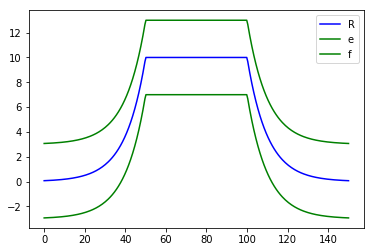

In [7]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [20, 20]
q2 = [0.01, 0.01]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])


Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [18]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
#us_init = np.zeros((N, dynamics.action_size))

for i in range(0, int(N - H) + 1):
    k = H - 1
    if i % k != 0:
        x0 = dynamics.f(xs[k - 1], us[k - 1], i)
        x0 = x0[0][:]
        continue
        #pass
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(len(xs) - 1)]



iteration 0 accepted [10.47808182] [14.04055241  0.43545812  9.91471083 -0.03112671] [ 0.00387194 -0.08019421]
iteration 0 accepted [12.66683225] [28.49600452  1.37512938  9.91548723  0.03976937] [ 0.00403883 -0.09194475]
iteration 0 accepted [28.91767916] [42.29051234  5.39234802  9.91661192  0.37321907] [ 0.00480927 -0.14815438]
iteration 0 accepted [472.46177175] [52.72453293  9.41115475 10.24138457 -0.3149242 ] [-0.00193401  0.07358496]
iteration 0 accepted [72.35752422] [ 7.15067548e+01  1.03175445e+01  1.02085671e+01 -3.22881242e-02] [-0.00130011 -0.07179171]
iteration 0 accepted [39.01622145] [ 8.65894487e+01  1.01894300e+01  1.01436064e+01 -5.84247451e-02] [ 0.00063176 -0.08106158]
iteration 0 accepted [26.57017984] [101.13514098   8.84978791  10.07468276  -0.50517841] [0.00167453 0.02260415]
iteration 0 accepted [126.62750221] [114.83201354   3.60179746  10.10170114  -0.29983085] [ 0.0008364  -0.14918762]
iteration 0 accepted [133.02610454] [ 1.29276781e+02  1.51579129e+00  1.

The result can be visulized by executing the following code.

In [19]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

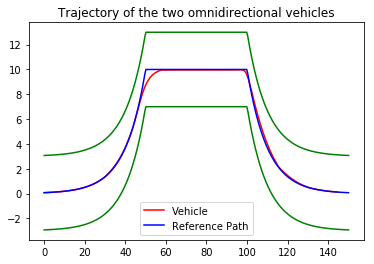

In [20]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [25]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
#for pt in range(num_pts):
#    x0 = [] # Initial state.
pt = 0
for pt in range(num_pts):
    i = pt % (len(x_path) - H - 1)
    #i = random.randint(0, len(x_path) - H - 1)
    x0 = [x_path[i][0] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][1] + 3.0 * (2 * random.random() - 1.0), \
          x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][3] + 3.0 * (2 * random.random() - 1.0)]

    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, \
                   x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x = [x0] + x_path_[0:H]
    u = us[0]
    expert_pts = expert_pts + [[x, us[0]]]


Point 0
iteration 0 accepted [237.49027201] [11.10120439  0.38913131  9.73818032 -0.48791563] [0.11453782 0.34742648]
Point 1
iteration 0 accepted [2780.79052676] [ 2.36529514 -3.76928643  9.45004003  3.76705341] [0.01178946 0.91704943]
iteration 60 accepted [168.35037386] [11.67708545 -0.02394156  9.95543033  6.38578851] [6.37669661e-03 2.90297045e-05]
Point 2
iteration 0 accepted [1287.49488817] [ 4.55936537  3.69908789 10.07837525  0.54914084] [-0.02170639  0.94108621]
Point 3
iteration 0 accepted [2386.02867133] [ 2.84997189 -0.5001631   9.82926194  4.64620163] [ 0.01378398 -0.03196265]
iteration 60 accepted [257.3791345] [12.90789424 -0.05524644 10.32367912  5.65640225] [-1.48283271e-02  1.79928240e-05]
Point 4
iteration 0 accepted [1084.10349732] [ 5.79544786 -1.9980102   9.45828526  3.37083057] [0.00264707 0.42617942]
Point 5
iteration 0 accepted [3113.98371395] [ 2.79130852  2.35863403  9.51357773 -7.1972565 ] [ 0.0205055  -0.77804461]
iteration 60 accepted [855.93383742] [10.0

Point 45
iteration 0 accepted [3143.52611176] [22.09728686 -1.44667402  9.53685094  1.64325473] [ 5.37365567e-04 -1.68541518e+00]
Point 46
iteration 0 accepted [1073.1078433] [29.89524938  3.14423173 10.76119719  0.61990414] [-0.47974657  0.2685619 ]
iteration 60 accepted [433.34445059] [34.63626077  2.41109648 11.16765996  0.16779826] [-0.05728036  0.00532998]
Point 47
iteration 0 accepted [542.24210974] [29.88542016  0.96022613 10.48695819 10.16438429] [-0.17989063  0.03527788]
iteration 60 accepted [202.08466181] [36.00680781  2.46038015 10.8368945   6.54963951] [-0.03903707  0.        ]
Point 48
iteration 0 accepted [2789.52211119] [24.64603136  2.38540781 10.14966831  9.49010935] [ 0.00569618 -2.50264758]
iteration 60 accepted [84.08568949] [37.5483437   2.92457874 10.64135491  6.52316001] [-3.06545691e-02 -5.46918409e-08]
Point 49
iteration 0 accepted [205.47596962] [35.0627103   2.17884187 10.53423968  0.54644487] [0.3099373  0.28231748]
Point 50
iteration 0 accepted [3665.83541

iteration 60 accepted [194.35878247] [59.32329551  9.86783454 10.35434176  0.07236373] [-1.61292453e-02  2.54270337e-05]
Point 93
iteration 0 accepted [2178.70734735] [49.04315206  8.93720219  9.51891158 10.62376443] [ 0.01367175 -2.58774864]
Point 94
iteration 0 accepted [2762.03817433] [46.84478308  7.28638669 10.48087196 -4.25243853] [ 0.10727407 -0.62018053]
iteration 60 accepted [556.38422571] [58.19147699  9.45661528 10.95766731  0.15082644] [-0.04237568  0.00254445]
Point 95
iteration 0 accepted [230.16734526] [59.56558879  8.45361518 10.20299302 -0.22005829] [-0.11371617 -0.29141101]
Point 96
iteration 0 accepted [2786.98034877] [ 49.01906509   7.7398072   10.26618215 -12.94666996] [0.00244286 0.51824556]
iteration 60 accepted [146.35439008] [61.48031751  9.87507946 10.58397146 -6.36917078] [-2.83113437e-02 -1.09848038e-06]
Point 97
iteration 0 accepted [3633.80862786] [46.60571979 11.00438295  9.38962162  4.45664077] [ 0.03696434 -2.59128789]
Point 98
iteration 0 accepted [437

iteration 60 accepted [69.42066581] [84.10201001  9.90828123 10.36763796  6.3144968 ] [-0.01627146  0.        ]
Point 143
iteration 0 accepted [1040.13079108] [77.28573071 11.55875144 10.49677604  6.78072541] [-0.14724548 -0.97681238]
Point 144
iteration 0 accepted [2989.03693623] [71.21188565  9.19532245  9.88837762 -3.45282422] [ 0.23312739 -2.13598835]
Point 145
iteration 0 accepted [2727.15047163] [72.40102245  7.85889171 10.32930897  5.50153845] [-0.02107507  2.15020206]
iteration 60 accepted [374.10216135] [8.32197500e+01 9.68087049e+00 1.10980858e+01 6.72680919e-02] [-0.05008925 -0.0003276 ]
Point 146
iteration 0 accepted [3581.46182778] [69.95481142 11.63732224  9.50565052 14.01061154] [-0.04371782 -3.11438851]
iteration 60 accepted [678.47116232] [82.10637768 10.50698156 10.01493766 12.47282539] [0.00614387 0.00043556]
Point 147
iteration 0 accepted [3193.71766927] [74.28967961 11.84575489  9.85484391  0.20926234] [0.00599742 0.52612357]
Point 148
iteration 0 accepted [3763.08

Point 191
iteration 0 accepted [237.79499367] [104.8061847    3.2064264    9.72016895  -2.07591363] [ 0.26477286 -0.47893573]
Point 192
iteration 0 accepted [1050.99321684] [102.50393084   7.45019309   9.15997364  -6.0314528 ] [0.30595958 0.32470217]
iteration 60 accepted [528.94498423] [104.94750127   6.66044275   9.85003907  -6.52901773] [0.02666965 0.0204292 ]
Point 193
iteration 0 accepted [1396.12192668] [101.76478361   5.79609523   9.06284001   6.12764477] [-0.18275779  0.23923585]
iteration 60 accepted [737.9795674] [106.00284522   5.95898332   9.86017895   5.8307868 ] [-0.00381505  0.01937427]
Point 194
iteration 0 accepted [1854.236894] [103.25440887   8.04313535   9.54478706   5.22879915] [-0.41563785 -0.07634629]
iteration 60 accepted [334.64352411] [108.48685244   4.6982448   10.29183868   5.82007863] [-0.01232181 -0.00072835]
Point 195
iteration 0 accepted [4151.85269577] [95.5078286   9.20257357  9.92291173 -4.36415584] [-0.00457926  2.48600822]
Point 196
iteration 0 acce

iteration 60 accepted [310.3332287] [128.18535001   1.03007865  10.65302576  -0.15102905] [-2.78826727e-02  6.81196883e-05]
Point 235
iteration 0 accepted [613.57461016] [122.4490457    0.57256652  10.01081477   2.43636579] [-8.62104924e-04 -2.20939774e+00]
Point 236
iteration 0 accepted [2634.89558055] [119.6433529    2.21672644   9.79557177   4.83064373] [ 0.01050708 -2.57602551]
iteration 60 accepted [85.91181465] [130.13785576   0.44063787  10.30492005   6.26510312] [-1.17511534e-02 -1.67083887e-06]
Point 237
iteration 0 accepted [1278.93114681] [123.8404836   -0.37521933   9.71104195  -4.31475624] [0.00640288 2.4679591 ]
iteration 60 accepted [93.98363079] [130.18984676   0.81084908  10.19194839  -5.90900654] [-0.0056648   0.00015699]
Point 238
iteration 0 accepted [781.94659192] [123.89344987   2.07181964  10.45505517  -1.61582563] [-0.01843338 -1.6284038 ]
iteration 60 accepted [21.36486271] [ 1.34166939e+02  3.28296542e-01  1.04715046e+01 -2.21145987e-02] [-0.02383734  0.      

Point 279
iteration 0 accepted [153.82111044] [15.97308897  0.62256257 10.53283294 -5.65442155] [-0.05296879  0.25284811]
Point 280
iteration 0 accepted [2175.4803451] [ 6.91184241  1.05239134  9.84796054 11.05526837] [ 0.00665964 -2.11451818]
iteration 60 accepted [185.86443244] [16.87497144  0.31429861 10.39972314 -6.22829454] [-1.59883741e-02  2.09442942e-06]
Point 281
iteration 0 accepted [2076.06555894] [ 7.63980344 -2.29774862 10.25206911  4.59052192] [-0.02214561 -2.84428025]
Point 282
iteration 0 accepted [948.72387016] [12.09059007 -2.40909033 10.24968745 -1.98284195] [ 0.00089955 -0.75898096]
Point 283
iteration 0 accepted [3145.96682177] [ 7.31097951 -0.28054064  9.32725122  4.49442433] [ 0.02442583 -1.78421845]
Point 284
iteration 0 accepted [824.19068354] [12.4099324   2.30618233 10.6239935   0.23468972] [ 0.27860243 -1.06515558]
Point 285
iteration 0 accepted [1606.27347345] [11.68482329  3.70194785  9.76441295 -9.96499382] [-1.57369134e-05  2.57888145e+00]
iteration 60 a

Point 328
iteration 0 accepted [661.80219059] [33.78288093  4.64721458  9.37483829  2.28704327] [ 0.1050981  -1.55401696]
Point 329
iteration 0 accepted [346.47238669] [38.10001793  6.10979395 10.18298713  0.05189773] [-0.28384997 -1.25820507]
Point 330
iteration 0 accepted [1974.77058892] [ 32.99449736   3.15693709   9.5590981  -10.81724476] [0.00516618 2.53172541]
iteration 60 accepted [141.53334512] [41.74240922  4.66763535  9.92995463 -5.88057446] [ 8.12917186e-03 -2.16270362e-05]
Point 331
iteration 0 accepted [1007.09848102] [39.53443915  0.32264843 10.60277683 -1.85249854] [-0.17668266 -0.72112395]
Point 332
iteration 0 accepted [1452.11769688] [33.03410308  4.70036902  9.70079859 -1.98706186] [-0.15985135  1.9215364 ]
Point 333
iteration 0 accepted [2156.40458829] [ 34.06837801   6.01470484   9.31623149 -10.36368266] [0.01918257 1.75650219]
iteration 60 accepted [172.68787751] [42.41961878  5.58052825  9.7403395  -5.14093639] [0.0182211  0.00010462]
Point 334
iteration 0 accept

iteration 60 accepted [75.90627478] [64.89360436  9.98679775 10.34166165 -6.30412543] [-0.01542015  0.        ]
Point 373
iteration 0 accepted [732.85444216] [58.14267624  8.72711718  9.37938685 -0.76749548] [0.12970394 0.36422902]
Point 374
iteration 0 accepted [1253.96771864] [56.69854792  7.25097629  9.81988467  4.09040413] [ 0.0158824  -1.91740329]
iteration 60 accepted [61.60375068] [65.06801771  9.7671186  10.11018067  6.34843334] [-0.00280415  0.        ]
Point 375
iteration 0 accepted [983.57463247] [58.27439619 12.00545168  9.90172099 -0.34629954] [0.00590931 0.54202189]
Point 376
iteration 0 accepted [1983.84509525] [54.89787776  9.26135125  9.74757007  7.96579492] [ 0.02056572 -0.74137676]
iteration 60 accepted [125.0153455] [65.02313866  9.78152423 10.1735791   6.34535072] [-0.00478013 -0.00015692]
Point 377
iteration 0 accepted [582.46000546] [63.09205756  9.78967244  9.6253283   0.29215923] [-0.1054373 -0.3825229]
Point 378
iteration 0 accepted [2958.21170541] [53.8241359

iteration 60 accepted [53.31675506] [8.78021324e+01 9.97849936e+00 1.05060822e+01 5.13245967e-02] [-2.48932200e-02  8.03829761e-10]
Point 417
iteration 0 accepted [3156.2016499] [74.53821102 10.3892797  10.31591783 -6.86672599] [ 0.00165788 -0.36519326]
Point 418
iteration 0 accepted [404.79893822] [85.05557972 11.26579079 10.6183992  -0.14870492] [-0.07576825 -0.36859906]
Point 419
iteration 0 accepted [2944.71033789] [75.16110187 12.7672666   9.71813577 10.99188472] [-3.03266884e-04 -3.19293963e+00]
Point 420
iteration 0 accepted [2125.45321954] [77.17154119 11.4912627  10.47108138 -6.49217966] [-0.22400891 -1.71783471]
iteration 60 accepted [107.22688563] [88.67101845  9.95695536 10.74516584 -6.28273899] [-3.51775398e-02  1.38293546e-07]
Point 421
iteration 0 accepted [1920.02709773] [79.92308158 10.00763465  9.47745096  5.01779612] [ 0.02534788 -2.22718637]
iteration 60 accepted [110.15929099] [88.98933883  9.95731288  9.84696467 -6.25094248] [ 0.0092432  -0.00012273]
Point 422
ite

iteration 60 accepted [357.87217094] [108.96648333   4.57635482  10.35358658  -6.72332692] [-0.0124588   0.00013433]
Point 466
iteration 0 accepted [3546.24774104] [98.14208961  7.95663794 10.37444149  1.42669013] [ 0.01003276 -0.68640181]
Point 467
iteration 0 accepted [5201.04721523] [ 97.80324122  12.81642805   9.93543479 -12.56913597] [-0.004681    3.37268065]
iteration 60 accepted [1093.01684968] [107.39644335   6.1847515   10.74403779  -0.55324594] [-0.02977484 -0.01992726]
Point 468
iteration 0 accepted [3052.79261511] [102.40406677  10.4331798   10.13773616  -2.74283205] [0.00783385 0.79153327]
iteration 60 accepted [675.06799125] [109.21510411   4.83623545  10.97472962  -0.43688788] [-0.04395175  0.00876187]
Point 469
iteration 0 accepted [5028.69624142] [100.10724137  13.7695416    9.47447995   1.45485127] [ 0.00507705 -1.63038373]
iteration 60 accepted [1184.27940415] [108.03147306   5.95800018  10.23730172  -0.49736956] [-0.00221737  0.00068403]
Point 470
iteration 0 accept

Point 511
iteration 0 accepted [1064.46589316] [125.50592187   4.10038823   9.43119795  -3.02562773] [0.30470401 2.41746537]
Point 512
iteration 0 accepted [2530.4877129] [123.48956027  -1.19507199   9.63600558   4.53554655] [ 0.01850798 -2.56298155]
iteration 60 accepted [481.17702755] [1.32498816e+02 9.20265849e-02 1.02009057e+01 4.32817105e-02] [-0.00558068 -0.00040905]
Point 513
iteration 0 accepted [3489.40230023] [120.30351046   2.33808032   9.44759161  -8.00871698] [0.01963739 0.89485064]
iteration 60 accepted [190.91994633] [133.30570164   0.50054738   9.93905077  -6.35602763] [7.36593488e-03 2.35268000e-05]
Point 514
iteration 0 accepted [1565.66797442] [124.31391411   1.59178943  10.24083274   7.39548866] [-0.15054237 -1.78639245]
iteration 60 accepted [86.9202214] [136.36030856   0.24755584  10.45437769   6.2733711 ] [-2.13373741e-02 -6.85429509e-06]
Point 515
iteration 0 accepted [2597.2564704] [124.60365769  -5.17828266  10.21067938   3.53241234] [-0.01379073 -2.2418293 ]


Point 557
iteration 0 accepted [1469.01572041] [11.96412507 -3.66806383 10.44084796 -2.82970964] [-0.00936994  2.53776649]
Point 558
iteration 0 accepted [2761.22500066] [10.92549413  2.72434267  9.99140296 -0.21164975] [-0.00461222 -1.39031026]
iteration 60 accepted [196.29638904] [20.8499859   0.27561806 10.59046802 -7.58522353] [-2.81377009e-02  4.62444035e-06]
Point 559
iteration 0 accepted [1920.91402237] [13.83059714 -1.90684426 10.13501475 -4.22162591] [0.00610383 2.48999616]
iteration 60 accepted [80.14784683] [23.84970491  0.72325883 10.53656825  6.36556282] [-2.52653116e-02 -1.94475813e-05]
Point 560
iteration 0 accepted [313.61856467] [21.93875383  1.01133588 10.17871627 -1.33563469] [-0.04817266 -0.5336039 ]
Point 561
iteration 0 accepted [1142.88746239] [15.13766042 -1.61250351  9.44623001  9.19779338] [-0.05409301  1.0467064 ]
Point 562
iteration 0 accepted [627.49086885] [17.54584296 -0.78651331  9.82752758 -0.70800215] [0.0442967  1.01688003]
Point 563
iteration 0 accep

Point 603
iteration 0 accepted [776.80389144] [41.56055129  3.21280253  9.94214302 -6.70867502] [-0.45651765 -0.51407046]
iteration 60 accepted [253.03188535] [44.03051478  5.64198583 10.47549346 -5.74816896] [-0.01941644 -0.00018837]
Point 604
iteration 0 accepted [3248.16758026] [33.11816499  2.13055853 10.39180559  5.94408325] [ 0.01249926 -2.77306848]
Point 605
iteration 0 accepted [3357.92181148] [31.53862504  3.43264769  9.51151234  4.49854959] [-0.0031763  -2.60025526]
iteration 60 accepted [196.02522805] [44.21970167  6.0197612   9.94048661  6.8114064 ] [8.65859843e-03 4.41735702e-06]
Point 606
iteration 0 accepted [2559.35312537] [35.87756827  0.14477538  9.8025085   7.68075389] [-0.04912614 -0.75848008]
iteration 60 accepted [441.26561873] [44.16509727  5.96841503 10.19801885  6.82200787] [-0.00427518 -0.00594031]
Point 607
iteration 0 accepted [4157.51907292] [34.79796361 -0.689069    9.43666419  3.06069902] [ 0.02089655 -2.47102624]
iteration 60 accepted [517.94862352] [44.

Point 648
iteration 0 accepted [2501.43048401] [57.03515004  6.41991238  9.95903214  8.89539598] [-0.00412222  0.82317441]
iteration 60 accepted [120.48612497] [67.74345278  9.91534552 10.42147946 -6.26015695] [-0.01858034  0.00033094]
Point 649
iteration 0 accepted [2378.83190966] [57.03693516 11.96832766 10.48303061 -1.83490731] [-0.01918489 -3.20968861]
Point 650
iteration 0 accepted [1664.10607051] [59.38015295  8.52182409  9.56409068 11.68518082] [ 0.05145267 -2.83717232]
iteration 60 accepted [275.18766916] [65.23343977  9.34969438 10.05120951 12.31318597] [ 0.00426411 -0.00164897]
Point 651
iteration 0 accepted [2927.60957287] [55.32531751 10.7565394  10.47269933 11.06138075] [ 0.00919494 -2.8128906 ]
iteration 60 accepted [287.15626875] [6.76181817e+01 9.88308265e+00 1.11493615e+01 1.97747527e-02] [-5.28168811e-02  4.88999087e-07]
Point 652
iteration 0 accepted [338.29365596] [65.49872334 11.08438061  9.94103944 -5.70724483] [ 0.26194572 -0.24661863]
Point 653
iteration 0 accep

iteration 60 accepted [62.34925208] [90.06199816 10.15475441 10.37535102 -6.31380458] [-0.01594805  0.        ]
Point 694
iteration 0 accepted [2387.52630674] [79.90774559 14.16133229  9.86472772  7.21016772] [6.76303333e-04 6.83414441e-01]
iteration 60 accepted [41.78423763] [ 9.23688256e+01  9.96210812e+00  1.01052180e+01 -1.43360533e-03] [-4.71861844e-03  1.38408283e-10]
Point 695
iteration 0 accepted [1590.63298279] [80.87321592 10.02144633 10.0190796   2.81120473] [-0.16416627  2.22475495]
iteration 60 accepted [238.21700004] [90.62255619  9.87322647 10.4589507   6.31895004] [-0.01968457  0.00058924]
Point 696
iteration 0 accepted [2673.09282378] [78.77378373 10.06519699  9.34416465  8.55910286] [-0.01580001 -1.86564102]
Point 697
iteration 0 accepted [1324.36350677] [83.60947202 10.93212741 10.52232406  1.99484612] [-0.01012638 -1.94070169]
Point 698
iteration 0 accepted [1692.37588625] [82.56535193  7.2772869  10.30525214  2.55358599] [-0.00290692 -1.84204563]
Point 699
iteratio

Point 742
iteration 0 accepted [1846.87951218] [103.25620082   2.40874291  10.00181578  -2.59957332] [-0.11958221 -2.07684899]
iteration 60 accepted [156.49757408] [113.22893743   2.53369057  10.45814365  -0.2576683 ] [-0.01829564 -0.00048999]
Point 743
iteration 0 accepted [740.27717375] [109.99290889   4.23822435   9.35614179   6.79640887] [0.02508492 0.36582698]
iteration 60 accepted [257.23734082] [114.46227476   2.66072169  10.04764058  -0.29101502] [0.00033365 0.00082321]
Point 744
iteration 0 accepted [3130.44880432] [104.49735356   4.72123167   9.35588995 -12.61406234] [0.04338133 2.488626  ]
Point 745
iteration 0 accepted [900.28873761] [109.03692868   5.60459984   9.31634882  -1.66761516] [-0.08077771 -1.09225633]
Point 746
iteration 0 accepted [4602.08498263] [100.92018036  10.33726848   9.6196557  -14.81151677] [0.03220819 3.57309805]
iteration 60 accepted [257.68932396] [114.34454591   2.4609245   10.26418245  -0.51204573] [-7.52393825e-03 -3.53545587e-07]
Point 747
iterat

iteration 60 accepted [130.31618585] [136.86559525  -0.22501686  10.65859752  -7.50779307] [-3.23973014e-02  5.23458425e-08]
Point 787
iteration 0 accepted [2297.52297294] [125.42427767   3.03347716   9.56290719  -6.39724317] [0.05684263 1.55776298]
iteration 60 accepted [225.15689615] [136.18959611   0.52360188  10.238598    -6.39388387] [-0.00847061  0.00026089]
Point 788
iteration 0 accepted [2283.35836872] [126.97383772   2.68196406   9.82063414  -3.72644101] [0.1074683  2.13689031]
iteration 60 accepted [153.78967518] [ 1.37864085e+02  2.38963024e-01  1.02173122e+01 -1.20434007e-02] [-0.00886404  0.00052928]
Point 789
iteration 0 accepted [1635.54763054] [130.98605601   0.1603879   10.5431882    6.29973538] [ 0.25901779 -0.10289153]
iteration 60 accepted [134.9465659] [138.74681381   0.19549298  10.82789428   6.27098699] [-3.91483582e-02 -1.70026644e-05]
Point 790
iteration 0 accepted [3027.25532666] [125.66967188   1.05222313   9.44013937  -5.74730069] [-0.18921292 -1.53021299]
i

iteration 60 accepted [87.10069454] [23.89278728  0.68067528 10.65398589  0.0664856 ] [-0.03244873  0.        ]
Point 828
iteration 0 accepted [2103.68136972] [13.14676718 -2.36087976 10.28048514 -6.71375446] [ 0.00206209 -1.81318065]
iteration 60 accepted [131.44823652] [22.50626606  0.56490504 10.73858205  0.10516277] [-0.03366806 -0.00024592]
Point 829
iteration 0 accepted [196.06913896] [20.33465702  2.17662578 10.15804396 -3.11851741] [-0.0071894  -0.76072003]
Point 830
iteration 0 accepted [545.90053443] [17.72769192 -1.04799885 10.14972689  2.40094822] [-0.00282167 -1.6180874 ]
Point 831
iteration 0 accepted [620.14899123] [18.57382105  0.73038294  9.78814113  6.17022128] [ 0.30569229 -0.83135816]
iteration 60 accepted [152.61773483] [23.72192245  0.81672564 10.15341269  6.33293226] [-4.06204017e-03 -6.78709925e-05]
Point 832
iteration 0 accepted [2072.47500929] [14.55723754 -1.29475115  9.45760386  5.30978274] [0.01203399 1.08462992]
iteration 60 accepted [393.1372216] [22.3091

iteration 60 accepted [438.91210394] [44.64357399  5.94585304 11.09746464 -5.69141063] [-0.05176582  0.00439571]
Point 875
iteration 0 accepted [2632.35282108] [34.07289338  5.51715443 10.42181719 -6.15161065] [ 0.08184052 -0.499153  ]
Point 876
iteration 0 accepted [3509.94152102] [33.05870547  1.45028104 10.13718937  1.54083392] [-0.00507969 -2.02631839]
iteration 60 accepted [343.03643258] [45.3337013   6.88721175 10.96456895  0.52498792] [-0.04304239 -0.00318928]
Point 877
iteration 0 accepted [746.07313094] [40.37544885  4.77875419  9.88536248 -0.2832121 ] [-0.00449436 -1.39798004]
Point 878
iteration 0 accepted [393.3598519] [43.54640892  7.42401264  9.8040481   1.6755572 ] [-0.06685101 -0.25085387]
Point 879
iteration 0 accepted [529.5567551] [42.37719161  8.61854926  9.90837303 -4.95159424] [-0.110307   -0.07639572]
Point 880
iteration 0 accepted [746.08619695] [41.37491355  8.38887837 10.52532759  1.95416883] [-0.04094169 -1.34959663]
Point 881
iteration 0 accepted [2744.11986

iteration 60 accepted [26.76018209] [7.09344778e+01 9.96410202e+00 1.03656716e+01 3.69665470e-03] [-0.01852559  0.        ]
Point 920
iteration 0 accepted [2476.81289346] [58.16618505  8.80869623 10.43249306 -3.04269247] [-0.01294526  2.4202114 ]
iteration 60 accepted [394.86622482] [ 6.82069498e+01  9.77211732e+00  1.11142511e+01 -8.45980455e-03] [-0.05372556  0.00514392]
Point 921
iteration 0 accepted [2127.11272565] [59.3930393   7.05079218 10.1775955  -5.31319336] [6.22441008e-04 3.24013623e+00]
Point 922
iteration 0 accepted [3284.97926554] [57.69058657  7.20111648  9.5050884  -4.11280977] [0.01467363 2.09758494]
Point 923
iteration 0 accepted [2720.50640671] [58.57150816  9.10140751 10.23066477 -2.61920562] [-0.00200573 -1.11797479]
iteration 60 accepted [372.90482709] [68.78628353 10.18417881 11.06503701  6.22766112] [-0.04837284 -0.00145568]
Point 924
iteration 0 accepted [232.0012756] [68.06257087  9.20536621  9.74586657  6.41252453] [ 0.2134437  -0.96253671]
Point 925
iterati

Point 965
iteration 0 accepted [2552.94474412] [80.79974865 10.69384851  9.44748944 -4.09534782] [ 0.01108792 -0.34717382]
iteration 60 accepted [148.87891909] [90.85682123 10.12632177  9.96029987 -6.34270916] [ 5.62931635e-03 -1.70556358e-05]
Point 966
iteration 0 accepted [3135.57389918] [ 79.47946416  11.37903669   9.84467072 -11.97248454] [0.01579722 3.21228814]
Point 967
iteration 0 accepted [1351.1039945] [84.46890421  7.04163759 10.06494651  2.74754551] [-0.01070756  1.3188039 ]
Point 968
iteration 0 accepted [698.446413] [86.7046729   9.11323581  9.94797618 -4.32844825] [0.08661312 0.64426705]
iteration 60 accepted [129.47402741] [93.72677401 10.0092453  10.31685362 -6.31460076] [-0.0138012   0.00047541]
Point 969
iteration 0 accepted [1821.39896389] [84.44401993  9.95707083  9.62791462 -4.89709253] [0.01470049 2.74857283]
Point 970
iteration 0 accepted [1723.47567173] [84.79903119 14.16570893  9.71649965  8.49224703] [-0.16964744  0.37537822]
Point 971
iteration 0 accepted [37

iteration 60 accepted [256.79163627] [114.70127525   2.49885928  10.96259303  -0.29636857] [-0.04530698  0.        ]
Point 1012
iteration 0 accepted [2056.19417862] [103.9514739    4.76714727  10.42660343   6.36392583] [ 0.07607155 -0.1774514 ]
iteration 60 accepted [302.25612417] [114.03396937   2.84335035  10.91331545   5.94755005] [-0.04042926 -0.00874463]
Point 1013
iteration 0 accepted [2617.6771074] [106.26383853   9.24155445  10.1983337   -5.37221777] [0.16993957 1.4255427 ]
iteration 60 accepted [410.37242485] [114.30182595   2.94805583  10.82287995  -6.62639465] [-0.03632383  0.0010083 ]
Point 1014
iteration 0 accepted [874.98763528] [107.42789892   1.57004017  10.23849133  -3.98843292] [-0.27074818 -0.33300511]
Point 1015
iteration 0 accepted [3661.93303448] [102.47202926   6.89825583   9.70311404 -12.1536526 ] [-0.01162221  3.51907651]
iteration 60 accepted [596.66632493] [112.63672156   3.61181838  10.3198003  -12.90197741] [-0.00949468 -0.00462991]
Point 1016
iteration 0 a

Point 1057
iteration 0 accepted [2171.82420902] [126.12994644   1.76749367   9.56431039  -4.10268313] [-0.12977078  2.77439997]
Point 1058
iteration 0 accepted [1999.30902139] [126.17525553   1.66164853   9.81748917   3.20906554] [ 0.14808516 -2.06096822]
Point 1059
iteration 0 accepted [3256.79760152] [125.05838016  -2.31033379   9.49453914  -1.320662  ] [0.02837903 0.76219148]
iteration 60 accepted [171.2124274] [ 1.36695037e+02 -7.32728418e-02  9.77713877e+00  4.60899053e+00] [ 0.01512566 -0.0003273 ]
Point 1060
iteration 0 accepted [659.18020875] [132.60621761  -3.87796806  10.09996222   2.77917574] [ 0.00752276 -1.42198117]
Point 1061
iteration 0 accepted [2701.55526233] [127.82640166   2.93836647   9.83056817  -3.49485717] [-0.05138353  2.10426659]
iteration 60 accepted [146.98429234] [139.52583137   0.22096772  10.43315043  -6.3120152 ] [-1.86069546e-02 -1.13198253e-05]
Point 1062
iteration 0 accepted [2293.76482832] [128.62898366  -1.13950297  10.26995764  -0.68346076] [0.00639

iteration 60 accepted [53.06674604] [26.2721392   1.05824344 10.44570073 -6.2576544 ] [-1.99986542e-02  1.20788127e-10]
Point 1104
iteration 0 accepted [3090.94903002] [13.69841255  2.05035433 10.35801611 -6.15171495] [-0.00446529 -0.81629582]
iteration 60 accepted [20.53430361] [28.61381596  1.17175559 10.43044333  0.10974955] [-0.0215352  0.       ]
Point 1105
iteration 0 accepted [182.07507799] [25.18814084  0.96033093  9.66208412 -0.91948654] [-0.30398994 -0.72666669]
Point 1106
iteration 0 accepted [1054.35881006] [18.52233925  0.91719184  9.25646018 10.75019563] [ 0.22803059 -0.46238852]
Point 1107
iteration 0 accepted [2262.1349063] [16.67489531 -1.14754166  9.82789594 -0.60753163] [0.01614676 0.56281732]
iteration 60 accepted [717.17800447] [23.01510082  0.38325802 10.53441936 -6.14156927] [-0.01941272  0.00385663]
Point 1108
iteration 0 accepted [2637.31427788] [ 16.67199034   1.67406678  10.08690892 -12.34155321] [0.00938717 2.79574558]
iteration 60 accepted [75.58296279] [29

iteration 60 accepted [303.19847707] [47.55479632  8.45717758 11.047897    6.8070302 ] [-0.04850951  0.        ]
Point 1148
iteration 0 accepted [2092.87026065] [39.04478436  3.67673456 10.45273891 10.36717404] [-0.0167448  -2.31663755]
iteration 60 accepted [103.41907401] [48.06200717  8.10094779 10.79183423  6.85939075] [-0.03553679  0.        ]
Point 1149
iteration 0 accepted [515.7657778] [45.26316643  7.56412615  9.93959087  6.878178  ] [-0.53803345 -0.34618093]
Point 1150
iteration 0 accepted [1147.62711277] [41.43625572  7.07851865  9.80995316 -4.25265001] [-8.31572144e-05  2.80103148e+00]
iteration 60 accepted [34.60813666] [50.52496373  9.58290853 10.01261541  0.35233577] [ 8.79463925e-04 -4.62438957e-11]
Point 1151
iteration 0 accepted [2451.6163298] [39.73778664  1.83738666  9.26660066  5.08755275] [0.1341021  0.63094821]
Point 1152
iteration 0 accepted [4041.63315772] [38.42167682  3.43230795  8.91908927 -0.28406554] [ 0.04610682 -0.5484228 ]
Point 1153
iteration 0 accepted

iteration 60 accepted [113.7326689] [68.78820942  9.65414623 10.00162172  5.75771081] [4.03996816e-03 6.15819823e-06]
Point 1192
iteration 0 accepted [3012.33286698] [59.44222532  4.0447706  10.0889068   6.03149011] [ 0.00611504 -3.14102119]
iteration 60 accepted [212.59495193] [70.63548793  9.81362787 10.76070636  6.35569978] [-0.03535123  0.        ]
Point 1193
iteration 0 accepted [3461.42009607] [58.83837717 14.61931126 10.19410866 -5.18689187] [ 0.01402584 -0.72753635]
Point 1194
iteration 0 accepted [1903.53787491] [60.89255306 10.12378514  9.41288475 -7.19459709] [0.09773105 1.16151654]
iteration 60 accepted [125.75439167] [70.83568612 10.02577808 10.01697212 -6.30760745] [ 2.78516225e-03 -7.12376644e-07]
Point 1195
iteration 0 accepted [2525.06263585] [ 61.76850562  13.1583816    9.29837066 -11.18646392] [0.02764713 2.3513762 ]
iteration 60 accepted [222.97741465] [70.30049474 10.12127963  9.74211659 -6.34015065] [0.01642628 0.00047326]
Point 1196
iteration 0 accepted [2748.561

Point 1239
iteration 0 accepted [2630.77033445] [80.51516033  8.92604286 10.18572273  6.64740585] [-0.00853875 -3.51531456]
Point 1240
iteration 0 accepted [649.85360297] [88.06603352 10.56342896  9.59663006  0.08905632] [ 0.0108572  -0.83215786]
Point 1241
iteration 0 accepted [3945.68546448] [80.70890434 11.0444538   9.38935645  1.38518405] [ 0.03520458 -1.87401204]
iteration 60 accepted [404.03305381] [90.88010263 10.17407613 10.22129301  3.09512323] [-0.00676924 -0.00077993]
Point 1242
iteration 0 accepted [1747.08854909] [83.39399249 11.25665192  9.60888808 -1.79684174] [-0.05265127  1.80867995]
Point 1243
iteration 0 accepted [2223.5097493] [ 85.16460184   5.01304768  10.43396199 -11.26721142] [-0.00626378  2.48386697]
iteration 60 accepted [248.9157988] [95.89832093  9.44226055 10.74944527 -7.47115275] [-0.03671307  0.00167977]
Point 1244
iteration 0 accepted [574.70759062] [89.71322892  8.20769612  9.43892401 -0.41338708] [0.06039105 1.7339607 ]
Point 1245
iteration 0 accepted 

Point 1285
iteration 0 accepted [1156.69784658] [109.25337243  -0.29736839  10.37561182   5.08857921] [-0.14023796 -1.2566666 ]
Point 1286
iteration 0 accepted [2501.91036935] [107.03333629   5.63648445  10.0807955  -12.91101342] [0.00410108 3.28879839]
iteration 60 accepted [152.71072707] [116.99616815   2.11088813  10.69352913 -12.82623104] [-3.08968849e-02  1.16879226e-05]
Point 1287
iteration 0 accepted [4888.27937948] [104.41226972   4.42132397   9.81145599  -1.31625354] [-0.00077538 -0.61040844]
iteration 60 accepted [1015.52682124] [112.76359094   4.12049632  10.90994814  -0.28609   ] [-0.03713247 -0.00289582]
Point 1288
iteration 0 accepted [1810.03524855] [108.61555834   4.09632516  10.27758783  -0.32470877] [-0.20981181 -1.93641575]
Point 1289
iteration 0 accepted [2619.53397655] [106.44228204   3.15791872  10.31398005   6.85073756] [ 0.0911635  -0.78001354]
iteration 60 accepted [382.49917503] [117.81740432   1.96206209  10.85004806   1.53630399] [-0.04137306 -0.0004935 ]
Po

Point 1328
iteration 0 accepted [2002.14410958] [127.74893972   1.35062541   9.33251036   4.52496426] [ 0.00687979 -2.92207764]
Point 1329
iteration 0 accepted [900.43067351] [ 1.30913776e+02 -8.13157249e-01  9.31662157e+00 -4.64950322e-02] [-0.05362514 -1.00140767]
Point 1330
iteration 0 accepted [328.81543531] [ 1.36179378e+02  9.69261667e-02  9.56833725e+00 -1.56969801e-01] [0.07044996 0.5516582 ]
Point 1331
iteration 0 accepted [3780.47569813] [128.14829159   2.57561991   9.82953561   4.25282996] [-4.41247163e-04 -5.62524309e-01]
iteration 60 accepted [470.01044419] [ 1.38424580e+02  6.57697965e-01  1.04958680e+01 -1.27379568e-01] [-2.04194207e-02  5.74564564e-05]
Point 1332
iteration 0 accepted [2167.71872236] [128.82222904   1.53962226   9.76856733  -8.20756652] [0.01614974 1.29273357]
iteration 60 accepted [368.57046221] [137.29290775   0.58195786  10.19021133 -12.51776166] [-0.00271302  0.00321719]
Point 1333
iteration 0 accepted [3054.059134] [127.85792191   1.1985217   10.123

Point 1375
iteration 0 accepted [2745.38063922] [14.90939717 -1.10298269 10.40456993  3.42137655] [-0.03962361 -0.95956245]
iteration 60 accepted [173.85714122] [27.31833597  1.01877112 10.74599186 -6.07583917] [-0.03556571  0.00021657]
Point 1376
iteration 0 accepted [3099.79067982] [ 1.51398065e+01 -4.38451172e-03  1.00707810e+01 -6.76394243e+00] [0.01206932 0.26912009]
Point 1377
iteration 0 accepted [1728.93592688] [19.3062296  -4.83261256  9.80713215  2.93124269] [ 0.04674318 -1.56564367]
Point 1378
iteration 0 accepted [2552.25094614] [15.81913623  1.51780732 10.13392408  7.46861357] [ 0.00821469 -3.77927817]
Point 1379
iteration 0 accepted [3649.61902928] [15.66724421 -0.13448854 10.38431954 11.97923297] [-0.0062854  -2.92801682]
iteration 60 accepted [85.18521705] [29.38601335  1.38915592 10.77828195 -6.20354348] [-3.61503381e-02  8.07414596e-09]
Point 1380
iteration 0 accepted [905.70891798] [23.95041916  1.76359362  9.60140221  6.31404911] [ 0.01110745 -0.70240735]
Point 1381

iteration 60 accepted [1029.38014912] [44.70050327  5.67835603 11.27402691  9.521319  ] [-0.05807303 -0.00205825]
Point 1422
iteration 0 accepted [1686.20927995] [39.81320051  7.41743948 10.45083302  2.69566045] [ 0.00932342 -1.30103434]
Point 1423
iteration 0 accepted [3813.94549351] [39.94800193  2.85275234  9.93623318  4.86554374] [ 3.50819661e-04 -3.19290986e+00]
iteration 60 accepted [180.76982732] [50.17642784  8.54576278 10.61148694  6.65447838] [-0.02583067 -0.00032041]
Point 1424
iteration 0 accepted [1253.74661074] [45.35743574  5.56732851  9.99524019 -4.40148418] [-0.24554913  0.28872388]
iteration 60 accepted [270.02978943] [50.2702381   8.73698866 10.71018394 -5.97360752] [-0.0312163   0.00254582]
Point 1425
iteration 0 accepted [2463.94255314] [41.66915765  6.14444174  9.56103269  0.33632921] [ 0.16373844 -0.594376  ]
iteration 60 accepted [310.82082313] [50.01266267  8.0602055  10.10461608  6.50011804] [ 0.00108872 -0.00223523]
Point 1426
iteration 0 accepted [1896.33158

iteration 60 accepted [216.59699009] [7.11898399e+01 9.79251621e+00 1.03357145e+01 5.18369715e-02] [-1.29575170e-02 -4.35976473e-06]
Point 1465
iteration 0 accepted [3041.07758227] [60.03175308 14.09689331  9.75845731 -2.44608989] [0.02859258 0.86895906]
iteration 60 accepted [190.96417254] [ 7.28738329e+01  1.00530779e+01  1.00936755e+01 -4.71718360e-02] [-2.63185978e-03  3.69940399e-06]
Point 1466
iteration 0 accepted [525.81753484] [66.62271648 15.15699221  9.69408854  1.74098289] [ 0.03763744 -1.50582082]
Point 1467
iteration 0 accepted [167.31601385] [71.61347772 11.13401474  9.95414941  3.66979372] [0.24931421 0.73692866]
Point 1468
iteration 0 accepted [2601.9427702] [61.49457643 11.2653055  10.42013706  2.29513223] [-0.00453682 -1.33326401]
iteration 60 accepted [121.43619471] [74.44405437  9.9371708  10.76636131 -6.26936177] [-0.0360289   0.00052478]
Point 1469
iteration 0 accepted [3492.16932682] [60.88399624  8.47966879  9.51216092  9.28385204] [ 0.02464489 -1.30696098]
Poin

iteration 60 accepted [1030.64361184] [88.16138909 10.73354818 11.16103663  1.04209975] [-0.0482616  -0.02950151]
Point 1511
iteration 0 accepted [2183.90931537] [85.8228568   6.63092889  9.97662048  4.27906881] [ 0.01526687 -1.48093125]
Point 1512
iteration 0 accepted [2622.36196347] [84.86298938 11.38045912  9.24711681  3.51261171] [ 0.08077209 -1.96552154]
Point 1513
iteration 0 accepted [2960.85769728] [ 83.66671182   6.42836285   9.63390596 -13.10129205] [0.00985097 3.66139274]
iteration 60 accepted [132.10300721] [95.99081381 10.04023512  9.97372587 -6.31372695] [ 4.84984945e-03 -8.07495625e-06]
Point 1514
iteration 0 accepted [2942.23056832] [84.52803584 13.71964972 10.1417812  -9.26605222] [-0.00513423 -0.42750494]
iteration 60 accepted [168.11143618] [97.20433428 10.02619001 10.71990818 -6.31518572] [-0.03329752  0.        ]
Point 1515
iteration 0 accepted [1296.31187184] [89.97472094 10.74491033 10.46152862  5.75545596] [-0.06569897  0.20769925]
iteration 60 accepted [104.883

Point 1552
iteration 0 accepted [3270.75305402] [102.79927123   4.32639917  10.30263231  -1.38342734] [ 0.06263246 -0.82215772]
iteration 60 accepted [263.21664496] [115.57006485   2.3863278   10.93474516   5.98846536] [-0.04297565 -0.00885599]
Point 1553
iteration 0 accepted [1378.07311415] [106.87810078   5.12693037  10.1463561   -0.95832286] [ 0.1920593  -1.09361261]
Point 1554
iteration 0 accepted [1897.84211517] [105.55429458   2.3099194    9.29110902  11.32766345] [-0.00617419  0.08311553]
iteration 60 accepted [75.35086387] [117.72803307   1.74288857   9.72455502  -0.18738216] [1.58431727e-02 6.10711151e-06]
Point 1555
iteration 0 accepted [2354.69284232] [105.72655185   4.79806767  10.1475333    0.65477999] [-4.05651386e-04 -1.96470643e+00]
Point 1556
iteration 0 accepted [1772.1745992] [108.38584961   2.52413096  10.19723033  -7.92323189] [0.04074574 1.14217412]
Point 1557
iteration 0 accepted [2160.30252375] [109.62684734   8.10386468   9.94719576  -5.80488601] [-0.23188245  

Point 1593
iteration 0 accepted [2161.56315556] [126.14916404  -0.78396399   9.84064259  -4.83502835] [9.76529914e-04 2.97634950e+00]
iteration 60 accepted [138.81433765] [136.20463063   0.30310822  10.22063229  -5.00352355] [-1.27582828e-02  2.62215055e-06]
Point 1594
iteration 0 accepted [3137.66720023] [125.68847028  -3.14051705   9.4391629   -8.0867676 ] [0.01293122 2.10322556]
Point 1595
iteration 0 accepted [1406.18421742] [ 1.29432293e+02  8.78840187e-01  1.00171748e+01 -1.07892924e-01] [ 0.00903773 -0.26132817]
Point 1596
iteration 0 accepted [1586.20450924] [129.44957246  -1.16472004   9.4871266   -4.34100785] [-0.04285001  1.96994773]
Point 1597
iteration 0 accepted [3274.03602824] [126.60104257   2.34518294  10.26391673   1.51627135] [-0.01445419 -0.70092419]
Point 1598
iteration 0 accepted [2361.72598114] [128.32644213   2.04761297  10.13334215   0.6802625 ] [0.00230612 0.42969771]
iteration 60 accepted [134.64551948] [ 1.39484612e+02  2.43800334e-01  1.06085754e+01 -4.4316

iteration 60 accepted [294.49099128] [22.97021307  0.44246542 10.57559482 -6.13017015] [-0.02493359  0.00088986]
Point 1638
iteration 0 accepted [260.00043442] [23.37589168  3.20040146  9.17918933  1.77165285] [0.18468305 0.62908135]
Point 1639
iteration 0 accepted [2322.62494964] [13.14051105 -1.52592808  9.41428769 -3.60421648] [ 0.01694805 -1.30992343]
iteration 60 accepted [740.51145967] [21.03477608  0.33948972 10.0089836   0.11159345] [0.00716451 0.        ]
Point 1640
iteration 0 accepted [1395.93862962] [17.73110838 -3.55875588 10.15953425  2.07837591] [-0.0108976   1.16309931]
Point 1641
iteration 0 accepted [209.71095385] [23.69539368 -2.7365438   9.88949999  5.5650754 ] [-0.00232033  0.03727556]
Point 1642
iteration 0 accepted [1597.00435927] [16.96689037  0.71872635  9.62930102 -9.87886929] [0.03793864 2.11713001]
iteration 60 accepted [230.75217061] [ 24.04598926   1.05695184  10.11051556 -12.22107559] [0.00010335 0.00011045]
Point 1643
iteration 0 accepted [1919.81414174]

Point 1685
iteration 0 accepted [3633.680567] [35.75247151  2.04282308 10.62861169 -1.08289611] [-0.23170348 -1.79868414]
iteration 60 accepted [1157.23926658] [43.13648507  4.70327883 11.33603537  6.76456592] [-0.06801114 -0.07908947]
Point 1686
iteration 0 accepted [2850.83661369] [37.35137574  2.42541147 10.37955944  4.72647281] [-2.15298870e-03 -2.36061742e+00]
Point 1687
iteration 0 accepted [1076.21364565] [41.95627107  3.10363813 10.53367621 -2.10832928] [0.26796923 0.46314681]
iteration 60 accepted [84.72453536] [49.60211771  9.22584832 10.8254984   0.45744593] [-0.03901001 -0.00024542]
Point 1688
iteration 0 accepted [1883.98326345] [39.5517632   8.16189944 10.12799115 -3.25632304] [0.01870031 1.97104027]
Point 1689
iteration 0 accepted [1430.25266304] [41.13173335  4.90425919 10.13908457  2.31474565] [ 0.00415128 -1.25845917]
iteration 60 accepted [229.72750257] [48.83961981  8.61966406 10.83936887  6.67769434] [-3.74285749e-02 -6.61882648e-05]
Point 1690
iteration 0 accepted

Point 1728
iteration 0 accepted [800.01910872] [62.24838863  7.82518203 10.15245704  3.2020102 ] [-0.00283875 -1.59509541]
Point 1729
iteration 0 accepted [3269.7344356] [57.23286415 11.73412898  9.87171274  0.95206126] [0.00196948 0.24048969]
iteration 60 accepted [224.45775859] [69.04306776  9.97286896 10.62433413  6.28005422] [-2.72060679e-02 -6.43547841e-05]
Point 1730
iteration 0 accepted [1493.44468683] [62.10603538  5.43172874 10.47779798 -0.24723987] [-0.26710392  1.27209884]
Point 1731
iteration 0 accepted [526.26728027] [68.51537911 11.12939448  9.64187171 -4.54189678] [0.08457212 0.66430437]
iteration 60 accepted [357.38971299] [69.95010397 10.18991227 10.14326073 -6.34829841] [-0.00277521  0.00352284]
Point 1732
iteration 0 accepted [2362.97678563] [59.26428202 11.9500983   9.3116922   1.27337464] [-0.01519705 -0.95164088]
iteration 60 accepted [388.59829909] [67.9128267   9.85884873  9.8962517  -4.95935337] [1.16738581e-02 5.52204073e-06]
Point 1733
iteration 0 accepted [1

Point 1773
iteration 0 accepted [772.58175897] [8.57667323e+01 9.11488708e+00 9.74895450e+00 4.97323708e-03] [-0.18517101  1.3551077 ]
Point 1774
iteration 0 accepted [1027.37223528] [84.39583028  6.30100757  9.54255984  1.37590324] [0.2807187  1.05956393]
Point 1775
iteration 0 accepted [1395.8961756] [84.33779642  7.12760652 10.34077806 -5.92086279] [0.07518805 0.75728952]
iteration 60 accepted [156.12129795] [93.36582528  9.9598707  10.58492444 -6.28484417] [-0.02709759  0.000869  ]
Point 1776
iteration 0 accepted [1633.90571551] [83.42405361  6.92996509  9.52582037  0.19079808] [-0.0646      1.74516573]
Point 1777
iteration 0 accepted [352.22787335] [90.50906558  9.66841751  9.65509351  6.7690351 ] [-0.04203056 -0.77037203]
Point 1778
iteration 0 accepted [972.39160574] [86.68971112  9.3515701   9.56970964 -3.74346837] [ 0.00428733 -0.54505456]
iteration 60 accepted [150.81615028] [93.27361582  9.80222733  9.97729963  6.33436403] [ 0.00547005 -0.00068666]
Point 1779
iteration 0 acc

Point 1818
iteration 0 accepted [625.09808516] [113.93499509   7.01294289   9.24029898   0.35570322] [0.55294002 0.29589466]
Point 1819
iteration 0 accepted [3708.82786295] [101.9252613    5.20376728   9.77957037  -4.31337953] [0.01415556 0.23399883]
iteration 60 accepted [524.22191893] [113.05849864   3.05740287  10.84029558   5.98847078] [-0.03643933 -0.00045571]
Point 1820
iteration 0 accepted [2708.60000646] [105.34514237   9.49259509  10.14489093   0.16025925] [-0.00628515 -2.25500326]
iteration 60 accepted [210.36319999] [115.78809852   2.21336631  10.80339524  -0.26130027] [-0.03747335 -0.00200026]
Point 1821
iteration 0 accepted [975.19483181] [109.18713976   6.27272895   9.63873828  -1.89559709] [0.09504983 1.14895041]
Point 1822
iteration 0 accepted [2019.1937598] [107.21006764   7.62202494  10.2541713  -11.48704391] [0.01676341 2.37972633]
Point 1823
iteration 0 accepted [4519.39239371] [101.82420081   2.7232107    9.76537897   2.04644927] [ 0.0061377  -1.90553917]
iteration

Point 1861
iteration 0 accepted [3275.32152342] [123.98986339  -0.71520193  10.22947934  -0.22182926] [-0.01029922 -1.58367644]
iteration 60 accepted [180.92908732] [ 1.36389728e+02  2.22213651e-01  1.09517003e+01 -4.23032637e-03] [-4.49061355e-02 -1.93727163e-06]
Point 1862
iteration 0 accepted [1791.7404856] [126.31640465   0.93691835   9.55695198   4.71112621] [ 0.01394965 -2.78113325]
iteration 60 accepted [322.90410744] [ 1.34762452e+02  7.00080212e-01  9.96447155e+00 -1.11179558e-01] [ 0.00703526 -0.00021009]
Point 1863
iteration 0 accepted [3301.22085958] [123.13283213   0.74779457   9.69832886   8.96077344] [ 9.60774186e-04 -2.40129607e+00]
Point 1864
iteration 0 accepted [2298.51072045] [126.53221829   1.21930907   9.82874357  -1.17113462] [0.01415207 0.2657865 ]
iteration 60 accepted [78.85687605] [138.43395666   0.23920111  10.03764326  -6.316829  ] [-1.98393673e-04  2.51919326e-05]
Point 1865
iteration 0 accepted [3588.32628282] [124.54538083   1.62942535   9.27472669  -2.0

iteration 60 accepted [197.55014164] [24.26797578  0.85372273 10.88450025  0.07468948] [-0.04000647 -0.00048451]
Point 1910
iteration 0 accepted [1009.37607321] [19.55638073  0.18241821  9.9211094  -6.09135212] [0.0042349  0.33760427]
Point 1911
iteration 0 accepted [2869.89650366] [13.81117209 -1.77361316  9.47022289 -6.52033338] [0.08117694 1.30312957]
Point 1912
iteration 0 accepted [3591.60377625] [13.44565063 -2.47023714  9.47928781  2.612991  ] [ 2.19939096e-03 -2.73831214e+00]
iteration 60 accepted [310.01175436] [25.68846179  0.97701991 10.08213159  6.35929666] [ 1.49999221e-04 -5.31108938e-06]
Point 1913
iteration 0 accepted [1394.55028929] [18.11453374  0.02961741 10.36440446 -1.64360558] [-0.01097607  1.94543697]
Point 1914
iteration 0 accepted [3042.91828571] [16.34881638 -1.5065222   9.68440664 -5.04296014] [0.00544479 3.30600397]
Point 1915
iteration 0 accepted [1572.34362441] [19.22634347  4.30230529 10.020861   -4.29592823] [-0.01115794  0.98993689]
iteration 60 accepte

Point 1956
iteration 0 accepted [3085.91338332] [38.26655512  1.75254709  9.50731955 -0.88211776] [0.01949745 0.2090647 ]
iteration 60 accepted [998.87428744] [43.14406448  5.39882616 10.15355972 -5.72600864] [-0.00021785  0.00295224]
Point 1957
iteration 0 accepted [2420.7297503] [36.66870003  2.84243238  9.67923333 -1.03103753] [0.32009512 1.47493334]
Point 1958
iteration 0 accepted [855.14558447] [42.81486413  3.40015421  9.5500861  -5.67808031] [-0.09986196  1.72899557]
Point 1959
iteration 0 accepted [1383.40387565] [43.72071892  2.05062    10.4936902   4.84011746] [-0.00979399 -2.54913803]
Point 1960
iteration 0 accepted [1170.27585719] [41.30250313  5.63251348 10.00771124 -0.9924365 ] [0.01488513 0.42009088]
Point 1961
iteration 0 accepted [261.69101525] [49.03688186  8.66938413 10.44886229 -2.61304423] [ 0.02537854 -0.80844011]
Point 1962
iteration 0 accepted [141.09567565] [51.67813207  9.1635115  10.24450045 -0.08751727] [-0.11772505 -0.33619525]
Point 1963
iteration 0 accept

Point 1999
iteration 0 accepted [1930.10430949] [62.45981648  4.84790191  9.26269835  4.62422794] [ 0.0228863  -2.00413544]
iteration 60 accepted [359.67178394] [67.21756574  9.22617742  9.77186753 -0.22864509] [ 1.82786402e-02 -9.41730957e-05]
Point 2000
iteration 0 accepted [2307.25715727] [58.17777865  9.41075279 10.48104087 -2.67951865] [0.00875603 1.52197831]
Point 2001
iteration 0 accepted [2515.76882641] [60.23537468  9.622364   10.24048115 -2.29361249] [0.00527995 0.70270661]
Point 2002
iteration 0 accepted [2175.83969247] [61.56253717 10.60700975  9.98553577 -1.7353804 ] [ 0.00371288 -1.21899112]
Point 2003
iteration 0 accepted [1703.9769718] [64.56790665  4.95472694 10.04212761  5.74179071] [ 0.00575156 -2.60051043]
Point 2004
iteration 0 accepted [1566.21019681] [63.8119769  14.26197412 10.16980917  1.25466718] [ 0.03223924 -0.83091488]
Point 2005
iteration 0 accepted [2270.44726626] [64.48133063 12.61240693  9.45051313 -4.85500206] [0.03603678 1.92822151]
iteration 60 accep

iteration 60 accepted [262.23811329] [92.86467767 10.14507066 10.40393884  6.22024825] [-1.65299429e-02 -5.68340826e-05]
Point 2046
iteration 0 accepted [2647.82174564] [82.06298869  5.49803902  9.84102765 -5.66510633] [0.01765411 3.01101479]
Point 2047
iteration 0 accepted [2559.71064166] [82.30518068 11.78420335 10.29694398 -0.18112688] [0.00258312 0.98075725]
iteration 60 accepted [553.14385998] [90.70506826 10.36684128 11.14834028  6.20692902] [-0.05009824 -0.00438395]
Point 2048
iteration 0 accepted [2622.00698509] [83.70712023  9.78186078  9.70301412  3.43362467] [ 0.01208514 -2.21962074]
iteration 60 accepted [108.38876242] [94.30018155 10.15022505 10.23326741 -6.21757857] [-7.89820731e-03  4.14509570e-08]
Point 2049
iteration 0 accepted [1985.10067559] [85.35346171  5.83883249 10.03957411 -0.85089525] [-0.25814092  0.47272256]
Point 2050
iteration 0 accepted [1716.51830188] [85.50486294 10.62958522  9.34448854  1.55379887] [-0.1583126  -0.33996104]
Point 2051
iteration 0 accept

Point 2091
iteration 0 accepted [100.33196152] [115.29948676   1.87783374   9.47863697  -0.9132802 ] [0.01158495 0.57658202]
Point 2092
iteration 0 accepted [2291.82590708] [108.20589694   9.85169671   9.69932424  -6.38956298] [-0.37410025  0.41249223]
iteration 60 accepted [353.28837892] [115.49834435   2.75993401  10.3215703   -6.61488229] [-0.01094643  0.00047317]
Point 2093
iteration 0 accepted [684.81435333] [110.1256917    4.30832299   9.96894347   1.00299714] [-0.00437831 -1.86758195]
Point 2094
iteration 0 accepted [372.43581283] [112.49563439  -1.72403464   9.61866706  -0.73452212] [-0.09192393  1.63048622]
Point 2095
iteration 0 accepted [60.23608838] [119.16229765   2.49358578  10.04587825  -1.24911843] [-0.00220141  0.07943823]
Point 2096
iteration 0 accepted [320.76200283] [116.73529442   1.40737789   9.22258731  -2.68894622] [-0.19110084 -0.85351781]
Point 2097
iteration 0 accepted [139.74900947] [120.43097341   4.65677415  10.39073836  -1.79514539] [-0.00388319 -1.273155

Point 2137
iteration 0 accepted [2030.79238079] [129.07134484  -0.521382    10.21710641  10.69264176] [-2.74322630e-03 -2.85436106e+00]
iteration 60 accepted [129.18515017] [139.68091101   0.24238219  10.60688238   6.24144554] [-0.02772686 -0.00104755]
Point 2138
iteration 0 accepted [2732.18443641] [128.52406494   2.12740207   9.46610662   1.36956968] [ 0.00753255 -1.7512781 ]
iteration 60 accepted [242.46597113] [ 1.38733273e+02  3.21460278e-01  9.82770291e+00 -4.61996061e-02] [ 0.0129914 -0.0003821]
Point 2139
iteration 0 accepted [2331.53419222] [129.86122722   1.7092042    9.13864108   3.71759183] [ 0.02249102 -1.97270516]
iteration 60 accepted [209.7865259] [ 1.38368262e+02  2.58017053e-02  9.76838020e+00 -8.65084426e-01] [1.69432613e-02 1.44085709e-06]
Point 2140
iteration 0 accepted [1326.68902732] [132.02999766   1.76013753  10.21384118 -11.04117704] [-2.63647509e-03  2.93967335e+00]
iteration 60 accepted [60.55025121] [141.79647517   0.19734318  10.48992316  -6.32202328] [-2.

iteration 60 accepted [20.37922632] [28.27283585  1.13018359 10.32972177  0.10632097] [-0.01670628  0.        ]
Point 2180
iteration 0 accepted [1642.43774155] [16.88734449  2.07719643 10.30935187 -6.59536284] [-0.00839259 -0.17486174]
iteration 60 accepted [90.19798573] [26.79616872  1.05441708 10.64557194 -6.2214187 ] [-3.04458036e-02  1.35655278e-06]
Point 2181
iteration 0 accepted [819.54410435] [17.86375917 -1.07903002  9.96689473 -3.78494908] [-0.55623244 -0.29177867]
Point 2182
iteration 0 accepted [2751.71885942] [16.048219    1.38995801 10.23361639  6.91197984] [-0.00544603 -1.36667301]
Point 2183
iteration 0 accepted [2326.9648851] [16.62839876  2.22929412 10.10911068 -3.66419201] [ 9.97468827e-04 -1.79879792e+00]
iteration 60 accepted [177.45008985] [26.78403721  1.31819013 10.66859805 -6.26819772] [-2.92595352e-02 -2.98639326e-06]
Point 2184
iteration 0 accepted [3195.73772046] [15.49435989  2.35112792 10.35367509  5.11201416] [0.00373165 0.78715533]
Point 2185
iteration 0 

iteration 60 accepted [499.1641909] [45.06198793  6.92370764 10.43598737 -5.74869691] [-0.01609708  0.00085006]
Point 2224
iteration 0 accepted [2276.16833836] [37.95103385  3.24663754  9.64669592  4.34100358] [0.02606492 0.53531736]
Point 2225
iteration 0 accepted [4744.85213702] [36.87124609  0.37905526 10.15328955  2.73978636] [-0.01298388  0.59746493]
iteration 60 accepted [327.40500886] [46.93959902  7.33332011 10.9566776   6.85176999] [-0.04178644 -0.00075508]
Point 2226
iteration 0 accepted [3370.05794736] [36.38892997  4.29477562 10.0485189   7.95582572] [ 0.00745531 -0.50415323]
iteration 60 accepted [196.83542062] [48.05932074  7.8908262  10.7209288  -7.83138118] [-3.41666979e-02  1.40957596e-06]
Point 2227
iteration 0 accepted [3478.29727043] [36.23397487  5.31037441  9.71933999  7.20123644] [-0.05696952 -2.98230871]
iteration 60 accepted [681.88316418] [46.6823101   7.26291874 10.2542492   6.60211512] [-0.00781721 -0.08482823]
Point 2228
iteration 0 accepted [2179.289086] [

Point 2266
iteration 0 accepted [826.40571844] [61.93102583  8.34312385  9.77973847 -3.57691708] [0.15976337 0.90694445]
Point 2267
iteration 0 accepted [597.66554403] [64.9661759   6.56931965 10.02864257  6.42904836] [0.24623809 1.35988267]
Point 2268
iteration 0 accepted [2748.65322247] [59.33543676  8.96762554 10.30081381  2.91856781] [-0.01225931  2.10426273]
Point 2269
iteration 0 accepted [1107.11495322] [63.42345648  7.5879759   9.59906432  6.73695189] [-0.08023096 -1.3734379 ]
iteration 60 accepted [129.77245056] [7.14138431e+01 9.92349143e+00 1.00521855e+01 2.17671459e-02] [-0.00061722 -0.0011215 ]
Point 2270
iteration 0 accepted [1979.52873586] [61.87324237  8.12438717  9.9782077  -0.23472753] [ 0.00826931 -0.38609275]
Point 2271
iteration 0 accepted [4204.60114935] [56.17772142  5.02370822  9.82176534 -6.81846322] [0.01975756 3.52815085]
iteration 60 accepted [153.96969752] [70.38829195  9.94282453 10.22709882  3.97385043] [-0.00848372 -0.00024117]
Point 2272
iteration 0 acc

Point 2314
iteration 0 accepted [2195.66898202] [81.81683007  8.44797911 10.02326567 -8.59321551] [0.01062736 1.2416517 ]
Point 2315
iteration 0 accepted [266.30883139] [92.12599506  9.09743382 10.34200451 -0.77899284] [0.01088024 0.00884704]
Point 2316
iteration 0 accepted [2337.22992464] [83.85904407  4.46518125 10.22133088 -3.33896338] [-0.06706144  2.56766943]
iteration 60 accepted [74.38508545] [ 9.61117009e+01  9.94947907e+00  1.04210021e+01 -3.29267083e-02] [-2.04251446e-02  2.70349471e-06]
Point 2317
iteration 0 accepted [1774.29826927] [83.73312554 10.11472754 10.24860389  1.08766294] [-0.02732918 -1.59200581]
Point 2318
iteration 0 accepted [1728.13588771] [85.51435318 11.7803588   9.7311037   1.35756721] [0.30029973 1.05601277]
Point 2319
iteration 0 accepted [3189.69476908] [83.98748007  3.39559774  9.70603526 -5.39729668] [-0.02597279  3.00274015]
Point 2320
iteration 0 accepted [3295.73640543] [83.71071211 13.73413096  9.50938543 -3.19045106] [0.00315161 2.14183787]
itera

Point 2357
iteration 0 accepted [3134.72968522] [103.4071427    5.35531844  10.04019334  -5.89153706] [ 0.00897574 -0.02618171]
iteration 60 accepted [616.96724488] [112.14557458   2.7288022   10.75785186 -12.71815341] [-0.03390683  0.0058006 ]
Point 2358
iteration 0 accepted [2473.680273] [106.42387909   8.2340371    9.9552462   -3.09247463] [-0.00363162  2.50827225]
iteration 60 accepted [284.42227192] [114.87222339   2.78739716  10.46866111  -6.52141981] [-2.13316824e-02 -6.97140898e-05]
Point 2359
iteration 0 accepted [1471.44795006] [108.60834261   4.67613358   9.23256713   7.44724369] [-0.15192263  0.49536695]
iteration 60 accepted [658.45674581] [113.81014263   3.21453866   9.88954541   6.0129407 ] [-0.0049643   0.04672881]
Point 2360
iteration 0 accepted [2207.52620675] [108.09366589   4.59397219   9.33909068  -6.51499081] [0.02569229 0.65907486]
iteration 60 accepted [397.78136001] [114.41388767   2.73956277   9.8619623    6.01110785] [ 0.0124051  -0.00086202]
Point 2361
itera

Point 2400
iteration 0 accepted [2864.64936756] [124.77700047   5.249468    10.08045324   3.0554279 ] [-0.0095496  -0.02485413]
iteration 60 accepted [92.22737275] [137.06232802   0.31998128  10.6805378   -6.34663885] [-0.03162938  0.00027806]
Point 2401
iteration 0 accepted [1215.68334492] [129.02763569  -0.19857503  10.24933689  -3.18127008] [0.00838552 1.56459008]
Point 2402
iteration 0 accepted [1304.11554626] [129.76423083   0.2798967   10.42225871  -5.980191  ] [0.13691547 1.4797564 ]
Point 2403
iteration 0 accepted [800.40755552] [135.25938019   0.89236389  10.63420931   0.98226048] [-0.09639705  0.24347922]
Point 2404
iteration 0 accepted [1413.02126393] [ 1.29967029e+02 -9.69510954e-03  9.36382491e+00 -1.27430444e+01] [0.0270572  0.67491134]
iteration 60 accepted [221.80355102] [1.36667192e+02 1.37535036e-01 9.84099725e+00 1.79136452e-02] [0.01332134 0.        ]
Point 2405
iteration 0 accepted [3957.9994805] [125.12726284  -1.53836656   8.93145171  -7.47616191] [0.04401354 2.1

Point 2440
iteration 0 accepted [1447.8064889] [14.17796614 -4.74392464  9.80544322 -1.95581356] [ 1.10386998e-03 -1.23396001e+00]
iteration 60 accepted [139.35982917] [21.30532956  0.4277142  10.314885    6.39946255] [-0.01226974 -0.00033303]
Point 2441
iteration 0 accepted [2679.32067632] [10.13158617 -1.46242067 10.27737696 -3.49776929] [0.00999122 1.92253787]
iteration 60 accepted [59.10269638] [22.3515274   0.40372756 10.63426665  6.37765883] [-0.02886423  0.        ]
Point 2442
iteration 0 accepted [2110.97436307] [11.36820606  3.43027188  9.78400618  7.34153892] [-0.11983657 -1.29107203]
iteration 60 accepted [377.90331218] [21.54037169  0.91731707 10.23122473  6.25684059] [-0.00719587 -0.00047076]
Point 2443
iteration 0 accepted [236.43202698] [20.06360931  0.64113653  9.52511999 -0.5923778 ] [ 0.0637271  -0.59083986]
Point 2444
iteration 0 accepted [471.83169785] [18.88879359  2.77948153  9.58576335  6.05649656] [-0.02123869 -1.03397953]
Point 2445
iteration 0 accepted [4764.4

Point 2487
iteration 0 accepted [3186.8953654] [33.70569396  0.37749442  9.49613979 11.34019876] [-0.11801759 -2.90583292]
iteration 60 accepted [255.39781141] [43.70275053  5.71817565  9.99737958  6.78864269] [ 5.64134622e-03 -6.00485214e-05]
Point 2488
iteration 0 accepted [4813.66339639] [30.95386611  2.06794496  9.62766558  4.03195882] [ 0.0223504  -1.43828397]
iteration 60 accepted [116.23631701] [45.94902308  6.95958423 10.22454768  0.49204611] [-0.00928261  0.00059966]
Point 2489
iteration 0 accepted [2654.31669916] [34.90196197  1.54094983 10.44021936 -5.89440279] [-0.01912771  1.4567553 ]
iteration 60 accepted [123.37800292] [46.03161022  7.11437225 10.91606974 -5.73876386] [-4.18984371e-02 -3.10079756e-05]
Point 2490
iteration 0 accepted [1183.33439469] [36.85346689  7.41143952 10.37903222 -0.59076859] [-0.01364142  1.90758523]
Point 2491
iteration 0 accepted [515.92361164] [42.22941814  3.54660066  9.44690554 -3.1705605 ] [ 0.07475185 -0.643518  ]
Point 2492
iteration 0 acce

Point 2534
iteration 0 accepted [231.30517556] [67.17960826 10.46242003 10.62903631 -5.8119474 ] [0.15227387 0.50781239]
iteration 60 accepted [90.82819246] [69.12523683 10.04944899 10.72683437 -6.33013868] [-3.36595977e-02  1.32744448e-09]
Point 2535
iteration 0 accepted [3316.56218049] [55.22358744 12.00845864 10.29741969 -3.01047507] [-0.07924206  2.04819112]
iteration 60 accepted [314.87120548] [67.06910529  9.99451501 10.94744139  6.28837283] [-0.0420431  -0.00027846]
Point 2536
iteration 0 accepted [1558.79859513] [59.81336614  8.47418444  9.35844455  0.53087328] [-0.30065483 -0.33577656]
iteration 60 accepted [403.69882677] [66.86345722 10.29057869  9.91271093 -0.0823639 ] [ 0.00937943 -0.00135782]
Point 2537
iteration 0 accepted [877.61374698] [61.67726821  8.81578064  9.75892558 -1.33516483] [-0.28705564  1.48796003]
Point 2538
iteration 0 accepted [3201.61075433] [58.45980346 13.57691001  9.71201645 -1.02339837] [ 0.00632626 -0.68504893]
iteration 60 accepted [779.87296661] [

iteration 60 accepted [286.49111624] [90.3352969   9.99624807 10.94533475 12.55706093] [-0.0428718  -0.00349619]
Point 2580
iteration 0 accepted [1061.46631224] [84.34764869 10.1548312  10.12679113 -4.41277348] [0.00761933 1.87069398]
Point 2581
iteration 0 accepted [1293.79295714] [82.02514561 10.38306488 10.22589014  8.12194913] [-0.29698923 -1.83441115]
Point 2582
iteration 0 accepted [527.26296153] [87.03028826  6.51788028 10.47487831  1.84725239] [-0.01263718 -1.43553106]
iteration 60 accepted [31.63074638] [ 9.55370780e+01  9.95629265e+00  1.04572756e+01 -8.93116919e-03] [-0.02312565  0.        ]
Point 2583
iteration 0 accepted [2061.18789372] [83.79266431 10.79247706  9.90236325 -0.12672568] [ 0.00193525 -0.75406799]
Point 2584
iteration 0 accepted [2255.2322893] [84.44541622 12.77885997  9.49678899  2.56603677] [-0.0261767   1.21758135]
Point 2585
iteration 0 accepted [2641.59163841] [83.19932625  8.05623864 10.09711091 15.16280702] [ 0.007004   -1.81105177]
iteration 60 accept

iteration 60 accepted [141.62397264] [112.59088026   3.55553848  10.47930202 -12.04819881] [-0.01861335  0.00038223]
Point 2626
iteration 0 accepted [4341.87052776] [103.38408798   9.50821447   9.82105151   5.56403253] [-0.00518874 -1.49530673]
Point 2627
iteration 0 accepted [483.24382239] [110.47524026   0.75204919   9.71152703  -3.52875676] [-0.29856117 -0.64546781]
Point 2628
iteration 0 accepted [2648.01354514] [107.13620884   8.07071324  10.47487984   2.20527419] [-0.01964858  2.88113068]
iteration 60 accepted [266.28821669] [114.46936264   3.05066767  11.03430004 -12.71893691] [-4.64522963e-02  9.58946610e-05]
Point 2629
iteration 0 accepted [981.7452555] [109.35207137   5.74229107  10.41756792   6.69041229] [ 0.02633511 -1.37698172]
iteration 60 accepted [66.85342722] [117.43291369   1.80176031  10.63124986   6.07995071] [-2.96696456e-02 -4.50179549e-07]
Point 2630
iteration 0 accepted [5323.22467654] [103.15941925  10.43523455  10.27782291   0.75666137] [-0.01017338 -1.5315892

iteration 60 accepted [148.81029129] [135.87220003   0.25337034  10.70024798  -6.30363371] [-0.03187224 -0.00066829]
Point 2669
iteration 0 accepted [522.58939836] [133.56219464   4.4487688    9.13228023  -0.57647383] [-0.50459644 -0.54776021]
Point 2670
iteration 0 accepted [280.36369455] [133.44426591  -0.32595184  10.51382808   0.91753409] [-0.01454261 -1.26451175]
iteration 60 accepted [23.18351167] [ 1.39684661e+02  1.82847435e-01  1.04586457e+01 -2.57076401e-02] [-0.02319475  0.        ]
Point 2671
iteration 0 accepted [2653.80759076] [1.26704197e+02 9.71189739e-01 9.29487140e+00 7.71797295e-02] [0.02956056 0.87225669]
iteration 60 accepted [549.41916464] [133.96832717   0.24663913   9.86529803 -12.57755563] [ 1.28233757e-02 -3.00749725e-08]
Point 2672
iteration 0 accepted [3290.20133751] [126.45451206  -6.76861317  10.15961667  -8.25258818] [0.04757504 1.63531893]
iteration 60 accepted [241.80732191] [ 1.37639229e+02 -4.16223916e-03  1.05667540e+01  6.34666911e+00] [-2.48028804e

Point 2714
iteration 0 accepted [723.78110038] [18.53873408 -1.48088078  9.68980669 -2.40868915] [ 0.32255196 -0.13131362]
Point 2715
iteration 0 accepted [3015.09509046] [12.87340597  1.73039832 10.32238258 -2.21599183] [-0.00990937 -2.69452845]
iteration 60 accepted [172.7492743] [24.80656684  0.33149841 10.69253541 -7.69328397] [-0.03405496  0.00012396]
Point 2716
iteration 0 accepted [2996.83975383] [12.04943171  1.80078731 10.19754882 -3.54964889] [0.01886213 1.79663044]
Point 2717
iteration 0 accepted [1619.76487221] [15.56598274 -2.82438428  9.83690831 -6.36433252] [0.00822554 3.41585721]
iteration 60 accepted [72.67043565] [24.98262248  0.81461215 10.20350515 -3.61743147] [-0.00838462  0.00068397]
Point 2718
iteration 0 accepted [3027.22818029] [13.58891924 -1.34283486  9.39230492  0.35147177] [0.02486485 2.3083445 ]
iteration 60 accepted [482.62229754] [23.96180973  0.76815665  9.82067572 -6.19755323] [ 1.39543319e-02 -9.01497623e-05]
Point 2719
iteration 0 accepted [1075.1048

Point 2760
iteration 0 accepted [476.13544635] [44.94040261  3.9990606   9.58576832  2.02053883] [-0.30927182  0.17713909]
Point 2761
iteration 0 accepted [3857.01317591] [35.52470637  2.42501645 10.06138933 -3.15513926] [ 0.01191951 -1.26356355]
iteration 60 accepted [333.69971531] [45.67113663  7.36503376 10.77625881  0.52307298] [-3.25001656e-02 -7.15215504e-06]
Point 2762
iteration 0 accepted [909.83644495] [40.33744729  7.01807153  9.61092413 -1.72467484] [ 0.0311082 -1.1768895]
Point 2763
iteration 0 accepted [377.73213349] [46.05078466  5.0185703   9.99581997  0.70929779] [0.11131417 0.16049688]
Point 2764
iteration 0 accepted [1244.46771775] [41.01756033  8.28886775  9.41935767  0.45268322] [ 0.29928457 -0.97276417]
Point 2765
iteration 0 accepted [440.71036012] [46.29300413  6.29260443  9.73478109  0.7006591 ] [0.00677651 0.65176581]
Point 2766
iteration 0 accepted [439.31078072] [48.46316584  3.71688842  9.35010756  2.13232395] [-0.21156252  0.92921844]
Point 2767
iteration 0

iteration 60 accepted [45.37675631] [73.41463464  9.90968479 10.41816545 -0.22491786] [-0.02092001  0.        ]
Point 2809
iteration 0 accepted [1825.8218391] [61.38184807 16.12178507  9.30179924 -9.15341301] [0.14330617 1.87812176]
iteration 60 accepted [85.32471646] [72.63043359  9.96533063  9.71788858 -0.38799387] [ 1.42046889e-02 -1.02639518e-05]
Point 2810
iteration 0 accepted [1556.39338993] [62.6397381   7.96567293 10.48800507 -1.59046793] [-0.01105765 -2.64035898]
iteration 60 accepted [80.45156772] [73.49474048  9.96742584 10.70560197 -6.2902556 ] [-0.03367378  0.        ]
Point 2811
iteration 0 accepted [2646.65176226] [61.75830525  5.43601773  9.39642573  0.85336636] [-0.12330974 -1.9942207 ]
iteration 60 accepted [249.60063882] [71.6224653   9.66452399  9.94151197  6.37119966] [ 7.46725506e-03 -4.91640228e-05]
Point 2812
iteration 0 accepted [2796.1071279] [61.78209294  8.96758438  9.69972104  3.72061783] [ 0.02927466 -1.89069046]
iteration 60 accepted [198.05655353] [72.17

Point 2855
iteration 0 accepted [1029.40488109] [87.54010614 11.76485645 10.01340609 -4.50824975] [-0.00680702 -1.63512672]
Point 2856
iteration 0 accepted [2678.15994391] [81.93201436 11.34550884 10.76654407  9.94742637] [0.46984411 0.71724935]
iteration 60 accepted [188.67506549] [95.91662102  9.98018678 10.9388861   6.27374266] [-0.04447171  0.        ]
Point 2857
iteration 0 accepted [792.58246151] [88.61460094  7.52339498  9.57071591  0.99905178] [ 0.25610107 -0.77129099]
Point 2858
iteration 0 accepted [2713.28553639] [83.77658762 11.13031389  9.62928482 -2.27132573] [ 0.00466992 -2.60620267]
iteration 60 accepted [342.03703748] [ 94.29847862  10.17977588   9.99539286 -12.61774379] [5.87928094e-03 1.17370197e-05]
Point 2859
iteration 0 accepted [2239.34130887] [ 85.89486548  10.43409312  10.2154861  -11.47025009] [-0.05999367  3.15451354]
iteration 60 accepted [190.75268715] [97.00437053 10.11385977 10.68176928 -6.35172083] [-3.11505147e-02  4.09436506e-05]
Point 2860
iteration 0

iteration 60 accepted [106.10800896] [117.79924651   1.77809233  10.4257741   -0.2178975 ] [-1.93474191e-02  6.37664763e-05]
Point 2900
iteration 0 accepted [1156.6856351] [112.63990465   5.71462823   9.52312231  -4.31102262] [0.36300946 0.79058021]
Point 2901
iteration 0 accepted [3324.27766031] [106.30525783   6.90030604  10.35671936  -3.66832928] [0.01082563 1.44968895]
Point 2902
iteration 0 accepted [1350.94750509] [111.13721707   5.60748756  10.42011451   6.00183186] [-0.00485854 -0.93920119]
Point 2903
iteration 0 accepted [2602.3057974] [109.95800363   6.11707385   9.91662704   0.76629626] [ 0.01379513 -1.43389875]
Point 2904
iteration 0 accepted [2102.08067324] [1.08517215e+02 4.57017080e+00 1.04805678e+01 5.44672858e-02] [-0.00869584 -3.15028546]
iteration 60 accepted [163.76622341] [119.81081669   1.42922644  10.90205901  -0.16925202] [-4.31788683e-02 -5.35928964e-05]
Point 2905
iteration 0 accepted [2065.7721147] [111.76402208   8.4564187   10.03354808  -4.58761914] [-2.493

Point 2946
iteration 0 accepted [459.3745784] [135.00832334  -2.33808225   9.53028501  -2.1454662 ] [0.02124306 1.5273175 ]
Point 2947
iteration 0 accepted [2565.96029421] [130.59975962   2.42707441   9.37954288  -8.60162785] [ 0.01619212 -1.19129814]
iteration 60 accepted [228.7831764] [140.10858255   0.30780049   9.78470445 -12.61755919] [ 0.01443567 -0.00011492]
Point 2948
iteration 0 accepted [1041.21341196] [132.93213801   2.58099928   9.5105656   -1.20450273] [0.01161648 1.15677896]
Point 2949
iteration 0 accepted [3087.39921865] [129.4988163   -2.09769644   9.86029364   1.18129682] [ 0.00975816 -0.85547781]
iteration 60 accepted [224.79615338] [140.42700198   0.1433448   10.58431033 -12.57582835] [-2.41348412e-02  3.75140591e-07]
Point 2950
iteration 0 accepted [558.31314751] [138.82996102   2.19939368  10.07613772   0.46756052] [-0.20242605 -0.24521926]
Point 2951
iteration 0 accepted [3283.53586499] [131.02799117  -0.99205556   9.2350662   -0.61806625] [ 0.02598991 -0.85402878

Point 2994
iteration 0 accepted [620.84974501] [22.62995827  2.26512937  9.59859144 -7.04070467] [0.0148249 0.1999515]
Point 2995
iteration 0 accepted [2798.71936957] [17.6878911  -1.62414771  9.72855413  4.05682726] [ 0.23652441 -0.35521433]
Point 2996
iteration 0 accepted [1216.56703956] [22.75407502  3.9584465   9.50307367 -4.52895086] [0.08060533 2.45170648]
Point 2997
iteration 0 accepted [1314.89455182] [22.56006551  1.01754654 10.36605216 -4.25391361] [-0.00432957  2.48260441]
Point 2998
iteration 0 accepted [167.70208871] [30.47077939  2.77773801  9.71038893 -0.06798183] [0.28248594 0.00617855]
Point 2999
iteration 0 accepted [1094.12669351] [25.87696043 -1.80329171 10.37868715  1.55220844] [-0.06032724 -1.38747559]
Point 3000
iteration 0 accepted [1657.27041745] [23.74041299 -1.28731524 10.61736999  5.55367106] [0.17312208 1.77596125]
iteration 60 accepted [150.79474752] [33.22606163  1.96782258 10.90496219  6.42809684] [-0.04276275  0.00020687]
Point 3001
iteration 0 accepted

Point 3039
iteration 0 accepted [2388.20392292] [43.11697943  4.73609998 10.26814506  2.64835197] [-0.05227941  1.67475862]
iteration 60 accepted [392.42243657] [50.07383832  8.50941634 10.91522098  4.085175  ] [-0.04341033  0.00057344]
Point 3040
iteration 0 accepted [993.16451144] [48.37252054  8.05052933 10.49921336 -6.40885965] [0.5095089  0.35784294]
Point 3041
iteration 0 accepted [612.78404937] [49.83361946  4.99630938 10.1985559  -1.26868283] [-0.20988057 -0.57094179]
Point 3042
iteration 0 accepted [4954.43199644] [39.0047091   5.5032068   9.33233631  0.31462098] [0.04068399 0.25869791]
iteration 60 accepted [426.37412135] [51.84116517  9.18279831 10.10704606  6.4644922 ] [-4.05122517e-05  2.33492946e-04]
Point 3043
iteration 0 accepted [2091.47066385] [45.65826661  8.15571208  9.41137605 -3.78042785] [0.02844167 0.42029788]
iteration 60 accepted [245.54354552] [53.45005449  9.4153527  10.16900574 -6.11263953] [-4.3601320e-03  6.7319842e-05]
Point 3044
iteration 0 accepted [15

Point 3087
iteration 0 accepted [1171.41873616] [67.33044579 11.5845691  10.05719241 -4.00381111] [-0.00247993  0.20622979]
iteration 60 accepted [151.26828753] [7.58006978e+01 9.96308357e+00 1.07189457e+01 3.08356538e-03] [-0.03222645 -0.00029599]
Point 3088
iteration 0 accepted [3618.03941549] [62.93794107  8.73481687  9.57660162  0.58748668] [ 0.00352877 -1.75981802]
iteration 60 accepted [352.22090364] [75.75759472  9.80882625 10.49200254  6.3267687 ] [-0.02027426 -0.00010902]
Point 3089
iteration 0 accepted [794.70497253] [71.87235631 13.20101127 10.2400919  -0.67703999] [-0.06856916  0.827129  ]
Point 3090
iteration 0 accepted [583.29204254] [75.1410264   8.22459585 10.09883488 -1.47583427] [-0.01812194 -0.28536208]
Point 3091
iteration 0 accepted [3112.33057241] [65.12063924  7.59404528  9.92106944 -2.53152517] [0.01299473 1.85919942]
Point 3092
iteration 0 accepted [3262.13943229] [66.44211918 12.5483273  10.11991983  9.85298286] [ 0.01302767 -2.2059909 ]
Point 3093
iteration 0

Point 3134
iteration 0 accepted [1474.26121854] [91.69084045 10.5338796   9.3587417  -1.6181874 ] [-0.2390811   0.29558389]
iteration 60 accepted [103.78485539] [99.46122791  9.09569158  9.76440221 -6.68880566] [ 1.56625235e-02 -1.56850434e-05]
Point 3135
iteration 0 accepted [828.17306861] [93.30472482  9.06807912 10.33988615  6.75203151] [ 0.17006983 -0.71172279]
Point 3136
iteration 0 accepted [1321.88305764] [94.37214645 12.71362791 10.47976187 -6.71999116] [0.00093562 0.03581489]
iteration 60 accepted [90.929722] [101.90234831   7.99548665  10.67495873  -6.8199308 ] [-3.16117936e-02  2.42091441e-08]
Point 3137
iteration 0 accepted [610.96888564] [94.48343863  8.10135721 10.26455064 -1.65415535] [-0.01689677  0.58452877]
iteration 60 converged [89.68260127] [102.39766026   7.65701661  10.53316065  -0.54180201] [-0.02453092  0.00011967]
Point 3138
iteration 0 accepted [2459.62783741] [91.23455213 13.46988175  9.23612138 -9.17866145] [0.02746897 2.04649828]
iteration 60 accepted [398

Point 3176
iteration 0 accepted [2096.90650808] [109.81014285   5.73618625   9.80291598   0.62717368] [ 0.01343939 -0.41205289]
Point 3177
iteration 0 accepted [2771.63111331] [109.56916987   3.1715448   10.261537     0.33556785] [-0.00891878 -2.27849605]
iteration 60 accepted [375.54314766] [119.3854283    1.38423352  11.10221784   6.18039456] [-0.0506677  -0.00083858]
Point 3178
iteration 0 accepted [84.64671387] [121.29348271  -0.68378688   9.62284055   0.24040101] [0.0055872  0.94197782]
Point 3179
iteration 0 accepted [2756.04876803] [109.89799375   4.52995925   9.78793494   9.17447728] [ 0.01515266 -2.07844116]
iteration 60 accepted [102.42701879] [122.96160476   1.09925889  10.45898671   6.14176687] [-0.02048779  0.00010743]
Point 3180
iteration 0 accepted [204.4429891] [120.43594026  -2.63203084   9.83998493  -0.60039896] [0.01301573 0.9426206 ]
Point 3181
iteration 0 accepted [1428.26868315] [115.03725556   1.9580371    9.57462629   0.5385504 ] [ 0.05333234 -1.09024797]
Point 

iteration 60 accepted [99.15561802] [144.34086864   0.18892831   9.89636649  -6.32852441] [7.83784406e-03 4.32069851e-05]
Point 3223
iteration 0 accepted [397.13170068] [141.15528449  -2.3513392    9.49204922   6.49905216] [ 0.29013005 -1.00124526]
Point 3224
iteration 0 accepted [2761.20773578] [134.42638928   1.23786325   9.83008493 -10.5381272 ] [0.02336889 2.33311972]
Point 3225
iteration 0 accepted [1429.63661732] [137.3834547   -0.36195884   9.53974018  -0.38827684] [-0.22309587  1.13998979]
Point 3226
iteration 0 accepted [2912.99788308] [ 1.33261242e+02  5.49774491e-02  9.90978298e+00 -2.41799724e+00] [0.01628511 1.24206223]
iteration 60 accepted [123.48595687] [145.70551056   0.22004828  10.39303679  -6.33637933] [-0.01616536  0.00022317]
Point 3227
iteration 0 accepted [1194.69282152] [138.80306647  -2.71913353   9.6744298   -2.24687082] [-6.12786328e-04  1.90094889e+00]
iteration 60 accepted [138.87412407] [145.14898227   0.36921674   9.99506012  -5.49048618] [0.00465906 0.0

Point 3273
iteration 0 accepted [684.90814955] [29.17692089  0.63141821  9.11651514  2.21537057] [-0.47560519  0.79431856]
iteration 60 accepted [219.67852507] [33.12764601  1.59362164  9.79052646  6.60430861] [0.01529707 0.00040586]
Point 3274
iteration 0 accepted [1441.61784705] [25.86137369  1.38669268 10.41915482 -2.67360168] [-0.00956403  0.07028034]
Point 3275
iteration 0 accepted [3264.79435434] [23.50036429  2.5669737  10.1435595   4.4927834 ] [-0.00275081 -0.50519612]
iteration 60 accepted [1272.69575216] [28.89392873  2.0168212  11.19535976  6.33443583] [-0.04992665 -0.03830608]
Point 3276
iteration 0 accepted [2741.90862521] [24.7287477  -1.21183392  9.52542539  0.63484726] [ 0.0182069  -1.09375496]
iteration 60 accepted [82.43464663] [36.56238146  2.68826    10.29512097  6.52309096] [-1.20998376e-02 -2.44622670e-05]
Point 3277
iteration 0 accepted [488.27090438] [32.19420387  3.51514212  9.83293947 -0.43356712] [-0.03801781 -0.57615973]
Point 3278
iteration 0 accepted [4021

Point 3318
iteration 0 accepted [4322.03904187] [43.58459212  4.14690206  9.58841395 -5.47283861] [0.02854517 2.6694247 ]
iteration 60 accepted [763.40501696] [54.77751379  8.83181408 10.00949579 -5.90938737] [0.00540896 0.08530957]
Point 3319
iteration 0 accepted [2887.66551063] [49.48570146  3.11527302  9.6826135   9.7056616 ] [ 0.0061339  -1.59145028]
iteration 60 accepted [512.10698345] [55.05086825  8.6240678  10.27357776 12.80638481] [-0.00734058 -0.01438602]
Point 3320
iteration 0 accepted [1029.50392214] [50.88575994  9.19962537  9.71536811  3.73627089] [ 0.29685599 -0.99805368]
Point 3321
iteration 0 accepted [557.14656809] [53.05443354  9.44198328 10.53775906  1.24003797] [-0.0908433  -0.63802026]
Point 3322
iteration 0 accepted [2969.27845912] [47.50759912  8.42794283  9.38286568 -5.41297572] [0.02725999 2.96136209]
iteration 60 accepted [286.47393834] [57.74260431  9.81461918  9.8862228   6.31981459] [ 0.01063906 -0.00010335]
Point 3323
iteration 0 accepted [292.52579015] [

iteration 60 accepted [88.45316786] [77.57214149  9.89163765 10.71746653  6.3194401 ] [-3.30982992e-02 -5.39643227e-06]
Point 3359
iteration 0 accepted [454.19692072] [74.39766702  7.45169799 10.38440889 -1.18967069] [-0.15210763  0.44355631]
Point 3360
iteration 0 accepted [1185.38249195] [70.89417196 15.73755468  9.93503047 -2.85556381] [-0.00621362  2.23251364]
Point 3361
iteration 0 accepted [2029.15869674] [68.4131475   9.9166844  10.2041162  -8.46143468] [0.01780019 1.59821854]
iteration 60 accepted [30.1668391] [ 8.14814874e+01  9.96025098e+00  1.04236615e+01 -1.01426371e-02] [-0.02143646  0.        ]
Point 3362
iteration 0 accepted [3999.93880545] [65.17859645 14.59273276 10.3173451  12.11712505] [-0.01453376 -3.39298683]
iteration 60 accepted [231.38898229] [79.38214315 10.07993075 10.94906008  6.2329139 ] [-4.45839699e-02 -6.91388886e-07]
Point 3363
iteration 0 accepted [848.73536252] [73.0154176  14.26831749  9.9654376  -2.67609453] [-0.00637928  1.58803738]
Point 3364
itera

iteration 60 accepted [267.7721145] [100.64741916   8.08543725  10.2443571    5.89882807] [-0.00789798  0.        ]
Point 3407
iteration 0 accepted [3260.26400371] [89.10492576 11.5527251   9.79624797  3.71345661] [0.02396161 1.81970272]
Point 3408
iteration 0 accepted [2702.01260367] [91.99354643 13.36816184 10.03798179 -4.01646328] [-0.00707967  2.08505493]
iteration 60 accepted [918.77284813] [97.03274374  9.12893559 10.79664222 -0.30299395] [-0.03260085  0.03839011]
Point 3409
iteration 0 accepted [2877.55052414] [90.40505504  9.63798937 10.14091941 -0.63983132] [-0.04477018  0.49476195]
iteration 60 accepted [311.6786791] [102.01330268   7.31558464  10.77179811  -6.69890688] [-0.03399153  0.00104858]
Point 3410
iteration 0 accepted [1932.91674789] [92.20901215  9.91698577  9.63344626  7.71490447] [-0.11713431 -2.43219524]
iteration 60 accepted [218.86470544] [101.77521414   7.65557043  10.10856905   5.81343508] [ 3.01868062e-04 -6.41790013e-05]
Point 3411
iteration 0 accepted [113

iteration 60 accepted [220.5179407] [121.94450997   1.0393803    9.83511672   6.21003698] [1.25956661e-02 5.06528653e-07]
Point 3450
iteration 0 accepted [1087.90843371] [115.79496926   6.97288783  10.05627103  -8.96683586] [-0.03003734  1.2996851 ]
Point 3451
iteration 0 accepted [1468.3061105] [115.20388455   6.40701592  10.46387425  -3.89841946] [-0.00909801  1.95589322]
iteration 60 accepted [99.83860944] [123.61424853   1.34215047  10.6782163   -5.27004249] [-0.03098163  0.00015628]
Point 3452
iteration 0 accepted [1162.61193101] [115.04557      0.71688702   9.90186641   8.02183361] [-0.17370019 -1.6070732 ]
Point 3453
iteration 0 accepted [4346.87983497] [110.66638199   4.84398858   9.43336619  -9.8619205 ] [0.01643153 2.88213829]
iteration 60 accepted [437.92182751] [122.56184913   1.44895271  10.358961    -6.45393954] [-0.01201761 -0.00126429]
Point 3454
iteration 0 accepted [870.50921147] [ 1.17603727e+02  2.26509093e+00  9.60477503e+00 -8.02114808e-02] [-0.29996115 -1.0167808

Point 3496
iteration 0 accepted [1989.54689499] [135.477296     2.58002413   9.83577302  -2.23549618] [-0.00257405  1.94613763]
Point 3497
iteration 0 accepted [2023.61769144] [ 0.71469271  1.51418687 10.17916307  1.36046859] [0.00203709 0.33233232]
iteration 60 accepted [64.27219334] [13.61895248  0.26773521 10.47020741  0.01780944] [-2.23852616e-02 -4.22940502e-06]
Point 3498
iteration 0 accepted [2507.96467536] [1.34698409 0.60888007 9.99813347 9.24661577] [-2.07193713e-03 -2.64419199e+00]
Point 3499
iteration 0 accepted [3587.6445959] [ 0.61413405  2.76380096  9.81331803 -1.63554459] [ 0.00618292 -2.96488838]
iteration 60 accepted [325.18544798] [ 9.93906077  0.24488176 10.39917469  5.40078029] [-1.34107367e-02 -9.98458008e-05]
Point 3500
iteration 0 accepted [1102.66909137] [ 6.0134079   3.1898789   9.58563481 -3.94620269] [ 0.03191444 -0.63679612]
Point 3501
iteration 0 accepted [1354.0086949] [4.61230502 1.36123029 9.97252921 3.03673251] [ 0.0030879  -2.23562187]
Point 3502
iter

Point 3543
iteration 0 accepted [2223.94233267] [25.17702973  1.1330037   9.97718867 10.99977329] [ 2.10041825e-03 -2.78576557e+00]
iteration 60 accepted [144.07267603] [35.02540992  2.23386944 10.57568081  6.54870999] [-0.02633943 -0.00036122]
Point 3544
iteration 0 accepted [3086.41988206] [24.17466408  3.84641983  9.75357765 -1.90448965] [0.01131992 1.83427992]
iteration 60 accepted [174.89535546] [35.65388652  2.62807232 10.52506673 -6.12123437] [-2.31148663e-02  5.81769994e-06]
Point 3545
iteration 0 accepted [2043.33122401] [24.2002039   2.78173921  9.69434909 -7.57159325] [0.02654926 0.65940929]
Point 3546
iteration 0 accepted [2192.67659875] [2.59758324e+01 5.05994724e-01 9.20705536e+00 1.03098143e-02] [0.0249106  1.82704423]
Point 3547
iteration 0 accepted [667.42384633] [32.3439846   1.54304109 10.64544583 -0.64327642] [ 0.28280734 -0.20897002]
iteration 60 accepted [137.14337915] [37.38944146  3.05726829 10.85787392  0.20501976] [-0.03981528 -0.0001789 ]
Point 3548
iteration

Point 3588
iteration 0 accepted [2137.25358914] [48.03367204  6.03089135  9.76401125 -5.52019537] [0.01764694 2.52770614]
iteration 60 accepted [396.34760589] [56.08798107  9.30779534 10.3857954  -6.11030337] [-0.01425945  0.01078234]
Point 3589
iteration 0 accepted [3026.37600802] [46.2194524   9.55427893 10.1259415   7.53703853] [ 0.00779614 -1.08977634]
iteration 60 accepted [240.9181536] [57.87383962  9.94459193 10.78797266  6.29278479] [-3.65693873e-02  2.10732363e-06]
Point 3590
iteration 0 accepted [2084.42333442] [49.46156639  6.11602415 10.45157873 -0.65080699] [-0.0058477   1.33609727]
Point 3591
iteration 0 accepted [1364.55040222] [49.80353199  9.54719813 10.27395186  7.09363328] [ 0.30177473 -1.19350814]
iteration 60 accepted [314.8240168] [59.10970577  9.64845978 10.78350264  6.39743918] [-0.03472629 -0.00475689]
Point 3592
iteration 0 accepted [3030.30600521] [47.21471069  9.13051263 10.05023336  1.89305527] [ 7.96330634e-04 -1.66074184e+00]
Point 3593
iteration 0 accept

Point 3633
iteration 0 accepted [681.46124672] [73.16920388 10.8739294   9.51751416  3.65814109] [ 0.01632804 -2.52949145]
Point 3634
iteration 0 accepted [1071.87801271] [ 7.46072052e+01  1.02346355e+01  1.07212682e+01 -3.15036222e-02] [-0.55232066 -0.01170348]
iteration 60 accepted [192.00273285] [81.33331614  9.96736503 10.91816446 -6.28636311] [-4.37404692e-02  6.13057725e-05]
Point 3635
iteration 0 accepted [1214.4485746] [71.29359614  7.57630742  9.79033785  2.04256604] [ 0.31399473 -2.11776474]
Point 3636
iteration 0 accepted [4330.26762852] [68.92139367 12.94362     9.67717723 -1.3777055 ] [ 0.03130894 -0.71040281]
iteration 60 accepted [1010.86642751] [77.02687912 10.72937168 10.69164342  6.13283073] [-0.02603768 -0.02747344]
Point 3637
iteration 0 accepted [808.11130316] [76.1807104  11.87925635  9.70317693 -5.78917561] [-0.0821127  -0.59082108]
iteration 60 accepted [186.03170326] [81.27398565  9.93627432 10.0857259  -6.28340265] [-5.60627286e-05 -3.72404808e-04]
Point 3638


Point 3676
iteration 0 accepted [1160.16051217] [95.01379662 15.00216234 10.53638549 -9.36464087] [-9.21117995e-04  1.05175354e+00]
Point 3677
iteration 0 accepted [447.64806481] [98.18281128  9.67565436 10.28320763 -7.26731451] [-0.00542435  1.14831387]
Point 3678
iteration 0 accepted [1766.29992242] [ 93.83572458  14.70742252   9.5243218  -10.12774506] [-0.09492098  2.49168236]
iteration 60 accepted [169.87438987] [101.74664692   7.79585918  10.0340231   -6.79444458] [0.00339664 0.00023636]
Point 3679
iteration 0 accepted [1981.30815964] [94.77130718 12.26554486  9.64289061 -6.19011185] [0.00403927 3.35252842]
iteration 60 accepted [166.19181316] [103.04383723   7.09329852  10.15205514  -6.7871504 ] [-3.59924676e-03  1.73653172e-05]
Point 3680
iteration 0 accepted [1738.88164126] [93.53391468  7.0170709  10.58814293  4.22769527] [-0.01381723 -2.08759416]
Point 3681
iteration 0 accepted [2457.54594159] [93.21410777 11.17389946 10.06526054 -4.77405859] [0.16280915 1.76585524]
Point 368

Point 3723
iteration 0 accepted [296.57018762] [121.59263478  -2.07907751  10.14025021   4.06531943] [-0.12332712  0.40492125]
Point 3724
iteration 0 accepted [1368.12091331] [116.62257386   1.15785991   9.8399022   -7.28417781] [-0.00248526  1.92090072]
iteration 60 accepted [54.77496551] [126.12737315   0.85367112  10.14997281  -6.40010635] [-0.00460335  0.        ]
Point 3725
iteration 0 accepted [4905.37542549] [113.01559506   7.29048757   9.19580387   1.00915059] [ 0.05827628 -0.90276279]
Point 3726
iteration 0 accepted [618.93034474] [122.15318755   4.41595759   9.90683211  -1.56378219] [0.05189093 1.2966389 ]
Point 3727
iteration 0 accepted [599.86221596] [119.35221353   0.9071279    9.97881168   2.80715718] [-0.08608062 -1.56552172]
Point 3728
iteration 0 accepted [2314.41436634] [1.17192629e+02 5.70184964e-02 9.83268985e+00 4.93963545e+00] [ 0.01128968 -2.67646849]
Point 3729
iteration 0 accepted [2998.4379889] [116.63862569   2.34104755   9.96668872   7.17408164] [ 0.00219141

iteration 60 accepted [216.83020663] [13.82076603  0.09727835 10.19881253  6.35933328] [-5.39611301e-03 -4.84316706e-05]
Point 3773
iteration 0 accepted [1402.67485814] [ 9.24207564  2.51335397 10.25320748  6.94365005] [-0.07753862 -0.28742212]
Point 3774
iteration 0 accepted [2949.79987371] [ 3.49426219  4.25258081 10.02726136 -4.03593805] [0.0167746 2.4294248]
iteration 60 accepted [141.72403964] [15.37323119  0.68924464 10.39092226  0.01774486] [-1.55538334e-02  1.70550143e-05]
Point 3775
iteration 0 accepted [2252.84439283] [ 7.235386   -1.96274504 10.15162546 12.12429862] [-1.16761546e-03 -3.36434792e+00]
iteration 60 accepted [167.77978697] [16.49338625  0.25622539 10.73160097  6.3591061 ] [-0.0333642  -0.00080754]
Point 3776
iteration 0 accepted [1205.79739668] [ 8.97597796 -2.68113782  9.73557695  3.20376639] [-0.00278941  0.5171989 ]
Point 3777
iteration 0 accepted [2394.72720829] [ 5.87396081 -0.96016982  9.8766904  -4.66123645] [0.01181296 2.74098321]
Point 3778
iteration 0 

Point 3818
iteration 0 accepted [3147.03101722] [25.05577009 -0.81920566  9.60387736  0.10477271] [ 0.01792024 -0.23040362]
iteration 60 accepted [818.51546638] [34.09585509  2.07587343 10.12271841  0.27792844] [0.00193846 0.00459828]
Point 3819
iteration 0 accepted [412.06764517] [34.9760691   3.31581109  9.463577   -0.72716813] [-0.19411142 -0.03433808]
Point 3820
iteration 0 accepted [738.90045445] [33.4309292   4.30346862  9.44313764 -1.365515  ] [ 0.25338199 -1.07381127]
Point 3821
iteration 0 accepted [1408.47583208] [28.77644434  2.88175671 10.61050045 -4.35199633] [ 0.2151438  -1.77173646]
iteration 60 accepted [63.05464591] [41.08597679  3.94222486 10.54595728 -0.35912564] [-2.72499016e-02  2.55461773e-06]
Point 3822
iteration 0 accepted [901.06578115] [34.79533723 -1.07621102  9.75426804  3.06562595] [-0.00428424  0.19801843]
Point 3823
iteration 0 accepted [2072.40604152] [30.01389315  0.33430417 10.23194772  0.49820473] [ 0.261759   -1.08663807]
iteration 60 accepted [155.9

iteration 60 accepted [132.37598096] [59.46798748  9.86290119 10.58523134  6.34259518] [-2.71018853e-02 -1.08592091e-05]
Point 3860
iteration 0 accepted [3829.97852659] [44.58693569  6.9292398   9.26763755 -1.07063703] [0.01659549 1.77052022]
iteration 60 accepted [561.01715324] [57.07342051  9.42485821  9.96782861  0.11705983] [0.00737207 0.00040396]
Point 3861
iteration 0 accepted [1974.70209782] [49.57876735  5.62924161 10.21029126  3.22450347] [-0.00223321  0.17600795]
Point 3862
iteration 0 accepted [1411.37015752] [51.37418619  6.6569841   9.34358204 -2.20382128] [-0.03516811  1.79901741]
Point 3863
iteration 0 accepted [1925.421142] [49.01707087  7.38572915 10.1181719   4.87067025] [-0.22630247  2.02190905]
iteration 60 accepted [218.62074079] [60.81855568  9.94293555 10.65841669  6.29204656] [-0.02995969  0.00044901]
Point 3864
iteration 0 accepted [1935.75025158] [53.70961096  5.89995929 10.39379852  1.27089074] [-0.00579872  3.34659916]
iteration 60 accepted [100.32493802] [6

Point 3904
iteration 0 accepted [108.61250189] [81.43829898 11.43420664 10.45191188 -0.25225916] [-0.1251411  -0.20834592]
Point 3905
iteration 0 accepted [1159.53308364] [74.67743277 16.5702103  10.2629413  -3.43482578] [-0.07428507  1.81838555]
Point 3906
iteration 0 accepted [1075.91139073] [77.33922836  7.48245237 10.03739689 -5.705376  ] [0.53312357 0.10323286]
iteration 60 accepted [118.20555995] [81.92190375 10.02472312 10.3331019  -6.3048066 ] [-0.01305018 -0.0001259 ]
Point 3907
iteration 0 accepted [3231.60140633] [70.34062301 13.42201609  9.849395    9.05710391] [ 0.02323217 -1.76137915]
iteration 60 accepted [304.79267264] [82.00067695 10.19221868 10.42754754  6.21439786] [-0.01731558  0.00102367]
Point 3908
iteration 0 accepted [603.66052663] [77.27380553 10.7692823  10.25922371  1.00601026] [-0.06638262 -1.37260036]
Point 3909
iteration 0 accepted [2543.52282095] [70.82695582  9.40808008 10.39822463 -1.57469348] [0.30164468 1.19719902]
Point 3910
iteration 0 accepted [424

Point 3950
iteration 0 accepted [3393.58207674] [92.87980877 11.12835453  9.86939209 -6.28750665] [0.00440981 2.83436508]
Point 3951
iteration 0 accepted [1560.70170926] [95.03308251  8.96372924 10.01178918  8.03581236] [ 0.01554031 -1.03942503]
Point 3952
iteration 0 accepted [3343.48830002] [94.69648987 13.11302041 10.30510131  2.28706211] [-0.01564127  0.13351117]
Point 3953
iteration 0 accepted [314.8411122] [101.82438316   6.59920255  10.30344741  -1.14415096] [-0.00665552  1.17395962]
Point 3954
iteration 0 accepted [203.7850258] [105.28309604   4.85101845   9.95835382  -0.65645317] [ 0.42170342 -0.00595101]
Point 3955
iteration 0 accepted [4042.75175448] [ 95.21833028  13.69675989  10.15835402 -11.45321037] [1.33051224e-03 2.93335309e+00]
iteration 60 accepted [196.60771377] [105.91346791   5.69895115  10.69871141   5.8170925 ] [-3.02741526e-02 -9.98953706e-07]
Point 3956
iteration 0 accepted [2532.68106859] [96.65079291 11.99775718  9.79576738 -0.23459665] [ 0.13785874 -0.92554

Point 3995
iteration 0 accepted [276.80274365] [123.07851201  -0.31034347   9.90076999   4.23445383] [-0.06408545  0.01461204]
iteration 60 accepted [58.55491608] [ 1.28338414e+02  5.87675768e-01  1.02847249e+01 -6.20539269e-02] [-1.29836232e-02 -5.50230179e-05]
Point 3996
iteration 0 accepted [1883.90842459] [119.13393076   1.00805739   9.74016761   4.4314064 ] [ 0.021515   -2.87526151]
Point 3997
iteration 0 accepted [871.69647201] [122.45641339  -2.4167173    9.6111701    6.58195555] [-0.23898695  0.44886317]
iteration 60 accepted [140.92494579] [127.3724144    0.50318807  10.14438524   6.27900919] [-0.00360275  0.00044319]
Point 3998
iteration 0 accepted [1094.5898445] [119.30253464   0.94968253  10.50896389   8.25670644] [-0.01014418 -1.83192516]
iteration 60 accepted [81.70088593] [129.12462907   0.55120109  10.78078872   6.2293331 ] [-3.67222988e-02 -5.82304278e-06]
Point 3999
iteration 0 accepted [1685.29924506] [120.03574931  -3.43495055  10.38143194   4.02127139] [0.23442304 

Point 4041
iteration 0 accepted [1219.07233434] [ 8.74881423  2.47628909  9.75715587 -1.0759457 ] [ 0.21589854 -1.22839752]
Point 4042
iteration 0 accepted [1944.32947245] [ 7.9605988   2.54829246 10.03464357 -0.89925198] [0.00379174 0.86914148]
iteration 60 accepted [524.71126181] [13.40330081  0.7416469  10.53185083 -0.08491741] [-0.0210943  -0.00695021]
Point 4043
iteration 0 accepted [2602.14444758] [ 2.67192348 -0.48706257  9.87912621  1.58907424] [ 0.00349968 -1.89586447]
iteration 60 accepted [377.30501468] [13.96045366  0.26911871 10.78805417  0.03954793] [-3.36262466e-02 -2.97954036e-06]
Point 4044
iteration 0 accepted [837.69327926] [10.23437437 -3.05237157 10.4019694  -0.41853914] [-0.02703459  0.26276832]
Point 4045
iteration 0 accepted [2120.80085732] [ 6.13865422  1.00643155  9.93975204 -7.0811162 ] [0.01475346 1.25446131]
iteration 60 accepted [116.41466078] [17.0578878   0.41200188 10.54600764  6.31340987] [-2.48582878e-02 -8.12911323e-05]
Point 4046
iteration 0 accepte

iteration 60 accepted [114.06834222] [38.25510671  3.17878362 10.35808158  6.53405425] [-1.63206383e-02 -4.97782450e-05]
Point 4086
iteration 0 accepted [1984.71981788] [26.66322341  1.10141529  9.45185462 -1.21540818] [-0.01457123  0.56169803]
Point 4087
iteration 0 accepted [989.80694719] [30.97832098  0.89593689 10.1863512   8.6336266 ] [ 0.08343871 -1.82634664]
iteration 60 accepted [68.27482556] [38.93656399  3.36848357 10.45738335  6.58741207] [-2.06331535e-02 -3.50170419e-06]
Point 4088
iteration 0 accepted [4130.41198898] [ 25.95119687  -3.708152    10.41695887 -14.50955174] [0.0070293  1.63865226]
iteration 60 accepted [631.30152461] [36.9860275   2.50913968 11.31204026  0.34338968] [-0.06039655 -0.01466813]
Point 4089
iteration 0 accepted [304.4187486] [34.79501644  3.27871326 10.28416339 -0.1615437 ] [0.0461852  0.60611724]
Point 4090
iteration 0 accepted [1242.61375386] [30.58379305  5.09135624  9.82265371  2.47507729] [ 0.06768547 -2.13199601]
Point 4091
iteration 0 accept

iteration 60 accepted [34.10908369] [ 6.29311584e+01  9.95692406e+00  1.04621798e+01 -1.61392209e-03] [-0.02337388  0.        ]
Point 4132
iteration 0 accepted [561.85601308] [58.50927201  7.85479924  9.80725631  8.08216735] [0.01983271 0.70035309]
iteration 60 accepted [271.39749761] [60.25854558  9.67461204 10.37441057  6.38428065] [-0.01500581  0.00129273]
Point 4133
iteration 0 accepted [1588.63521316] [52.54252071 11.71972047  9.73460009 -2.22158726] [ 0.00114537 -0.78857219]
Point 4134
iteration 0 accepted [2814.77481717] [49.77916278  9.19244305  9.90748567 -1.73730369] [-0.00060145 -0.18827999]
iteration 60 accepted [43.89259181] [62.01618995 10.22775945 10.26014343 -6.22940375] [-0.01025317  0.        ]
Point 4135
iteration 0 accepted [1016.46929583] [54.49949632  9.6038947  10.33711909  0.31049196] [-0.02169213  1.43584091]
iteration 60 accepted [175.43693674] [ 6.17265854e+01  1.00384278e+01  1.08013845e+01 -2.43431045e-02] [-0.03630565  0.0009727 ]
Point 4136
iteration 0 ac

Point 4178
iteration 0 accepted [3750.13134145] [70.83644968  7.59477731  9.54606357  2.87182747] [ 0.00992276 -1.45922614]
iteration 60 accepted [965.62270955] [79.46008739  9.62170782  9.94818514  6.32559562] [ 0.00952374 -0.00602848]
Point 4179
iteration 0 accepted [2323.77536073] [73.14738805  8.02456461  9.65713194  6.86952603] [0.10765301 0.89409495]
iteration 60 accepted [407.30151132] [82.80241658  9.96638231 10.13578015  6.28264925] [-0.0017587   0.00060145]
Point 4180
iteration 0 accepted [577.06735802] [81.49748873 12.32511241 10.3100939  -6.77355119] [-0.14289324 -0.10749058]
iteration 60 accepted [58.69367302] [ 8.68361781e+01  9.96579106e+00  1.02934744e+01 -1.47448530e-02] [-0.01421397  0.        ]
Point 4181
iteration 0 accepted [2443.12999606] [74.655913   14.43518814 10.18014093  3.17467532] [ 0.00813697 -1.25846188]
Point 4182
iteration 0 accepted [1715.3594664] [76.93129655 10.66882038  9.48624268  6.0175643 ] [-0.22364611 -0.69135048]
iteration 60 accepted [179.101

Point 4224
iteration 0 accepted [2838.95390853] [95.11318655  9.28548648 10.30722381  2.35088854] [-0.0055294   0.01074196]
iteration 60 accepted [198.54556317] [106.13062658   5.6746462   11.01156508  -6.78920701] [-4.58667910e-02  8.00452497e-05]
Point 4225
iteration 0 accepted [367.01909387] [103.56254658   5.84537372  10.64659856   1.49330431] [-0.05018689  1.46823244]
Point 4226
iteration 0 accepted [2610.88408646] [95.61269538  6.43453468  9.83836178 -5.85135693] [8.51386132e-04 3.51671416e+00]
iteration 60 accepted [164.47647288] [106.75541171   5.40865626  10.37435964  -6.7766498 ] [-0.01364764  0.00011742]
Point 4227
iteration 0 accepted [2370.40673313] [97.16966939  6.67371381 10.22109058 -7.89242261] [0.0089979  0.18551838]
Point 4228
iteration 0 accepted [4090.28766383] [97.89862849 12.53850404 10.27539168 -0.92647435] [0.00398703 0.50905287]
iteration 60 accepted [457.81826286] [1.06150325e+02 6.15288176e+00 1.12399870e+01 4.62057022e-02] [-0.05539262  0.00509745]
Point 42

Point 4267
iteration 0 accepted [2003.59265496] [119.15653809   1.11285773  10.4686908    2.07461853] [-0.02152921  2.61054479]
Point 4268
iteration 0 accepted [3575.63981799] [115.76844719   2.77178989  10.47575533   0.74877606] [-0.00849917 -1.12294524]
Point 4269
iteration 0 accepted [558.63766906] [123.82554301   1.45415376  10.17064649  -8.48066107] [-0.32681898  0.44332636]
Point 4270
iteration 0 accepted [611.34930253] [128.5984415    4.0756963    9.84450946   0.76866205] [0.191125  0.1043163]
Point 4271
iteration 0 accepted [905.58236957] [124.42576391   0.85284328   9.87559548  -1.66899424] [0.00403822 1.10426701]
Point 4272
iteration 0 accepted [3326.79104897] [117.30018447   2.43975847  10.42704756   1.0238692 ] [ 0.00077741 -0.73309345]
Point 4273
iteration 0 accepted [572.02973652] [125.61528074   1.98014996  10.5454577   -6.00217928] [-0.09655515  1.65001924]
iteration 60 accepted [69.78761452] [133.40117995   0.35385045  10.61292058  -6.3199357 ] [-2.99371365e-02  1.6474

Point 4313
iteration 0 accepted [1644.4130794] [ 7.21765287 -2.1244069   9.94560036  5.54946632] [-0.10302797 -0.46528912]
Point 4314
iteration 0 accepted [2760.1298421] [ 4.22366826  0.32774242  9.6522661  -2.67437288] [-0.1138124   2.20350117]
iteration 60 accepted [131.26699881] [17.24153429  0.2520432  10.06007772  6.38167329] [-9.03195119e-05  1.90973113e-06]
Point 4315
iteration 0 accepted [185.69730579] [16.93903323 -0.23795032 10.04493277 -0.87621327] [-0.1287739  -0.36985858]
Point 4316
iteration 0 accepted [1451.67995999] [ 8.95018582 -2.03513871 10.51701046  4.82602761] [-0.03063203 -0.56850174]
Point 4317
iteration 0 accepted [3490.78045081] [ 5.16319919  2.39689785 10.08938883 -2.95097103] [ 0.0480398  -2.43090556]
iteration 60 accepted [144.30940468] [ 16.93746593   0.69181638  10.6384797  -12.41266382] [-2.68054552e-02 -2.41155499e-06]
Point 4318
iteration 0 accepted [2595.21650579] [ 6.37083411 -2.54167363 10.19785083 -1.20303013] [0.0334763  1.28833359]
iteration 60 ac

iteration 60 accepted [723.72962644] [35.90742495  1.98691922 10.97233409  6.61741842] [-0.04039374 -0.03148039]
Point 4360
iteration 0 accepted [1551.6018237] [32.10644253 -0.21021323 10.27340454 -3.07962161] [0.00969881 1.97051994]
iteration 60 accepted [97.44614445] [40.39477461  3.42057818 10.50546168 -2.4594062 ] [-2.44473389e-02  1.01866111e-05]
Point 4361
iteration 0 accepted [920.12712028] [34.13166979  1.63177793 10.2631019  -7.43659091] [0.08827561 1.8280876 ]
Point 4362
iteration 0 accepted [3071.50943188] [28.38427242  1.51530177  9.64268685  7.41432377] [0.0063254  1.82272907]
iteration 60 accepted [1023.54323534] [35.37993384  2.53083546 10.47586546 17.36054823] [-0.02049804  0.00973789]
Point 4363
iteration 0 accepted [2729.54140397] [31.30727146 -2.48055744 10.11075036 -2.77501925] [ 0.00646759 -1.62661187]
iteration 60 accepted [134.16047968] [41.7436093   4.56119725 10.54405569 -5.89496298] [-2.39946688e-02 -9.57256043e-05]
Point 4364
iteration 0 accepted [2461.323411

Point 4401
iteration 0 accepted [2161.53755003] [49.79051513  8.37259901  9.41175916 -7.52429074] [0.02493425 0.40450826]
iteration 60 accepted [184.43805869] [60.30572001  9.825193    9.97811725  6.3310298 ] [ 0.00471316 -0.00010431]
Point 4402
iteration 0 accepted [436.74765441] [58.00129354  9.40093489  9.84168944  3.49485005] [-0.11037977 -0.68628773]
iteration 60 accepted [188.81824141] [60.94036164  9.74163108 10.30269124  6.36029305] [-1.16614655e-02 -3.21491179e-05]
Point 4403
iteration 0 accepted [2615.10285753] [50.45985594  9.58644361 10.25941943  3.8178953 ] [-0.00843729 -0.38459204]
Point 4404
iteration 0 accepted [2099.90454783] [52.91481659  6.23634053  9.23059257 -2.31558628] [-0.60351634  0.11808831]
Point 4405
iteration 0 accepted [4441.84036048] [46.920988    7.77797631  9.37755363 -6.60191531] [0.00789068 3.77124627]
iteration 60 accepted [225.38106431] [60.51480332  9.82544228  9.79490629 -4.15047043] [ 1.42325196e-02 -1.10697207e-07]
Point 4406
iteration 0 accepte

iteration 60 accepted [358.50316074] [81.39854356 10.21326893 10.41394543  1.10716513] [-0.01870274  0.00014283]
Point 4448
iteration 0 accepted [2702.92533532] [74.50552545 13.13534554 10.27881973  4.94882298] [-0.00385858 -1.25354735]
Point 4449
iteration 0 accepted [2814.71811175] [73.32589369 13.87599168 10.24638423  9.14890545] [ 0.00734153 -2.14274942]
iteration 60 accepted [246.46532324] [83.23385315 10.01181986 10.87837805 12.56336488] [-3.87878037e-02 -4.77998797e-07]
Point 4450
iteration 0 accepted [320.46267418] [81.66268582 10.51849585  9.53806491  0.58285067] [ 0.31217124 -0.71289581]
Point 4451
iteration 0 accepted [489.1988353] [80.64129839  7.00551843  9.90494767  0.78145739] [-0.06372807 -1.14981883]
Point 4452
iteration 0 accepted [1455.78359408] [77.11803038  9.20651957  9.56966887  3.92034619] [-0.27091198 -0.38469082]
iteration 60 accepted [147.02973963] [86.12966925 10.03249103 10.06474342  6.25777275] [ 8.75936571e-05 -3.61222239e-04]
Point 4453
iteration 0 accep

iteration 60 accepted [122.42335616] [107.54774866   4.72265837  10.74138817  -6.72606917] [-3.52090181e-02  2.91525848e-08]
Point 4493
iteration 0 accepted [2509.61208744] [95.44117308  3.42691553  9.69530741  1.29793566] [ 0.00946995 -2.01838204]
Point 4494
iteration 0 accepted [1104.25564225] [98.17187121  8.00500929 10.14312424 -1.73125847] [-0.05018817  1.40213053]
Point 4495
iteration 0 accepted [2495.43478033] [96.65380764  7.20438684  9.8892923  -6.35126766] [3.84196128e-04 3.50193371e+00]
Point 4496
iteration 0 accepted [3611.61419747] [95.50726495  7.82063527  9.48209334 -0.63201692] [0.03790062 0.26253991]
Point 4497
iteration 0 accepted [1165.51815819] [101.34090223  10.12258017  10.11443856   1.5478797 ] [-0.0056192  -2.08514223]
Point 4498
iteration 0 accepted [3771.96309906] [95.06999563  6.23791278  9.63585589  2.93413547] [0.00035659 0.17849223]
iteration 60 accepted [189.58983888] [110.01449358   3.69898687  10.24579397  -0.34694915] [-1.01936435e-02 -1.21405197e-07]


iteration 60 accepted [718.99605855] [126.33881485   1.33856861  10.7302368   -0.24622674] [-0.03962189 -0.02316178]
Point 4536
iteration 0 accepted [282.64364993] [127.76047437  -0.46018883  10.20526365  -1.57429009] [ 0.13788586 -0.72215989]
Point 4537
iteration 0 accepted [3609.63496921] [115.84463699   5.21056132   9.53937309   6.51519142] [ 0.00722977 -2.09167515]
Point 4538
iteration 0 accepted [4359.90561613] [114.49934722  -0.9819324   10.05208745   1.75644752] [ 0.02222769 -1.30999873]
Point 4539
iteration 0 accepted [394.18251485] [125.12792126  -1.24327425  10.383032     4.06780644] [-0.0310317   0.43242164]
Point 4540
iteration 0 accepted [197.64047262] [128.15956579  -1.61196377  10.13625862  -2.73400521] [0.03475127 0.15488878]
Point 4541
iteration 0 accepted [1354.58860725] [121.6549092    5.83639223  10.14207635  -1.45357506] [-0.09666037  0.91722569]
iteration 60 accepted [105.81227267] [130.00615429   0.36892845  10.43150988   2.4950318 ] [-0.01947307  0.00123948]
Poi

iteration 60 accepted [236.17819811] [14.80845586  0.48932185 10.86029342 -0.02305736] [-3.98342182e-02 -3.30868562e-05]
Point 4581
iteration 0 accepted [2292.6242706] [ 5.19984565  3.44165106 10.39417036  8.27760284] [-0.01477542  0.38529087]
Point 4582
iteration 0 accepted [1730.61465849] [ 7.15244409 -0.82338134  9.93812851 -5.47718956] [0.01269807 2.73609132]
Point 4583
iteration 0 accepted [2207.77501383] [ 6.39517277 -1.20733819  9.81485463  3.38980806] [-0.182642   -2.95996809]
Point 4584
iteration 0 accepted [382.83053568] [14.87436506  3.11801163  9.35302442  5.57924961] [ 0.00552184 -0.56572541]
iteration 60 accepted [125.30916695] [17.51065214  0.40025803  9.81435384  6.32153483] [ 0.01245283 -0.0004989 ]
Point 4585
iteration 0 accepted [1056.71540751] [9.75474785 0.45581248 9.62229087 1.0057976 ] [ 0.0223917  -0.08155725]
Point 4586
iteration 0 accepted [2368.95856576] [ 5.38901363  1.91132947 10.34564739  2.46684518] [ 0.00490849 -1.06850623]
iteration 60 accepted [331.945

iteration 60 accepted [64.79208915] [40.34546153  3.87349768 10.36285241  6.61023945] [-1.64224836e-02  5.72374527e-05]
Point 4628
iteration 0 accepted [2838.73772406] [26.75176461  0.30557853 10.27407536  1.32973502] [ 0.00888748 -0.32899703]
Point 4629
iteration 0 accepted [3018.20478102] [28.23920531 -1.01590517 10.13166059  4.37568158] [ 0.01098019 -1.27091045]
iteration 60 accepted [381.61284585] [38.48974193  3.34838161 11.03482777 12.89638507] [-0.04656787 -0.00306665]
Point 4630
iteration 0 accepted [2037.01909281] [30.34526674  2.22475568 10.32962516 -1.77274919] [0.00516786 1.03932005]
iteration 60 accepted [174.58747264] [40.17637444  4.0558774  10.89789554 -5.97164305] [-0.0409243  0.       ]
Point 4631
iteration 0 accepted [2409.45683044] [30.54851174  6.78124786  9.57064018  3.77111413] [ 0.06516676 -1.78302042]
iteration 60 accepted [149.38645328] [41.17778395  4.43309956  9.97044024  0.56139868] [ 0.00305251 -0.00120463]
Point 4632
iteration 0 accepted [1407.67095974] [

Point 4676
iteration 0 accepted [1825.03067174] [52.73981798 12.78954923 10.43769569 -6.98811611] [ 0.23486425 -0.63527711]
Point 4677
iteration 0 accepted [1834.1466822] [53.45975268  6.71349605  9.34374222  3.74999576] [ 0.06723275 -2.51961926]
Point 4678
iteration 0 accepted [198.72080371] [64.05051803  6.97082341 10.10411186  0.39421051] [0.00222229 0.60991582]
Point 4679
iteration 0 accepted [1770.4796759] [56.30089538  7.9519571   9.56968609  5.97399782] [0.0102233 0.4385774]
Point 4680
iteration 0 accepted [2096.47055242] [56.59435055  4.44569328 10.34574246 -5.36239781] [-0.02748277  0.91620001]
iteration 60 accepted [171.01011114] [66.8235419   9.90300098 10.67475709 -6.23986632] [-0.03194903  0.00026677]
Point 4681
iteration 0 accepted [2822.00612081] [54.14683324  9.32052965 10.34200389  0.46168681] [ 0.00135986 -0.69636978]
Point 4682
iteration 0 accepted [2856.30924188] [55.41567132 10.29668882  9.89914026 -0.49850606] [0.02323861 0.76220779]
Point 4683
iteration 0 accepte

iteration 60 accepted [510.30506535] [86.54286583  9.58246548 10.90597454 -6.1861686 ] [-0.04056649  0.0032303 ]
Point 4727
iteration 0 accepted [4254.90594396] [76.8255467   8.87706828  9.36093389 -6.30096602] [0.01475611 0.79909838]
iteration 60 accepted [307.94256221] [87.66618593  9.98038536 10.07932554  6.27940392] [ 0.00064131 -0.00047692]
Point 4728
iteration 0 accepted [1043.43704971] [80.89292389  8.48704867 10.12809316 -2.84841131] [-0.0056293   2.43163052]
Point 4729
iteration 0 accepted [334.79218213] [ 8.73888417e+01  1.05935024e+01  9.51247746e+00 -8.25467397e-02] [-0.2513265  -0.09048874]
Point 4730
iteration 0 accepted [2299.47921746] [79.82780766 11.37272135  9.65674753 -6.08008998] [ 0.01371738 -0.55894954]
iteration 60 accepted [537.25992898] [ 87.5306611   10.57469644  10.17205799 -12.6815718 ] [-0.00216669 -0.00595646]
Point 4731
iteration 0 accepted [2610.79138189] [81.07312391  6.19519172 10.31959411  2.98548411] [0.00259196 1.76744421]
Point 4732
iteration 0 acc

iteration 60 accepted [320.57282018] [109.73757896   4.07099955  11.1134929    5.76512939] [-0.05953318 -0.01943156]
Point 4772
iteration 0 accepted [4015.50882317] [99.5416938  11.96051122 10.21812511 -2.87629738] [-0.00784134  0.09324739]
iteration 60 accepted [570.97829112] [109.33722041   5.09775541  11.12958323  -0.48805665] [-0.05066056  0.00409089]
Point 4773
iteration 0 accepted [4088.22214693] [98.9309696  10.38248884 10.38090477  2.80579537] [0.00522565 1.66542143]
iteration 60 accepted [209.79482981] [111.77607365   3.25856587  11.00752344  -0.30063127] [-4.62420861e-02  4.71788019e-05]
Point 4774
iteration 0 accepted [948.33944701] [108.65597504   4.29576307  10.04450812  -0.67836281] [-0.16207113  0.0465043 ]
iteration 60 accepted [505.97726292] [111.6254408    3.69872195  10.72059931  -0.39777736] [-0.03550497  0.00039453]
Point 4775
iteration 0 accepted [2758.26773861] [101.88112099   6.13373514   9.58770646  -4.43054614] [ 0.01486111 -1.80637168]
Point 4776
iteration 0 

Point 4819
iteration 0 accepted [370.55803378] [133.79691703  -0.9504183   10.52115132  -6.03779445] [-0.10085227  0.44762486]
Point 4820
iteration 0 accepted [2187.98193034] [125.4227825    0.95916898   9.3085412   -4.95028495] [0.06497922 0.57240054]
Point 4821
iteration 0 accepted [2762.39688778] [124.74972905  -2.10896611   9.74315928  -7.49077192] [-0.02366068  1.61833086]
iteration 60 accepted [100.28750314] [ 1.36128570e+02  2.17947555e-01  1.03742297e+01 -3.72007936e-04] [-1.51756085e-02  7.22403037e-06]
Point 4822
iteration 0 accepted [2858.21259935] [124.91129223   2.66539152   9.91495481 -12.36336751] [0.01662476 3.02520022]
Point 4823
iteration 0 accepted [3900.87132073] [ 1.24665790e+02 -8.80538476e-01  9.72914042e+00 -1.17348001e-01] [ 0.00706618 -0.97492189]
Point 4824
iteration 0 accepted [1366.79250508] [129.22772009  -1.49224995  10.64871268  -6.63877146] [ 0.08522043 -1.31662959]
Point 4825
iteration 0 accepted [2229.96542656] [128.57887062   3.54680777   9.61449769 

Point 4866
iteration 0 accepted [1058.39287347] [15.53791458  2.00085845 10.34243483 -4.38746858] [-0.25178572 -0.37843059]
Point 4867
iteration 0 accepted [2373.1796375] [12.90156482  1.95295118  9.26379992 -0.65046885] [0.02047067 2.34527905]
Point 4868
iteration 0 accepted [2761.93865334] [13.04051306  2.15738899  9.79343074 10.31892598] [ 0.02074813 -2.3917204 ]
iteration 60 accepted [298.07614313] [22.52621604  0.70235393 10.27972872 12.80081204] [-8.10434337e-03  1.89796580e-05]
Point 4869
iteration 0 accepted [1801.74106801] [15.34765251 -0.03142018 10.12300783  3.39883959] [-0.00295085  0.73196307]
Point 4870
iteration 0 accepted [11.52574888] [28.00979156  0.98769668 10.13511848 -0.27530074] [-0.00015222 -0.03239132]
Point 4871
iteration 0 accepted [3721.5666793] [ 12.78054661  -4.99856409   9.9185128  -13.73676221] [0.02124581 3.38800213]
iteration 60 accepted [507.39856328] [23.78175788  0.02453905 10.67710207  0.23188725] [-0.02901429  0.00324253]
Point 4872
iteration 0 acc

Point 4915
iteration 0 accepted [655.69420896] [44.34146457  2.3111559   9.97014813  2.15860571] [ 0.05927727 -1.14679558]
Point 4916
iteration 0 accepted [2543.0060359] [39.96862764  2.52758936  9.52405028 -5.37411084] [0.02199909 2.48699754]
iteration 60 accepted [273.21805888] [48.19119557  8.5485636  10.4161108   6.67498264] [-0.01630673  0.00028375]
Point 4917
iteration 0 accepted [4129.01791033] [38.82033281  2.36243765  9.36858123  0.51010374] [0.02817908 1.25715762]
iteration 60 accepted [296.45216863] [47.95959954  7.92930124 10.16398954  6.73867027] [-2.47887151e-03  1.74232183e-05]
Point 4918
iteration 0 accepted [574.32712528] [47.55875241  7.65503431 10.74839945  7.51894762] [0.50468435 0.13190376]
Point 4919
iteration 0 accepted [1382.00638066] [42.07773593  7.00737522  9.69661767  0.58273331] [ 0.01238729 -1.64292382]
Point 4920
iteration 0 accepted [3802.76763215] [38.42213615  2.5996811   9.75189696 -6.48893432] [0.01707566 3.72994297]
Point 4921
iteration 0 accepted [

Point 4962
iteration 0 accepted [2655.71004189] [64.08890856  6.68665435  9.77697596 -5.55288864] [0.02207239 0.86998983]
Point 4963
iteration 0 accepted [531.86366614] [67.84461649 11.03366882 10.48633086 -3.91352897] [0.21264557 0.40476911]
Point 4964
iteration 0 accepted [2841.21286111] [61.60059299  6.99528829  9.74642417 -1.75089458] [-0.00251954  2.16838719]
Point 4965
iteration 0 accepted [580.13102427] [68.67213434  8.79629864  9.55381763  1.26938729] [0.20310132 0.63563225]
iteration 60 accepted [78.97963993] [7.52910795e+01 9.95258280e+00 9.82092683e+00 1.03243097e-02] [ 1.01127609e-02 -2.06552493e-07]
Point 4966
iteration 0 accepted [3325.22363737] [60.36809669  9.60236726 10.34458985 -4.97245011] [0.03600564 1.84341095]
iteration 60 accepted [297.1242972] [ 7.39432133e+01  1.01180226e+01  1.07574719e+01 -5.64540382e-02] [-0.03431429  0.00010425]
Point 4967
iteration 0 accepted [4644.07700044] [61.29688762  8.59665709  9.62070624 -0.15493303] [0.01377356 0.00205975]
iteratio

Point 5011
iteration 0 accepted [2180.01833335] [85.39061298 11.21014464 10.32339586  7.15452209] [-0.01874445 -0.52425957]
iteration 60 accepted [93.20465021] [9.87772654e+01 9.95931118e+00 1.05717713e+01 4.73504679e-03] [-2.78988545e-02  2.75479486e-08]
Point 5012
iteration 0 accepted [2319.0380818] [86.70530323  7.87071421 10.2668984  -9.77466428] [ 0.00490852 -0.75164418]
Point 5013
iteration 0 accepted [1302.64920123] [88.7656292 12.7696371  9.423727   1.323566 ] [-0.28508977 -0.89037906]
iteration 60 accepted [154.48273138] [97.61491267  9.97642025  9.89241577 -5.41960542] [ 0.00592784 -0.00010211]
Point 5014
iteration 0 accepted [2406.7774422] [87.88502001 13.63933063 10.27080019  1.90636509] [-0.02210498 -0.37795889]
iteration 60 accepted [267.03526198] [96.67488408  9.92171325 10.81552793 -0.16675898] [-0.03558114 -0.00055268]
Point 5015
iteration 0 accepted [2460.33105278] [8.86638826e+01 6.37549855e+00 9.90180676e+00 7.60792319e-02] [ 0.01023233 -3.2888516 ]
Point 5016
itera

iteration 60 accepted [355.60039188] [119.10572588   1.79410095  10.73286514  -6.55139947] [-0.0366079  -0.00048572]
Point 5056
iteration 0 accepted [2962.71604057] [106.24647318   6.38104847   9.69710093   7.11691064] [ 0.01759815 -3.13288117]
Point 5057
iteration 0 accepted [2892.31563265] [107.72913177   2.69734472   9.77957481  -6.96498387] [-0.01588763 -1.04565518]
iteration 60 accepted [198.68833423] [118.22000932   1.83268721  10.22689608 -12.76123498] [-6.02328403e-03 -9.01478971e-06]
Point 5058
iteration 0 accepted [2963.62971946] [108.99988076   3.34157005   9.63351681   3.79967886] [ 0.00723695 -3.07937357]
Point 5059
iteration 0 accepted [3065.52329967] [107.08228344   1.75418853   9.83352713   1.87290515] [ 0.01985251 -0.87063978]
iteration 60 accepted [168.52198932] [119.98267621   1.4586491   10.30538678  -6.4344358 ] [-1.09557685e-02 -1.13806016e-05]
Point 5060
iteration 0 accepted [2541.85046872] [109.31876525   4.59109173  10.13292702  -4.69455869] [0.00543082 2.58797

Point 5103
iteration 0 accepted [1998.19273445] [ 1.31318551e+02 -6.59213494e-02  1.02968460e+01  6.41474658e+00] [ 0.26110829 -1.78157812]
Point 5104
iteration 0 accepted [305.65712647] [138.82072572   2.11967179   9.42364131   2.92487804] [-0.29782753  0.48319238]
Point 5105
iteration 0 accepted [3223.5522056] [131.83559496   2.72851715  10.2835293    1.79981438] [ 0.00798123 -1.41066363]
Point 5106
iteration 0 accepted [1977.63782102] [133.48304608  -0.99219774  10.00389451   4.62743241] [ 2.26231568e-03 -2.72438051e+00]
Point 5107
iteration 0 accepted [1734.02475872] [134.841705    -5.34658377   9.40461257   3.06383514] [-0.25155669 -2.19382722]
iteration 60 accepted [205.50133815] [142.74817898  -0.29282231   9.96496865   3.86729255] [4.06278553e-03 6.68911768e-05]
Point 5108
iteration 0 accepted [3570.71974519] [133.28082803  -2.46534487  10.2263008   -0.53697924] [-0.00188803 -0.8449417 ]
iteration 60 accepted [613.04698276] [141.55844161  -0.37425445  11.18708197 -12.48023209] 

Point 5150
iteration 0 accepted [2468.12173628] [20.33400587 -2.65207755 10.41467709 -3.03220266] [-0.02021537  0.240019  ]
iteration 60 accepted [136.19320338] [32.63894849  1.76564855 10.85306056 -6.10413798] [-4.07157053e-02  8.06278992e-06]
Point 5151
iteration 0 accepted [100.13000445] [32.41370482  1.34700454  9.81472977  0.61041422] [0.14846701 0.24139171]
Point 5152
iteration 0 accepted [1209.90712466] [24.46504422 -1.118558    9.2519994   0.65992192] [0.01370004 0.45649281]
Point 5153
iteration 0 accepted [2582.12937199] [22.0365517  -0.7554997   9.43512605 -1.62020122] [ 0.01371531 -1.28648154]
Point 5154
iteration 0 accepted [755.84730927] [26.52423958  5.07273709 10.65305276  0.57321452] [ 0.19697127 -1.07656336]
Point 5155
iteration 0 accepted [2106.8218705] [23.60162582  0.55817733 10.00971404  5.29956321] [ 0.00609835 -2.57216047]
Point 5156
iteration 0 accepted [94.80080766] [34.9499651   2.20755284 10.02343858 -0.59366445] [-0.04398584 -0.21798304]
Point 5157
iteration

iteration 60 accepted [134.33953919] [55.12866937  9.57872283 10.41366853  6.40988425] [-1.68185928e-02 -7.01031737e-05]
Point 5199
iteration 0 accepted [1924.76727356] [47.17545043  6.24505754  9.64244679  0.34290926] [ 0.00618773 -1.2753591 ]
iteration 60 accepted [157.89925872] [56.7340356   9.87627468 10.13189578  6.32831948] [-0.00414825 -0.00020372]
Point 5200
iteration 0 accepted [3009.56780136] [45.76751244  5.43951275  9.43855489 10.57779952] [ 0.02325008 -1.98008383]
iteration 60 accepted [628.21013515] [53.43938645  9.28093837 10.24393744  0.13759984] [-0.00822884  0.00065754]
Point 5201
iteration 0 accepted [2944.64870117] [46.27992394  6.41917382  9.98552102 -2.74277325] [-1.95265248e-03  2.82723348e+00]
iteration 60 accepted [214.58755727] [55.59400889  9.91917174 10.64933731  1.8237805 ] [-2.86428113e-02 -2.05530839e-05]
Point 5202
iteration 0 accepted [2490.68424317] [45.88632715  9.80588598 10.09732733  3.14042908] [-0.00710696  0.51427026]
Point 5203
iteration 0 accep

iteration 60 accepted [232.87904588] [79.82910859 10.09858576 10.79841882 -6.34049735] [-3.68054427e-02 -4.44832446e-05]
Point 5247
iteration 0 accepted [1586.5626297] [70.69621033  8.2485671  10.22776711 -4.51257815] [ 0.00778668 -1.12986609]
Point 5248
iteration 0 accepted [3793.95019777] [66.88380016  9.29684232  9.91668859  3.97663724] [0.04512625 1.12958669]
iteration 60 accepted [194.94246425] [80.47379559  9.96106905 10.52857781 -6.28339594] [-0.02291455  0.00012563]
Point 5249
iteration 0 accepted [964.29979786] [73.25732585 12.90467965  9.7659233   1.84201432] [ 0.0172492  -1.80403953]
Point 5250
iteration 0 accepted [1592.21250182] [71.29070176  9.98075551  9.55359834  7.89360069] [ 0.13300395 -1.802953  ]
iteration 60 accepted [278.37071598] [80.61199022 10.18148593  9.80715626  2.26849562] [ 0.01125806 -0.00011528]
Point 5251
iteration 0 accepted [1509.20635825] [72.77055522  9.62627973  9.6954393  -5.81800651] [-0.25881807  0.34201491]
iteration 60 accepted [256.73561108] 

Point 5292
iteration 0 accepted [2704.42468312] [93.40454936  6.69722966  9.71789793 -3.94588768] [0.01572175 0.72995343]
iteration 60 accepted [291.19985735] [101.5134113    7.40043279  10.6615519   -0.3822171 ] [-2.85502817e-02  2.14085780e-06]
Point 5293
iteration 0 accepted [2777.19372246] [93.14555661  6.02665291  9.97496616 -3.50911525] [0.02557321 1.51674999]
iteration 60 accepted [90.74748437] [104.50972177   6.32151367  10.43826135  -0.52420284] [-1.99867365e-02 -3.01175922e-07]
Point 5294
iteration 0 accepted [2261.56086371] [93.493925    6.91535381  9.84191175 -1.31750713] [0.01343864 1.60952543]
Point 5295
iteration 0 accepted [3507.25033523] [93.1142371  15.62456809  9.658787   11.55047764] [ 0.06338924 -2.66799323]
iteration 60 accepted [198.60841671] [102.1867199    7.22875453  10.24123841   2.68808488] [-8.76538192e-03  3.77448864e-05]
Point 5296
iteration 0 accepted [692.99793463] [99.98812886  6.88068847  9.1755141  -8.05815649] [-0.17903542 -0.38927743]
iteration 60 

iteration 60 accepted [114.75295411] [124.25639944   0.95145107  10.54246015   6.10903049] [-2.53577673e-02 -2.06854781e-05]
Point 5335
iteration 0 accepted [1130.36816989] [117.65732882   4.55420735  10.10385765  -5.88460565] [ 0.00152639 -0.89088265]
Point 5336
iteration 0 accepted [2668.65353279] [115.48339647   4.91380746   9.55311998  -2.80252459] [ 0.00569066 -1.10617826]
Point 5337
iteration 0 accepted [1408.55523203] [115.64521604   3.62341939   9.44403642  -0.47979906] [0.07456952 1.0637593 ]
Point 5338
iteration 0 accepted [987.38971898] [118.13883357   2.22825195  10.62535852  -3.3515644 ] [-0.43615439  0.5205804 ]
Point 5339
iteration 0 accepted [395.1117011] [125.77916274   3.78986287   9.2007431   -0.45373974] [ 0.33161464 -0.28345837]
Point 5340
iteration 0 accepted [2712.26563733] [116.37386807   2.97647983   9.44217026  -6.00037966] [0.02443612 1.01479952]
iteration 60 accepted [407.31369673] [124.30931215   1.30082871  10.28479661 -12.71813079] [-0.0080672   0.0014973

Point 5383
iteration 0 accepted [471.8922275] [ 7.01481669 -1.80791203 10.15945411 -1.9578297 ] [-1.02008320e-03  1.99606861e+00]
Point 5384
iteration 0 accepted [3446.37870831] [1.33423257 2.79151962 9.46160109 4.95626702] [ 0.01158442 -0.18722239]
iteration 60 accepted [533.48807977] [10.23990529  0.85586003 10.23848102 -6.35218448] [-0.00486178  0.00032208]
Point 5385
iteration 0 accepted [3230.50949765] [ 3.76746116 -3.2429719   9.17815124  2.30907155] [0.03354001 1.24012732]
Point 5386
iteration 0 accepted [1277.72097182] [ 7.19320555 -1.30349866 10.21958804  4.54781324] [-0.07232693 -0.93811674]
Point 5387
iteration 0 accepted [2501.60575051] [ 2.81195449 -3.05660037 10.18979163  1.14214987] [-0.01871918 -2.06434316]
Point 5388
iteration 0 accepted [429.88104854] [11.18629295  3.55735602  9.46068431 -1.72451707] [0.02457112 0.71570029]
Point 5389
iteration 0 accepted [1793.51158588] [ 6.18372657 -1.18577021 10.15624095 -1.5950498 ] [-0.00320271  2.57262759]
Point 5390
iteration 0

Point 5430
iteration 0 accepted [3684.19309134] [23.27802032  2.70360535  9.56805827  1.24700642] [-0.12754841  0.02568289]
Point 5431
iteration 0 accepted [1217.44478566] [30.91977654  5.84683022 10.59308783  1.43484934] [ 0.48964054 -0.24153695]
Point 5432
iteration 0 accepted [2356.54504742] [27.90332597 -1.53826412 10.03018454  4.63826481] [-0.00394321 -2.69447626]
iteration 60 accepted [67.49653404] [39.10800986  3.44806998 10.43233657  6.57090318] [-1.96161743e-02 -5.31726046e-08]
Point 5433
iteration 0 accepted [644.09906459] [33.10975849  3.05977376 10.41881861  0.74372697] [-0.00471766 -0.52350784]
Point 5434
iteration 0 accepted [2406.34672338] [27.22070272  3.47607631 10.25031926  1.54277281] [-0.01311562 -1.88277856]
Point 5435
iteration 0 accepted [2641.15768118] [27.69676525  1.84376651  9.7181996   0.09732239] [ 0.01443734 -0.20207308]
iteration 60 accepted [496.06315569] [37.35880405  3.64446195 10.03588493  0.17393754] [ 0.00395643 -0.00547377]
Point 5436
iteration 0 a

Point 5478
iteration 0 accepted [872.36983714] [54.79634267  7.18194894 10.30944388 -1.29768308] [-0.3542926  -0.96059135]
iteration 60 converged [129.98360076] [6.28191484e+01 9.94706318e+00 1.04715710e+01 1.99927086e-02] [-0.02259951 -0.00040954]
Point 5479
iteration 0 accepted [471.3022279] [56.75675362  7.83288063 10.24118649  0.73432433] [-0.00958201  1.25289617]
Point 5480
iteration 0 accepted [2098.12347447] [53.03856595  5.25773464  9.80475651 -2.3402897 ] [0.00116721 0.23171118]
iteration 60 accepted [149.52903491] [62.75920953  9.86312135 10.36615228  6.3342249 ] [-0.01587162 -0.0007403 ]
Point 5481
iteration 0 accepted [540.54459272] [58.82970625 10.87502714 10.44195233  0.46073953] [-0.20874142  0.61157812]
Point 5482
iteration 0 accepted [2068.14911835] [53.39648733  8.17522927 10.13489383 -1.38348731] [-0.0039341  -0.74029452]
Point 5483
iteration 0 accepted [3016.04138328] [49.86790337 11.37500929 10.01061902  4.33308817] [-0.0081135  -3.09030886]
iteration 60 accepted [

Point 5524
iteration 0 accepted [413.23200755] [80.89944761  7.75252914 10.37985197 -5.62395781] [-0.03410134  1.16297636]
iteration 60 accepted [123.03323059] [84.68142821 10.00559914 10.73030315 -6.30376217] [-3.38421466e-02  6.55209060e-05]
Point 5525
iteration 0 accepted [2125.7542353] [74.97272747 12.69671707 10.27433895  0.18019268] [-6.70828592e-04  9.64339894e-01]
iteration 60 accepted [172.12944122] [84.56565324  9.95915151 10.73767265  6.28936976] [-0.03345429 -0.00025915]
Point 5526
iteration 0 accepted [2184.65247419] [73.79364572 13.6777422  10.18203331  1.61073292] [ 0.04044201 -0.97497983]
Point 5527
iteration 0 accepted [342.70430858] [83.5973677  10.87953725  9.73395876 -1.05222446] [-0.01942074 -0.42391998]
Point 5528
iteration 0 accepted [2002.00419474] [75.4795464  11.04255708  9.92122738 -9.17018336] [0.00533599 1.74436366]
Point 5529
iteration 0 accepted [543.1609951] [83.21730432  9.55074357 10.43931717 -3.42127697] [-0.15200795  0.18283682]
Point 5530
iteration 

Point 5571
iteration 0 accepted [2521.34720278] [99.29970496 11.12463557 10.1362223  -0.45713377] [ 0.00874846 -0.55370513]
Point 5572
iteration 0 accepted [1412.60928924] [100.29506215   6.94783971   9.6693211   -3.00461541] [0.01041705 2.40937242]
iteration 60 accepted [165.73499983] [107.63496626   4.87177244  10.25884808  -6.72393239] [-0.00849026  0.00124584]
Point 5573
iteration 0 accepted [4554.73461987] [96.51876784 13.14419943 10.2172295  10.16978355] [-0.18775363 -0.6869969 ]
iteration 60 accepted [333.14977831] [108.24127718   4.59285663  10.81773341   5.86111753] [-3.69524346e-02  2.92941678e-05]
Point 5574
iteration 0 accepted [3098.12011629] [98.77193731 11.45189209 10.58207671  3.66383473] [ 0.20555544 -1.39317605]
iteration 60 accepted [364.93994331] [107.00826381   5.20141339  11.2692294   12.10584393] [-0.05737065 -0.00017542]
Point 5575
iteration 0 accepted [1370.49017562] [101.91116431   4.73789956   9.98257857  -4.50004106] [0.0125946  2.43697855]
Point 5576
iterat

Point 5614
iteration 0 accepted [2874.31672659] [118.33724164  -0.19833678   9.98009819  -3.86867642] [0.00661654 1.18831073]
iteration 60 accepted [146.28412873] [ 1.28832538e+02  1.03475654e-02  1.04539044e+01 -2.96766836e+00] [-2.13189139e-02 -2.21302398e-05]
Point 5615
iteration 0 accepted [3319.57008949] [117.44642531   3.57950226   9.9596081    2.11327263] [ 0.00635949 -1.82234058]
iteration 60 accepted [142.57239879] [129.71309535   0.72560998  10.43019163  -6.40981697] [-1.80796409e-02  2.46809726e-05]
Point 5616
iteration 0 accepted [1651.98344469] [120.78709968   1.84159615  10.27636407 -10.40764636] [1.61041009e-03 2.72028547e+00]
iteration 60 accepted [16.18959286] [ 1.33139191e+02  3.58934256e-01  1.03715905e+01 -4.17600825e-02] [-0.01881826  0.        ]
Point 5617
iteration 0 accepted [1896.55503607] [122.24541635   3.74082135   9.61903845  11.94342618] [ 0.00539273 -0.74315991]
Point 5618
iteration 0 accepted [3487.0983288] [117.85906065   0.72628697  10.49073546  -6.549

Point 5658
iteration 0 accepted [2406.11607177] [ 6.66208041  0.64310644 10.31120534 -0.36719153] [ 0.00649686 -0.11014863]
Point 5659
iteration 0 accepted [3369.88639698] [ 5.46766619  2.99254802  9.83609766 -2.74636037] [0.01788225 0.55570593]
Point 5660
iteration 0 accepted [3111.32126861] [ 5.88758068 -1.93114549  9.54252842 -5.17787565] [0.03192727 2.40975655]
iteration 60 accepted [271.41648355] [16.65321453  0.13007096 10.22923234 -6.17664402] [-0.00720849  0.00023055]
Point 5661
iteration 0 accepted [3174.69072176] [ 5.12618149 -1.84728351  9.597605   -4.99628588] [ 0.0068411  -1.40241964]
Point 5662
iteration 0 accepted [2259.27891313] [ 7.79961615 -3.52890421 10.61004284  1.82672306] [ 0.30294533 -1.55868837]
iteration 60 accepted [112.56566566] [19.33841439  0.43177241 10.8293322   6.35392397] [-3.92451896e-02 -3.96808727e-05]
Point 5663
iteration 0 accepted [3266.16936867] [ 8.2275006  -2.59746238  9.97316752  4.14581271] [ 0.0193824  -2.25997818]
iteration 60 accepted [381

Point 5710
iteration 0 accepted [1659.34672516] [33.95281864  7.10904019 10.36965047 -0.74603507] [-0.0139171  -1.33048734]
Point 5711
iteration 0 accepted [2088.60264275] [ 32.4547567    3.5856078    9.32356181 -12.02032009] [0.01983504 3.18133417]
iteration 60 accepted [145.58330524] [42.8744218   5.30301236  9.74839166 -5.8954805 ] [ 1.63218475e-02 -6.19716971e-10]
Point 5712
iteration 0 accepted [532.09899558] [39.35933148  3.02551326  9.84660798  7.57983293] [-0.09407435  0.31014984]
iteration 60 accepted [45.73703035] [43.05114151  4.88749976 10.06471129  4.94426276] [-1.64596615e-04  2.36638980e-08]
Point 5713
iteration 0 accepted [2378.09494055] [32.49876291  4.75180546  9.34203525 -5.2658006 ] [ 0.04489045 -0.3178376 ]
Point 5714
iteration 0 accepted [4029.9082792] [30.83530191 -2.57072997  9.89908091 -0.98211168] [-0.03474006  0.89290286]
iteration 60 accepted [484.76397172] [42.30677709  4.9459951  10.30101331  0.49379016] [-0.01002679  0.00020661]
Point 5715
iteration 0 acc

Point 5755
iteration 0 accepted [2725.17797259] [ 5.39599532e+01  1.02589508e+01  1.02950151e+01 -4.66230990e-02] [ 4.05293629e-04 -1.02881414e+00]
iteration 60 accepted [68.50136878] [65.82741881 10.11565242 10.55721559 -6.35104256] [-0.02546289  0.        ]
Point 5756
iteration 0 accepted [2636.50160737] [54.863776   10.28048162 10.17208899  4.06960524] [-0.00457099 -0.22778489]
iteration 60 accepted [164.68786259] [65.26973564  9.93836441 10.70929639  6.29391801] [-0.03174688 -0.00030594]
Point 5757
iteration 0 accepted [1565.48852491] [55.97332576 11.58924034  9.83848726 -9.36711724] [-0.25500053  2.29694916]
Point 5758
iteration 0 accepted [285.0520591] [64.9111702   9.75115663 10.05982281  0.72870117] [-0.1324797  -0.11835581]
Point 5759
iteration 0 accepted [2943.51210072] [55.88987979 11.59457712  9.49243368  5.71801766] [0.02655823 0.09978182]
iteration 60 accepted [34.30290528] [6.90923362e+01 9.96082029e+00 9.76022692e+00 1.02253932e-03] [0.01278662 0.        ]
Point 5760
it

Point 5799
iteration 0 accepted [3225.75882834] [75.37317141 11.42320915  9.20719786 -3.76811149] [ 0.01633402 -0.16849809]
iteration 60 accepted [560.15032173] [ 83.57189504  10.28711255   9.96737015 -12.59174596] [0.0089056  0.00046002]
Point 5800
iteration 0 accepted [2445.3610305] [77.07708655 15.46963912  9.61046596 -0.52469107] [ 0.01094192 -0.48392306]
iteration 60 accepted [250.54229157] [86.46290169  9.98673242  9.85585096  6.10602453] [ 1.19597993e-02 -9.42614779e-05]
Point 5801
iteration 0 accepted [574.06721107] [85.5871663   9.15032625  9.57025156 -5.90913662] [0.34183951 0.06665921]
iteration 60 accepted [364.49688498] [87.22895726  9.76624329 10.09459223 -6.22842288] [3.35085420e-05 1.37350468e-04]
Point 5802
iteration 0 accepted [1170.92884216] [81.48558223  8.5189258  10.42208261  7.0887185 ] [-0.21636992 -0.20242714]
iteration 60 accepted [96.4460966] [9.06458039e+01 9.97386039e+00 1.04309195e+01 8.28345072e-02] [-2.10787590e-02  2.62092733e-06]
Point 5803
iteration 0

Point 5843
iteration 0 accepted [2966.25672282] [ 95.77797911   8.66525774  10.24565327 -12.80314445] [-0.0114952   3.46614613]
iteration 60 accepted [718.49961957] [104.32574713   6.49108087  11.12796492 -10.15811273] [-0.0508893   0.08092798]
Point 5844
iteration 0 accepted [1730.50360596] [102.94910676  10.02757415  10.48827581  -1.98155993] [-0.04880559  2.10404783]
Point 5845
iteration 0 accepted [807.66058834] [106.83303629   9.01651876  10.63093891  -6.98178828] [ 0.10980091 -1.27117599]
Point 5846
iteration 0 accepted [1766.33018338] [99.68569726  3.11306674 10.0307901   1.31780078] [ 0.01032006 -0.44634889]
Point 5847
iteration 0 accepted [1658.54297223] [103.95858183  10.79932917   9.93400762  -4.66138372] [-0.19037654  1.66805827]
iteration 60 accepted [326.1482251] [109.4379004    4.626487    10.49683184  -6.70799777] [-0.0206822   0.01695234]
Point 5848
iteration 0 accepted [6092.65009912] [98.2764928  14.92711199 10.03110442 -0.11608235] [-0.00671357 -1.55857053]
iteratio

iteration 60 accepted [126.00956726] [132.33350758   0.39972197  10.66686486   6.24585228] [-3.00895142e-02 -5.10763805e-07]
Point 5890
iteration 0 accepted [2747.78706579] [120.77560105   1.80286793  10.01971728  -7.22383196] [0.00222149 1.77966567]
Point 5891
iteration 0 accepted [627.78913522] [128.30390332   4.70264426   9.82908038   0.71607334] [0.13094526 0.07849165]
Point 5892
iteration 0 accepted [2221.08935217] [123.45241308  -5.07531197  10.18445047   3.07301612] [ 0.00537615 -1.32198596]
Point 5893
iteration 0 accepted [529.9551065] [128.5106732    2.67367186   9.27031512  -3.62029717] [ 0.0623221  -0.55328399]
iteration 60 accepted [107.74017766] [ 1.35316001e+02  3.90033137e-01  9.70604605e+00 -1.06047491e-01] [ 0.01588939 -0.00026079]
Point 5894
iteration 0 accepted [177.61201056] [133.39519394   1.7544416   10.44951235  -6.27913398] [-0.17362069  0.11045173]
Point 5895
iteration 0 accepted [2301.05411523] [124.81529343   4.14308139  10.07430472   3.09412942] [ 0.02417201

iteration 60 accepted [248.02826197] [20.39493494  0.41639211 10.55175965  6.38415156] [-2.44662430e-02  8.37833468e-05]
Point 5936
iteration 0 accepted [2256.85321863] [ 10.7097625   -1.70216034   9.63036794 -11.34972301] [0.01058257 2.59357742]
iteration 60 accepted [814.98943531] [ 17.78102507  -0.30730396  10.40112742 -12.30638257] [-0.01327437  0.05187555]
Point 5937
iteration 0 accepted [507.50930091] [16.97221452 -0.03131075  9.74726864  0.83689763] [-0.08046721  0.75226616]
Point 5938
iteration 0 accepted [4546.18884551] [8.18853192 1.44272816 9.20791317 7.09153899] [ 0.05029544 -0.51873295]
iteration 60 accepted [694.57149129] [19.02465337  1.06905616  9.9127325  12.5047704 ] [ 0.00945836 -0.00358682]
Point 5939
iteration 0 accepted [2320.49421522] [ 12.30900372  -2.20394863   9.46281761 -10.1731684 ] [0.01821977 1.76496063]
iteration 60 accepted [167.49047428] [21.83841333  0.43703376 10.03976575  6.40447445] [ 1.94277098e-03 -2.60014132e-07]
Point 5940
iteration 0 accepted [

Point 5983
iteration 0 accepted [1124.89627066] [39.39480184  5.25792015  9.3290891  -5.95308029] [0.03851992 0.34908558]
Point 5984
iteration 0 accepted [3444.28630071] [32.26449566  0.42075224  9.87610279 10.13763877] [ 0.0063077  -2.25070236]
Point 5985
iteration 0 accepted [885.00204752] [40.94571285  0.60243449 10.01809101 12.06303967] [ 0.24608808 -0.37034649]
Point 5986
iteration 0 accepted [3192.31668574] [33.53555919  4.70821454  9.63019319 13.36352679] [ 0.09035222 -0.89962115]
iteration 60 accepted [598.5873768] [43.20886304  5.65182823 10.28736274  0.5676313 ] [-0.01047502 -0.0010956 ]
Point 5987
iteration 0 accepted [1106.39499823] [38.0810633   3.88550625  9.98435413 -5.86617012] [-0.02188033 -0.91201676]
iteration 60 accepted [119.69232718] [46.95929925  7.74006612 10.35465723 -5.71362122] [-0.01446407 -0.00019157]
Point 5988
iteration 0 accepted [1746.78088036] [36.56863193  5.1804771  10.16392124 -9.27620359] [-0.29431086 -1.02145191]
Point 5989
iteration 0 accepted [1

Point 6031
iteration 0 accepted [806.70862081] [62.1691849   9.25177218  9.51038651 -2.99965703] [0.00349305 2.47315162]
iteration 60 accepted [115.08315808] [6.94504249e+01 9.94080631e+00 9.71650638e+00 2.12443832e-02] [0.01604476 0.00160429]
Point 6032
iteration 0 accepted [3551.21542301] [55.21766247  8.9398272  10.34522547 -2.48926669] [-0.02465233  2.36701077]
Point 6033
iteration 0 accepted [267.90866751] [68.61649737 10.44809761 10.49994809 -6.51523434] [0.48310565 0.30706739]
iteration 60 accepted [114.17373494] [70.40553075 10.00262527 10.64422832 -6.3061612 ] [-0.0291758   0.00030597]
Point 6034
iteration 0 accepted [751.14653769] [64.12058005 11.56884002 10.29073551 -8.49246131] [-0.01623692  1.70648244]
Point 6035
iteration 0 accepted [1985.06530078] [63.78167068  6.84017346  9.67921085 -1.84437723] [-0.17707498 -0.59210861]
iteration 60 accepted [382.30900569] [69.66781456  9.6336451  10.321291    0.08910924] [-0.0118368  -0.00215347]
Point 6036
iteration 0 accepted [152.3

Point 6081
iteration 0 accepted [2335.89602196] [83.87472195 10.591508    9.75008476 10.33111656] [ 0.02181195 -2.9955791 ]
iteration 60 accepted [883.20928806] [88.69750262 10.62427701 10.79470154 12.2993062 ] [-0.03060111 -0.10555895]
Point 6082
iteration 0 accepted [2047.09835706] [ 84.63875936   9.57901514   9.42199148 -10.00686396] [2.09810912e-03 2.68779567e+00]
iteration 60 accepted [145.44336721] [93.76519365  9.65851962  9.80009125 -7.6034823 ] [0.01029006 0.00030938]
Point 6083
iteration 0 accepted [2545.6903729] [84.22528746 13.33310874 10.10868879  5.70342863] [-2.07308393e-03 -3.55136270e+00]
iteration 60 accepted [78.78352143] [94.39073837  9.72737628 10.44876425  4.91817782] [-1.96245550e-02 -3.10728733e-09]
Point 6084
iteration 0 accepted [776.10463321] [88.06495422  8.09085989  9.81470193 -3.45581609] [0.01382753 1.93751966]
Point 6085
iteration 0 accepted [2683.64655386] [83.5521746  12.12685669 10.22164361  9.61892362] [-6.37345737e-04 -2.44189169e+00]
iteration 60 a

Point 6127
iteration 0 accepted [426.70688081] [1.12925052e+02 7.57517042e-02 1.05408819e+01 6.48111991e-01] [-0.27660548  0.68376226]
Point 6128
iteration 0 accepted [2977.3543105] [107.33299161   4.79216703   9.80567791   0.92809203] [0.01138302 1.26503095]
Point 6129
iteration 0 accepted [2539.26820004] [107.05107148   5.10272248   9.64424831  -2.08140932] [0.01325311 1.56442744]
iteration 60 accepted [226.85022783] [117.32810775   1.72847075  10.33630852  -6.42492141] [-1.29351458e-02  1.21758427e-05]
Point 6130
iteration 0 accepted [483.83364449] [114.41536328  -0.33293091  10.59000226   5.65856624] [0.25492135 0.74618582]
iteration 60 accepted [130.43187593] [118.89672297   1.51047299  10.79444355   6.14571885] [-0.03692671  0.00026488]
Point 6131
iteration 0 accepted [2563.26522961] [108.56489214   6.44136942   9.52179612  -1.04815109] [-0.14443136 -1.12072768]
iteration 60 accepted [241.04267354] [116.99050992   1.8698332   10.11881759   5.8543895 ] [-0.00051514 -0.00058609]
Po

Point 6172
iteration 0 accepted [1968.94815492] [128.17856925  -3.4182808    9.65118429   8.38787062] [-0.18873798 -0.38275873]
iteration 60 accepted [143.86684207] [1.39007902e+02 4.77660704e-02 1.02056210e+01 6.31759064e+00] [-6.59302459e-03  1.33413873e-05]
Point 6173
iteration 0 accepted [1799.78327319] [130.40967872   1.13150716   9.713637    -2.89390115] [0.02661873 0.76602401]
iteration 60 accepted [65.16927968] [140.33841253   0.22867194  10.43390394  -6.32735221] [-1.90309851e-02  6.98652024e-07]
Point 6174
iteration 0 accepted [4760.04570242] [125.70516507   2.56915346   9.30576585   9.93596674] [ 0.03932689 -2.55338567]
iteration 60 accepted [175.89361903] [139.44960368   0.25227833  10.18231039   6.26143354] [-4.70718399e-03  1.67573346e-05]
Point 6175
iteration 0 accepted [4154.28909783] [126.75345869   2.13636288   9.90747987  -2.60784807] [-0.00243232  0.29162435]
iteration 60 accepted [532.76980416] [137.64484341   0.56086764  10.8292941  -12.59115629] [-0.03427267  0.0

Point 6216
iteration 0 accepted [2056.48132079] [15.14715692 -0.49233419 10.35419081 -4.05062358] [-0.10813909 -0.66321451]
iteration 60 accepted [99.07461818] [27.57039542  1.11401784 10.64951152  6.35790512] [-3.05414403e-02 -3.27365928e-05]
Point 6217
iteration 0 accepted [2842.81247983] [16.42368422  1.62581358  9.35314692 -5.58767446] [0.02530259 2.89624732]
iteration 60 accepted [245.21354782] [25.71260447  1.08270829  9.87447652  6.34312107] [ 0.01091644 -0.00010985]
Point 6218
iteration 0 accepted [844.63512914] [21.91572325 -3.53166677 10.13404755  7.3483144 ] [0.12701652 1.33286317]
iteration 60 accepted [194.13240953] [27.80497731  1.07612688 10.57274756  6.40800221] [-0.02569447  0.00037857]
Point 6219
iteration 0 accepted [3780.65363418] [16.05728162 -4.25379464 10.11589177 -0.06447462] [-0.00654328  1.77451145]
iteration 60 accepted [120.91412859] [28.04611607  1.11810566 10.78028248  6.40898425] [-3.57724641e-02 -6.66631767e-05]
Point 6220
iteration 0 accepted [904.66509

Point 6260
iteration 0 accepted [3459.72339652] [36.70086749  3.28401072  9.89743088 -1.41440946] [ 0.01191237 -0.76287938]
iteration 60 accepted [145.71131769] [48.92296834  8.90634757 10.76025086  6.73375705] [-3.48657911e-02 -9.53625022e-05]
Point 6261
iteration 0 accepted [1721.92237123] [42.47080178  3.54675197  9.47486751  3.33684127] [ 0.01551566 -0.4739634 ]
Point 6262
iteration 0 accepted [2658.32191515] [39.03394494  1.69736805 10.00290768  4.56740672] [-0.08689282 -1.56957678]
iteration 60 accepted [163.76701479] [49.7010962   9.01833645 10.43776939  0.29421714] [-1.96075271e-02 -2.65932204e-05]
Point 6263
iteration 0 accepted [6031.74907914] [35.59539447  1.22888997  9.35016733 -9.84286339] [0.01002626 2.89087083]
iteration 60 accepted [582.77662049] [46.68374937  6.66455259  9.92309346  6.52256344] [ 0.01163149 -0.00058975]
Point 6264
iteration 0 accepted [3087.11080267] [39.03367384  2.81034543  9.8448166   4.27591527] [-0.22134899 -2.19035193]
iteration 60 accepted [253.

Point 6309
iteration 0 accepted [3013.31223372] [60.69600869 14.22846916  9.94719225 -8.80911225] [0.02413302 1.2789365 ]
iteration 60 accepted [453.22774464] [ 71.39535815   9.95849571  10.45695043 -12.55203235] [-0.01748609  0.01181611]
Point 6310
iteration 0 accepted [3840.54683922] [59.75768633  9.45938267 10.15671173 -1.67930787] [-0.00935247 -2.97172893]
iteration 60 converged [146.90443856] [74.73118158  9.94457405 10.59096624 -6.27103407] [-0.02764406  0.00012297]
Point 6311
iteration 0 accepted [3778.1424776] [ 6.23312589e+01  8.38293274e+00  9.20048392e+00 -4.24729587e-02] [0.03197556 1.58726589]
iteration 60 accepted [297.54790294] [72.48162357  9.95829812 10.26087653 12.57293304] [-8.21688534e-03 -5.10864267e-05]
Point 6312
iteration 0 accepted [1922.59624299] [63.97092374  8.82425813  9.81046025 -3.34654385] [-0.02206453 -1.86257008]
Point 6313
iteration 0 accepted [2787.16056582] [65.00095204  6.85783563  9.96946663  3.91600135] [ 0.01290621 -1.48162542]
iteration 60 acce

Point 6355
iteration 0 accepted [2456.82295935] [85.51486126  6.63898732  9.96732501  4.19798116] [-0.00321438 -0.29881691]
iteration 60 accepted [144.46693447] [96.34260041  9.72658125 10.46343278  5.87664613] [-0.02230122 -0.00048467]
Point 6356
iteration 0 accepted [3276.48903573] [84.6634861   8.71776726  9.65074313  1.769069  ] [ 0.01150786 -1.32724636]
iteration 60 accepted [131.01209046] [96.26519239  9.83003761 10.23350882  6.33232642] [-7.89324241e-03 -4.14115592e-06]
Point 6357
iteration 0 accepted [2063.44289643] [88.32747199 11.96579076 10.54539297 -6.5897857 ] [ 0.15519271 -1.2588539 ]
iteration 60 accepted [354.23784271] [96.98575407  9.82321023 10.97247724 -6.23665457] [-0.04476363 -0.00159473]
Point 6358
iteration 0 accepted [732.30028468] [96.43200382 15.62460958  9.85280685  0.24975269] [ 0.14421664 -0.37416898]
Point 6359
iteration 0 accepted [1237.9301458] [89.44211615  8.27996323 10.2268261  -7.6154033 ] [0.00182281 0.67630295]
Point 6360
iteration 0 accepted [1816

iteration 60 accepted [495.88094403] [114.71468971   3.06920055  10.70265797  12.2570566 ] [-0.0288248  -0.00406724]
Point 6398
iteration 0 accepted [539.7507937] [112.54507842  -0.67948341   9.98892877   3.45711704] [-0.0372005   0.91503037]
Point 6399
iteration 0 accepted [2644.60241532] [108.5126403    5.80107435   9.03818312   3.47591955] [0.02165361 0.41422164]
iteration 60 accepted [629.04746459] [115.45808548   2.89347904   9.87086534  -0.29310347] [0.01301228 0.00147153]
Point 6400
iteration 0 accepted [2223.38206847] [109.85593896   5.41002073   9.85622393   6.66851708] [ 0.00227307 -1.71101235]
iteration 60 accepted [72.25323854] [120.16180117   1.30258348  10.21356384   0.12937993] [-1.08442921e-02 -8.12780164e-06]
Point 6401
iteration 0 accepted [861.5090843] [111.98893394   5.37726282  10.09433679  -2.09947855] [-0.08841147  1.44277425]
Point 6402
iteration 0 accepted [909.67262997] [111.5044863    4.22180851  10.38285217   3.08318192] [-0.20299409  0.1102803 ]
Point 6403


iteration 60 accepted [179.63097378] [138.65489699   0.65071351  10.48392033   1.44107894] [-0.02049135  0.00123602]
Point 6443
iteration 0 accepted [2878.44471131] [128.92023696  -0.85482563  10.37255585   7.77703699] [ 0.00908548 -1.56720006]
Point 6444
iteration 0 accepted [956.55880224] [135.14275064   1.606475     9.76741771 -11.07359373] [0.52136872 0.64078165]
iteration 60 accepted [249.89873029] [140.74049423   0.17897505  10.23393634  -6.3231919 ] [-0.00933479  0.        ]
Point 6445
iteration 0 accepted [1961.87846165] [131.13301611   2.29599544  10.06882396  -5.11943238] [-0.00662588  1.26616097]
iteration 60 accepted [29.48109186] [ 1.43925854e+02  1.23369232e-01  1.02330510e+01 -1.32509133e-02] [-0.01158594  0.        ]
Point 6446
iteration 0 accepted [182.69621723] [ 1.40257652e+02  1.55562054e+00  1.03701336e+01 -1.17524815e-01] [-0.26779737 -0.54066543]
Point 6447
iteration 0 accepted [2000.72349247] [132.62440391   0.44452088   9.94862171 -11.73687047] [0.01136894 2.91

Point 6489
iteration 0 accepted [385.03854013] [25.20686814 -1.37449026 10.16080253  1.35567338] [-0.03824231  0.36020906]
Point 6490
iteration 0 accepted [772.74196234] [21.47247462 -0.80601543 10.17099703 -1.50949456] [-0.06893571  1.51523469]
Point 6491
iteration 0 accepted [1142.11294883] [20.85009505 -2.41858056  9.360837    3.30682447] [ 0.25882527 -1.91779005]
Point 6492
iteration 0 accepted [1721.71909017] [20.34925243 -0.71518082 10.29645831 -4.67471107] [-0.02303991 -2.08850713]
iteration 60 accepted [90.38396321] [30.09229194  1.84812453 10.5800632  -5.96780849] [-0.02587847  0.        ]
Point 6493
iteration 0 accepted [2290.54653757] [19.83118672  2.05211357  9.4606209   9.1576604 ] [ 0.02810572 -1.89283731]
Point 6494
iteration 0 accepted [3586.7383572] [16.485199   -0.505103   10.0832159   6.48598126] [ 0.0101882  -3.20351737]
iteration 60 accepted [96.82667781] [31.94148152  1.71008134 10.63543192 -6.1515759 ] [-2.96484649e-02  7.56694403e-08]
Point 6495
iteration 0 acce

Point 6537
iteration 0 accepted [4774.68969325] [38.13551071  1.45712466  9.82527116 14.58001416] [ 0.01001607 -3.1709405 ]
iteration 60 accepted [1087.60536453] [48.64927789  7.15566091 10.59501845  0.40498768] [-0.02290527  0.00250849]
Point 6538
iteration 0 accepted [640.05273418] [50.34770501  4.84916715 10.80540903  3.83018744] [ 0.34050876 -0.68312505]
iteration 60 accepted [312.59507843] [53.31504756  9.42640161 11.09227691  6.48775453] [-0.04623998 -0.01153218]
Point 6539
iteration 0 accepted [2862.44049445] [45.96292332  2.19946258  9.88298988 -1.86188007] [-0.00535635  0.41467249]
iteration 60 accepted [671.45968138] [ 51.27688175   8.18888898  10.49532969 -11.55794418] [-0.02391448  0.02270122]
Point 6540
iteration 0 accepted [1292.80675485] [50.9218966   1.42844895  9.30078225 -1.38360581] [0.3981287  0.24999764]
Point 6541
iteration 0 accepted [2965.5608042] [40.6270319   8.71329043 10.13075514 -8.88891485] [0.017128  1.3584869]
iteration 60 accepted [173.29098874] [54.416

Point 6582
iteration 0 accepted [3550.81646056] [62.4306499   8.64721623  9.60438878  5.83879486] [ 0.02901903 -2.30247686]
Point 6583
iteration 0 accepted [2591.10205471] [64.87562513  8.71355266  9.70331833 -9.56102684] [ 0.00263676 -0.54734557]
iteration 60 accepted [75.86137517] [76.06698421  9.99662088 10.27680555 -6.30322061] [-1.10968505e-02  3.30715757e-08]
Point 6584
iteration 0 accepted [829.18949708] [72.59403259  8.76185876 10.01787807  0.8702554 ] [ 0.36458245 -0.08870962]
Point 6585
iteration 0 accepted [225.81555915] [74.22126753 11.07253628  9.58603194  0.35045242] [ 0.01252691 -0.59180592]
Point 6586
iteration 0 accepted [2962.31545552] [ 6.71860314e+01  1.01776001e+01  9.47173746e+00 -4.84989136e-02] [ 0.02780227 -0.78148096]
Point 6587
iteration 0 accepted [1000.41456751] [71.65339553 11.22902324 10.41544679  0.80685041] [ 0.06206258 -0.10285698]
Point 6588
iteration 0 accepted [2136.04175942] [67.01254839 13.98985018 10.01275845  2.02922988] [0.28509434 2.30425057]


Point 6629
iteration 0 accepted [3449.45563078] [85.06488252  9.32311264 10.26269662  3.39254037] [ 1.63084175e-04 -1.63847726e+00]
Point 6630
iteration 0 accepted [629.28724682] [92.41935918  8.92308315 10.02890843 -2.70996953] [-0.00507671  2.1002301 ]
Point 6631
iteration 0 accepted [992.91059295] [92.17769991 13.28355368 10.10066004  1.02817348] [ 0.09289661 -0.96783124]
Point 6632
iteration 0 accepted [896.31524576] [94.69490803  6.36258062  9.80196683 -0.62893407] [ 0.00561712 -0.13675003]
Point 6633
iteration 0 accepted [2170.93042421] [ 90.64060484  13.49526563  10.13227758 -10.27411615] [-2.08456870e-03  2.44910775e+00]
Point 6634
iteration 0 accepted [3209.28754639] [88.74467404 12.41972846 10.36232431 -5.43011446] [-0.00818684  2.81060026]
Point 6635
iteration 0 accepted [1055.1017369] [96.58765184  6.37366811  9.62599822 -2.09926778] [ 0.16439477 -0.64114476]
Point 6636
iteration 0 accepted [493.0760507] [98.07684168  4.49197174 10.17339597 -2.3919095 ] [ 0.29607189 -0.2288

Point 6675
iteration 0 accepted [919.9186492] [ 1.16104691e+02  4.54902389e+00  1.02936476e+01 -2.57521390e-02] [ 0.1490848  -0.98924426]
iteration 60 accepted [143.10858189] [122.27164519   1.45429451  10.61434943  -5.64018537] [-0.03008401 -0.00019057]
Point 6676
iteration 0 accepted [2814.65078149] [110.67316721   3.08152302  10.25091927  -9.62214889] [-0.00346244 -0.98412165]
Point 6677
iteration 0 accepted [550.61624295] [117.47819649  -1.3326973   10.09377998  -1.43525394] [-0.01543341  1.42542521]
Point 6678
iteration 0 accepted [4945.27110758] [110.92901938   7.22578443   9.47642395  -6.636995  ] [0.00986188 0.76987319]
iteration 60 accepted [313.02239225] [122.96272247   1.19720905  10.26046799  -0.16675349] [-9.43233832e-03 -9.07931366e-06]
Point 6679
iteration 0 accepted [1568.50982169] [114.32270296   3.25157942  10.64119694   5.34245527] [-0.49678762 -0.74633877]
iteration 60 accepted [60.76060777] [ 1.25952589e+02  7.65313254e-01  1.05716606e+01 -2.55813984e-02] [-2.81945

Point 6723
iteration 0 accepted [791.23742175] [139.3778793   -4.10325528   9.80576781  -1.34675416] [0.01496285 1.10404179]
Point 6724
iteration 0 accepted [2320.61549114] [135.23000075  -0.91988477   9.9901562    8.3503112 ] [ 0.00247851 -1.6730421 ]
Point 6725
iteration 0 accepted [941.07051986] [ 3.81680382 -1.08645138  9.37383609  0.57391933] [0.17776457 0.85189102]
Point 6726
iteration 0 accepted [4036.51747596] [-1.62995863 -3.08003113  9.26908857  1.13322336] [ 0.01970817 -1.5686904 ]
iteration 60 accepted [837.49068592] [ 6.82028765 -0.64061146  9.91358313 -6.11543001] [0.01425927 0.01673365]
Point 6727
iteration 0 accepted [361.64338037] [11.09729414  0.65943367 10.02696856  0.85904996] [0.33235752 0.59728679]
Point 6728
iteration 0 accepted [1548.84386832] [ 6.10316989  3.25410138  9.77288508 -6.17145905] [-0.39668477 -0.0053396 ]
Point 6729
iteration 0 accepted [2561.95357953] [  2.86921012   1.53585856  10.00983934 -10.42602008] [0.07544909 1.57735728]
iteration 60 accepte

Point 6766
iteration 0 accepted [1083.32389544] [27.29495233  1.11629806  9.51033113 -5.24397519] [-0.03398514  0.58738305]
Point 6767
iteration 0 accepted [2381.99810675] [23.15011359 -2.74665369  9.9943432  -7.28492605] [0.00781799 1.30385559]
Point 6768
iteration 0 accepted [2854.37664585] [22.32002654  2.29697192 10.27375664 -6.37797241] [0.00806837 3.17121342]
iteration 60 accepted [385.67900812] [31.74627404  2.16790765 11.14005855  0.07226041] [-0.05151452 -0.0001619 ]
Point 6769
iteration 0 accepted [742.3895172] [29.39613265  3.19369544  9.7590916   0.34454243] [-0.04274889  0.08009548]
Point 6770
iteration 0 accepted [2112.83970786] [24.049274    4.2471379   9.6951921  -4.28253861] [-0.07297238  1.42561506]
iteration 60 accepted [114.79308934] [34.0758761   2.21811726 10.17818786 -6.11494007] [-5.04347784e-03  9.84360258e-06]
Point 6771
iteration 0 accepted [996.21738828] [27.94708111  4.81215131  9.43934326  0.78863056] [1.16113560e-03 1.17395045e+00]
iteration 60 accepted [

Point 6813
iteration 0 accepted [2933.55234271] [44.51249574  6.03762015  9.76346008  6.70685065] [-0.07056369  0.09782719]
iteration 60 accepted [312.90409758] [55.19090567  9.40145966 10.15748388  6.44844314] [-4.11100670e-03  8.37302252e-05]
Point 6814
iteration 0 accepted [2615.94324714] [45.95708246  7.93097941  9.60422002  1.32522209] [0.0085778  0.10967806]
iteration 60 accepted [198.3536971] [55.93537169  9.65541815 10.25512559 -6.19162427] [-8.66053132e-03  1.57745797e-05]
Point 6815
iteration 0 accepted [3205.33375972] [ 44.56492287  11.31711731   9.52605342 -11.58901917] [0.00845683 2.96431295]
iteration 60 accepted [192.67442074] [56.29751325  9.93162146 10.03885088 -6.27729443] [2.26994323e-03 2.58115004e-05]
Point 6816
iteration 0 accepted [1753.01234401] [49.74162308  4.76052742  9.70743807 -4.7725554 ] [0.08468079 0.17787705]
Point 6817
iteration 0 accepted [2410.70300123] [48.00995906  6.2125602  10.01080644 -4.88745191] [0.00828336 0.11401923]
iteration 60 accepted [1

Point 6858
iteration 0 accepted [1486.92632338] [69.6259382  12.91733201 10.50646502  0.59385893] [-0.28737026  0.50941093]
iteration 60 accepted [485.73901723] [76.37663055 10.68591587 11.03883674 -0.13399191] [-0.05070785  0.01086504]
Point 6859
iteration 0 accepted [2851.67129837] [69.03959965 14.31026427  9.67462434 -0.49988454] [ 0.01196173 -0.33361705]
iteration 60 accepted [241.97044409] [78.22360928 10.42748656 10.0744309  -6.40240427] [7.06086647e-04 6.80638483e-05]
Point 6860
iteration 0 accepted [1236.53771342] [71.90254994 13.70876789 10.35620571 -9.66352037] [-0.00556359  2.25072214]
Point 6861
iteration 0 accepted [1381.24903547] [71.27209622  8.82061652  9.41920065 -0.55559029] [0.26439526 0.11584549]
Point 6862
iteration 0 accepted [2310.96771715] [68.53031236 11.28152463  9.69545656 -0.95696533] [0.04908337 0.53468472]
Point 6863
iteration 0 accepted [665.79683762] [76.34941929 10.96168453  9.33010848 -1.11903992] [ 0.01949347 -0.62155024]
Point 6864
iteration 0 accept

iteration 60 accepted [149.41684076] [103.94866517   6.96429861  10.26099389   0.41656327] [-1.19592491e-02  4.46917087e-06]
Point 6909
iteration 0 accepted [2366.77018454] [93.66219203  8.62178272  9.56098974  0.79353353] [ 0.0154306  -0.63564421]
Point 6910
iteration 0 accepted [749.61758912] [97.20767782  7.31164162 10.20178927  0.1411011 ] [-0.25271844  0.42288242]
Point 6911
iteration 0 accepted [3354.97538526] [91.62584783  7.84437673  9.90544253  1.09387301] [ 0.04943701 -1.2084543 ]
Point 6912
iteration 0 accepted [2431.31030292] [94.81232107 11.18596588  9.95999523 -1.70150902] [0.01275348 0.05097568]
iteration 60 accepted [438.03752755] [102.62180959   7.38920781  10.43220554  -6.76435723] [-0.01361452  0.00212116]
Point 6913
iteration 0 accepted [813.38048135] [ 1.02614750e+02  7.38949152e+00  9.36782471e+00 -2.32568959e-02] [0.5531183  0.37333383]
Point 6914
iteration 0 accepted [160.39499022] [104.69636885   5.18972484  10.56816644   3.69819319] [-0.20504965  0.32776449]
P

iteration 60 accepted [534.03518148] [122.55479106   1.55162834  10.21468078  -0.18986779] [-0.00416219 -0.01228829]
Point 6952
iteration 0 accepted [214.72020441] [124.38303542   3.00151021  10.56477317   0.28184612] [-5.41354099e-05 -2.56005278e-02]
Point 6953
iteration 0 accepted [928.24825521] [118.86562045   2.20758101   9.79569538  -7.55718333] [ 0.01022427 -0.26155218]
Point 6954
iteration 0 accepted [2993.39434575] [116.66722684   5.70219647   9.32821477  -5.07231874] [0.04095221 2.36847461]
iteration 60 accepted [406.94208892] [125.18352861   1.44697891   9.88286238  -6.6420949 ] [0.00821197 0.00054475]
Point 6955
iteration 0 accepted [2087.91404023] [117.16745178   4.9240565    9.48516776   2.11418849] [ 0.01377621 -1.89981222]
Point 6956
iteration 0 accepted [2734.4236813] [115.7679832   -0.63188751   9.55650175  -5.72691076] [0.00416655 2.92851046]
Point 6957
iteration 0 accepted [562.85588007] [124.22093367   5.03856596   9.95931673  -2.59003691] [0.00043949 0.3147549 ]
Po

Point 6998
iteration 0 accepted [548.68817959] [ 8.16519777 -1.76500868  9.97975767  3.55136756] [-0.16763083 -0.41313998]
Point 6999
iteration 0 accepted [301.83807643] [12.4609736   2.8823356  10.01396158  0.27759343] [-0.24423782  0.3337118 ]
Point 7000
iteration 0 accepted [2416.17739159] [ 3.63249621 -1.84799731  9.51589067  4.25860841] [ 0.25829025 -0.92693456]
iteration 60 accepted [183.99149732] [13.39295505 -0.14545312 10.07615795  6.10841319] [ 1.38318095e-03 -6.45235273e-05]
Point 7001
iteration 0 accepted [3749.99528269] [ 2.19665785  2.05719452  9.53132083 -0.47599439] [0.01098237 1.454531  ]
iteration 60 accepted [318.73450097] [14.31510452  0.61350147 10.37342319  6.22937218] [-0.01403597 -0.00152791]
Point 7002
iteration 0 accepted [420.45712855] [14.32478622  1.10304122  9.99224218 -1.22272445] [ 0.33415041 -0.31982611]
Point 7003
iteration 0 accepted [3078.01497544] [ 5.922072   -2.33741401  9.21944754  5.34322441] [ 0.03185105 -0.22384969]
Point 7004
iteration 0 acce

Point 7048
iteration 0 accepted [388.92044195] [37.72248489  0.6102297   9.59012829 -5.06230322] [0.03680403 0.55881935]
iteration 60 accepted [218.31119228] [38.19076736  3.14357405 10.14898768 -5.95656722] [-2.89405257e-03  5.24726305e-05]
Point 7049
iteration 0 accepted [3617.32860294] [25.30317777  0.37568214 10.20737554 -5.76265624] [0.01253609 2.27843229]
iteration 60 accepted [142.27425452] [40.42891224  3.9181697  10.66499024  0.34781959] [-3.09580324e-02  1.56628354e-06]
Point 7050
iteration 0 accepted [1387.98744609] [33.69617573 -4.08998334  9.45778312 -0.37676148] [0.46294993 0.53353152]
Point 7051
iteration 0 accepted [2921.82201439] [28.90046283 -0.91804777 10.05480225  0.18008106] [0.01415492 3.30467293]
iteration 60 accepted [623.81227227] [37.14506746  2.85917416 10.88896009  6.64996079] [-0.03859062  0.00042598]
Point 7052
iteration 0 accepted [166.71473883] [39.11422683  3.94892552 10.33117038 -0.24697138] [-0.00262309  1.10058811]
Point 7053
iteration 0 accepted [15

Point 7092
iteration 0 accepted [277.67086521] [59.8025527  10.18030588  9.27483408  1.14175995] [-0.12971429  0.40882101]
Point 7093
iteration 0 accepted [686.08529169] [54.56027045  9.15049474  9.94731929  7.68919021] [ 0.10340036 -1.3596324 ]
iteration 60 accepted [100.09298187] [62.08846789 10.40368683 10.16364746  1.86865829] [-0.00781212 -0.00028791]
Point 7094
iteration 0 accepted [750.80462245] [57.02457997  8.65798594  9.79825348 -5.88764685] [0.15449292 0.71992854]
iteration 60 accepted [238.11987822] [61.76989856  9.89197979 10.21826449 -6.2595894 ] [-0.00722953  0.        ]
Point 7095
iteration 0 accepted [1943.87089638] [52.93222239  7.73154046  9.80747989  0.05946159] [ 0.0092358 -0.3000093]
Point 7096
iteration 0 accepted [2201.30700936] [52.27676578 10.54833328  9.678818    4.00906993] [ 0.00401598 -2.10643769]
iteration 60 accepted [182.12051643] [63.8621117   9.97391338 10.15892317  0.30033832] [-0.00694708 -0.00096693]
Point 7097
iteration 0 accepted [1660.00507519] 

iteration 60 accepted [238.80649186] [84.05145768 10.12734246 10.16075951  6.21899732] [-4.60982921e-03 -1.32278165e-05]
Point 7139
iteration 0 accepted [1940.97221762] [72.55286726 10.04541837 10.03096052 -1.92267892] [0.05907081 1.56196106]
Point 7140
iteration 0 accepted [847.21050272] [77.41784462  8.4967705   9.25036997 -7.6244291 ] [0.12952333 1.11015528]
Point 7141
iteration 0 accepted [2666.40453894] [ 75.11475063   9.25401183  10.29097248 -12.12288034] [0.00375306 3.19713556]
Point 7142
iteration 0 accepted [476.64206283] [80.21525031 12.93303891  9.77709844 -2.36190348] [1.56528274e-04 2.08977090e+00]
Point 7143
iteration 0 accepted [4155.13905437] [ 73.03830003  11.25312295  10.05357657 -12.01660524] [-1.06423140e-03  3.36251058e+00]
Point 7144
iteration 0 accepted [919.13507954] [80.32057877 14.08686654 10.15508334  1.23762146] [-0.00599612 -1.95638946]
Point 7145
iteration 0 accepted [3190.21870163] [75.00758159  8.69599264  9.59006755  5.08555618] [0.06396984 0.56837623]


iteration 60 accepted [297.44043315] [106.35797117   5.20748584  10.29364692  -6.69082131] [-0.00991245  0.        ]
Point 7185
iteration 0 accepted [2403.89228412] [97.2241913  10.26800424  9.8098195   6.86630272] [-0.24106584 -1.10574334]
iteration 60 accepted [159.08352222] [106.42076365   5.25147814  10.19170438   5.86479763] [-4.31041162e-03  5.95282400e-05]
Point 7186
iteration 0 accepted [371.85947337] [105.86433756   7.66174791   9.5675218    0.43560853] [ 0.44825968 -0.14802522]
Point 7187
iteration 0 accepted [2409.2610288] [97.42191032  7.014391   10.71786549  7.04066832] [0.02875009 0.30512755]
iteration 60 accepted [119.389052] [108.86660188   4.21763483  10.89698416   5.89849575] [-4.14305036e-02  1.49258220e-05]
Point 7188
iteration 0 accepted [3088.27781239] [98.03424755 10.61677415  9.8455437  -2.31343757] [0.00194334 1.67229227]
iteration 60 accepted [177.23604143] [108.84432363   4.30939147  10.44685859  -6.68442776] [-1.82463401e-02  8.90855324e-05]
Point 7189
itera

iteration 60 accepted [405.85949584] [126.62957533   1.08219916   9.95842693  -6.44187741] [ 0.00514483 -0.00024132]
Point 7226
iteration 0 accepted [1393.06231458] [119.31447851   3.38410003   9.7671563    0.45276888] [ 0.06572959 -0.60054811]
Point 7227
iteration 0 accepted [2337.50274437] [118.78430793   3.16886273   9.68850528 -10.38452586] [0.00746067 2.78412541]
iteration 60 accepted [453.07637924] [126.51430336   1.16151958  10.30825141 -12.70328498] [-0.00949594  0.00712234]
Point 7228
iteration 0 accepted [1816.08106904] [118.95530405   0.71481202  10.36481448  -9.36054558] [-0.00844522 -0.17319012]
iteration 60 accepted [25.83511959] [ 1.32161458e+02  3.98956841e-01  1.04756416e+01 -5.22910651e-02] [-0.02404549  0.        ]
Point 7229
iteration 0 accepted [72.14300826] [129.99489259   1.14982708  10.01578675  -2.40259087] [-0.17055985 -0.75656408]
iteration 60 accepted [24.00037264] [ 1.32004747e+02  4.07324720e-01  1.01119369e+01 -4.63122602e-02] [-5.05030420e-03 -4.77170227

iteration 60 accepted [270.82438078] [14.32349336  0.53163312 10.8898697  -5.96408701] [-4.40876340e-02  3.18399752e-06]
Point 7269
iteration 0 accepted [982.18276743] [ 6.50589555 -2.62271287  9.78808677  8.30766039] [ 0.01931043 -0.80350264]
Point 7270
iteration 0 accepted [718.33939761] [10.01552972 -1.01394387 10.10040052  2.55949706] [0.30502088 1.18791262]
Point 7271
iteration 0 accepted [1864.82410301] [ 7.47339179 -0.75230564 10.31077371 -4.73125939] [-0.01583512  2.90431273]
iteration 60 accepted [255.97380782] [15.01691153  0.18293408 10.83719842  0.062084  ] [-0.03737009  0.00025675]
Point 7272
iteration 0 accepted [4363.39433277] [ 2.98533377 -1.50899661  9.69512733 -2.30984954] [0.01746515 2.04744537]
Point 7273
iteration 0 accepted [3232.75479524] [ 4.59139672  0.63367426 10.2755987   6.31599436] [ 0.00525631 -3.43592394]
iteration 60 accepted [19.99719011] [19.78252263  0.4894631  10.45729835  0.05219362] [-0.02312477  0.        ]
Point 7274
iteration 0 accepted [1926.56

Point 7315
iteration 0 accepted [2277.53577132] [27.57121789  2.52927443  9.65949238 -0.26324982] [0.02527444 0.35407985]
Point 7316
iteration 0 accepted [900.09855407] [34.13808569  7.6049447   9.22225032  1.55369871] [0.17721805 0.02690002]
Point 7317
iteration 0 accepted [2528.50703546] [31.57622608 -2.35377159  9.88748794 -6.21172405] [ 0.02464495 -0.10372233]
iteration 60 accepted [69.28170498] [40.28242587  3.83759469 10.55176155  6.62010481] [-2.57719380e-02 -1.00615475e-06]
Point 7318
iteration 0 accepted [3575.13482626] [25.9986983   2.88136879  9.46866867 -0.17559339] [ 0.50178682 -0.27491268]
iteration 60 accepted [713.96932991] [34.90114073  3.38536981 10.12925103 -6.01112211] [0.0021449  0.07262498]
Point 7319
iteration 0 accepted [2607.49055419] [28.60122109  5.89999201 10.36065902 12.4819557 ] [-0.00827976 -2.86035608]
iteration 60 accepted [186.34907472] [40.73227837  4.19564949 10.80563614  6.5744401 ] [-0.03773754 -0.0001045 ]
Point 7320
iteration 0 accepted [2047.130

Point 7359
iteration 0 accepted [1314.64701812] [49.94842074  5.62193675  9.97849397 -2.3521    ] [-0.18539195  1.47288094]
Point 7360
iteration 0 accepted [1884.26223079] [50.34856444 12.95916653 10.39034126 -7.61008919] [-0.2479788   1.80119143]
iteration 60 accepted [146.06193907] [60.98198189  9.94464749 10.8222836  -6.27374306] [-3.82761726e-02 -5.78381356e-06]
Point 7361
iteration 0 accepted [1723.31802169] [52.32679183 12.42305577 10.03100017 -4.64115958] [0.0012229  0.59075694]
Point 7362
iteration 0 accepted [2895.84353252] [48.0489132   8.93039087 10.26511078 -1.06007842] [-0.01756658  1.91240328]
iteration 60 accepted [140.51064598] [61.46578085  9.87926365 10.80662752  6.32140824] [-3.69643601e-02 -4.63559086e-05]
Point 7363
iteration 0 accepted [2101.77187283] [52.76467112 12.66569334  9.27997308 -9.63105019] [0.02009041 2.5192212 ]
iteration 60 accepted [173.6220304] [61.43609817 10.18227742  9.79960015 -6.35410625] [1.40942785e-02 9.23837274e-05]
Point 7364
iteration 0 a

Point 7406
iteration 0 accepted [3864.59626624] [69.91352342  8.62823454  9.72357022  4.63802592] [-0.00534566 -1.82833024]
Point 7407
iteration 0 accepted [3391.57793665] [71.57490134  9.88811469 10.28400434 -3.47770956] [-0.00403336  2.40567171]
Point 7408
iteration 0 accepted [761.67296219] [78.10728161  8.58967394  9.64040196  7.41382331] [-0.20906719 -1.11047381]
iteration 60 accepted [199.43465804] [84.77636661  9.80342678 10.03297475  6.34806996] [ 0.00140962 -0.00025865]
Point 7409
iteration 0 accepted [2185.8385151] [74.58309286 10.11588465  9.73908172 -4.6837119 ] [0.00629005 0.75188118]
Point 7410
iteration 0 accepted [1503.66552362] [77.68661688  9.45897085  9.25865729  1.76345614] [ 0.07246001 -1.16287533]
iteration 60 accepted [171.91174805] [84.96174513  9.94135713  9.82451009  6.26879618] [1.16992947e-02 2.55494115e-05]
Point 7411
iteration 0 accepted [1532.62447307] [76.81599006  4.91152527  9.84455628  4.39046578] [ 0.05622904 -2.55052932]
iteration 60 accepted [115.3

iteration 60 accepted [361.25587218] [106.89511331   5.21490058  11.13059838  -0.44765904] [-0.05301264 -0.00024808]
Point 7455
iteration 0 accepted [718.18453407] [102.28738501   5.53815091  10.19124828   6.18680962] [0.09907596 0.92689038]
iteration 60 accepted [103.14236303] [107.69140242   4.6294824   10.60667507   5.87561171] [-0.02601836  0.00012946]
Point 7456
iteration 0 accepted [1170.39200911] [98.84202919  6.24934742  9.87605595  2.38826006] [ 0.1084311  -1.83133688]
Point 7457
iteration 0 accepted [2022.62756677] [99.87931397  8.87862959  9.68387145 -1.27321867] [0.4398565  0.07875735]
iteration 60 accepted [431.09098591] [107.98560111   4.99536895  10.18971184  -0.50176955] [ 0.00422373 -0.01759037]
Point 7458
iteration 0 accepted [2290.67832892] [99.29382683  5.04291237 10.12346142 10.66134994] [ 0.00625444 -2.00341756]
iteration 60 accepted [263.33637774] [109.0312163    4.22889671  10.89130884  12.1908712 ] [-0.04003075 -0.00013129]
Point 7459
iteration 0 accepted [439.

Point 7501
iteration 0 accepted [2978.81196708] [118.93004709   1.46535932  10.26778934  -5.56690437] [-2.67581807e-03  2.90029703e+00]
iteration 60 accepted [204.36004309] [131.62733177   0.48108919  10.85529792 -12.63281964] [-0.03979669  0.        ]
Point 7502
iteration 0 accepted [2801.87228777] [119.33141044   0.49959342   9.90806258  -6.32996858] [-0.07089976  0.84702968]
Point 7503
iteration 0 accepted [306.16180057] [130.02140929   3.99430963  10.41698914  -4.75338528] [-0.01831042  0.5310813 ]
iteration 60 accepted [15.93300152] [ 1.35152542e+02  2.94394714e-01  1.03988551e+01 -3.93191131e-02] [-0.02018811  0.        ]
Point 7504
iteration 0 accepted [936.26060343] [127.81050938  -3.28014901  10.1618145   -0.30917023] [0.00477178 0.1152704 ]
iteration 60 accepted [125.41943326] [133.18766374   0.19345861  10.48002339   6.32839997] [-2.11799855e-02 -1.42881947e-06]
Point 7505
iteration 0 accepted [3248.86631853] [120.31174753  -0.39971454   9.90793954  -5.87217309] [-0.07825497

iteration 60 accepted [100.77544592] [17.36859692  0.44057883 10.44946919 -6.26315901] [-0.01932876  0.00133992]
Point 7544
iteration 0 accepted [2796.84252982] [ 6.01076443  0.72167746  9.89171531 -3.36378481] [-0.00972325 -0.13966324]
iteration 60 accepted [36.93440827] [18.56652544  0.57634659 10.1630437  -6.31009003] [-5.64861311e-03  2.77928820e-10]
Point 7545
iteration 0 accepted [2523.05827229] [7.88574461 2.00659632 9.40567672 4.06442004] [ 0.02386427 -1.83360811]
Point 7546
iteration 0 accepted [125.8410385] [18.94933245  0.46095917 10.31229268 -1.07402903] [-0.13378591 -0.35601547]
Point 7547
iteration 0 accepted [2199.06550337] [ 9.51449132  4.00573658 10.40850173  6.07251199] [ 1.76073800e-05 -3.13183102e+00]
Point 7548
iteration 0 accepted [2571.77845608] [ 9.06743529  3.27499989  9.92736399 -0.65099495] [-0.00529422 -1.65912907]
iteration 60 accepted [303.64962346] [ 1.81844078e+01  7.64230384e-01  1.07109094e+01 -1.56318309e-02] [-3.00869533e-02  1.30373417e-05]
Point 75

Point 7588
iteration 0 accepted [185.46115801] [40.01787986  3.10792621  9.99900404  1.02111874] [-0.27359107  0.22823996]
Point 7589
iteration 0 accepted [2920.01328723] [28.66841183  3.12208529 10.41713539  0.67259836] [ 0.00932901 -0.31390903]
Point 7590
iteration 0 accepted [1403.54315192] [33.19841114 -0.10302854 10.2815054   6.76129159] [0.16245187 0.96219122]
iteration 60 accepted [227.62201606] [40.80054792  4.16743834 10.73767048  6.65434938] [-0.03290169  0.00038639]
Point 7591
iteration 0 accepted [3057.41605307] [30.60204733  0.65759362  8.89557125  4.38096132] [ 0.03772711 -0.65038602]
iteration 60 accepted [227.75812099] [39.75845698  4.32608141  9.79170513  0.30929361] [1.60213079e-02 2.06421275e-05]
Point 7592
iteration 0 accepted [608.79996425] [38.65598849  1.63309112  9.12817595 -5.41035667] [-0.06587417  0.45448588]
iteration 60 accepted [117.93323545] [42.69485475  4.91020112  9.75930068  0.44676161] [0.01429049 0.00036417]
Point 7593
iteration 0 accepted [100.1853

iteration 60 accepted [90.60291502] [63.51703893  9.93999352  9.90362876  6.29668654] [6.94246346e-03 5.60645222e-06]
Point 7634
iteration 0 accepted [3052.23855115] [51.72319781 13.97393907  9.87484533  2.23519489] [-0.00358498  0.47692578]
iteration 60 accepted [164.40306318] [62.74622377  9.97449528 10.45110299  6.28329617] [-0.01906759  0.00037522]
Point 7635
iteration 0 accepted [3063.76260406] [50.70343532 12.82141985 10.34619322  7.43031608] [ 1.36751298e-03 -3.64305261e+00]
iteration 60 accepted [149.12689165] [64.64388968  9.96063709 10.77693254 -6.32709709] [-3.73986429e-02  7.39056076e-06]
Point 7636
iteration 0 accepted [706.98307554] [57.5887506   9.14823977 10.17278258 -3.23596882] [-0.45570506  0.01769079]
iteration 60 accepted [156.82238756] [63.55639807  9.99018332 10.48589062 -6.29798939] [-0.0209691   0.00067884]
Point 7637
iteration 0 accepted [2682.27172825] [51.53447586  8.6702289  10.02352564 -2.13379894] [-0.21697236  2.50091508]
iteration 60 accepted [126.98979

Point 7678
iteration 0 accepted [402.69188681] [81.07547995 11.34096514  9.89530191 -9.47897626] [0.10439959 0.05095821]
iteration 60 accepted [158.24392248] [85.84618193 10.06133564 10.31985361 -6.33631903] [-1.35529787e-02 -1.19713864e-06]
Point 7679
iteration 0 accepted [415.43518906] [81.19542665 10.30044999  9.85091154  6.96250002] [-0.02439354 -0.98312075]
iteration 60 accepted [124.2210965] [85.85991266  9.88182115 10.24632881  6.31553063] [-0.00929687 -0.0004596 ]
Point 7680
iteration 0 accepted [46.94101347] [88.21324335  9.42167476  9.9323201   0.28269411] [0.0041823  0.06760871]
Point 7681
iteration 0 accepted [2366.26070253] [75.48426165  7.41403014  9.86351463  2.66212257] [-0.0538006   1.81333254]
iteration 60 accepted [131.73744919] [86.92432722 10.56542248 10.14374479  1.65113918] [-6.53158008e-03  1.82341129e-05]
Point 7682
iteration 0 accepted [1948.41293288] [76.64533709  9.95740911  9.74058526  4.45651005] [0.12304446 0.4774102 ]
Point 7683
iteration 0 accepted [401

Point 7725
iteration 0 accepted [710.36780082] [1.03320792e+02 4.96041041e+00 9.74667735e+00 4.83205109e-03] [-0.13116472 -0.33654724]
iteration 60 accepted [128.33973385] [109.16366062   4.13934611  10.3483161    5.87754622] [-0.01474211  0.00015225]
Point 7726
iteration 0 accepted [1973.04819712] [101.44580178  12.02720928  10.55655065   8.45366893] [-0.31438465  2.18831094]
iteration 60 accepted [307.95748432] [107.83929411   4.48972371  11.06604946  10.27586417] [-0.05208378  0.00240787]
Point 7727
iteration 0 accepted [1240.39115998] [102.32201627   6.20265915   9.86436199   3.27356138] [ 0.01863828 -1.91289552]
Point 7728
iteration 0 accepted [1831.07130875] [99.76212384  7.99998465 10.3338781  -2.02833959] [0.17194565 1.53437795]
Point 7729
iteration 0 accepted [2811.13802976] [100.1237582    8.5000767   10.03371952   4.03859492] [-0.01728608 -2.90398911]
iteration 60 accepted [78.50404013] [110.9027562    3.27235509  10.36614108   5.99983222] [-0.01510232  0.        ]
Point 773

iteration 60 accepted [164.82434983] [130.21150932   0.43906266   9.75712405  -6.30832223] [1.55033400e-02 2.38998963e-05]
Point 7769
iteration 0 accepted [2599.02354608] [120.04791365   2.50723998   9.60773432  -5.86416171] [ 0.01292897 -1.16908568]
iteration 60 accepted [705.29312984] [127.15359706   1.3078533   10.08450197  -0.16021801] [ 0.00193154 -0.00789744]
Point 7770
iteration 0 accepted [302.36089271] [128.59220653  -0.25699587   9.42360254   0.36185353] [0.13994565 0.69802118]
Point 7771
iteration 0 accepted [1065.45454274] [124.86302694  -3.62008352   9.78678051  -1.34886204] [0.25775659 0.33064259]
iteration 60 accepted [255.93422336] [1.31555980e+02 2.84028918e-01 1.02934979e+01 1.30333706e-02] [-1.10428792e-02  7.89453156e-06]
Point 7772
iteration 0 accepted [3010.1930973] [119.28188597   1.41565839   9.48490853  -2.19032831] [ 0.00478557 -0.22050426]
iteration 60 accepted [30.14327084] [132.1802624    0.22887252   9.89704223   4.32600019] [0.00714086 0.        ]
Point 7

Point 7811
iteration 0 accepted [3101.56919483] [ 3.88578772  2.53261796  9.70693202 -6.09056901] [0.00389543 1.69405292]
iteration 60 accepted [357.36871362] [16.08523836  0.60877868 10.2802666  -6.32268932] [-9.66073293e-03 -2.99387206e-05]
Point 7812
iteration 0 accepted [429.63666413] [11.89684133  1.19176448 10.49631776 -7.87955606] [-0.0095499   1.56926445]
iteration 60 accepted [27.52319762] [20.29128342  0.51387475 10.4868635   0.04691423] [-0.02460931  0.        ]
Point 7813
iteration 0 accepted [2523.82077787] [8.70362743 0.9830665  9.57496951 5.49871705] [ 0.02244767 -2.54021885]
iteration 60 accepted [165.67756972] [17.73886181  0.41134052 10.30416006  6.3225632 ] [-0.01166932 -0.00041789]
Point 7814
iteration 0 accepted [2729.86543044] [ 6.38927879 -0.61990282  9.84055144 -5.85082791] [0.01263058 2.99041285]
iteration 60 accepted [1063.65086364] [13.32706445  1.01059712 10.64676343 -6.31266767] [-0.02278419  0.01645726]
Point 7815
iteration 0 accepted [712.47334423] [15.18

iteration 60 accepted [374.43760755] [41.26323399  4.360522   10.48092304  6.71640551] [-0.02200968  0.0164543 ]
Point 7862
iteration 0 accepted [1191.53095373] [35.19280148  5.7239834  10.39383394  1.20126657] [ 0.07137118 -0.66088748]
Point 7863
iteration 0 accepted [1467.06610674] [34.74230887  0.45998928 10.11345483  1.78848454] [-0.25512071 -1.95785138]
Point 7864
iteration 0 accepted [1744.77441404] [34.05997494  3.75685023 10.05101238 -7.02261744] [0.00965145 1.34244697]
iteration 60 accepted [81.55977198] [44.41633017  5.88756415 10.45358093 -5.81454846] [-2.07709291e-02 -1.87047004e-06]
Point 7865
iteration 0 accepted [6329.47055393] [30.10656745 -3.59625893  9.15058561 -4.35642024] [ 0.03217423 -0.14628575]
iteration 60 accepted [229.88493041] [43.90828283  5.56320695 10.02307647  0.50100168] [1.53450341e-03 7.01622881e-08]
Point 7866
iteration 0 accepted [1675.6152821] [37.47667433  0.43628243  9.50058005  4.00699065] [0.01539231 0.93009582]
Point 7867
iteration 0 accepted [

Point 7906
iteration 0 accepted [2208.75666096] [54.50875683 12.20912224 10.23290826 -9.30063833] [-0.00741542  2.40898148]
iteration 60 accepted [456.59647459] [61.9007936  10.30769899 11.10933731 -6.35677178] [-0.04881805  0.00125857]
Point 7907
iteration 0 accepted [2147.32164097] [53.53358111 11.60222965 10.17333351  5.10482722] [0.1197532  0.22226289]
Point 7908
iteration 0 accepted [1712.74126076] [55.38893658 11.54157422 10.35780072  9.49251562] [ 2.29321830e-03 -2.50828713e+00]
iteration 60 accepted [111.24394224] [67.14408764  9.94021787 10.64526321  6.30467229] [-3.08801756e-02 -2.02977981e-05]
Point 7909
iteration 0 accepted [1327.8235668] [56.8028265  10.11583163 10.14593048  0.5911281 ] [ 0.01603456 -0.36942364]
Point 7910
iteration 0 accepted [1738.46265373] [57.49777703 11.80742576  9.42260566 -1.79494287] [ 0.01298758 -0.96222354]
iteration 60 accepted [90.77516501] [67.16165486  9.99567838  9.87819616 -6.30073575] [ 8.63237092e-03 -1.71140285e-06]
Point 7911
iteration 

Point 7951
iteration 0 accepted [2252.02023687] [78.76604777  5.62570848  9.43400032 -2.92661798] [0.0313112 1.8641641]
iteration 60 accepted [219.64077058] [86.42690309  9.80167419  9.78741824 -6.23988799] [0.01484634 0.        ]
Point 7952
iteration 0 accepted [887.6713503] [81.02891706 11.03965648  9.28155307 -1.01627025] [-1.18514703e-04 -5.21065623e-01]
Point 7953
iteration 0 accepted [2833.08484107] [74.64092817  8.97381037  9.40611973 -6.12807059] [0.16420009 1.38195194]
iteration 60 accepted [190.87335547] [8.86219867e+01 9.88663888e+00 1.00411077e+01 2.96317420e-02] [0.00012882 0.00060406]
Point 7954
iteration 0 accepted [3050.85113136] [76.87318544  6.4597312   9.12413431 -3.03916991] [0.03615266 2.2161472 ]
iteration 60 accepted [318.09643401] [8.75460402e+01 9.64619248e+00 1.01838445e+01 8.47913069e-02] [-4.50850013e-03 -1.49635718e-05]
Point 7955
iteration 0 accepted [1363.14087088] [80.31991038 13.08076913 10.06923959 -3.86620495] [ 0.00760296 -1.63462254]
iteration 60 ac

Point 7996
iteration 0 accepted [2310.31264619] [101.62300434   9.67645578   9.54999574   7.84504378] [0.00381278 0.82128541]
Point 7997
iteration 0 accepted [2089.33316794] [103.62017705  11.20796987   9.83879233  -2.63767378] [ 2.14732568e-03 -2.64168004e+00]
Point 7998
iteration 0 accepted [4023.67133494] [98.1947161   9.09177019 10.28964574  5.09272664] [-0.01431408 -0.67892569]
iteration 60 accepted [643.33016632] [107.1158104    5.46857575  11.35836143  -6.7097299 ] [-6.00957876e-02  2.94515327e-06]
Point 7999
iteration 0 accepted [4743.7882842] [97.00381541  5.86714321  8.97133299 -0.4342202 ] [0.0480382  0.85885566]
Point 8000
iteration 0 accepted [2992.55170405] [ 99.71675853   7.71938959  10.08778038 -10.39420983] [3.98280011e-04 2.42060744e+00]
Point 8001
iteration 0 accepted [898.41993174] [107.41053102   9.83536821   9.65479641  -4.06217367] [-1.41773311e-03  2.04949180e+00]
iteration 60 accepted [74.66981103] [113.07569422   2.83741028   9.90055462  -0.31258961] [0.006874

Point 8041
iteration 0 accepted [257.15096702] [130.2193796   -2.50116939   9.46554395  -2.60700649] [ 0.51334704 -0.55053953]
Point 8042
iteration 0 accepted [610.63109725] [128.68725905   1.50732532   9.55786053  -5.81091031] [ 0.02361004 -0.03002393]
iteration 60 accepted [197.34107379] [132.31303224   0.52724874   9.96249804  -6.35928924] [5.80950124e-03 2.42038904e-06]
Point 8043
iteration 0 accepted [847.99506319] [126.87933626   1.82661596   9.4121742    4.37824067] [ 0.01328879 -2.30769624]
Point 8044
iteration 0 accepted [2493.94761865] [121.49092448   4.91733453   9.87628085  -1.89894503] [ 0.15266382 -0.00533721]
iteration 60 accepted [349.12349708] [131.81560263   0.56854054  10.40111936  -6.3574748 ] [-0.01422058  0.00189717]
Point 8045
iteration 0 accepted [4136.41093591] [121.18137278   4.75928067   9.82482017   8.96962071] [ 0.01456426 -2.17145236]
iteration 60 accepted [192.15552048] [133.46721919   0.37915548  10.47060094   6.22871104] [-1.91579880e-02  2.08572041e-07

Point 8086
iteration 0 accepted [485.99917835] [15.1237411  -0.71302637 10.46703467 -2.91281536] [-0.08981661 -0.52362841]
Point 8087
iteration 0 accepted [425.68663249] [15.81491264  2.41206957  9.85497296  0.57657465] [ 0.01359379 -0.14719255]
Point 8088
iteration 0 accepted [3759.34275391] [ 8.05847238 -0.4447564   9.29000355 -5.36052523] [0.03188647 2.39878356]
iteration 60 accepted [833.78569817] [15.54849864  0.2503148   9.96047986  0.06973197] [ 0.01155223 -0.00078942]
Point 8089
iteration 0 accepted [1639.71878107] [12.68284912 -2.66133382  9.5932406  -5.99290991] [ 0.0109908  -0.33249824]
iteration 60 accepted [293.05006221] [ 18.83916315   0.57974392   9.91781151 -12.21712478] [ 0.01048004 -0.00011388]
Point 8090
iteration 0 accepted [1664.62639026] [12.0992051  -0.84139718 10.16556553 -0.24955331] [-0.00623265 -3.3390165 ]
iteration 60 accepted [84.6340024] [23.02420195  0.62462669 10.46665388 -6.09305781] [-2.32832307e-02 -1.02333760e-05]
Point 8091
iteration 0 accepted [19

iteration 60 accepted [20.51074111] [43.92903416  5.46362522 10.20120825  0.46646427] [-9.05175985e-03  2.42232642e-09]
Point 8131
iteration 0 accepted [2769.46254737] [30.81804375  6.06808521  9.64249876 -4.11818818] [-0.04265031  2.59770848]
iteration 60 accepted [120.41310808] [ 4.30710632e+01  5.07775782e+00  9.98536847e+00 -3.83706707e-02] [ 0.00173511 -0.00015208]
Point 8132
iteration 0 accepted [258.67390056] [41.88805102  5.4376628  10.43651955  0.29405738] [ 0.10526686 -0.51775793]
Point 8133
iteration 0 accepted [3813.09510572] [28.5574199   4.57583003  9.96951874 -0.81503363] [ 0.00838177 -1.56823731]
iteration 60 accepted [487.67053769] [40.23754888  4.29162743 10.77195095  0.40494132] [-0.03302532 -0.00052271]
Point 8134
iteration 0 accepted [1618.93939182] [34.72398245  2.68580954 10.03727357  1.74885856] [-0.04362604 -1.30648883]
Point 8135
iteration 0 accepted [3092.88653965] [32.04034885  4.855835    9.97160079 -6.36135566] [0.00787076 3.24814599]
Point 8136
iteration 

iteration 60 accepted [389.3078466] [62.87066089 10.32120443  9.86337228  6.21348183] [ 0.01025945 -0.00031541]
Point 8175
iteration 0 accepted [649.79627579] [61.42546358  6.37901345  9.80751432 -7.52842417] [ 0.03357404 -0.24000029]
Point 8176
iteration 0 accepted [1818.55383388] [54.84912474  9.4533747   9.77012706  9.76022158] [-0.05351805 -2.28747484]
Point 8177
iteration 0 accepted [2478.36326465] [54.85602139 14.2805904  10.50372427 -5.38157484] [-0.01321523  3.338521  ]
iteration 60 accepted [297.61097267] [ 6.42409962e+01  1.00825559e+01  1.11599077e+01 -2.39316117e-02] [-0.05294222  0.00054739]
Point 8178
iteration 0 accepted [282.63380838] [62.80107375  8.94096469 10.17246527  5.8401781 ] [-0.0038732   1.42465164]
Point 8179
iteration 0 accepted [226.39545487] [65.82922284 10.13014792  9.79389058 -0.58281885] [ 0.20048437 -0.17930192]
Point 8180
iteration 0 accepted [137.90404147] [66.14759956  8.10453515 10.2415446  -0.71433904] [0.14125112 0.10552307]
Point 8181
iteration 

Point 8224
iteration 0 accepted [2603.92064858] [76.44725491 10.79008161  9.9279858   6.67218269] [ 0.00448996 -2.51911358]
iteration 60 accepted [134.32131323] [87.86814387  9.89376968 10.36172846 10.71308201] [-1.45526658e-02 -8.36624562e-06]
Point 8225
iteration 0 accepted [977.02573619] [85.10555343  7.40709858  9.49284746  8.08901827] [0.38012995 0.34633447]
iteration 60 accepted [158.97766511] [89.30585817  9.7656713  10.08028588  6.35284268] [-3.60898196e-06  6.64850960e-04]
Point 8226
iteration 0 accepted [1771.60630544] [80.81756802  9.35135061 10.41451552  4.58195903] [-0.03011245 -3.32397947]
iteration 60 accepted [79.7024197] [91.10305571  9.91419531 10.66149376  6.31288307] [-3.09115640e-02 -2.18247842e-07]
Point 8227
iteration 0 accepted [2523.51166717] [78.51302153 11.46636862  9.90380514 -0.43053383] [-0.03119322  0.3972194 ]
Point 8228
iteration 0 accepted [2335.03139453] [80.23787965  9.12911497  9.84361856  2.57393078] [-0.00725143 -2.85758245]
Point 8229
iteration 0

iteration 60 accepted [316.07336173] [108.77418857   4.08646141  11.15102641  12.24451708] [-0.04834222 -0.0016883 ]
Point 8267
iteration 0 accepted [1513.60528916] [103.01180857   8.19398132  10.40943155  -4.03595372] [-0.57313506  0.15994271]
iteration 60 accepted [276.35074873] [110.76865427   3.74361598  10.8305652   -0.41704253] [-0.04397796 -0.0003315 ]
Point 8268
iteration 0 accepted [3235.80869991] [97.42006971  7.15336229 10.08291191 -1.02948886] [-0.01401078  2.17589151]
iteration 60 accepted [313.8497176] [110.69697312   3.71228256  10.77469571   5.91155871] [-0.03449706 -0.00048522]
Point 8269
iteration 0 accepted [3357.03373632] [100.28382668   6.90234722  10.03005699   4.82556223] [0.00621066 1.48066576]
iteration 60 accepted [96.34154283] [111.57436692   3.24281347  10.61696521   5.98612824] [-2.72057535e-02  9.09728788e-07]
Point 8270
iteration 0 accepted [2833.27888744] [100.21883276   7.37863371   9.82235407  -9.62899846] [0.70847535 0.531393  ]
iteration 60 accepted 

Point 8309
iteration 0 accepted [2396.81280649] [122.06580595   0.4804966   10.03780543 -10.58008946] [0.00510782 2.03934764]
Point 8310
iteration 0 accepted [1970.40037251] [123.43573352   3.62537859  10.28642281   0.52823325] [-9.93543568e-04 -1.13085598e+00]
iteration 60 accepted [263.2745693] [131.80548937   0.5558046   10.97494972 -12.64850741] [-0.04589408 -0.00124468]
Point 8311
iteration 0 accepted [1395.77315144] [122.43016026   0.56225075  10.42265786  -5.61851428] [0.16655812 1.34144863]
iteration 60 accepted [149.53913358] [133.35189749   0.48945178  10.76181116  -6.38190459] [-0.03540736  0.        ]
Point 8312
iteration 0 accepted [2701.18480965] [121.47115707   1.26537096  10.11554143   9.70905567] [-0.0042712  -2.71040077]
Point 8313
iteration 0 accepted [2204.87819398] [ 1.22022583e+02 -1.02086962e-01  1.06237150e+01  1.69186857e+00] [ 0.0911153  -1.38707539]
Point 8314
iteration 0 accepted [330.57506163] [130.15320547   1.61789499  10.3336517   -5.08257608] [ 0.004660

Point 8356
iteration 0 accepted [714.41108819] [15.76901353  1.71116083  9.82551168 -1.6697569 ] [ 0.03003191 -0.19120415]
Point 8357
iteration 0 accepted [146.82526606] [20.41850279  0.61193083  9.85157457  0.4371683 ] [0.08733082 0.25176648]
Point 8358
iteration 0 accepted [576.91309109] [18.16578897 -0.82764594 10.00716499  0.29373036] [ 0.07519221 -0.54734701]
Point 8359
iteration 0 accepted [150.94012412] [21.00924613  0.43457734 10.14130996 -0.77661607] [0.25232255 0.22084083]
Point 8360
iteration 0 accepted [2816.11324864] [11.34348952 -1.12913791  9.71463012 12.37762346] [ 0.00744782 -3.28823816]
Point 8361
iteration 0 accepted [87.83484474] [23.54054236 -0.87749637 10.02031966  0.09539503] [0.00287218 0.3727294 ]
Point 8362
iteration 0 accepted [710.77406758] [16.9169912  -2.95140578 10.48345165  1.39418656] [-0.00426992 -0.89793826]
Point 8363
iteration 0 accepted [2361.85906194] [13.70397222 -2.98596981 10.41632851 -4.20238612] [0.00244744 2.14481914]
Point 8364
iteration 0 

Point 8411
iteration 0 accepted [2589.55926374] [38.07849201  3.08832508 10.49758478 -4.06441005] [-1.45832213e-03  2.62841302e+00]
iteration 60 converged [79.75529259] [49.07582952  9.02905611 10.78536337  0.54637337] [-0.03692632 -0.00049236]
Point 8412
iteration 0 accepted [2822.298915] [41.99184318 -2.39612211 10.23296272  2.93048497] [ 0.04515711 -2.4360859 ]
iteration 60 accepted [530.02244583] [46.60440596  7.29872584 10.94847107  6.80406886] [-0.04127406 -0.00902297]
Point 8413
iteration 0 accepted [2918.13515745] [37.48823143  4.26584114  9.71966748 -0.33111994] [ 0.01609688 -0.30466109]
Point 8414
iteration 0 accepted [3195.0241821] [36.81937986  4.86581248 10.64024582  7.4980626 ] [ 0.16630921 -1.08287216]
iteration 60 accepted [73.37726655] [51.1105279   9.69164817 10.64682251  0.26905421] [-3.12106059e-02 -6.10213948e-09]
Point 8415
iteration 0 accepted [1466.86075909] [39.99003331  5.8913368   9.51828592 -4.01258408] [ 0.18464753 -1.24513709]
iteration 60 accepted [256.18

Point 8455
iteration 0 accepted [3545.61035875] [56.06437902  9.19524488  9.46115541 -5.6267993 ] [0.02362247 2.7215337 ]
Point 8456
iteration 0 accepted [258.65729468] [68.77436751 12.01240334 10.32060287 -0.98220941] [-0.03205016 -0.005951  ]
Point 8457
iteration 0 accepted [2313.92764602] [60.85041187  8.81058438 10.33811151 -6.80529894] [-0.01870491 -1.86939186]
iteration 60 accepted [188.48325613] [70.0827748   9.75965882 10.93061714  0.08646126] [-4.18771473e-02 -2.47320074e-05]
Point 8458
iteration 0 accepted [2432.57811995] [60.89589925  6.34564174  9.91203861  1.66644878] [2.61227325e-03 2.73977124e+00]
iteration 60 accepted [233.80951614] [70.02267841  9.99472138 10.56012017  0.0914625 ] [-2.27206956e-02  9.65288756e-08]
Point 8459
iteration 0 accepted [3884.18504017] [59.86509058  7.26259159 10.45378624  3.10456703] [-0.02597157 -2.61527516]
iteration 60 accepted [313.9540234] [7.23977720e+01 9.88146508e+00 1.09616537e+01 3.64880593e-02] [-4.50835971e-02 -6.15355796e-05]
Poi

iteration 60 accepted [140.98914701] [90.78081771  9.58623328 10.20241517 -3.52774978] [-7.91938291e-03  4.76353807e-07]
Point 8499
iteration 0 accepted [3409.64511071] [ 79.2681844    7.06583695  10.43463454 -14.53781765] [-0.00990204  4.03186242]
iteration 60 accepted [326.58134791] [ 90.41227523   9.88783745  11.18338277 -12.54537484] [-0.05419667  0.00146797]
Point 8500
iteration 0 accepted [2516.74970978] [ 81.72040176  10.55932082  10.47580209 -17.22166876] [1.89358909e-03 2.41206022e+00]
iteration 60 accepted [108.83006483] [94.19438238 10.00691553 10.7538494  -6.33981787] [-3.69238365e-02  1.81449375e-05]
Point 8501
iteration 0 accepted [937.51566086] [88.75114615  6.21850977  9.2983264  -1.51532796] [ 0.07393617 -0.65146706]
Point 8502
iteration 0 accepted [1099.48713691] [86.14448747  6.93639591  9.82312035  0.73859954] [ 0.02250942 -0.02897169]
Point 8503
iteration 0 accepted [1084.74896421] [85.14630848  5.39982897 10.55196633 -2.30837958] [-0.03226512  1.91110066]
Point 85

Point 8543
iteration 0 accepted [1329.6687408] [109.60952572  10.15079387   9.83142174   2.18461088] [-0.05672233 -2.53583392]
Point 8544
iteration 0 accepted [3134.99293111] [101.99229232   8.11426822   9.86571179  -8.77610422] [0.00846666 3.99948451]
iteration 60 accepted [265.98026258] [113.81584037   2.97074907  10.54858738  -6.61564367] [-0.02275095  0.00059112]
Point 8545
iteration 0 accepted [3126.594796] [102.59720769   5.3412438   10.24259384   7.72362438] [ 0.01091654 -0.52080661]
Point 8546
iteration 0 accepted [566.42090358] [115.11291565   6.56381631   9.27738439   0.80954948] [ 0.02083433 -0.38503784]
Point 8547
iteration 0 accepted [2856.59095268] [104.09492833   6.64037632  10.38234723  -0.59338184] [-0.2592085  -1.66922089]
iteration 60 accepted [69.43093181] [117.7392577    1.73405423  10.56583284  -0.19622866] [-0.02701022 -0.00024372]
Point 8548
iteration 0 accepted [512.33815656] [111.49460973   0.24142902  10.4721606   -1.19011178] [-0.00139753  1.24779244]
Point 

Point 8589
iteration 0 accepted [2064.56822331] [127.92065613   0.27744144   9.32486867  -0.66965037] [-0.00912588  0.81383023]
iteration 60 accepted [320.60821522] [1.37035254e+02 4.74957139e-02 1.00095210e+01 5.51108422e-02] [0.00282969 0.00159412]
Point 8590
iteration 0 accepted [2829.70475032] [127.31935114  -1.69281076   8.99898062  -1.12795547] [ 0.03430137 -0.84790752]
Point 8591
iteration 0 accepted [1130.94992185] [133.79287476  -0.43319507  10.66499778   1.43567459] [-0.42084906  0.28952104]
iteration 60 accepted [413.99974671] [1.38197963e+02 4.88988394e-02 1.10763831e+01 4.68941006e-02] [-0.05317689  0.00305374]
Point 8592
iteration 0 accepted [1092.49464815] [129.7801062   -0.37201692  10.20729107  -2.70272393] [ 2.20612163e-05 -2.51307380e+00]
Point 8593
iteration 0 accepted [1472.51563655] [130.59581966   2.24660296  10.11592072  -1.93340842] [-0.09187407 -0.30183569]
Point 8594
iteration 0 accepted [2413.61909828] [128.02252745  -0.26853785  10.02914492   9.1620048 ] [-

Point 8632
iteration 0 accepted [3390.56152727] [10.80431696 -1.57120783  9.54341444 -5.97260302] [0.01567715 2.41219207]
iteration 60 accepted [963.96005005] [19.44267869  0.15748714 10.1942901  -6.06560341] [-0.00160535  0.06544379]
Point 8633
iteration 0 accepted [687.14011109] [20.03003263 -2.73688523 10.51395327  6.45310397] [-0.18106663 -0.68723072]
Point 8634
iteration 0 accepted [2142.17450403] [14.92147252  1.04473738  9.6958727  12.17270549] [ 0.01432218 -3.14619323]
iteration 60 accepted [138.03966747] [25.22098723  0.88142363 10.19050482  6.35837443] [-6.56394511e-03 -1.69852850e-05]
Point 8635
iteration 0 accepted [1084.46903248] [17.94382653 -3.71608012 10.36468266 -3.19863031] [ 0.04198196 -1.70904143]
Point 8636
iteration 0 accepted [1094.07856126] [18.81711064  2.85700124 10.43875587 -0.80445439] [-0.21341542  0.66893367]
Point 8637
iteration 0 accepted [3315.21712699] [15.37347655 -5.41797148  9.42903151  2.63156503] [ 0.02018149 -1.45743309]
iteration 60 accepted [13

Point 8679
iteration 0 accepted [696.25632563] [40.74757919  6.42194517  9.48299077 -4.90120692] [ 0.01237014 -0.51247078]
Point 8680
iteration 0 accepted [2601.90414198] [38.611552    4.0463547  10.3564362  -3.84387631] [-0.02983727  2.63608691]
iteration 60 accepted [289.0278861] [47.04287619  7.63937458 11.07106483 -5.69870045] [-0.04812033  0.00522806]
Point 8681
iteration 0 accepted [3686.95639197] [37.79821913  2.66403793 10.13193439  2.08864304] [-0.00903993  1.12853001]
Point 8682
iteration 0 accepted [2354.20897244] [39.37786868  6.55503556 10.2969734  -3.95088345] [-0.01101774  0.38392134]
Point 8683
iteration 0 accepted [4069.37167108] [38.48111836  0.50054735 10.12105452 -9.23750408] [-0.00785236  2.60177479]
iteration 60 accepted [204.15200289] [48.74436932  8.35235717 10.88718726  0.44855848] [-3.95684499e-02  4.31057815e-06]
Point 8684
iteration 0 accepted [3907.26013388] [35.3452095   4.46302267  9.33039825 13.22781439] [ 0.00617418 -3.95895886]
iteration 60 accepted [8

Point 8723
iteration 0 accepted [2513.58637701] [58.59359722 11.10930957  9.72233209  7.215537  ] [ 0.01607778 -1.21777301]
iteration 60 accepted [115.36749767] [69.9359003  10.08170792 10.25326065 -6.33887357] [-9.77874880e-03  4.73280413e-06]
Point 8724
iteration 0 accepted [3681.02128343] [57.04985337  7.64998817  9.78871774  4.57931442] [-9.08488705e-04 -2.99985225e+00]
Point 8725
iteration 0 accepted [921.39378945] [62.04871525  9.82627813 10.4115577  -3.01870823] [-0.04021529 -2.40826867]
Point 8726
iteration 0 accepted [2223.16961394] [60.87639383 11.84586058  9.33986916 -2.78984471] [0.03198003 1.05028312]
iteration 60 accepted [156.7490179] [71.23411508 10.00250052  9.71514348 -6.29964832] [1.73729568e-02 2.60641452e-07]
Point 8727
iteration 0 accepted [825.11645487] [63.75150577  7.40384158  9.48630534 -1.61835949] [-0.13986735  1.59570907]
Point 8728
iteration 0 accepted [3420.45090153] [58.28294988  7.16617612  9.0654411  10.2116265 ] [-0.06362686 -2.43008483]
iteration 60 

Point 8772
iteration 0 accepted [4055.8260791] [81.00513254  7.36131063  9.82753071  1.47852311] [-0.00408746 -2.40493046]
Point 8773
iteration 0 accepted [2813.52370459] [82.49559941 10.45454088  9.57640216 -1.66524857] [0.01115786 1.05160938]
iteration 60 accepted [140.81956759] [94.4339584   9.76951697  9.94821889  6.35377984] [0.00613493 0.00017716]
Point 8774
iteration 0 accepted [1507.30740867] [85.76057417 11.98886829  9.54413943 -0.67886096] [-0.28593278  0.07791524]
iteration 60 accepted [42.91791582] [ 9.71258247e+01  1.00033540e+01  9.75858345e+00 -5.36419659e-03] [0.01258987 0.        ]
Point 8775
iteration 0 accepted [3351.44243771] [83.3071613  10.52076144  9.97833603  4.94714886] [-0.00314174 -1.21448063]
Point 8776
iteration 0 accepted [1504.32583138] [86.23087888  9.09019538  9.85368195 -3.01476154] [-7.87709860e-04  2.84618459e+00]
Point 8777
iteration 0 accepted [1860.62734736] [85.67964907  9.65484073 10.01422793 -9.54998854] [0.30562944 1.97942402]
Point 8778
itera

Point 8818
iteration 0 accepted [554.204212] [112.7700079    4.01015056   9.75011643  -4.17811692] [-0.05368804 -0.43282555]
Point 8819
iteration 0 accepted [237.55938989] [118.38512076   4.46295331   9.79562274  -0.30592899] [-0.02538031 -0.54095545]
Point 8820
iteration 0 accepted [437.52426831] [1.16276940e+02 3.95958331e+00 1.00841818e+01 4.11916872e-02] [ 0.02472882 -0.06002322]
Point 8821
iteration 0 accepted [2407.05790654] [108.67567355   5.9306161    9.45918743  -8.78015274] [1.30280736e-03 2.03875385e+00]
iteration 60 accepted [337.44426492] [117.02450301   2.24532916   9.86044608  -6.52836084] [ 0.01249388 -0.00114628]
Point 8822
iteration 0 accepted [1322.13478139] [111.0633125    3.9441803    9.78494449   3.87561332] [-7.39949224e-04 -2.77233308e+00]
Point 8823
iteration 0 accepted [1752.80776516] [111.9015236    8.68816578  10.03645367  -3.03087307] [-0.16071296  1.32693738]
Point 8824
iteration 0 accepted [1061.6118875] [114.19039394   2.68472233   9.40250254  -1.7715915

iteration 60 accepted [149.89214009] [138.96202869   0.28777682  10.20527404   6.24164146] [-6.65324341e-03  8.02516292e-05]
Point 8863
iteration 0 accepted [916.47810509] [135.54113204   0.24549805   9.64172892  -1.0535942 ] [ 0.21853467 -0.69772417]
Point 8864
iteration 0 accepted [1119.63516486] [134.36277862  -3.86276896  10.10760069   0.15117779] [ 0.0102518  -0.25637102]
Point 8865
iteration 0 accepted [539.05582232] [137.26988924  -0.56475632   9.50187012  -1.50184874] [ 0.14153935 -0.59576865]
Point 8866
iteration 0 accepted [590.07698907] [136.19068963  -1.43952947   9.57216225   2.64501819] [0.15027675 0.83075895]
Point 8867
iteration 0 accepted [2267.80781469] [132.13604645  -0.18722065  10.20587803   1.96363976] [-0.0051751   0.62425094]
iteration 60 accepted [15.62898372] [ 1.44664574e+02  1.15620091e-01  1.03045294e+01 -1.04170814e-02] [-0.01545149  0.        ]
Point 8868
iteration 0 accepted [3143.4182589] [130.96122818  -2.42819657   9.95731372   5.98951929] [ 0.0094839

iteration 60 accepted [343.48352741] [26.73739155  1.1960496  10.21571301  6.34099291] [-0.00613096 -0.00114949]
Point 8910
iteration 0 accepted [1271.29301964] [19.57446117  4.4040937   9.85727803 -9.41372077] [0.01369032 2.19592179]
Point 8911
iteration 0 accepted [2748.68606305] [18.5111871  -0.23280903  9.45696012  3.58773607] [ 0.01701608 -1.68788591]
iteration 60 accepted [392.27314105] [27.66846925  0.83924036  9.9510498   6.47110678] [7.10551213e-03 2.79070881e-07]
Point 8912
iteration 0 accepted [2876.09216296] [17.83856159 -3.2122508  10.23547804 -7.66552935] [0.00485909 1.29854232]
iteration 60 accepted [361.34835238] [27.40334528  0.78561757 11.08418943  6.46441009] [-0.04831558 -0.00046235]
Point 8913
iteration 0 accepted [1409.66665879] [21.43614948 -0.96816289  9.57987507  7.11406101] [ 0.00245147 -1.66251307]
iteration 60 accepted [62.39057987] [30.01101466  1.20658104  9.98872545  6.50483779] [0.00388104 0.        ]
Point 8914
iteration 0 accepted [2153.706412] [18.959

iteration 60 accepted [432.73873618] [50.00562     8.6728085  10.48764472  1.47090647] [-0.02320168 -0.00408244]
Point 8956
iteration 0 accepted [2340.31010083] [39.7480655   3.92731551  9.975203   -6.22237423] [-0.14226762  1.90799605]
iteration 60 accepted [456.30614009] [50.2053497   8.41171888 10.65176741 -5.91159574] [-0.02806042 -0.00585228]
Point 8957
iteration 0 accepted [4112.59905392] [39.53856655  4.86937339 10.41447784  2.63421679] [-0.01451362  3.15763031]
iteration 60 accepted [1079.74430695] [46.33978029  6.09469779 11.30839853 -2.10322793] [-0.0586122  -0.00115516]
Point 8958
iteration 0 accepted [1012.22149884] [44.66735076  8.81111246  9.87371621 -2.17094334] [-0.010685    1.34145246]
Point 8959
iteration 0 accepted [2839.12814646] [41.32379854  5.4681713   9.36929041 13.12809206] [ 0.030261   -2.41096968]
iteration 60 accepted [277.62755888] [51.48815127  8.77271129  9.95677898  6.564036  ] [7.54981634e-03 6.37610143e-05]
Point 8960
iteration 0 accepted [3716.7437958

Point 8999
iteration 0 accepted [1461.05579892] [64.4090773  16.37590039  9.82094279  1.68881052] [-0.0399242  -1.70921426]
Point 9000
iteration 0 accepted [2180.58115238] [62.08173308  7.11797388 10.09589951 -4.29765346] [ 0.1014408  -1.57933278]
Point 9001
iteration 0 accepted [842.45439904] [66.58053039 10.70220035 10.21837805  1.10325335] [-0.00747196 -2.33332715]
Point 9002
iteration 0 accepted [4009.24605794] [61.77710897  5.10678928 10.31523123 -3.39669017] [0.01127996 2.24202991]
Point 9003
iteration 0 accepted [3821.77473465] [61.32784775 11.61816718  9.79689742  0.75838126] [ 0.02338558 -0.86453819]
iteration 60 accepted [135.719712] [75.92010044  9.93933876 10.19019606 -0.16848155] [-8.31222717e-03  2.08483356e-07]
Point 9004
iteration 0 accepted [1897.99168287] [64.34318329 12.08343726 10.17718896  0.47780891] [-0.22176044  0.17328563]
Point 9005
iteration 0 accepted [2628.44969198] [65.95250707  9.51876427  9.6266154  -4.77271176] [0.0126656  2.37160559]
iteration 60 accep

Point 9050
iteration 0 accepted [2444.58081179] [87.49287118 12.53473788 10.18059744  1.57765391] [ 0.00730205 -1.20918037]
iteration 60 accepted [64.97105549] [99.04124071 10.00337484 10.43501705 -5.99863511] [-0.01877147  0.        ]
Point 9051
iteration 0 accepted [2250.37167487] [87.15624543 12.10987954 10.29913464  3.81816471] [-0.11662325 -2.1794777 ]
Point 9052
iteration 0 accepted [342.94542058] [95.73914922 10.52346311 10.41130609  1.02894308] [-0.00460078 -0.88506883]
Point 9053
iteration 0 accepted [2115.91403441] [88.46028278  8.81151827  9.55319986 -0.18413746] [-0.02343446  1.35417535]
Point 9054
iteration 0 accepted [1780.64448565] [91.27484089 14.20716326  9.71658809 -4.56693322] [ 0.06563862 -2.28066687]
iteration 60 accepted [237.42991359] [99.52196476  9.15298434 10.11312027 -6.77966241] [-0.00024577 -0.00023552]
Point 9055
iteration 0 accepted [639.59699209] [95.08483097  8.21096995  9.91220542 -1.12458483] [0.09654178 1.62098846]
Point 9056
iteration 0 accepted [18

iteration 60 accepted [47.47366971] [121.86534632   1.19223568  10.47030199  -6.4404469 ] [-0.02155025  0.        ]
Point 9095
iteration 0 accepted [1798.43403323] [112.70143721   0.16546197   9.48102523  -5.65054588] [0.00730426 0.79826066]
iteration 60 accepted [178.37355964] [119.4736115    1.01999359  10.03635702  -1.2063583 ] [ 3.05560149e-03 -2.60960372e-06]
Point 9096
iteration 0 accepted [970.04660879] [114.56948437   2.25438894  10.34362496   5.90613658] [-0.01321612 -1.48091336]
iteration 60 accepted [58.4072] [123.16956329   1.00426246  10.67061253   6.17546838] [-0.03193192  0.        ]
Point 9097
iteration 0 accepted [1385.03197861] [113.27744893   2.71388432  10.4202045   -7.40942629] [-0.00903977  1.9112927 ]
Point 9098
iteration 0 accepted [1993.94140633] [113.09096706   3.28300415   9.64201152  -6.108329  ] [-0.03953294  0.69614999]
Point 9099
iteration 0 accepted [180.63860108] [122.68600327   0.70146913  10.38690192  -2.32390381] [-0.192147   -0.86934692]
Point 9100


Point 9138
iteration 0 accepted [2203.74530548] [132.09037571   1.17364188  10.38748058  -5.99751142] [-0.21871107  2.78514667]
iteration 60 accepted [38.35999857] [144.50972016   0.60103844  10.40735563   1.33780772] [-2.05647064e-02 -1.51459268e-07]
Point 9139
iteration 0 accepted [2046.90490434] [133.56486784   2.02442664   9.82834753  -1.74848279] [ 0.02208167 -3.11438896]
iteration 60 accepted [146.11063462] [142.13741565  -0.26255588  10.5551883   -1.26969968] [-0.02378867 -0.00069238]
Point 9140
iteration 0 accepted [439.28742826] [141.26010313   0.21221272  10.46532329   6.20817172] [-0.16700934 -0.45313668]
Point 9141
iteration 0 accepted [730.72617872] [139.6894064    3.63932775  10.57892803  -6.19458048] [ 0.3017804  -0.56385894]
iteration 60 accepted [17.05438596] [ 1.47191648e+02  8.77816403e-02  1.03713068e+01 -1.70682268e-02] [-0.01881081  0.        ]
Point 9142
iteration 0 accepted [2558.07977114] [132.94698727  -2.01640974  10.42935791   5.07738014] [-2.61779329e-03 -2

iteration 60 accepted [291.35482726] [25.77020858  0.84159575 11.1261215   0.1319928 ] [-0.05085143  0.00143081]
Point 9178
iteration 0 accepted [1618.89296954] [18.19399397  1.83777198 10.47410763 -4.26136136] [-0.01894611  0.78790591]
Point 9179
iteration 0 accepted [4024.72772949] [ 14.24698407   0.03441345   9.71539669 -13.71236073] [0.01455959 3.46929255]
iteration 60 accepted [484.9162346] [24.68769768  0.30796092 10.24856925 -1.68801676] [-0.00633217 -0.00241622]
Point 9180
iteration 0 accepted [3178.20226179] [17.59899325  1.95252256  9.29160889 -0.4895884 ] [ 0.04688469 -0.02418526]
iteration 60 accepted [46.89447417] [30.41743267  1.44382611 10.01389795  0.3096085 ] [-8.23391567e-05  1.00794227e-06]
Point 9181
iteration 0 accepted [1795.91113464] [20.8575735  -3.18258148  9.52038165 -2.68466848] [ 0.03958154 -1.90247231]
Point 9182
iteration 0 accepted [3739.1852095] [16.85919582  4.60833674 10.23854881 -7.48552036] [-0.00977943  2.38289284]
iteration 60 accepted [656.6708156

iteration 60 accepted [149.43499498] [49.22827934  8.14833788 10.24654972  5.91987785] [-0.00719009 -0.00036704]
Point 9224
iteration 0 accepted [1162.72927797] [41.80144247  5.80197815  9.66651348 -8.47351452] [0.23633007 1.28579064]
iteration 60 accepted [153.16656717] [51.25803412  9.10634904 10.16491506 -0.06995269] [-0.00670092  0.00163627]
Point 9225
iteration 0 accepted [3173.28430731] [39.41068094  4.18108506  9.93229926 -2.70129799] [ 0.00119271 -0.21658972]
Point 9226
iteration 0 accepted [1910.84245963] [41.91952207  9.66495663 10.3715708   0.83199197] [ 0.00897383 -0.18441525]
Point 9227
iteration 0 accepted [2947.07012661] [44.26102391  0.33165    10.01733709 -2.54717532] [0.18521344 2.38836502]
Point 9228
iteration 0 accepted [1367.10421325] [43.28246734 11.38597782 10.14110017  1.19549616] [ 0.00977187 -0.69660904]
Point 9229
iteration 0 accepted [2573.86359876] [42.7290651   6.86480499 10.37405263 -3.97495733] [-1.87532875e-04 -1.06241622e+00]
iteration 60 accepted [123

Point 9268
iteration 0 accepted [231.99785978] [71.79394781 12.28711653  9.55218238 -0.72028859] [ 0.25193435 -0.73713761]
Point 9269
iteration 0 accepted [2572.80100647] [62.18779493 14.72695505 10.2694108   2.27895025] [-0.17706016  0.19290999]
iteration 60 accepted [378.24585101] [72.36348604  9.82975365 10.95754436 12.59959312] [-0.04296601 -0.00034106]
Point 9270
iteration 0 accepted [3021.61442976] [62.78505239 13.18807581  9.848276   12.08188074] [ 0.00515707 -3.24541729]
iteration 60 accepted [594.37100708] [71.09737417 10.62497218 10.43350619 12.42931858] [-0.01494636 -0.01254092]
Point 9271
iteration 0 accepted [2050.90569531] [ 63.87007278  11.61989891  10.23843926 -10.85238441] [0.0039534 2.7845593]
Point 9272
iteration 0 accepted [901.89586549] [69.55265492 10.1940971  10.26777992 -7.10783213] [-0.0075098   0.79842653]
iteration 60 accepted [74.48767983] [76.24152757  9.97506438 10.51182741 -6.29280279] [-2.36812397e-02  4.35199060e-06]
Point 9273
iteration 0 accepted [245

Point 9311
iteration 0 accepted [2460.18249278] [84.41147517  9.01299591 10.22884859  0.69175494] [ 0.00556102 -0.94114974]
Point 9312
iteration 0 accepted [505.34215051] [89.58999475  8.72602705 10.06646625 -7.11957352] [-0.21751626  0.45173365]
Point 9313
iteration 0 accepted [2165.27467346] [84.83279279  8.52978617  9.740694   -3.8418636 ] [0.07087115 2.06245686]
Point 9314
iteration 0 accepted [741.48360339] [89.69067601  9.61538198  9.67160883 -0.2798507 ] [ 0.092319   -0.43772284]
Point 9315
iteration 0 accepted [2482.35695021] [83.47936041 10.90539914 10.51891235 -3.20480456] [0.0513589  2.63728353]
iteration 60 accepted [152.33218963] [96.32066716 10.21365835 10.82612458 -6.31607157] [-0.03747821  0.00033688]
Point 9316
iteration 0 accepted [639.93586562] [91.94788284  8.2374761   9.65211837  7.6318201 ] [-0.18128968  1.51411073]
iteration 60 accepted [197.28336778] [97.3938055  10.07637186 10.09278462  6.23417618] [-0.00160742  0.00014558]
Point 9317
iteration 0 accepted [1835

iteration 60 accepted [59.60670842] [118.61134052   1.58225668   9.6397986   -0.17063328] [0.01954005 0.        ]
Point 9357
iteration 0 accepted [1741.13858793] [108.16562098   3.64772189   9.46429143   5.67224242] [ 0.01112608 -3.211851  ]
iteration 60 accepted [108.32755621] [117.70090087   1.72352482   9.96513199   6.12630469] [ 0.00515258 -0.0001758 ]
Point 9358
iteration 0 accepted [3727.51550326] [105.69900798   4.03125692   9.39001309   1.85545534] [ 0.01403221 -2.2742965 ]
iteration 60 accepted [357.33082565] [116.758977     1.9488151   10.16103142  -0.17169849] [-2.84012231e-03  4.32311256e-05]
Point 9359
iteration 0 accepted [1313.21740722] [110.71358002   3.28212979  10.00518274   1.07464669] [-0.00478175 -1.48130007]
Point 9360
iteration 0 accepted [4083.65084528] [105.00108457   4.96558882   9.61875099  15.27925552] [ 0.01935398 -4.23124212]
Point 9361
iteration 0 accepted [2320.04879074] [109.57024306   2.46826334   9.73563654  -4.80727796] [-0.0307176  -0.66665192]
Poin

Point 9401
iteration 0 accepted [3499.12910128] [127.59564598   2.50371227   9.61232264   4.66237928] [ 5.40199265e-04 -2.74409144e+00]
iteration 60 accepted [467.47504815] [138.2162307    0.37853234  10.18851411  -6.33735443] [-6.2979363e-03  6.2219600e-05]
Point 9402
iteration 0 accepted [735.12941175] [135.67159689  -3.61303162   9.93622035  -0.19623403] [-0.17965557  1.63525568]
Point 9403
iteration 0 accepted [1929.28931633] [131.19481049  -2.2403734    9.526724    11.24484047] [ 0.00780169 -2.71989768]
Point 9404
iteration 0 accepted [582.68701939] [135.07448952   4.13797553  10.16233416   2.00750355] [ 0.00224825 -1.79179475]
Point 9405
iteration 0 accepted [2069.44173058] [ 1.31706235e+02 -2.18920092e+00  1.05199131e+01 -8.55908524e-02] [-0.01127181  0.11646328]
Point 9406
iteration 0 accepted [1804.11229443] [132.79616532  -0.40025739  10.1191079    3.72619261] [-0.0106935  -2.15324615]
Point 9407
iteration 0 accepted [1553.79388025] [132.46820237  -2.29718192   9.83103979   3

Point 9450
iteration 0 accepted [2911.12924994] [17.51402842  2.19085356  9.79490449 -3.23634056] [0.01366354 2.02699806]
Point 9451
iteration 0 accepted [1281.40677229] [21.92678032  1.92346151  9.56190784 -2.86410849] [ 1.17904492e-03 -2.49782131e+00]
iteration 60 accepted [77.67445195] [29.34058424  1.761392    9.77671612 -5.67272986] [ 1.50498906e-02 -6.58266432e-07]
Point 9452
iteration 0 accepted [2247.14169738] [18.86424365  1.67462829  9.35084178  2.09046464] [ 0.02889708 -1.07591014]
Point 9453
iteration 0 accepted [1477.41071076] [21.9903781   1.87233909  9.24163115 -3.5391179 ] [0.309312   0.43722207]
iteration 60 accepted [263.23214407] [30.06705727  1.68282644  9.85080578  6.09604522] [0.00956314 0.00011061]
Point 9454
iteration 0 accepted [606.07514849] [28.48043362 -4.22183779 10.0262949   3.92921331] [-0.00455137 -0.3835721 ]
Point 9455
iteration 0 accepted [408.07712065] [30.14128555  3.19037126  9.38287707 -1.77829639] [-0.14537379 -0.61729031]
Point 9456
iteration 0 

Point 9497
iteration 0 accepted [2883.14793896] [40.41985373  3.16067285  9.70966258  5.01929676] [-0.54736465  1.29461645]
iteration 60 accepted [646.45056891] [51.37601871  8.45970604 10.10691211  6.69581566] [-0.01598347  0.03681098]
Point 9498
iteration 0 accepted [2424.75469406] [43.33830517  7.75346456 10.38422534  6.01797674] [-0.00789859  0.7634355 ]
Point 9499
iteration 0 accepted [1411.10118614] [45.46020682  6.98651539 10.39002928 -0.19006331] [-0.01179643  1.43193463]
iteration 60 accepted [143.86479047] [53.8420116   9.60974364 10.81820694 -6.16509211] [-0.03747569  0.00087481]
Point 9500
iteration 0 accepted [1661.57691502] [47.17587248  8.55335114 10.72891756  0.22873282] [0.29790854 0.35284731]
Point 9501
iteration 0 accepted [550.21600072] [48.42088092  8.94476585  9.5922896   3.49196792] [-1.93432978e-03 -2.20983139e+00]
Point 9502
iteration 0 accepted [2981.1724807] [45.6130093   1.9884387  10.31872755  0.48001689] [-0.01237981 -1.66733784]
iteration 60 accepted [450

Point 9542
iteration 0 accepted [2076.00216829] [64.76307691  9.77171296  9.46376945 -1.82442386] [0.02173323 1.12233349]
iteration 60 accepted [710.03892591] [70.7501516   9.95454117 10.0264677  -6.26643644] [0.0073706  0.00982752]
Point 9543
iteration 0 accepted [711.8646398] [69.45566306  8.5072688   9.4675131  -2.29796023] [ 0.07202771 -0.77424003]
Point 9544
iteration 0 accepted [1709.9589577] [67.49813629 10.61384072  9.83297503  0.85092505] [-1.38467183e-03  1.56115080e+00]
iteration 60 accepted [375.36394684] [75.32887316 10.29812089 10.45522474 -0.13446454] [-0.01986041  0.00083573]
Point 9545
iteration 0 accepted [2187.94702858] [65.89310943  7.05923278  9.58642019  3.53608278] [ 0.01904711 -1.47167082]
iteration 60 accepted [260.97950934] [ 7.53954346e+01  9.93809033e+00  1.00720357e+01 -5.52283986e-04] [ 1.84417214e-03 -2.56159711e-05]
Point 9546
iteration 0 accepted [425.61674644] [74.25433148  8.9782962  10.54577338  0.50612005] [ 0.0046783  -0.74955903]
Point 9547
iterat

iteration 60 accepted [80.85248947] [100.23787628   9.23322523  10.48287489   5.87474198] [-0.02274956  0.        ]
Point 9589
iteration 0 accepted [619.58452168] [92.7859995  10.56730385 10.1426453   1.3235206 ] [-0.28977156 -0.55881987]
Point 9590
iteration 0 accepted [1381.77791353] [91.9686172  12.09878727  9.50736067  3.75168088] [ 0.08537988 -2.08315234]
Point 9591
iteration 0 accepted [4737.6568501] [83.85187754  8.73046476  9.6593654  -2.01633912] [0.01723875 3.96495432]
iteration 60 accepted [371.78527043] [98.89575349  8.5753637  10.39394185  6.03054013] [-0.01635291  0.0005793 ]
Point 9592
iteration 0 accepted [291.20898031] [96.56282536  9.68105229 10.46889326 -1.16712293] [-0.00881819  1.41655162]
Point 9593
iteration 0 accepted [1429.2824623] [92.82659466  6.37867626  9.59903011  0.16859793] [0.00428137 1.2384582 ]
Point 9594
iteration 0 accepted [1956.83889506] [93.75635036  7.75344838  9.99907128  4.60878087] [ 6.68265748e-04 -2.90570716e+00]
iteration 60 accepted [738.

Point 9631
iteration 0 accepted [866.10584002] [114.34380088   6.02016844   9.61476769  -6.01562807] [ 0.02220488 -1.23050116]
iteration 60 accepted [231.80265703] [119.93303271   1.46778549  10.00742039  -6.4381169 ] [ 3.39424234e-03 -3.97645476e-06]
Point 9632
iteration 0 accepted [419.08710456] [117.24724663   2.39026229  10.2012541    2.6467742 ] [-0.0436653   0.86714719]
Point 9633
iteration 0 accepted [2685.39284216] [110.83115581   5.05188079   9.53728369  -3.76791027] [ 0.00932604 -0.0712977 ]
iteration 60 accepted [87.79629055] [120.51987738   1.03865696  10.1647922    5.89263141] [-4.09993673e-03 -4.87531703e-05]
Point 9634
iteration 0 accepted [2932.65845835] [109.11635544   1.01529338   9.71493802 -13.37022697] [0.01871735 3.26757018]
iteration 60 accepted [260.20846656] [120.82530191   0.79278011  10.40726331  -7.64820323] [-1.97267873e-02  2.85477362e-05]
Point 9635
iteration 0 accepted [2803.83148913] [111.7844086    5.79904149   9.54866279  -6.48568922] [-0.10693231  0.

iteration 60 accepted [341.4864502] [ 1.40295931e+02 -4.91844626e-02  1.05560704e+01  1.26089666e+01] [-0.02290688  0.00013396]
Point 9675
iteration 0 accepted [4581.58050628] [127.46873151   0.59326172   9.22821192 -11.74941984] [0.03218259 2.71388832]
iteration 60 accepted [143.68711937] [141.55735851  -0.44537881   9.73971699  -8.7872235 ] [1.45727015e-02 1.21956377e-06]
Point 9676
iteration 0 accepted [2047.43949563] [133.01321738   1.69124322   9.81445329 -12.05716061] [0.08628116 3.24611193]
iteration 60 accepted [182.97126841] [141.28084334   0.32239055  10.19322908  -4.17457423] [-0.00617949  0.00074595]
Point 9677
iteration 0 accepted [2868.01820109] [131.56347372  -0.50919572   9.54622628  -9.76012487] [0.01961077 2.01665042]
Point 9678
iteration 0 accepted [1345.15263114] [136.01813833  -4.19006968  10.13170542   5.67389596] [-0.25930934  0.43873994]
Point 9679
iteration 0 accepted [1567.90299051] [135.98477732   4.66936755  10.49010276  -2.51444734] [2.03560568e-04 1.218584

Point 9720
iteration 0 accepted [1089.19186179] [25.6530476  -1.45537087  9.8717567  -1.39640364] [ 0.39866802 -0.54392114]
Point 9721
iteration 0 accepted [1972.01068296] [ 20.36518608   2.73360807   9.68091171 -12.78614198] [ 0.29276074 -0.25920116]
iteration 60 accepted [177.84460799] [31.16230265  1.44022115 10.06099604 -6.23487041] [-0.00172204 -0.0001457 ]
Point 9722
iteration 0 accepted [2669.13721205] [18.85177322  1.43259841  9.88975757 -0.51183581] [ 0.08385668 -0.69355407]
Point 9723
iteration 0 accepted [3552.15667896] [19.38112988 -1.47836034  9.27871407 -5.21826677] [ 0.09489331 -0.10406089]
Point 9724
iteration 0 accepted [584.22678624] [26.2968169  -1.30438544  9.82497051  3.54680562] [-0.00273735  0.67253463]
Point 9725
iteration 0 accepted [1926.65002213] [23.41344076  0.83708516 10.45602983 -6.45379694] [ 0.00333026 -0.01363976]
Point 9726
iteration 0 accepted [4202.25683988] [18.95834957 -0.79943365  9.35048858 -7.96620153] [ 0.0321115  -0.49596193]
iteration 60 con

Point 9766
iteration 0 accepted [4556.9530007] [39.8719667   1.88198783 10.07990361 -4.27220284] [-0.16758939 -0.82706969]
iteration 60 accepted [395.66413982] [52.0539625   8.75122869 10.82533641  6.6004912 ] [-0.03764533 -0.0077588 ]
Point 9767
iteration 0 accepted [640.39064166] [50.21146003  3.80918222 10.11971459  4.6016898 ] [-0.28126948 -0.32886331]
Point 9768
iteration 0 accepted [3855.04168472] [39.4138102   7.97629871  9.06309335  0.4523431 ] [ 0.09789646 -1.49837042]
Point 9769
iteration 0 accepted [975.17047958] [47.84641098  6.25368372 10.47366302 -6.13720374] [0.00082531 0.18138769]
Point 9770
iteration 0 accepted [3349.11968372] [44.40120407  2.37168152 10.41630215 -1.96831676] [0.00616186 1.77823739]
Point 9771
iteration 0 accepted [1189.16559091] [48.32704844  4.49464892  9.63188137 -6.18734277] [-0.00275158  0.66495359]
iteration 60 accepted [192.43743097] [55.25757688  9.58611997 10.0525311  -6.15942816] [1.07014127e-03 5.11976910e-05]
Point 9772
iteration 0 accepted

iteration 60 accepted [454.37376261] [ 7.23292376e+01  1.03233012e+01  1.04156300e+01 -4.54414524e-02] [-0.01497391  0.00884758]
Point 9811
iteration 0 accepted [2301.04703144] [65.21951234 12.55761611 10.31386844 -0.40835208] [-2.79841028e-04  6.39246749e-01]
Point 9812
iteration 0 accepted [2697.07808477] [64.4511302   7.92876126  9.71121299  7.85653908] [0.01223984 0.16884243]
iteration 60 accepted [238.17543404] [75.67013984  9.80573987 10.06622721  6.3327689 ] [ 5.57711122e-04 -3.32471682e-06]
Point 9813
iteration 0 accepted [2584.59600661] [65.38153559 11.0421512  10.26674071  2.66045998] [ 0.00940647 -1.97053296]
iteration 60 accepted [101.66770085] [77.34359295  9.92730516 10.71548276  6.30233845] [-3.33477325e-02 -1.58510964e-07]
Point 9814
iteration 0 accepted [1787.91912832] [67.23113801 10.84815474  9.99451545 -2.89988488] [0.00362975 2.19813887]
Point 9815
iteration 0 accepted [2847.8429798] [67.52591424  8.73706868 10.38639928 -6.17308159] [0.00122947 0.54655508]
Point 98

Point 9852
iteration 0 accepted [1393.37766949] [87.105512   10.97261657  9.7979659  -5.45169593] [0.00169317 1.51397576]
Point 9853
iteration 0 accepted [3522.51541707] [85.06891086  5.53383392  9.32043788 -8.50148466] [0.04777564 0.86525353]
iteration 60 accepted [169.06047352] [ 9.77636630e+01  9.87813258e+00  9.82885824e+00 -5.99320947e-02] [ 9.65669919e-03 -2.19913531e-05]
Point 9854
iteration 0 accepted [3996.96323982] [82.43960634  9.55685643 10.04803814  7.42085231] [-0.008775  -1.7159418]
Point 9855
iteration 0 accepted [2511.86742629] [87.28255016  7.35505456  9.8221361   4.65101537] [ 0.01578962 -2.60981438]
iteration 60 accepted [239.31970915] [97.94874032  9.64257633 10.33774167 -6.51867281] [-0.01543775  0.00029024]
Point 9856
iteration 0 accepted [952.77191014] [90.95454568 13.42003708 10.09065917  1.06290153] [-0.00199944  0.56956798]
Point 9857
iteration 0 accepted [2277.41080395] [88.62136176 10.53054364  9.42610009 -0.28508627] [0.02004703 0.41698883]
Point 9858
iter

Point 9896
iteration 0 accepted [3560.0199642] [107.50793031   8.9303995   10.04526404   4.84825481] [ 0.02549059 -2.66690915]
iteration 60 accepted [136.324354] [117.82996074   1.75453144  10.67426136   6.12374491] [-3.00675868e-02 -1.99623832e-05]
Point 9897
iteration 0 accepted [1092.95156534] [109.68971628   5.66058629   9.88719872  -8.96926498] [2.51404031e-04 1.96977673e+00]
iteration 60 accepted [25.78751745] [120.75603066   1.26372446  10.18516008  -0.14213609] [-8.49061988e-03  8.28989971e-09]
Point 9898
iteration 0 accepted [2864.46609915] [108.12752182   2.34024822   9.22021174  -3.07627471] [0.02912568 0.26716793]
Point 9899
iteration 0 accepted [1670.76158745] [109.8808225   -0.91638331  10.28473254  -0.18209911] [0.00437348 0.65652593]
iteration 60 accepted [168.70885338] [118.39772487   1.98275148  10.75594308   0.30415145] [-3.27534206e-02 -2.88047677e-07]
Point 9900
iteration 0 accepted [696.00286082] [115.13581886   4.81262276  10.40060189  -6.58520263] [ 0.2383126  -

Point 9939
iteration 0 accepted [2217.9864602] [130.02196305   0.79381243  10.05018332   1.30353697] [-0.00378412  0.84780486]
iteration 60 accepted [99.20222642] [140.91286928   0.20027616  10.60289364  -6.3211117 ] [-0.02817825  0.00035182]
Point 9940
iteration 0 accepted [2243.84197158] [130.50622953   2.51178192   9.77766026   0.36446852] [0.10001348 0.07561786]
Point 9941
iteration 0 accepted [3359.44658038] [129.39133818  -4.90738153   9.6344662   -3.51078238] [ 0.01687767 -0.65058552]
iteration 60 accepted [124.80974081] [140.4762642   -0.29739287  10.18147926   5.87881048] [-5.44142021e-03 -1.14761074e-07]
Point 9942
iteration 0 accepted [564.86118769] [134.86579533  -4.41111667  10.47139077  -1.54033084] [3.96934590e-04 1.08215226e+00]
iteration 60 accepted [22.25173838] [ 1.44203357e+02  1.20597085e-01  1.04791235e+01 -6.02318977e-04] [-0.02422125  0.        ]
Point 9943
iteration 0 accepted [528.03803338] [138.27229889   1.13030329  10.7036538   -3.49786705] [ 0.45642453 -0.

Point 9986
iteration 0 accepted [1868.03231546] [18.64310217  1.49875263  9.63758022 12.38535426] [ 0.00489218 -2.95519833]
iteration 60 accepted [74.46486988] [29.14841872  1.34450971  9.95141939 -6.19109002] [4.88124447e-03 5.79305577e-13]
Point 9987
iteration 0 accepted [1079.68406954] [23.32178557  2.62368155  9.39407436  1.36896136] [0.21730596 0.55832797]
Point 9988
iteration 0 accepted [4238.8902857] [15.66593721  1.28988658  9.50426391  1.94239705] [ 0.01374705 -0.63341968]
Point 9989
iteration 0 accepted [326.32935248] [27.85737329  0.22554701  9.79520883  0.56976055] [ 0.23602324 -0.64109493]
Point 9990
iteration 0 accepted [478.59283416] [26.84072481  0.2564013  10.05525833  6.5404097 ] [-0.03096944 -0.29849477]
Point 9991
iteration 0 accepted [1421.71790335] [23.05314555 -4.4550291   9.9692999  -2.12262699] [-0.13754915 -2.14399545]
Point 9992
iteration 0 accepted [2469.99317859] [21.33520721  4.05173019  9.96172789 -5.11638971] [0.00327914 3.20191352]
iteration 60 accepted

Point 10036
iteration 0 accepted [4020.35723514] [41.51126617  2.91568164 10.17459119 -4.26508245] [-0.00951574  3.54841261]
iteration 60 accepted [1036.8474449] [49.23679049  7.17356665 11.12054468 -5.87813555] [-0.04813327  0.01278576]
Point 10037
iteration 0 accepted [1271.56340091] [47.90810129  9.17080876  9.31118115 -0.59444687] [ 0.14799258 -0.24728454]
iteration 60 accepted [555.91708674] [52.57205761  8.84171028  9.91910446  0.26314753] [ 0.01522321 -0.01714783]
Point 10038
iteration 0 accepted [3082.87171943] [43.49585453  6.70572844  9.19815198  1.97136285] [0.03979145 0.98835098]
Point 10039
iteration 0 accepted [655.18080176] [51.10195284 10.49836545 10.01052465 -5.59978919] [-3.54682349e-01  5.83064100e-05]
Point 10040
iteration 0 accepted [2629.85809713] [42.37911225  6.3110769   9.38099029 -5.16482127] [-0.18574272 -2.00638965]
iteration 60 accepted [445.34197041] [54.10797654  8.88406025  9.84263541 -6.06186501] [ 0.01014873 -0.02276401]
Point 10041
iteration 0 accepte

Point 10079
iteration 0 accepted [1401.42872217] [65.54232195 13.08113803 10.21169849  1.4685953 ] [0.14231026 0.02113675]
Point 10080
iteration 0 accepted [2871.32956109] [62.40952476 10.71593741  9.72727158 -3.28739747] [0.00509847 0.23326254]
iteration 60 accepted [159.60671604] [76.24996363  9.90734681 10.42618295 -6.25575632] [-1.87886392e-02  1.52934830e-05]
Point 10081
iteration 0 accepted [907.17644069] [69.54986652 11.86483146 10.48385156  2.28574047] [-0.09646668  0.84446453]
Point 10082
iteration 0 accepted [1931.58334833] [66.55006336  7.71442652 10.45218956 -7.09204345] [-1.67921412e-04 -4.54401989e-01]
iteration 60 accepted [150.93501236] [77.58923849  9.89912381 10.83790549 -6.41392652] [-0.04078682 -0.00031051]
Point 10083
iteration 0 accepted [1692.17009569] [68.9705559   7.18444149  9.92855258 -0.92419526] [ 0.04096685 -0.09433618]
Point 10084
iteration 0 accepted [1955.31966999] [67.45322261 10.15272262  9.26523731  6.68487227] [ 0.01612584 -0.95936535]
Point 10085
i

Point 10130
iteration 0 accepted [4312.35124797] [85.77791189 10.27178882  9.8331482   3.69941105] [ 0.00675833 -0.40283616]
iteration 60 accepted [74.49533573] [102.05141592   7.95061148  10.46107188  -0.55236244] [-2.15814597e-02 -4.77187256e-08]
Point 10131
iteration 0 accepted [641.95543225] [94.16676776 11.15968437  9.59303326  0.50800758] [ 0.0201852 -0.858341 ]
Point 10132
iteration 0 accepted [959.09839543] [95.59525517 14.73443089  9.77478333  0.46420715] [ 0.30465841 -1.7135541 ]
Point 10133
iteration 0 accepted [410.94195265] [98.62980602  4.99994415  9.75173842 -3.67846954] [-0.46308228 -0.785195  ]
Point 10134
iteration 0 accepted [2032.12788304] [91.7476955  10.50538097 10.65294164 -0.4795924 ] [0.00935016 0.34862662]
Point 10135
iteration 0 accepted [2943.39322331] [90.09709035  8.33298781 10.30766682 -7.75104039] [0.01443604 1.37040015]
iteration 60 accepted [165.45062504] [102.56713236   7.71248239  10.70624802  -6.77743863] [-3.03853733e-02  1.87919889e-05]
Point 1013

Point 10173
iteration 0 accepted [872.87499205] [117.70667409   3.31238902  10.44844711   5.87744663] [-0.36877082 -0.33392471]
iteration 60 accepted [420.51079344] [120.62684891   1.59192325  10.96601708   6.09868814] [-0.05215035 -0.00941208]
Point 10174
iteration 0 accepted [2222.86689321] [113.39229802   5.47166626  10.63317456  -1.04088005] [-0.18732846 -0.29840426]
iteration 60 accepted [360.91500342] [122.38693818   1.22059847  11.05323075  -0.1475238 ] [-0.04934003 -0.00144905]
Point 10175
iteration 0 accepted [3078.64266946] [110.729955     3.64381161   9.60746081   6.17292157] [ 0.0223875  -2.90588817]
Point 10176
iteration 0 accepted [1953.00176309] [114.37759629   6.41790022   9.7489317   -9.41418275] [0.00986149 1.72061919]
iteration 60 accepted [214.50954584] [122.00742311   1.20317035  10.07678643 -10.08821279] [-5.74095292e-04  1.32413370e-05]
Point 10177
iteration 0 accepted [1926.51738494] [113.47666806   2.335365    10.16744105   1.21985379] [ 0.00332599 -0.62394956]

Point 10216
iteration 0 accepted [3705.50501238] [131.54693351   1.81465042   9.31883966  -6.44364605] [0.01818752 1.24521515]
iteration 60 accepted [144.65873406] [ 1.42315448e+02  1.29817226e-01  9.83816810e+00 -3.98082065e+00] [1.13588311e-02 3.91426410e-06]
Point 10217
iteration 0 accepted [1965.38084915] [135.27247647  -3.66580712   9.97477794  -1.09147155] [ 0.08307785 -0.15488393]
Point 10218
iteration 0 accepted [2876.27752299] [132.86753502  -2.78156343   9.68815039   5.12121625] [ 0.00709447 -0.31271347]
iteration 60 accepted [439.15729809] [142.90931177  -0.35390148  10.62407258 -12.47382938] [-0.02553459  0.00011501]
Point 10219
iteration 0 accepted [741.5764975] [138.427104    -0.15167346   9.35382246  -2.59496774] [-0.5328461  -0.11763132]
iteration 60 accepted [204.39396068] [ 1.44570786e+02 -1.31918495e-02  9.92767601e+00 -6.25501023e+00] [7.89180218e-03 4.69991055e-06]
Point 10220
iteration 0 accepted [2020.03864372] [135.57667441  -2.90848204   9.58748786  -8.08024425

Point 10261
iteration 0 accepted [1887.53380467] [21.25954339  4.6568665   9.90094217  0.86669083] [ 0.09587302 -0.3746348 ]
Point 10262
iteration 0 accepted [614.81708926] [28.2100624  -2.16459068  9.34120988  0.62016917] [-0.01359769  0.86325097]
Point 10263
iteration 0 accepted [1775.87923797] [21.51362891  2.22964168 10.56896413 -2.12487375] [0.08403204 0.67602338]
iteration 60 accepted [331.5103267] [31.23511611  1.69662368 11.21683302  0.14714722] [-0.05561443  0.0008516 ]
Point 10264
iteration 0 accepted [880.91502864] [25.70326985  1.04771476 10.00581019  5.8671156 ] [-0.27034297  0.06113453]
Point 10265
iteration 0 accepted [3694.69866288] [19.11451091 -1.36453753 10.01008829  3.93167993] [ 0.02096031 -2.24898789]
iteration 60 accepted [105.34832249] [33.41068822  2.04872059 10.63655352 -6.12828642] [-2.84593870e-02 -8.42017424e-06]
Point 10266
iteration 0 accepted [3920.70513507] [21.54877804  0.72937569 10.23065455 -0.5478884 ] [0.00339875 1.12890153]
iteration 60 accepted [

Point 10304
iteration 0 accepted [2448.07262389] [42.33631219  9.31873934  9.82798788 -2.78046903] [0.00714252 0.44530758]
iteration 60 accepted [66.9645421] [52.94584923 10.13310885 10.13756506 -5.61230617] [-0.00369618  0.        ]
Point 10305
iteration 0 accepted [1116.82138826] [48.48780305  3.68772665 10.07602773  6.10153242] [-0.00646359 -0.41668157]
Point 10306
iteration 0 accepted [1355.59299954] [46.39517174  5.73017859  9.37065779 -1.71998791] [ 0.25309306 -0.67355826]
iteration 60 accepted [537.90116006] [52.72344688  8.84651301 10.00438984 -6.0348533 ] [ 0.01079463 -0.0239022 ]
Point 10307
iteration 0 accepted [556.89028905] [51.65623045 10.51537996 10.38598813  2.91591244] [0.3629444  0.74538286]
iteration 60 accepted [347.10250991] [54.5081272   9.44473164 10.71567857  0.24887208] [-0.01899899  0.03071211]
Point 10308
iteration 0 accepted [713.26729112] [48.51996266  7.4624439   9.46394756  3.19810034] [ 0.52628981 -0.1547954 ]
iteration 60 accepted [118.30088078] [55.745

iteration 60 accepted [82.5947897] [76.47553214  9.92321195 10.35310984  6.30427592] [-1.48019297e-02 -8.14292431e-07]
Point 10351
iteration 0 accepted [2905.84301403] [65.16822687  9.74469582  9.65035624 -0.65413109] [-0.00283158 -1.10883955]
iteration 60 accepted [873.9006339] [7.16411573e+01 9.59710294e+00 1.02698232e+01 1.69707782e-02] [-0.00483447 -0.02154052]
Point 10352
iteration 0 accepted [2084.04861245] [68.01668555 11.13219752  9.39727499 -4.80303651] [0.00473812 1.26551448]
iteration 60 accepted [500.5290055] [74.43466345 10.79016001 10.03157345 -0.1580978 ] [0.00349391 0.00320907]
Point 10353
iteration 0 accepted [679.76160318] [72.40452136 11.52716853 10.13337108  0.43998303] [-0.22858691 -0.14446745]
Point 10354
iteration 0 accepted [1544.14949466] [67.90414006 10.67563332  9.99535978  1.48706067] [-0.08929019 -0.45259888]
iteration 60 accepted [141.09283007] [78.41706212  9.87020148 10.48459717  6.32397051] [-2.13211319e-02  3.69401912e-05]
Point 10355
iteration 0 accep

Point 10393
iteration 0 accepted [2333.4841682] [87.2254444   8.60177284 10.29289787  0.62010753] [ 0.00756407 -0.01232787]
iteration 60 accepted [56.69466274] [99.35464574  9.82300072 10.52083944 -6.4267227 ] [-0.0247808  0.       ]
Point 10394
iteration 0 accepted [1281.03482215] [90.62692301 13.99729248 10.18447554 -5.3839582 ] [-0.0916793   0.33240513]
Point 10395
iteration 0 accepted [3124.41015112] [87.86599847 14.45458071  9.99220541  3.03623071] [0.00773111 1.21297753]
iteration 60 accepted [215.69408314] [98.57345591  9.51330153 10.67803105 -6.55418358] [-3.03000510e-02  8.16309557e-05]
Point 10396
iteration 0 accepted [170.93571821] [98.97270119  9.34347935  9.56676576  0.12871096] [ 0.02888801 -0.0309596 ]
Point 10397
iteration 0 accepted [1473.68950793] [89.4573481  10.37437303  9.9534709   1.10246974] [ 0.30695919 -1.22749577]
Point 10398
iteration 0 accepted [2573.55766863] [88.12669799  8.78501189  9.67572779  5.86740345] [ 0.28311779 -2.21149181]
iteration 60 accepted [

iteration 60 accepted [261.78398799] [119.25535438   1.72034277  10.18200604   6.09876445] [-0.00481896  0.00494897]
Point 10439
iteration 0 accepted [1663.7706924] [110.46438813   2.08902194   9.45227821 -11.88020733] [0.01885838 3.08564875]
Point 10440
iteration 0 accepted [255.38705433] [120.77225129   4.84252045  10.54496569  -7.05758439] [ 0.10160881 -0.8952891 ]
iteration 60 accepted [59.30150557] [121.77380606   1.42188338  10.57178099  -6.40252877] [-2.58294354e-02 -3.73687033e-10]
Point 10441
iteration 0 accepted [1804.99953824] [112.26920027   4.60152684  10.31130603 -12.62255962] [-0.02309215 -0.24358739]
iteration 60 accepted [18.02041087] [ 1.24480312e+02  8.59569312e-01  1.03383811e+01 -9.11447155e-02] [-0.01699664  0.        ]
Point 10442
iteration 0 accepted [1748.10579399] [113.58632716   4.96497049  10.5446766   -1.37597437] [ 0.05298301 -0.32104753]
Point 10443
iteration 0 accepted [3730.59109681] [110.71783171   4.92455205   9.34497594 -10.58423144] [0.0201754  0.05

Point 10482
iteration 0 accepted [2732.9003122] [130.88817491  -1.82831921  10.44751092 -11.79464657] [4.55540516e-04 2.81382950e+00]
iteration 60 accepted [630.9839395] [ 1.38198249e+02 -1.09728849e-01  1.12678255e+01 -1.87871931e+01] [-0.05717265  0.00233231]
Point 10483
iteration 0 accepted [2086.37758882] [131.16525053   2.55600526   9.73422551  -1.46644894] [0.20946681 0.16865128]
iteration 60 accepted [123.50526827] [ 1.43054277e+02  8.64646407e-02  1.00914871e+01 -6.27596536e+00] [-0.00156887  0.00012182]
Point 10484
iteration 0 accepted [3933.08405964] [128.84349669   3.78033003   9.14523733  -7.06782845] [-0.13909775  0.71694576]
Point 10485
iteration 0 accepted [4504.40674908] [129.00580827   1.85329973   9.37996784  -9.41565936] [0.01888657 2.54628462]
iteration 60 accepted [57.26750599] [ 1.45215514e+02  1.20640923e-01  1.00281009e+01 -2.11402841e-02] [1.83443371e-04 8.54264050e-06]
Point 10486
iteration 0 accepted [2691.8792946] [132.80096683   1.05029251   9.58571625   2.

iteration 60 accepted [179.12145533] [30.77372862  1.66588006 10.38109542  6.35603488] [-1.61224518e-02  1.92912923e-05]
Point 10529
iteration 0 accepted [1359.52204651] [22.49860651  2.29724454 10.20417584  7.91945447] [ 0.06694379 -1.71105985]
Point 10530
iteration 0 accepted [3314.42212867] [18.26190038 -0.52624879  9.98031474 -9.42588244] [0.0074534  2.27189899]
iteration 60 accepted [202.68944229] [30.58616293  1.54911282 10.76737767  0.1280873 ] [-0.03387484  0.        ]
Point 10531
iteration 0 accepted [1959.45719347] [25.51001421 -3.74837589 10.12666234  5.89413674] [-4.63351217e-04 -5.52692424e-01]
iteration 60 accepted [19.10028255] [34.76568868  2.16636566 10.36944994  0.19966526] [-0.018657  0.      ]
Point 10532
iteration 0 accepted [1581.09469682] [21.9647913   0.41577757 10.40647969  6.80609397] [0.09807036 0.06260847]
Point 10533
iteration 0 accepted [3161.76275719] [18.99769455  0.70543246 10.05625162  8.9354082 ] [-0.26153626 -2.53207813]
iteration 60 accepted [232.34

iteration 60 accepted [243.2546119] [52.81992797  9.60775892  9.95253629 -6.18078366] [0.00660565 0.        ]
Point 10575
iteration 0 accepted [3305.57089598] [42.45740983  9.48520986  9.55965953 -0.25673725] [0.00839351 0.80908397]
iteration 60 accepted [505.44148391] [ 52.02261728   9.29927136  10.00373023 -13.43073571] [0.00095454 0.00188743]
Point 10576
iteration 0 accepted [2078.18782626] [44.56373168  7.83839835 10.3422694   0.7694526 ] [-0.00673571 -1.8147409 ]
iteration 60 accepted [185.01192012] [53.95491443  9.47659698 10.83226519  0.13928913] [-0.0375079  -0.00110612]
Point 10577
iteration 0 accepted [2507.14023162] [45.25781869  3.74081     9.51095351  9.55372581] [ 0.01445045 -1.49481998]
iteration 60 accepted [110.05662178] [54.027658    9.51366652  9.85626746  4.37757201] [0.01018515 0.00017123]
Point 10578
iteration 0 accepted [5974.72429604] [41.24523156  1.94705866  9.54241004  7.24644753] [ 0.0069893  -1.40399898]
iteration 60 accepted [642.15581154] [51.25862462  8.

Point 10621
iteration 0 accepted [1946.1537336] [67.42858725 12.19835698  9.78525816  0.36978213] [ 0.02681531 -0.69530983]
Point 10622
iteration 0 accepted [1902.2320054] [66.15237713  8.42789984 10.48588184 -0.80313319] [0.20685455 1.32474901]
iteration 60 accepted [89.39938889] [79.12891119 10.32396827 10.48158071  1.20608146] [-2.42758854e-02 -2.33801771e-06]
Point 10623
iteration 0 accepted [3002.53407268] [66.09609548  7.62596266  9.33372751 -6.37396492] [0.00888926 3.25902978]
iteration 60 accepted [378.46321101] [76.23062481  9.57218157  9.81468636  6.36747908] [ 0.01483904 -0.00171339]
Point 10624
iteration 0 accepted [982.00804648] [71.73269871 10.71315549 10.01984775  4.51039088] [-0.53026402  0.75895387]
Point 10625
iteration 0 accepted [1137.98835363] [71.98660871  6.23070946  9.83630057 -2.52015934] [0.06456422 2.26953595]
Point 10626
iteration 0 accepted [1968.26087995] [71.25478291  6.15059889  9.83247033 -4.64501927] [0.01091068 2.38810728]
iteration 60 accepted [44.01

Point 10662
iteration 0 accepted [2187.13696659] [88.12789379  8.95684038  9.69228846  4.8656474 ] [ 0.01152582 -2.96254784]
Point 10663
iteration 0 accepted [1149.30326158] [93.82169945 12.09046541 10.4880235  -5.69045057] [-0.36031545  0.6351539 ]
Point 10664
iteration 0 accepted [1511.04062629] [88.42138663 12.21254866  9.96102918 -7.9966457 ] [0.04130691 0.49845643]
iteration 60 accepted [123.31435336] [98.32867877  9.63216051 10.41646507 -6.57918073] [-0.01701755  0.00029296]
Point 10665
iteration 0 accepted [3507.20137547] [86.87574075  6.69085814  9.87583914  5.98377729] [ 0.01141561 -2.57024868]
Point 10666
iteration 0 accepted [2958.19785305] [86.30941498  8.09555034 10.41649711 -1.44772979] [0.00708794 0.59420388]
iteration 60 accepted [143.75363228] [100.48728125   8.73892919  10.76699779   5.85688465] [-3.58134815e-02  3.35754280e-06]
Point 10667
iteration 0 accepted [370.75754018] [95.88960599  7.54441216 10.11572771  1.99730534] [-0.00339075  0.91782702]
Point 10668
itera

Point 10707
iteration 0 accepted [2752.13928651] [109.63854331   5.98491603  10.30220255   3.57732084] [-7.62964176e-04 -2.39408686e+00]
iteration 60 accepted [188.91029076] [120.87824071   1.40381169  10.85310078   6.09535515] [-4.04811123e-02  6.29882577e-06]
Point 10708
iteration 0 accepted [720.78774755] [113.66892141   2.22796016   9.94598721   0.94553884] [-0.0032003  1.4720624]
Point 10709
iteration 0 accepted [3000.84939195] [108.53732738   2.05610389   9.27637927  -0.68004703] [0.01171695 1.95974312]
Point 10710
iteration 0 accepted [514.222542] [119.66228059   5.43672846  10.19174615   0.40645917] [-0.25500032 -0.21891528]
Point 10711
iteration 0 accepted [3981.91165818] [108.57542913   3.5819683    9.50662976  -1.79469869] [ 0.00535103 -1.1692675 ]
Point 10712
iteration 0 accepted [2200.49975311] [113.40518454   2.92671649   9.97264582  -2.27455805] [ 0.00316868 -0.45891374]
iteration 60 accepted [62.96672344] [123.65386658   1.00212417  10.63920912  -6.41010851] [-2.9711861

iteration 60 accepted [323.8164442] [141.05990254   0.40515628  10.96906162   0.96211804] [-0.04893255 -0.00095066]
Point 10751
iteration 0 accepted [882.82600708] [137.5485835    1.33025136  10.59629749  -4.97005802] [0.43101438 0.58926404]
Point 10752
iteration 0 accepted [661.54068722] [137.80720799   5.32123362   9.55210396  -4.02597577] [0.01158744 2.13871536]
Point 10753
iteration 0 accepted [3498.14532624] [130.23770809   0.15981566  10.04676862   6.55596505] [ 0.00269474 -0.84058275]
iteration 60 accepted [63.77706986] [1.43870692e+02 4.71725502e-02 1.06073997e+01 6.31293484e+00] [-2.77022725e-02 -3.72413791e-07]
Point 10754
iteration 0 accepted [695.57874704] [136.86367647  -0.37808902   9.38356379  -4.02422842] [ 0.54488328 -0.08069293]
Point 10755
iteration 0 accepted [1975.49857631] [134.54259424   2.2438793    9.58725932  -8.96644345] [0.01002909 1.46825663]
iteration 60 accepted [166.60277353] [144.82631691   0.25506952   9.92739161  -6.36130825] [ 6.32916522e-03 -7.47061

Point 10798
iteration 0 accepted [2974.34227703] [18.86880196  2.66947947  9.92053197 10.15135424] [ 0.02153206 -1.70881025]
iteration 60 accepted [225.48280884] [30.54713337  1.57470504 10.65799474  6.39707828] [-0.02931874 -0.00084328]
Point 10799
iteration 0 accepted [2916.04445857] [19.25127652 -1.692964   10.16952129  4.24937599] [-0.0111303  -2.94172401]
iteration 60 accepted [118.11179286] [31.63864873  1.63277721 10.65406066  6.44490958] [-2.9577112e-02  4.2571307e-05]
Point 10800
iteration 0 accepted [1224.78583388] [24.29455609  2.90213043  9.88668377 -4.06390449] [-0.53475883  0.24630341]
Point 10801
iteration 0 accepted [3333.05370411] [21.71200598 -2.27290737 10.0388067  -1.12744905] [-0.00220029 -1.00943757]
Point 10802
iteration 0 accepted [1296.25657094] [22.4498485   1.5596105   9.52175658  4.83331566] [0.23307721 1.74405054]
Point 10803
iteration 0 accepted [1159.50269206] [25.28697373  4.87222198 10.31434184 -9.70374834] [-0.17496825 -0.85140674]
iteration 60 accepte

Point 10843
iteration 0 accepted [441.89261504] [51.87459662  8.63077659 10.60981808 -0.26954815] [-0.0642175   0.27630736]
Point 10844
iteration 0 accepted [3415.37608795] [41.93183692  2.9682194   9.80150511 10.93351901] [-0.30842489 -2.33909822]
iteration 60 accepted [477.97838836] [51.0193146   8.44216929 10.48443253 12.83374566] [-0.01723013 -0.00138442]
Point 10845
iteration 0 accepted [4120.09189338] [43.94924073 -0.26251756 10.28043851 10.40607204] [ 0.08169185 -1.95989542]
iteration 60 accepted [656.10147975] [51.39600559  7.58164685 10.97177101 12.1512539 ] [-0.04223785 -0.0082182 ]
Point 10846
iteration 0 accepted [651.48855089] [49.43951637 12.69428901  9.91761705 -2.63542198] [-0.00218418 -0.98203389]
Point 10847
iteration 0 accepted [3322.80863206] [42.05930642  8.38956948  9.76582812 -1.84408157] [-0.27655538 -0.95352803]
iteration 60 accepted [682.26252982] [52.33103478  8.75482402 10.49707668 -6.09002723] [-0.01949252 -0.00188248]
Point 10848
iteration 0 accepted [2993

Point 10889
iteration 0 accepted [636.95879333] [73.68308692  5.82908377 10.48192826  6.5632378 ] [-0.00533814  0.06779174]
Point 10890
iteration 0 accepted [3812.48133767] [61.93323902 11.91424207  9.39062824 14.59988845] [ 0.02551218 -3.81891082]
iteration 60 accepted [689.04220724] [73.11947988 10.40135992 10.12639339 18.79948923] [ 0.00109292 -0.00025909]
Point 10891
iteration 0 accepted [908.53926096] [69.79334687 10.9237902  10.3716596  -2.91520495] [-1.12343191e-03  1.82441615e+00]
iteration 60 accepted [27.5815385] [8.04739816e+01 9.96490113e+00 1.03997079e+01 8.04667523e-03] [-0.02023517  0.        ]
Point 10892
iteration 0 accepted [2987.43965794] [66.62117289  6.6314737   9.69802846  4.73001239] [ 0.01517298 -0.03921501]
iteration 60 accepted [112.12301072] [77.80222408 10.0417853  10.33351508 -6.31626378] [-1.32231096e-02  1.58176370e-05]
Point 10893
iteration 0 accepted [131.28029027] [78.77304188 10.09021568 10.54971576  2.97957648] [0.07889195 0.68672206]
Point 10894
ite

Point 10936
iteration 0 accepted [1859.83620142] [90.39396756  7.97237611  9.34088048  3.62040296] [-0.08452368  0.28851433]
Point 10937
iteration 0 accepted [3062.16768233] [90.34369793  4.49011099  9.49306787 -2.86370291] [ 0.00966906 -0.65830374]
Point 10938
iteration 0 accepted [4058.80743657] [87.4959438   8.3155882   9.77585638 -0.30425228] [ 6.66872790e-04 -1.32081359e+00]
iteration 60 accepted [517.59080478] [99.83145973  7.94784692 10.5551519  -0.27796475] [-0.02271095  0.00072853]
Point 10939
iteration 0 accepted [1034.35500157] [93.98567076  7.56747233  9.96348958  3.26355299] [-0.00109334  0.56403308]
Point 10940
iteration 0 accepted [316.19129574] [101.12077927  12.49562905  10.05903092   0.27950177] [ 0.00188986 -1.3113295 ]
Point 10941
iteration 0 accepted [2363.46151965] [92.18454171  9.53234133  9.53721924  1.72506511] [0.00061696 0.54585539]
Point 10942
iteration 0 accepted [3833.54741893] [90.74559838 10.3317845   9.23058753 -1.64945891] [ 0.03370762 -1.12241148]
Poi

iteration 60 accepted [209.28692872] [121.38767836   1.15026495  10.95441986  -6.37941378] [-4.50899789e-02  1.31083102e-05]
Point 10978
iteration 0 accepted [2513.06903337] [110.35797126   2.02856846  10.12835298   8.716189  ] [-0.00795767 -2.57866878]
iteration 60 accepted [203.23316178] [119.03412238   1.35107314  10.72806572  -1.90858108] [-3.16516215e-02  7.33544286e-05]
Point 10979
iteration 0 accepted [1454.75194827] [112.12112692   0.51468748  10.60464709   3.45375471] [-0.13656747  2.42891066]
iteration 60 accepted [113.19843749] [121.87933962   1.14075598  10.8028279    6.18784977] [-0.03699215  0.00140288]
Point 10980
iteration 0 accepted [1713.37775303] [112.42615861   3.74539237   9.52208665  -8.75322131] [0.03409471 1.17149084]
Point 10981
iteration 0 accepted [774.16310951] [118.28469106   4.05577272   9.63826609  -8.36049429] [-0.05261417 -0.53571918]
iteration 60 accepted [213.2774461] [122.22505249   1.44030906  10.02155765  -6.48608865] [ 0.00298793 -0.00015292]
Poin

Point 11019
iteration 0 accepted [2502.05774052] [131.00624245   2.13304117  10.34938899  -4.50751468] [-0.00589395  0.29750813]
iteration 60 accepted [63.36879344] [ 1.41992372e+02 -1.14404100e-01  1.06034671e+01  4.84569797e+00] [-0.02789241  0.        ]
Point 11020
iteration 0 accepted [2911.96819477] [131.74019863   4.1789703    9.65893122  12.913583  ] [ 0.02758108 -0.84323025]
iteration 60 accepted [90.97903201] [ 1.43231411e+02  1.46659549e-01  9.85820846e+00 -2.00764993e-02] [8.92597475e-03 9.27124221e-05]
Point 11021
iteration 0 accepted [5737.99863494] [127.17791229  -2.22141556  10.13869789   1.7191843 ] [-0.00702686 -2.54106621]
Point 11022
iteration 0 accepted [400.92067453] [ 1.38183200e+02 -8.09397965e-02  1.06293844e+01  4.20359176e+00] [-0.05469046  0.07820917]
Point 11023
iteration 0 accepted [3039.08672445] [131.92597488   1.17234847   9.68145004  12.0639863 ] [ 0.00991106 -2.76014451]
iteration 60 accepted [48.35281726] [144.40610487   0.17803246  10.17746591  -6.33

Point 11063
iteration 0 accepted [619.58724817] [26.44850561  2.80947476 10.51193546  7.0587055 ] [-0.54296752  0.1754603 ]
Point 11064
iteration 0 accepted [3300.40935842] [17.87931752  4.23944439  9.64826316  9.7521305 ] [ 0.02313482 -2.15860467]
iteration 60 accepted [163.03983649] [29.27389108  1.55724941 10.31357713 -6.25525865] [-0.01292492  0.00031168]
Point 11065
iteration 0 accepted [2669.03360136] [16.99853642  0.09506363  9.77587528  7.5551603 ] [ 0.02370326 -0.67198449]
iteration 60 accepted [493.91866446] [27.79510713  1.10082491 10.33711125 12.67737741] [-0.01111608 -0.013545  ]
Point 11066
iteration 0 accepted [3712.11252702] [17.07599724  3.50918055 10.15849081 12.64300581] [ 1.04739939e-03 -3.60827237e+00]
iteration 60 converged [91.83975879] [32.11711445  1.70221061 10.51544817  0.13331694] [-2.45187489e-02 -1.14930174e-06]
Point 11067
iteration 0 accepted [3623.38761178] [18.4065528   0.63164592  9.46576535  2.30004287] [0.02140696 1.36883226]
Point 11068
iteration 0

Point 11108
iteration 0 accepted [1021.95135259] [43.21845695  8.69265634  9.81851037  5.17794212] [ 0.51206536 -0.33013669]
Point 11109
iteration 0 accepted [4015.73678141] [ 41.37333393  -0.63113401   9.63690349 -12.21108849] [0.0098222  3.28848128]
iteration 60 accepted [313.50779858] [50.18873182  8.68151522 10.56037779 -5.99233662] [-0.02219221  0.00117   ]
Point 11110
iteration 0 accepted [3878.76785623] [38.69605952  5.57373705  9.58356253  7.08516011] [ 0.04035983 -3.14126963]
iteration 60 accepted [316.85209365] [51.0302535   8.76628237 10.24912912  0.2812238 ] [-0.00720649 -0.00026211]
Point 11111
iteration 0 accepted [2662.29778824] [44.60029181  1.77516765 10.03182651  4.9503908 ] [-0.01869945  2.68159857]
iteration 60 accepted [193.77989085] [52.55934867  9.13524411 10.4704327   6.54876419] [-0.01977755  0.00210894]
Point 11112
iteration 0 accepted [466.2514369] [51.55443063  7.24850933  9.50834346 -0.12109006] [ 0.20362958 -0.41973511]
Point 11113
iteration 0 accepted [21

Point 11150
iteration 0 accepted [264.6585232] [69.44883623  5.55311461  9.91004936 -0.42476674] [0.00903557 0.51339496]
Point 11151
iteration 0 accepted [3227.84875477] [60.94284486  7.69466939  9.36639815  3.25621759] [ 0.03161585 -1.77737282]
iteration 60 accepted [195.00283882] [72.01352658 10.0457607   9.78895111 -6.30601182] [0.01522412 0.        ]
Point 11152
iteration 0 accepted [615.29726784] [67.63817401  7.38183194 10.05761392 -3.33258081] [0.00717868 2.46520069]
Point 11153
iteration 0 accepted [1750.36267036] [63.87361871 13.99970647 10.13995117  3.46099433] [ 0.2786301 -2.3288196]
Point 11154
iteration 0 accepted [2575.87815121] [64.38296736 10.64384954  9.34459134 -6.66261072] [ 0.02076603 -0.72333029]
iteration 60 accepted [107.95018891] [75.58761018 10.117023    9.66338653 -0.28960401] [1.67653568e-02 1.50112139e-06]
Point 11155
iteration 0 accepted [771.45827408] [69.28877192  9.9007043   9.66147077 -1.21957858] [0.25789359 0.81853077]
Point 11156
iteration 0 accepted

iteration 60 accepted [95.13957325] [95.15723897 10.06091443 10.12995797 -6.32439334] [-3.16664913e-03  2.14972035e-06]
Point 11196
iteration 0 accepted [2192.47532448] [85.72416409  6.31455754 10.08448062 -1.78692385] [-2.96076886e-03 -3.09280821e+00]
iteration 60 accepted [221.10281779] [9.50656452e+01 9.72340477e+00 1.06999497e+01 7.48154131e-02] [-3.09126444e-02  1.03807556e-05]
Point 11197
iteration 0 accepted [1817.04077038] [86.51124504  8.0073964   9.59305787 11.38173595] [ 0.01525042 -2.3970224 ]
Point 11198
iteration 0 accepted [3801.94115186] [83.99600336  6.86397766  9.12315044 -8.95390027] [0.02461425 2.06577881]
Point 11199
iteration 0 accepted [454.0200146] [94.64356708 11.37535463 10.4401984  11.71232984] [ 0.00857813 -0.27449256]
iteration 60 accepted [217.58904839] [97.09871067 10.07509915 10.71078577 12.52463075] [-0.03207373 -0.00036175]
Point 11200
iteration 0 accepted [3768.64035021] [85.16210472  8.9943864   9.39252139  9.38739698] [ 0.020985   -1.13643066]
itera

Point 11237
iteration 0 accepted [1137.86301142] [110.56560861   2.67347049  10.45106866  -4.18252903] [0.28292079 0.67189496]
iteration 60 accepted [133.00992666] [116.01431042   2.19892487  10.72361353  -6.52601118] [-0.03235235  0.0004486 ]
Point 11238
iteration 0 accepted [3825.95297949] [103.80223156   8.39461436   9.99966659   2.75004069] [ 2.30529795e-04 -1.75035695e+00]
iteration 60 accepted [734.18943137] [114.12542521   3.02052906  10.92026905  -0.30782453] [-0.04003676 -0.00618196]
Point 11239
iteration 0 accepted [1786.35242026] [106.76173842   3.23260537  10.68777111  -2.28211881] [-0.12047531  2.73435678]
iteration 60 converged [97.73559151] [118.856696     1.55773549  10.70106233  -0.19159727] [-0.03374779  0.00037361]
Point 11240
iteration 0 accepted [2515.1314198] [109.82809753   6.88664165   9.66978096  -5.60955021] [0.01143401 0.62901057]
iteration 60 accepted [404.5103779] [114.67156085   3.11056581  10.46650032 -12.83589948] [-0.01587945  0.00153416]
Point 11241
it

Point 11283
iteration 0 accepted [1150.16618056] [ 1.34696012e+02 -1.10969784e-01  1.03861345e+01 -6.47180609e+00] [ 0.53475791 -0.16434105]
iteration 60 accepted [309.59787758] [139.06844228   0.15306572  10.89721287  -6.28581336] [-0.03992116 -0.00056575]
Point 11284
iteration 0 accepted [758.37368021] [1.32857760e+02 5.73049281e-02 1.02967810e+01 8.14579642e-01] [-0.08386102 -1.58660051]
Point 11285
iteration 0 accepted [3131.86351874] [128.95837077  -0.19300706   9.66505907  12.06307595] [ 0.01695452 -2.56905067]
iteration 60 accepted [160.07324383] [1.39823995e+02 1.04085244e-02 9.97985494e+00 6.32463857e+00] [ 4.93405692e-03 -4.17167290e-05]
Point 11286
iteration 0 accepted [1869.87208088] [130.10169924   1.63293848   9.73008951  -6.03157508] [-0.30767198 -1.45088195]
iteration 60 accepted [408.98296778] [ 1.39762347e+02  2.36506563e-02  1.03646596e+01 -6.26340636e+00] [-0.01489088 -0.00530068]
Point 11287
iteration 0 accepted [906.93490324] [135.51702528  -1.73242568   9.9009491

Point 11328
iteration 0 accepted [2767.63964052] [14.83741969 -2.05474308  9.58136347 -7.66429515] [0.01003157 1.92925041]
iteration 60 accepted [359.97969088] [ 23.8833614    1.00277819  10.15983769 -12.25287151] [-0.00114383  0.00091829]
Point 11329
iteration 0 accepted [2356.20738707] [16.11597058 -0.63769784  9.4682681   5.95282686] [0.00531541 1.58851825]
iteration 60 accepted [131.5306123] [26.81154277  1.01421051  9.92203545  6.39431378] [ 8.00569448e-03 -8.87124245e-06]
Point 11330
iteration 0 accepted [732.91287034] [20.47793875  1.35011212  9.89601229 -2.33397278] [0.22782446 0.53513382]
Point 11331
iteration 0 accepted [3193.54445436] [17.40439614  5.7466663   9.30697936  0.69242309] [-0.03737012 -1.63803542]
Point 11332
iteration 0 accepted [3918.19127894] [16.0071155  -1.28314514  9.60583602 -6.67030468] [0.02242915 1.38108287]
iteration 60 accepted [136.84357993] [28.79900594  1.20762869 10.25023271  6.41837257] [-0.00897145  0.        ]
Point 11333
iteration 0 accepted [

Point 11373
iteration 0 accepted [1402.14948766] [43.84685665  5.23783541  9.62479135  0.33246369] [ 0.17868689 -0.5230542 ]
iteration 60 accepted [473.21409911] [48.08630529  7.96047345 10.21532149  0.45788404] [-4.61022052e-05 -1.37513754e-03]
Point 11374
iteration 0 accepted [3000.2679128] [40.08355879  1.23310966  9.28783998 10.95877238] [ 0.02911539 -2.68694363]
iteration 60 accepted [641.45446937] [46.70184483  7.40645364 10.03888208 12.96692858] [ 0.00566311 -0.00758373]
Point 11375
iteration 0 accepted [2371.33809846] [39.98921208  6.52982072  9.83035912 -2.37111665] [-0.00699118 -2.87009677]
iteration 60 accepted [627.85514674] [47.23426453  8.2740108  10.52082445  0.26804408] [-0.0187474  -0.00080205]
Point 11376
iteration 0 accepted [936.195179] [45.08867166  6.10205188 10.04424156  0.87777649] [ 0.08480099 -0.68255582]
Point 11377
iteration 0 accepted [5504.16528283] [37.59950151  1.01194056  9.55145502 -6.75729051] [0.00907595 1.66956119]
iteration 60 accepted [646.1901588

Point 11421
iteration 0 accepted [2973.08169805] [59.59869229 14.63934322  9.51662463  1.45098878] [ 0.10938555 -0.7394943 ]
Point 11422
iteration 0 accepted [1898.61635651] [64.79055538  8.511391    9.85861699  2.61716135] [-0.00719584  0.67202474]
iteration 60 accepted [41.5056151] [74.51014202 10.216      10.11139162 -6.30441964] [-2.77546531e-03  5.25857967e-11]
Point 11423
iteration 0 accepted [227.05081472] [74.06909242  9.51605793  9.89483887  0.36203399] [-0.42540292  0.18761288]
Point 11424
iteration 0 accepted [455.52516088] [71.67426003 10.744288    9.46932635 -2.19885365] [-0.20719173 -0.45261775]
Point 11425
iteration 0 accepted [137.95689929] [75.54325283  9.1538547   9.74703006  1.08255304] [-0.01931372  0.01989693]
Point 11426
iteration 0 accepted [3117.44362906] [63.6356839  14.11101733  9.9593574  -1.1105133 ] [-0.14283594 -0.68296813]
iteration 60 accepted [429.46890106] [ 7.36500599e+01  1.02176651e+01  1.04998253e+01 -5.53362196e-02] [-1.86084275e-02  5.15115903e-0

Point 11470
iteration 0 accepted [2021.15208947] [88.08631229 10.18132785 10.26308006  0.53918752] [9.21627158e-05 2.93255618e+00]
Point 11471
iteration 0 accepted [753.87461499] [95.30523739 10.33005189  9.30347002 -0.12635219] [0.12575022 0.42532091]
Point 11472
iteration 0 accepted [2223.37436823] [87.40052735  8.28130879  9.66284661 -6.37406069] [-0.00238883  1.68037824]
iteration 60 accepted [289.10222031] [ 97.47194894   9.19991109  10.30230192 -12.76898671] [-9.53744028e-03  1.50743341e-05]
Point 11473
iteration 0 accepted [3291.92258443] [88.03546681  7.93659827 10.15621283  3.69848977] [-0.00440355 -0.96969901]
iteration 60 accepted [235.28451753] [98.6137805   9.00039232 10.69372269  4.54197802] [-3.07542762e-02 -3.65989376e-05]
Point 11474
iteration 0 accepted [3711.36216654] [87.15614449 12.06110975  9.44878754 -1.1644664 ] [0.00570781 2.04391078]
iteration 60 accepted [352.5582783] [98.10682745  9.56378402 10.20829454 -0.39835906] [-0.00409138  0.00012149]
Point 11475
iter

Point 11514
iteration 0 accepted [4643.14005812] [106.87082742   5.02369502   9.24964726  -0.73607845] [ 0.01581014 -1.47580614]
Point 11515
iteration 0 accepted [3108.89558273] [108.84692107   5.16614076   9.88055652  -2.2552655 ] [0.01438845 1.3141065 ]
Point 11516
iteration 0 accepted [3888.30689106] [109.94779942   6.98784098   9.43641991   1.54254422] [0.01581781 0.00677174]
iteration 60 accepted [536.03395091] [119.42019607   2.30169148  10.5625847   -0.30003458] [-2.33053925e-02 -6.32645806e-05]
Point 11517
iteration 0 accepted [1084.66468594] [115.40590944   4.7324469    9.22751319  -6.748375  ] [-0.08862889 -0.31580986]
iteration 60 accepted [275.12188105] [120.43718997   1.84355024   9.84349084  -6.479758  ] [ 1.29207760e-02 -5.60212883e-05]
Point 11518
iteration 0 accepted [644.20022214] [118.78829798   1.53443924  10.22062037   0.56270077] [-0.01756316  0.28657553]
Point 11519
iteration 0 accepted [1030.49834632] [117.94778883  -2.9883362    9.25967979   0.56818298] [0.4789

iteration 60 accepted [334.32956263] [ 1.40640320e+02  4.73116072e-01  1.05056886e+01 -8.24506138e-02] [-0.01992757  0.00135711]
Point 11559
iteration 0 accepted [1177.473052] [134.74641813   0.41587266   9.76520139  -1.66604679] [-0.30437015 -0.57940747]
Point 11560
iteration 0 accepted [2573.7449744] [132.13301724   0.9473523   10.14302228   6.91531633] [-2.52181386e-04 -1.38783026e+00]
Point 11561
iteration 0 accepted [1164.88103637] [135.72232055   2.96362094   9.94394745  -9.99213851] [0.0424441  2.56753759]
Point 11562
iteration 0 accepted [3802.08881784] [131.92754373  -2.82820807  10.33391509  -5.1096814 ] [-0.01602079  0.64823078]
iteration 60 accepted [119.15445943] [144.34649979   0.37940116  10.66702291  -4.62651504] [-3.38920126e-02  2.77373006e-09]
Point 11563
iteration 0 accepted [2478.26229884] [134.40113601   1.08627169  10.02129972   4.30933139] [ 0.00613473 -1.86410394]
Point 11564
iteration 0 accepted [2048.00735255] [133.97512383  -2.68969648   9.75039065  10.79517

Point 11607
iteration 0 accepted [3721.96715072] [18.03184702  4.57892809 10.31096102  8.07992768] [-0.25825799 -1.0318192 ]
iteration 60 accepted [564.9152346] [30.38191391  1.72655728 10.96087199  0.04056625] [-0.0454246   0.00025763]
Point 11608
iteration 0 accepted [365.77024754] [30.14204885 -2.23378902 10.24546911 -0.21825068] [-1.62191590e-04  1.40140989e+00]
Point 11609
iteration 0 accepted [130.43936339] [34.5627547   4.27743981 10.37235633  0.77420336] [0.29443016 0.20873358]
Point 11610
iteration 0 accepted [2919.01179187] [21.24986976  2.48688648  9.7543663   3.0866366 ] [-0.0058262  -2.44452147]
iteration 60 accepted [185.46031501] [32.27552104  1.73219213 10.23131515  6.47802405] [-6.72791657e-03  6.62512609e-05]
Point 11611
iteration 0 accepted [2294.60726161] [23.79269047 -1.92329894 10.39916541  0.09955771] [0.29608942 0.21440444]
Point 11612
iteration 0 accepted [1244.53518837] [24.47125382 -1.08340483 10.21625557 -1.10850882] [-0.26952962  1.52529281]
Point 11613
ite

Point 11655
iteration 0 accepted [3108.53077574] [43.85186788  5.91912462  9.52833823 -5.11023617] [0.00614759 3.30454148]
Point 11656
iteration 0 accepted [1709.31574509] [47.67174127  5.01311361  9.55719579 14.9200543 ] [ 0.03361457 -0.78880204]
iteration 60 accepted [415.47239548] [53.9240396   8.92524666 10.11923594 12.74834762] [ 0.00035069 -0.00830894]
Point 11657
iteration 0 accepted [2521.54996309] [ 46.57659613   8.54609212   9.21652877 -11.15247328] [0.03156922 2.26753171]
Point 11658
iteration 0 accepted [4410.89664385] [43.35018209  7.93220357  9.79181341 -1.84165479] [1.62507499e-03 2.11805900e+00]
Point 11659
iteration 0 accepted [1240.83456681] [50.49385641 11.34304008  9.5453081  -0.8528287 ] [-0.09524381  0.94614695]
Point 11660
iteration 0 accepted [1631.46472426] [47.42637146 12.08355674  9.59179917  0.63313538] [ 0.17211237 -1.0440085 ]
Point 11661
iteration 0 accepted [1270.40328145] [50.99919297  6.6577757   9.8944067   1.45210435] [0.15248417 1.2276829 ]
iteratio

iteration 60 accepted [131.0357771] [80.35703259  9.93481457 10.72320778 -6.26328953] [-3.43626343e-02  1.64830389e-05]
Point 11702
iteration 0 accepted [727.71414925] [74.80512348 13.12227124  9.5897505  -6.36162212] [ 0.0145107  -0.23617392]
Point 11703
iteration 0 accepted [2812.51038275] [69.24220306 12.98058631 10.15308554  5.91937161] [ 1.39900955e-03 -3.16841260e+00]
iteration 60 accepted [356.60771893] [79.54174623 10.2438148  10.74300466  6.16949103] [-0.03314062 -0.01403231]
Point 11704
iteration 0 accepted [2156.66437482] [70.0052252   7.57517217  9.63472723  3.40012056] [ 0.016296   -1.82255936]
iteration 60 accepted [164.26472415] [80.2777948   9.81421192  9.99498165  6.33168006] [ 4.00361294e-03 -3.08138342e-06]
Point 11705
iteration 0 accepted [191.48047288] [78.48697495 10.78868116 10.2130907   0.88316846] [-0.00684033 -1.02702835]
Point 11706
iteration 0 accepted [897.33578732] [75.68258631  7.917276    9.47598801  1.04499301] [ 0.00774751 -1.12141449]
iteration 60 acc

Point 11751
iteration 0 accepted [2953.99020623] [93.17205201 13.92501489  9.56498958  1.293342  ] [-1.85633433e-03 -2.12776166e+00]
Point 11752
iteration 0 accepted [1208.20702383] [96.77432821  6.61013986  9.19338078 -3.48244353] [ 0.54544115 -0.86926397]
Point 11753
iteration 0 accepted [2996.13560904] [94.66867323 12.30209393  9.22001263  1.48505937] [ 0.02851998 -1.63645114]
iteration 60 accepted [440.9006662] [103.26568566   7.06362978   9.91673795   5.77777628] [ 0.0088258  -0.00075367]
Point 11754
iteration 0 accepted [1134.82015616] [97.83693287  8.13033841  9.97245837 -1.63564325] [-0.00661828 -1.76528056]
Point 11755
iteration 0 accepted [3200.96058823] [93.39108608 11.26194673  9.7906505   5.34281392] [-0.30363788  2.30674168]
iteration 60 accepted [385.76759643] [103.97488249   6.19079455  10.55187974  -0.56099001] [-0.02098542  0.00012459]
Point 11756
iteration 0 accepted [2954.98909836] [ 96.05615093  10.86124851  10.26793469 -12.58325765] [-0.00351697  2.94204713]
Point

iteration 60 accepted [222.69093328] [ 1.27736133e+02  6.96342448e-01  1.09119091e+01 -1.03406305e-01] [-4.34431451e-02 -9.00778296e-09]
Point 11797
iteration 0 accepted [2331.83277971] [117.94690621   2.32014881   9.29587563   0.58333794] [0.0136284  0.65078109]
iteration 60 accepted [187.16278489] [126.589488     0.71923411   9.76369095  -6.37576112] [ 1.50806215e-02 -5.31916590e-06]
Point 11798
iteration 0 accepted [518.77617701] [123.21010892  -1.12716212   9.81332052  -0.9323105 ] [-0.28411479  0.20929827]
Point 11799
iteration 0 accepted [820.87613731] [ 1.23571646e+02 -5.68578691e-03  1.00269697e+01 -6.47191140e+00] [ 0.46823681 -0.02527346]
iteration 60 accepted [133.98276285] [127.81001774   0.74088359  10.47671496  -6.37877383] [-1.96749488e-02  1.10604839e-05]
Point 11800
iteration 0 accepted [394.91931608] [ 1.27541765e+02 -1.59730546e+00  9.55560300e+00  3.92297693e-02] [-0.25679074  0.5359192 ]
Point 11801
iteration 0 accepted [295.33564775] [125.41396601   1.36421038   9

Point 11840
iteration 0 accepted [737.28533249] [ 6.45428118 -1.63472774  9.60220467 -1.63246607] [0.11856117 0.37685545]
Point 11841
iteration 0 accepted [1189.32399085] [ 6.07052268 -1.49760938 10.33933483  5.69409374] [0.00365278 0.67125465]
Point 11842
iteration 0 accepted [4025.0248415] [ 0.09467029  2.38428912  9.72563175 -4.40550493] [0.00775856 1.30918344]
Point 11843
iteration 0 accepted [3460.88093259] [ 2.15263363  3.94915411  9.89970006 11.94531005] [ 0.01941263 -2.27278399]
iteration 60 accepted [457.10516949] [14.14963556  0.50356428 10.59654955 12.54138004] [-0.02597511 -0.0004821 ]
Point 11844
iteration 0 accepted [1963.48231298] [ 6.54725399  2.32150487 10.21228056 -5.83042932] [-4.31777457e-04  9.35571421e-01]
Point 11845
iteration 0 accepted [1198.32264058] [ 9.3742791  -3.28010028 10.37022957 -2.19154715] [ 0.08149562 -1.03925478]
Point 11846
iteration 0 accepted [1594.00726172] [ 9.46736661  4.79067303 10.07640814 -6.26424356] [-0.0033767   1.24464565]
Point 11847


Point 11886
iteration 0 accepted [3394.18428931] [23.38779466  1.28611336  9.60313863  6.16006134] [ 0.00664996 -3.31015844]
iteration 60 accepted [374.55573914] [35.29770532  2.54989846 10.16528899  6.46681904] [-0.00303272 -0.024057  ]
Point 11887
iteration 0 accepted [1034.32565139] [29.91313189  2.55235752 10.38238175  1.05187663] [-0.21347108 -1.37320208]
Point 11888
iteration 0 accepted [2797.56759925] [25.66657189  2.80027124 10.26554889  6.7338918 ] [ 0.00621387 -2.7942241 ]
Point 11889
iteration 0 accepted [3399.7547881] [26.54536839 -0.85676085  9.64814694  5.63625603] [ 0.01603862 -0.31839517]
Point 11890
iteration 0 accepted [4264.88316145] [25.99365631 -3.2560457   9.20137667 -8.87319072] [0.03756732 2.15029069]
iteration 60 accepted [618.57332974] [36.57187136  2.31026685  9.89717909 -5.46795927] [ 6.48908657e-03 -1.64300706e-05]
Point 11891
iteration 0 accepted [1364.30771474] [32.55351712 -2.74049089 10.29100781  5.94816588] [-0.04872914  1.58492883]
iteration 60 accept

Point 11931
iteration 0 accepted [683.34238937] [54.19336567  8.74508679  9.50512665  3.14181067] [-0.36558139 -0.11278033]
Point 11932
iteration 0 accepted [1634.90351669] [51.13651807  8.36813156 10.29690883 -4.31879751] [ 0.2048835  -1.49245025]
iteration 60 accepted [345.11510352] [60.23670615  9.67318545 10.77540934 -6.16778817] [-0.03553802 -0.00052346]
Point 11933
iteration 0 accepted [1322.68911638] [51.73037513 13.71640276  9.68461385 -3.2393755 ] [-0.07684166  1.15016958]
Point 11934
iteration 0 accepted [2426.86468197] [49.8094542  12.17974626  9.77283438 -4.14704707] [-1.8454772e-04  3.1677779e-01]
iteration 60 accepted [178.59544173] [61.25481074 10.06165413 10.37355987  6.23678964] [-0.01559968  0.        ]
Point 11935
iteration 0 accepted [614.26078902] [57.43519135 11.45453011 10.42110607  7.67345028] [ 0.11517411 -0.53148194]
Point 11936
iteration 0 accepted [322.35177194] [58.99628466 13.18326178 10.5352729   0.28983518] [ 0.02481967 -0.56174151]
Point 11937
iteration

Point 11976
iteration 0 accepted [2362.72412421] [69.37084874  7.76700801  9.68701195 -8.45387099] [-0.12132662  0.94445932]
iteration 60 accepted [545.24304573] [78.48479779  9.56015586 10.27106523 -0.22143979] [-6.58533216e-03 -5.06476783e-05]
Point 11977
iteration 0 accepted [1026.32482682] [75.72655873  9.62201064 10.80171071 -9.81319888] [ 0.23077953 -0.61745867]
iteration 60 accepted [252.779706] [82.85602661 10.12103634 11.04183192 -6.35462699] [-0.04856168 -0.00108149]
Point 11978
iteration 0 accepted [867.5906199] [78.88475441  9.38901633 10.20634697 -5.46257286] [0.44593167 0.35628082]
iteration 60 accepted [296.61595115] [82.66833069  9.72709985 10.71297212 -6.20610979] [-0.03068426  0.00129234]
Point 11979
iteration 0 accepted [2312.00760603] [74.83190764 12.95440764 10.08604685  3.69388719] [-0.00890926 -2.68070098]
iteration 60 accepted [374.26315646] [81.52999691 10.46220911 10.72483255 -0.1259192 ] [-0.03069327 -0.01270496]
Point 11980
iteration 0 accepted [2248.3417859

Point 12020
iteration 0 accepted [2557.67500389] [92.56578522  7.8544408  10.36776428 -5.59883199] [-0.08363553  3.10329761]
Point 12021
iteration 0 accepted [2153.32878823] [96.45492609 13.64871824  9.81439672  4.70856627] [ 0.01561487 -2.93812905]
iteration 60 accepted [168.29584203] [104.1221795    6.46664984  10.46101689   5.79903739] [-0.01848594 -0.00050352]
Point 12022
iteration 0 accepted [255.67016785] [103.80445916   8.6238507    9.43932336  -0.6604637 ] [-0.34095796 -0.27711115]
Point 12023
iteration 0 accepted [2358.29425939] [96.14197564  9.73602131  9.7292556   0.44418308] [ 0.01612638 -0.83344098]
iteration 60 accepted [295.71342902] [104.41272898   5.88613021  10.06441475   5.04094678] [-0.00132188  0.00015126]
Point 12024
iteration 0 accepted [3606.10543268] [92.1825325   9.10675035  9.82100689  8.38169626] [-0.00337068 -2.06327344]
Point 12025
iteration 0 accepted [3519.77064785] [92.81766767  9.58868214  9.95576988  9.33985947] [-0.07213761 -1.6878984 ]
iteration 60 

Point 12061
iteration 0 accepted [1128.48407204] [119.57437565   2.64711915   9.38154014  -7.4539352 ] [ 0.36452291 -0.19816715]
Point 12062
iteration 0 accepted [1788.15196573] [113.39290449   3.15327372  10.32793802  -1.93813484] [-0.24509185  1.55353859]
Point 12063
iteration 0 accepted [2778.11945366] [113.11144626  -0.29586879  10.00724723   4.16257721] [ 2.37259704e-03 -2.49137791e+00]
Point 12064
iteration 0 accepted [2117.24294128] [116.32162555   1.06204923   9.49508022  -5.79469423] [0.02664421 0.67020391]
Point 12065
iteration 0 accepted [3503.67997355] [113.97528389   2.98232199  10.14331959  -1.49267449] [-0.00567498 -1.59582477]
iteration 60 accepted [21.96441486] [ 1.29149786e+02  5.40313469e-01  1.03970831e+01 -5.92393064e-02] [-1.94941571e-02 -3.65057658e-11]
Point 12066
iteration 0 accepted [454.97378532] [123.19420815   2.68376396   9.48058784   2.41976417] [0.13032613 0.86244687]
Point 12067
iteration 0 accepted [2298.89115223] [116.60437523   0.23928819  10.3318725

Point 12108
iteration 0 accepted [275.25950664] [12.77144507 -0.06865152 10.46990598  0.40859377] [-0.25149075 -0.48841266]
Point 12109
iteration 0 accepted [2959.28699291] [ 2.31938239  1.17766333  9.39070126 -2.34379998] [0.01677669 1.87567286]
Point 12110
iteration 0 accepted [2245.3047702] [ 4.76399922 -0.55224642 10.08453206  4.8545179 ] [-0.00474094 -0.73727131]
iteration 60 accepted [107.50703171] [15.21971993  0.35388391 10.63550882  6.29223049] [-2.94698626e-02 -5.28246850e-06]
Point 12111
iteration 0 accepted [2666.00377189] [ 2.88427822 -1.31735263 10.15442417 -8.04124732] [0.00577946 0.90064844]
Point 12112
iteration 0 accepted [3281.11265892] [ 1.51646891 -1.24265792  9.33792372  2.31920944] [-0.25218281  0.65726153]
Point 12113
iteration 0 accepted [3306.09662503] [ 3.90972913  2.78291225  9.51223834 -0.46614878] [0.01651665 0.25524586]
iteration 60 accepted [180.68867889] [15.52721879  0.50970648  9.77005342 -6.32978146] [0.01528837 0.        ]
Point 12114
iteration 0 ac

Point 12152
iteration 0 accepted [54.12596995] [36.17268348  3.36500081  9.6231305  -0.56244514] [0.00760747 0.11420358]
Point 12153
iteration 0 accepted [577.2939945] [ 30.41055788   4.04351575   9.40371129 -11.3430446 ] [-0.11887527  0.0702142 ]
Point 12154
iteration 0 accepted [1111.59483822] [28.08716255 -0.19014478 10.29573157 -0.11146669] [-0.1307468   1.86216308]
iteration 60 accepted [113.31846652] [37.98191455  3.06988342 10.52824974  0.24284822] [-0.02496512  0.00063825]
Point 12155
iteration 0 accepted [2672.99730005] [25.12777476  3.21795577 10.4116348  -1.42399986] [-0.01786656  1.63316334]
Point 12156
iteration 0 accepted [1538.73710811] [29.30740184 -0.24464542  9.41340728  0.3177231 ] [ 0.189151   -0.67696248]
Point 12157
iteration 0 accepted [1520.70087169] [27.56491732  3.28710003 10.52534338 -1.61410129] [-0.01456316 -0.48556242]
Point 12158
iteration 0 accepted [1541.04105678] [30.27256476  0.26870173  9.49232942  2.72766406] [0.00763674 0.51262363]
Point 12159
iter

Point 12203
iteration 0 accepted [750.92623348] [53.31672271 10.00488898 10.20881487  1.37139163] [-0.0251805  -1.83655695]
Point 12204
iteration 0 accepted [2669.00928348] [48.85628961 11.19293502  9.74734167 13.09454363] [ 0.01839081 -3.49222371]
iteration 60 converged [102.89734938] [6.27817669e+01 9.94318664e+00 1.02676445e+01 1.39881288e-02] [-1.16014118e-02 -2.64041854e-06]
Point 12205
iteration 0 accepted [4054.09083839] [47.47554633 15.44290755  9.59319715 13.3896719 ] [ 0.02882934 -2.86198153]
iteration 60 accepted [409.77682859] [61.01319679 10.29844304 10.37663627  6.18315898] [-0.01558662 -0.00350486]
Point 12206
iteration 0 accepted [1987.00919034] [53.76636491 16.0126619   9.46323627 -1.57611245] [0.25442436 1.24924805]
iteration 60 accepted [298.45707064] [61.23141577 10.22194122  9.91053948 -6.34884218] [0.00938693 0.00057576]
Point 12207
iteration 0 accepted [2949.65459444] [50.97984061 10.07454598 10.43799019  1.55488785] [-0.00639729 -1.46590372]
iteration 60 accepte

Point 12249
iteration 0 accepted [2141.66764373] [72.74288856  9.74237849 10.05521038  3.16809459] [-0.00348156 -0.2860582 ]
iteration 60 accepted [106.59707395] [85.34015686  9.98507929 10.63477044  6.26600442] [-2.99145324e-02 -3.41015743e-05]
Point 12250
iteration 0 accepted [4431.68991594] [70.48691545 13.67584119  9.52860605  3.98270483] [ 0.09749651 -1.11640895]
Point 12251
iteration 0 accepted [1833.9087653] [75.58369996  6.53507472 10.10455204  4.94849704] [ 0.05424832 -0.40266851]
Point 12252
iteration 0 accepted [2956.5604657] [73.8402408   7.49400993 10.22390257 -4.73912205] [0.01269443 2.75520592]
iteration 60 accepted [366.22335226] [ 8.37426200e+01  1.01999298e+01  1.10198837e+01 -4.16102783e-02] [-0.04538964  0.00148028]
Point 12253
iteration 0 accepted [783.8708019] [77.94571182  9.77818695  9.85237689 -1.05376432] [0.01921203 1.04780039]
Point 12254
iteration 0 accepted [214.20741363] [86.42305715 10.05903727 10.10177139 -0.17144801] [ 0.03359032 -0.36643163]
Point 122

Point 12295
iteration 0 accepted [862.17061854] [100.63377467  10.03682734  10.15971108  -1.78670957] [-0.01817523  1.66834694]
Point 12296
iteration 0 accepted [1727.26990341] [97.21984865  8.87052752 10.43689582 -1.90620846] [-0.03533445  2.34594755]
Point 12297
iteration 0 accepted [1543.23988817] [99.33356058  9.40885791 10.0749613  -4.53944748] [-0.00948416  2.16044663]
Point 12298
iteration 0 accepted [260.78480499] [106.70695176   6.32393002   9.95224443  -0.40876215] [-0.16681699 -1.15766665]
Point 12299
iteration 0 accepted [550.30628608] [103.86010443   3.22620392   9.89817727   0.66473204] [0.13282862 1.29173517]
Point 12300
iteration 0 accepted [1497.31151627] [103.48701484   9.44692613   9.37563871   0.79069995] [0.01865546 0.91930578]
iteration 60 accepted [165.63490915] [109.43359125   4.18927381  10.14468124  -6.70278069] [-3.21477169e-03  2.39423473e-06]
Point 12301
iteration 0 accepted [1151.05986314] [103.40940013   8.717714    10.26550245   1.89265302] [-0.06821564 

iteration 60 accepted [323.82295283] [128.57498055   0.87791149  10.28773526   6.14154858] [-0.01016537 -0.00091609]
Point 12340
iteration 0 accepted [2491.75360603] [118.19412436  -0.29720462  10.04918582   0.26802954] [-0.0035553   1.94863851]
Point 12341
iteration 0 accepted [356.62724879] [127.9672525    0.32991086  10.51776311  -0.77338859] [-0.02476509 -0.34535415]
Point 12342
iteration 0 accepted [1630.35491937] [1.21786549e+02 4.64773598e-02 1.03167416e+01 5.99996758e+00] [-0.0137576  -1.23823335]
Point 12343
iteration 0 accepted [627.68281243] [126.27024818  -1.22234566   9.85248943  -0.88139294] [0.54316869 0.23231242]
Point 12344
iteration 0 accepted [2010.03899504] [122.02553655   4.64860171  10.45920553  -2.09845375] [ 0.19174784 -0.05271145]
Point 12345
iteration 0 accepted [2128.75726304] [121.31632362   1.65247573  10.45768842  -1.84142249] [-0.01954154  1.93781694]
Point 12346
iteration 0 accepted [758.50134938] [126.94284895  -0.63110791  10.40599582  -7.03342475] [0.

Point 12387
iteration 0 accepted [1452.95340995] [ 8.78262477  0.05274559 10.33018028 -2.9613068 ] [-0.00828574  2.16692577]
iteration 60 accepted [19.63342429] [21.26581295  0.5630859  10.35807251  0.05005454] [-0.01814252  0.        ]
Point 12388
iteration 0 accepted [734.15170173] [12.28324364 -2.81720205  9.59244363 -0.06306731] [-2.11597592e-04  1.52196997e+00]
Point 12389
iteration 0 accepted [2431.14930983] [ 8.94822901  4.55613682  9.81171702 -2.82857178] [ 0.00129443 -0.03876903]
Point 12390
iteration 0 accepted [1531.69010873] [11.10169944 -3.14285121  9.99240567 -2.281189  ] [0.00369057 1.88725761]
Point 12391
iteration 0 accepted [2021.5584269] [10.76505502  0.15165336  9.58978437 -3.22739989] [ 0.00109657 -0.59235992]
Point 12392
iteration 0 accepted [2265.63674614] [10.02552449 -0.57676594 10.28793533 -3.01236134] [-0.00709903 -2.74335228]
iteration 60 accepted [104.50507161] [22.0353899   0.62173322 10.78442172 -6.22699745] [-3.72424659e-02  2.13751190e-05]
Point 12393
i

Point 12438
iteration 0 accepted [3007.40688393] [34.5367025  -1.57160714  9.97327092  0.96081323] [-0.00368063  1.34420696]
Point 12439
iteration 0 accepted [2649.29011939] [33.74902349  3.47072893  9.47825119 -0.13615887] [0.01344111 0.59474389]
Point 12440
iteration 0 accepted [1512.61829977] [35.09320566  5.22014071  9.96276188  3.78836361] [-0.03815645 -2.20987725]
Point 12441
iteration 0 accepted [3477.27964363] [32.41684147  3.09986469  9.54284396 -2.33301476] [0.03388014 1.0709201 ]
iteration 60 converged [171.99345947] [45.61208233  6.85041279 10.30381975  0.50950367] [-1.17720932e-02  6.99422616e-05]
Point 12442
iteration 0 accepted [2480.73126423] [35.65799681  2.31287217 10.13318356 -7.99987813] [0.00239372 0.26569363]
iteration 60 accepted [144.76464843] [46.49521525  7.20989444 10.59420812 -5.85258693] [-2.80839185e-02  9.48917766e-06]
Point 12443
iteration 0 accepted [2965.13100212] [36.55110496  0.46592221 10.00788939 -2.72943511] [0.26680955 0.60512173]
iteration 60 ac

Point 12481
iteration 0 accepted [4079.78224577] [52.16697634 15.16424839  9.62335565  6.48157551] [ 0.0136265  -3.27640981]
iteration 60 accepted [318.52352051] [65.02203962 10.10670703 10.12782884 -6.3294101 ] [-0.0023993   0.00013308]
Point 12482
iteration 0 accepted [2504.10340864] [55.78853393 14.49846432  9.66381303 -5.23383567] [0.0086145 0.2886526]
iteration 60 accepted [194.48332009] [65.17017244  9.98181151 10.07168921  6.28074076] [ 0.00082109 -0.00019082]
Point 12483
iteration 0 accepted [2245.305799] [55.31095078 15.44968271 10.09385722  6.28645691] [ 0.00964798 -3.17957248]
Point 12484
iteration 0 accepted [747.55429739] [58.89675877  8.01566828 10.33627147 -1.81447548] [-0.05124616  0.93995689]
Point 12485
iteration 0 accepted [3232.57500501] [54.52624549 10.77867239 10.06846029 -4.10778205] [0.0081428  2.25506791]
iteration 60 accepted [135.7265918] [67.5460288   9.93434324 10.59111173  6.29685531] [-0.02635585 -0.00015222]
Point 12486
iteration 0 accepted [630.5678507]

Point 12528
iteration 0 accepted [4902.91555345] [74.69446292 14.16597702 10.15471166 -3.91526203] [ 0.00422794 -0.82933682]
iteration 60 accepted [162.50676873] [89.00115936  9.98491734 10.65616692  6.27806105] [-0.02977347  0.00022798]
Point 12529
iteration 0 accepted [3765.29915271] [77.48254871 12.23254153  9.68859703 -0.49415245] [0.01040858 0.39502788]
iteration 60 accepted [871.18157605] [85.80871442 10.88993807 10.31341577 12.34342179] [-0.00750139 -0.05033549]
Point 12530
iteration 0 accepted [1272.28047561] [82.01816471  6.70418546 10.58740814 -2.26498029] [0.0269547 1.1878132]
Point 12531
iteration 0 accepted [2123.85510975] [81.67749912 10.00319174  9.55607789  4.69259088] [ 0.0141633  -0.93875183]
iteration 60 accepted [340.01658134] [88.16948993  9.64955014 10.43435643  6.36702209] [-0.01533287 -0.00034701]
Point 12532
iteration 0 accepted [3588.25377128] [78.80499956  8.59795725 10.02009566 -3.54130077] [-0.00534957  0.60709944]
iteration 60 accepted [423.933693] [90.483

Point 12573
iteration 0 accepted [3456.18150744] [101.43473458  10.38691554   9.41773951   3.86024058] [ 0.0094347  -1.05085546]
Point 12574
iteration 0 accepted [1833.25195186] [106.1187484   13.0080321    9.75023021  -9.66849195] [0.24092835 1.35896584]
iteration 60 accepted [405.98935731] [109.84885652   4.95344274  10.24141555 -12.01737793] [-0.00363001  0.0153904 ]
Point 12575
iteration 0 accepted [1879.43610477] [103.84150245   7.48361083   9.77748195   4.82836277] [ 0.00510442 -2.8733513 ]
iteration 60 accepted [104.03203176] [112.2453287    3.0070705   10.208383     6.01849763] [-0.00635647 -0.00089639]
Point 12576
iteration 0 accepted [3471.17717599] [100.80126543   8.28601915   9.56778739  -5.99373106] [ 0.28912195 -0.73410253]
iteration 60 accepted [483.61479507] [109.71863019   3.79038644  10.07951988  -0.41098149] [ 3.85783397e-03 -1.65435041e-06]
Point 12577
iteration 0 accepted [2117.6005548] [105.31850089   7.90991725  10.03495576   2.77834939] [ 0.01040531 -1.96449379]

Point 12620
iteration 0 accepted [1257.55403285] [128.47463733   4.31155822  10.31257743  -2.62486957] [-0.02581646 -0.57914325]
iteration 60 accepted [44.49063016] [136.50121945   0.30862564  10.52396621  -6.35090471] [-2.43571925e-02  5.15467132e-11]
Point 12621
iteration 0 accepted [199.23396108] [135.52919848   1.61986912  10.68968592   1.14815325] [0.22519624 0.38374539]
Point 12622
iteration 0 accepted [1702.56568648] [126.54232764  -2.2157183    9.66852657  -3.39178903] [2.50386052e-03 2.80836970e+00]
Point 12623
iteration 0 accepted [1899.98988732] [125.44136574   1.89229622  10.44140946  11.22630857] [0.13046917 2.24281255]
iteration 60 accepted [144.09896113] [137.37163188   0.30954885  10.72771677   6.22878041] [-0.03372491  0.        ]
Point 12624
iteration 0 accepted [2076.36600726] [127.2252685    0.48650216   9.66773899   2.96855435] [ 2.75593423e-05 -5.98131882e-01]
iteration 60 accepted [500.91137364] [1.34680782e+02 1.25909312e-01 1.03184869e+01 1.25691093e+01] [-0.01

Point 12666
iteration 0 accepted [2665.31747289] [  9.84383078   1.72525037  10.05332631 -13.46107624] [-0.00471479  1.20465521]
iteration 60 accepted [336.40869071] [ 22.5010558    0.58749358  10.68980777 -12.47540452] [-0.03018763 -0.00058812]
Point 12667
iteration 0 accepted [2643.55915389] [12.35398822 -0.56501622 10.13658107  5.2288154 ] [ 1.11769651e-03 -2.87692731e+00]
iteration 60 accepted [142.21054471] [22.85749809  0.18605401 10.5876904   4.18125585] [-2.77393118e-02  1.04858346e-05]
Point 12668
iteration 0 accepted [1660.57353265] [13.18485652 -0.45773573 10.11367083  1.88086336] [-0.22701148 -1.48589445]
Point 12669
iteration 0 accepted [2974.64985955] [13.08366465  1.76884058 10.26704792 -0.79900745] [-0.00914627 -2.77935563]
iteration 60 accepted [97.75400512] [25.49114813  0.92815971 10.66570356 -6.22192135] [-3.06314290e-02 -1.39990307e-06]
Point 12670
iteration 0 accepted [2270.26826914] [14.1110446  -1.55477388  9.61024897 -1.01390306] [0.00936751 0.82701357]
Point 1

Point 12713
iteration 0 accepted [1631.10400722] [40.91707247 -0.2951868   9.55851105 -5.77657419] [0.02024184 3.34512329]
iteration 60 accepted [171.70965685] [45.28074965  6.44934302  9.84138431 -3.32379203] [0.01251743 0.00027587]
Point 12714
iteration 0 accepted [4618.88094254] [35.40945783 -0.49008655 10.00212663  1.95490264] [ 0.01341251 -1.15117672]
iteration 60 accepted [578.28707296] [45.9632087   6.84428041 11.13513339  6.91164864] [-0.05197968 -0.00511253]
Point 12715
iteration 0 accepted [2624.93349741] [39.46855838  0.9644808   9.80109898 -8.43750176] [ 0.00892622 -0.89664016]
iteration 60 accepted [486.63381123] [ 45.11636852   6.49615554  10.80089436 -11.99344061] [-0.03234079  0.00489505]
Point 12716
iteration 0 accepted [2966.32716699] [38.67841116  2.91660559  9.31328526  3.81207964] [0.02841363 0.45631394]
iteration 60 accepted [28.14679872] [49.95952267  9.43928004 10.05650329  0.44122848] [-1.17605878e-03 -1.34837783e-12]
Point 12717
iteration 0 accepted [3303.7924

iteration 60 accepted [213.33856616] [69.76751435 10.0659481  10.69638398 -6.3368375 ] [-0.03231775  0.        ]
Point 12758
iteration 0 accepted [2036.00829047] [58.83027875 11.3956493   9.56202508  1.10757608] [-0.0144239  -1.50462609]
iteration 60 accepted [362.44166895] [6.69517822e+01 9.90281860e+00 1.02586132e+01 1.45138281e-02] [-0.00658937 -0.00149722]
Point 12759
iteration 0 accepted [3989.00430652] [56.10786298  7.62623753  9.66512368  4.73996167] [0.00949065 2.08320466]
Point 12760
iteration 0 accepted [2589.414421] [59.79841432  5.85140465 10.34812669 -1.86498907] [0.00952451 1.40087931]
Point 12761
iteration 0 accepted [897.56308863] [67.64918534 15.54240638 10.21247591 -5.6100017 ] [-0.00479627 -0.32817567]
iteration 60 accepted [429.65118128] [70.72484652 10.15762847 10.77252105 -6.35313642] [-0.03482227 -0.00273484]
Point 12762
iteration 0 accepted [2698.88974804] [60.24132583 12.68207934  9.56331782 -2.45094958] [0.00642066 2.2109547 ]
Point 12763
iteration 0 accepted 

Point 12802
iteration 0 accepted [4381.1168415] [77.80056024 12.4552741   9.61475042 -0.53138971] [ 0.00857043 -1.30907093]
iteration 60 accepted [203.11314204] [91.49668083  9.93661492 10.56832675 -6.27917039] [-0.02487864  0.        ]
Point 12803
iteration 0 accepted [1765.17447558] [83.42582298 13.99783742  9.70493716 -1.86175633] [0.0067335  0.35146198]
iteration 60 accepted [146.19586821] [91.86004068 10.13702205 10.12290139 -6.34532033] [-2.44633053e-03  1.14932477e-05]
Point 12804
iteration 0 accepted [2988.34952005] [81.99757815  5.76651034 10.29863656  9.95902802] [-0.08417462 -2.60903614]
iteration 60 accepted [97.48166581] [9.46397024e+01 9.95686372e+00 1.04778062e+01 2.21068104e-02] [-2.31673079e-02 -2.60319828e-07]
Point 12805
iteration 0 accepted [1810.55793136] [83.6866357   5.01054379  9.83387886 -2.97715901] [-0.07362599 -0.51799238]
iteration 60 accepted [251.44858732] [93.29088207 10.17295798 10.35133234  1.21519342] [-0.01682658 -0.00012923]
Point 12806
iteration 0 

iteration 60 accepted [177.12413308] [112.21773924   3.05117657  10.80550778   3.74050652] [-3.73778203e-02 -1.70765912e-05]
Point 12846
iteration 0 accepted [1327.42446748] [107.47779532   7.66991229   9.66153333  -5.2534883 ] [0.52527111 0.26224671]
Point 12847
iteration 0 accepted [2533.46954653] [102.77110994   7.61964232   9.49956907   6.7253189 ] [ 0.02225391 -3.67419415]
iteration 60 accepted [365.82694778] [112.53840709   2.79301962   9.92593709   6.05737943] [ 0.00889885 -0.00640357]
Point 12848
iteration 0 accepted [2385.79740744] [103.33574166   2.83397273   9.99993581  -9.40201998] [-0.03851182  2.76939842]
iteration 60 accepted [338.04400258] [114.12442149   2.45143155  10.59402846  -6.49491425] [-0.02558435  0.00092008]
Point 12849
iteration 0 accepted [2403.7014012] [103.05998663   5.33633012  10.13793074   7.05204388] [ 0.01467415 -0.82772392]
iteration 60 accepted [290.41543993] [114.3030458    2.52822003  10.88687979  -0.24579227] [-0.0397255   0.00028258]
Point 12850

Point 12887
iteration 0 accepted [666.23416537] [128.60183942  -0.27642719   9.66571705   7.19110591] [-0.00535385 -1.17995122]
Point 12888
iteration 0 accepted [322.05027649] [132.21153058   3.1825936   10.17702502  -4.48182895] [-0.05266665  0.78401076]
Point 12889
iteration 0 accepted [444.58040114] [131.13881715  -0.85014997  10.59056256  -2.60035325] [0.45541062 0.18912925]
Point 12890
iteration 0 accepted [2183.5607948] [125.17958123   3.29199436   9.7596727   -1.40163934] [-0.00696017  1.88378318]
iteration 60 accepted [283.71761686] [133.29518906   0.96192134  10.27045286   0.14663592] [-7.06440796e-03 -3.73685341e-05]
Point 12891
iteration 0 accepted [1743.67826114] [ 1.26571557e+02 -7.08087306e-02  9.51248832e+00  9.89033811e-01] [ 0.0120968  -2.47140767]
Point 12892
iteration 0 accepted [3757.17002074] [122.75353198   0.92555815   9.78968351   6.19303836] [ 0.01942883 -3.2216861 ]
iteration 60 accepted [337.05795262] [1.35433940e+02 1.87483638e-01 1.04371599e+01 4.03696178e-

Point 12934
iteration 0 accepted [4102.55109212] [ 8.96030968  3.84756022 10.37413635  5.29764884] [0.00256044 0.42023494]
iteration 60 accepted [149.61828555] [22.00765748  1.31813266 10.78613404 -3.69522099] [-3.76496785e-02 -3.97365415e-06]
Point 12935
iteration 0 accepted [526.64455755] [19.85043341 -1.69684244 10.11879525  0.32761709] [0.31284796 1.09562087]
Point 12936
iteration 0 accepted [2723.58925138] [12.2388472  -2.29953823  9.56133087 -0.01247343] [-7.82040437e-04 -3.01680911e+00]
iteration 60 accepted [132.66020289] [24.51169809  0.7752207   9.79723565  0.1461682 ] [ 0.01184441 -0.00026631]
Point 12937
iteration 0 accepted [1032.00840027] [16.87420951  3.16744794  9.82978567  2.08412813] [-0.00374806 -2.20742866]
Point 12938
iteration 0 accepted [3131.72767413] [11.70307564  1.99576895  9.77410815 -2.95120235] [0.0147656  2.32605252]
iteration 60 accepted [319.36075153] [23.50777685  1.24394526 10.57226508 -0.04784468] [-0.02466156  0.00046937]
Point 12939
iteration 0 acc

Point 12983
iteration 0 accepted [1273.77421693] [38.99761623  5.56641999  9.82553961  1.73973776] [ 0.01500294 -0.45756393]
iteration 60 failed 51.66833841899684 [48.62067423  8.82180684 10.10492534  0.63516124] [-2.95803724e-03 -1.73213000e-06]
Point 12984
iteration 0 accepted [518.22109414] [44.21713748  5.60438307  9.73495072  2.10171346] [0.26721288 0.01419025]
Point 12985
iteration 0 accepted [436.56616829] [44.78572068  9.43472736  9.48158988 -0.17545903] [ 0.0283445 -1.0455667]
Point 12986
iteration 0 accepted [312.48301843] [47.10339725  9.45239621 10.29126051  0.76075849] [-0.19147783 -0.33928963]
Point 12987
iteration 0 accepted [2265.03387353] [40.94174646  4.24931512  9.77050275  5.31017098] [ 0.01447503 -2.71897803]
iteration 60 accepted [164.94128343] [47.94587316  8.61499137 10.21311934 -4.29761303] [-6.41560915e-03  5.88262260e-06]
Point 12988
iteration 0 accepted [5198.54950684] [ 35.96176099  -0.27111004   9.52594341 -13.74805062] [0.02388    3.77268264]
iteration 60

Point 13028
iteration 0 accepted [2595.98012543] [58.34679339  9.97994904 10.30497866 -2.15668966] [ 0.01031581 -2.59954853]
Point 13029
iteration 0 accepted [2243.85219963] [60.54844027 15.23408725  9.9139491   2.10833011] [-0.07414538  2.54887817]
iteration 60 accepted [106.85135177] [71.11623471  9.45812327 10.19928308 -1.50925741] [-9.50690271e-03  2.54318031e-06]
Point 13030
iteration 0 accepted [3167.68172143] [57.99368885 11.30468629 10.13869602 -6.00075497] [-0.00775762  2.04378089]
iteration 60 accepted [156.43803807] [71.09972642 10.02057934 10.68596986 -6.30643672] [-3.09709752e-02  9.08924657e-05]
Point 13031
iteration 0 accepted [3085.00785243] [59.06627025  8.40146883  9.6477562  10.99142987] [ 0.01251281 -2.97553225]
Point 13032
iteration 0 accepted [2811.13544996] [62.14851759 14.57708867  9.88360314 -6.41806963] [ 0.08442666 -0.85697974]
iteration 60 accepted [318.2061549] [69.90182614 10.05765511 10.50855322 -0.97243661] [-1.98525758e-02  1.61289423e-06]
Point 13033
i

iteration 60 accepted [183.07560159] [92.32780937  9.73521071 10.12888417  6.36118355] [-0.00273399 -0.00031516]
Point 13074
iteration 0 accepted [2652.12631345] [81.23692228 11.28598326  9.69356025  6.81257646] [ 0.00829247 -1.52171689]
iteration 60 accepted [418.26872012] [91.46980713 10.38878127 10.55654766 -0.10047026] [-0.02250357 -0.0003394 ]
Point 13075
iteration 0 accepted [2577.60819378] [81.17421071  7.5483559   9.37338198 -2.37694522] [-0.00453156  0.89881849]
Point 13076
iteration 0 accepted [3232.93123398] [82.44494799 10.46267113  9.56128723 -7.46472326] [ 0.01356806 -0.32848978]
iteration 60 accepted [200.17518636] [93.47516753 10.09067959 10.21138698 -6.32334623] [-6.38320791e-03 -5.31021709e-06]
Point 13077
iteration 0 accepted [1746.69785667] [85.20098687  9.86047696 10.10884806  1.94662492] [-0.00365561  0.86741175]
Point 13078
iteration 0 accepted [3645.70622285] [82.95000806 10.45273674 10.21228699  2.1188776 ] [0.07748763 0.75218519]
iteration 60 accepted [226.706

Point 13117
iteration 0 accepted [1688.23715369] [105.99117232   4.92034961  10.47925635   7.74621843] [-0.03720599  0.57083414]
iteration 60 accepted [147.76531334] [113.69416606   2.94405271  10.78049083   1.36724481] [-0.03534904  0.00035988]
Point 13118
iteration 0 accepted [3429.03870432] [ 1.03563689e+02  7.36946405e+00  9.73201898e+00 -4.87593502e-02] [1.61966037e-04 3.21723596e+00]
iteration 60 accepted [844.94926842] [109.33167977   4.83366128  10.34481207   8.54950299] [-0.009492    0.00930633]
Point 13119
iteration 0 accepted [752.23659019] [109.47735135   1.51223647   9.99259479  -0.11416525] [-0.15410934  1.37010481]
iteration 60 accepted [71.16213222] [117.22993225   1.84117833  10.2636796   -0.22492097] [-0.01172276  0.00017565]
Point 13120
iteration 0 accepted [3484.72094925] [104.72968621   5.12393012   9.84126041  -2.79925818] [ 0.00503514 -0.0435019 ]
Point 13121
iteration 0 accepted [3489.78178635] [107.15384652   9.94835745   9.47082492  -4.993521  ] [-0.29712181  

Point 13161
iteration 0 accepted [2673.70469163] [125.9760013   -1.74277029   9.37465631  -6.66807035] [0.02420613 0.91150647]
iteration 60 accepted [205.30632186] [1.36006053e+02 5.74305722e-02 9.80999598e+00 4.13408030e-02] [1.38242314e-02 2.22763806e-08]
Point 13162
iteration 0 accepted [4215.44203308] [124.57908096   4.00718824  10.14179299   2.44834265] [-0.00073125  0.6891498 ]
iteration 60 accepted [190.02784281] [ 1.37723425e+02  3.63056717e-01  1.09296574e+01 -8.13542786e-02] [-4.35907204e-02 -1.26294073e-06]
Point 13163
iteration 0 accepted [2695.8634964] [125.37765877   1.37456549   9.37640284  -3.30329518] [-0.28786276  1.34940022]
Point 13164
iteration 0 accepted [677.82357461] [133.91140323  -2.50043992   9.65974867   1.01920629] [0.03882245 0.76812264]
Point 13165
iteration 0 accepted [2177.66683672] [128.90567794   2.34499832   9.54564868   2.18779394] [ 0.00558336 -0.25198622]
Point 13166
iteration 0 accepted [2262.35224439] [128.05872612   0.51528717  10.58993653  -4.

Point 13205
iteration 0 accepted [2117.39483085] [15.05375233 -1.21805988  9.45115363 -0.65230452] [0.02947194 0.22790565]
Point 13206
iteration 0 accepted [782.91191318] [20.23284527  3.46699929 10.25712708 -0.30632285] [-0.26971004 -0.36900825]
Point 13207
iteration 0 accepted [2821.06759539] [14.3052373  -1.8463242  10.03736046  0.1459155 ] [1.29530773e-03 1.41068388e+00]
Point 13208
iteration 0 accepted [2851.78553245] [14.07669465  4.93950244 10.36894823  6.25849   ] [ 1.59031267e-03 -3.45429657e+00]
iteration 60 accepted [185.84397892] [25.90986016  1.28029865 10.826694   -5.62017971] [-0.04048257 -0.00013107]
Point 13209
iteration 0 accepted [1183.11143226] [20.06954611 -0.95826208 10.65687005  8.58669913] [-0.3838433   0.79024445]
iteration 60 accepted [159.28377247] [26.06378075  0.81680214 10.91679241  6.43010452] [-4.25843470e-02  5.26126875e-05]
Point 13210
iteration 0 accepted [2656.21261644] [14.24433245 -2.15790056 10.09310768  3.05915788] [-0.00501637 -0.06805944]
itera

Point 13251
iteration 0 accepted [2795.50287693] [35.9487349   1.87571809  9.72714537 -3.15145794] [ 0.02425888 -1.09403791]
Point 13252
iteration 0 accepted [3241.14255969] [35.29567039  5.34066461  9.40035145 -0.21465599] [0.01547949 1.29733432]
Point 13253
iteration 0 accepted [1523.81752151] [40.46240046  4.31722388  9.67949865  4.99168017] [ 1.26146614e-03 -2.40653857e+00]
iteration 60 accepted [193.86018227] [45.74404798  6.920997   10.1476052  -1.33293514] [-0.00175706 -0.00039436]
Point 13254
iteration 0 accepted [5174.09914709] [34.53695683 -2.50900119 10.30858883  7.61145551] [-0.01715649 -4.23562241]
iteration 60 accepted [356.81873172] [48.12427724  8.28589528 11.05010696 -5.76904795] [-0.04886783  0.        ]
Point 13255
iteration 0 accepted [2315.18093223] [38.01702971  5.49567271 10.33848166  3.24423334] [-0.00875975 -2.35898217]
Point 13256
iteration 0 accepted [2075.01271812] [39.97977774  5.93312837  9.72824943 -6.41128556] [0.01234591 0.55574843]
Point 13257
iteratio

Point 13299
iteration 0 accepted [2432.21170578] [61.00285641  7.13557372  9.79690965 -1.70736724] [ 0.00527351 -0.83555782]
iteration 60 accepted [264.31613935] [6.94892021e+01 9.78547353e+00 1.06691295e+01 1.93807465e-02] [-2.81061513e-02 -6.01690475e-05]
Point 13300
iteration 0 accepted [3905.68909376] [58.19618896 10.49245187 10.30364668 -0.36802437] [0.00384406 0.18463894]
Point 13301
iteration 0 accepted [3327.25985223] [58.93053904 10.9127505  10.12823206 -5.1662015 ] [0.00994137 2.50276414]
iteration 60 accepted [246.73997311] [7.19910947e+01 9.94616026e+00 1.07830859e+01 4.16433055e-03] [-0.03568044 -0.00014704]
Point 13302
iteration 0 accepted [253.08563186] [69.65643484 11.61984273 10.29911117 -5.62272311] [-0.00542499 -1.05059971]
Point 13303
iteration 0 accepted [1860.01943637] [63.72672833  6.8232003  10.27947912  0.20273465] [ 0.27842237 -1.47198891]
Point 13304
iteration 0 accepted [572.95156417] [68.40464133  8.54362115  9.69898343 -1.32356027] [0.23208765 0.24249458]


iteration 60 accepted [595.41823373] [ 9.38079710e+01  1.00569650e+01  1.01598893e+01 -5.90878726e-02] [-0.00374787 -0.02389836]
Point 13350
iteration 0 accepted [241.81573827] [95.78177128 11.94595759  9.95225496 -3.81705872] [-0.17138424 -0.67058125]
Point 13351
iteration 0 accepted [685.54235585] [90.83867172  6.816599    9.51784135  2.1638457 ] [ 0.06402683 -1.69058766]
Point 13352
iteration 0 accepted [2862.69177983] [87.39515596  9.95299184  9.46480794 -1.68208049] [0.01948926 1.42081519]
Point 13353
iteration 0 accepted [2598.98425016] [86.15287452 11.38108659 10.04592717  1.85594419] [-0.00059213  0.49688248]
iteration 60 accepted [497.05138204] [95.29807481 10.09362415 11.17159069  6.10063242] [-0.05175129  0.0004495 ]
Point 13354
iteration 0 accepted [2711.25089883] [87.06681939  9.64733133  9.83695858  3.06044981] [0.00535566 1.28859644]
iteration 60 accepted [158.47735068] [98.6705248   9.39162805 10.33208824  5.73423397] [-0.01497927  0.00012826]
Point 13355
iteration 0 ac

Point 13396
iteration 0 accepted [694.32937178] [115.67690625   2.50523881  10.6697428   -7.91884646] [ 0.05204483 -0.52708267]
iteration 60 accepted [104.66856185] [120.97872331   1.24014162  10.64523167  -6.41192658] [-0.03039434 -0.00042913]
Point 13397
iteration 0 accepted [305.42274522] [117.96975287   3.93897414  10.02473108  -2.59306852] [ 0.00049931 -0.08570137]
Point 13398
iteration 0 accepted [562.14089427] [116.51675446   5.29499485   9.37695415  -0.68704559] [-0.07855873 -1.3927614 ]
Point 13399
iteration 0 accepted [105.6924632] [120.35525148   1.32288262   9.84323624  -5.07129829] [0.24026057 0.5929579 ]
Point 13400
iteration 0 accepted [2316.81126872] [111.96099784   4.15365681   9.52422353   0.9475708 ] [ 0.01659645 -1.95591059]
iteration 60 accepted [147.25116336] [122.12738181   1.08741581  10.16380964  -6.38187422] [-5.34661781e-03 -5.48323849e-06]
Point 13401
iteration 0 accepted [3899.61714472] [109.49114197   6.19521215  10.07965891  -5.97925155] [-0.01420545 -1.5

Point 13445
iteration 0 accepted [1998.65558363] [132.45336668  -0.63632639   9.93295876   5.04977434] [-0.28022799  1.25695805]
Point 13446
iteration 0 accepted [2076.39323972] [135.05403338   2.55485573   9.95951099   0.83212087] [0.00336278 3.03814625]
iteration 60 accepted [105.09997586] [145.29489398   0.14948396  10.48215774   6.2582512 ] [-0.02145983  0.00023849]
Point 13447
iteration 0 accepted [3115.60673252] [134.03266983   2.29056717   9.3396711    4.97137027] [ 0.01850153 -0.80206586]
iteration 60 accepted [158.55406762] [145.03268697   0.17732147  10.19090116  -6.31663765] [-6.16450412e-03  2.29563635e-05]
Point 13448
iteration 0 accepted [3221.3863985] [134.5429823    3.27629975   9.83614864  -4.78742658] [ 0.02072535 -1.02345891]
iteration 60 accepted [467.36629458] [ 1.44532579e+02  6.18842672e-01  1.03042025e+01 -1.35078414e-01] [-0.01067498 -0.0001302 ]
Point 13449
iteration 0 accepted [2529.69976258] [134.71113684  -1.75131874   9.38739663   3.4069204 ] [ 0.03271444 

Point 13489
iteration 0 accepted [356.48940926] [29.38057541 -1.54061001  9.88796153 -1.93255541] [-0.50482884 -0.36666442]
Point 13490
iteration 0 accepted [4897.11729519] [17.65943231  4.60308507  9.58842807 -5.03459586] [0.01073432 0.75660848]
iteration 60 accepted [344.37268927] [ 30.51572433   1.8853882   10.40153932 -12.49723218] [-0.01522307  0.0061086 ]
Point 13491
iteration 0 accepted [2037.12306643] [22.14827634  5.0177415   9.80590165 -3.38172987] [0.00994368 2.02634263]
Point 13492
iteration 0 accepted [344.04445534] [31.13096446  1.67558641  9.30248195  1.40017485] [-0.02306344  0.43646154]
Point 13493
iteration 0 accepted [2254.92526227] [24.01021282 -2.11556357  9.6505414  -4.19406285] [0.01155912 2.15487959]
iteration 60 accepted [359.66877253] [31.36414169  1.39601338 10.28153905 12.81091629] [-0.00973521  0.00026799]
Point 13494
iteration 0 accepted [4015.19113249] [21.19385684  4.43270489  9.46811049 -2.28373979] [0.02856518 0.08023978]
iteration 60 accepted [41.5496

Point 13536
iteration 0 accepted [3583.36818038] [44.89412412  1.307814    9.3690535  10.65376784] [ 0.04935105 -1.70271238]
iteration 60 accepted [506.6865072] [53.39605087  8.78771973  9.96652403  6.55952324] [6.96356564e-03 6.22761399e-05]
Point 13537
iteration 0 accepted [2792.91843591] [47.75334358  0.97119159 10.02712149 10.01605472] [ 0.24841291 -1.21317281]
iteration 60 accepted [468.74123893] [54.35056933  9.11796624 10.56578635  6.51805261] [-0.02407345  0.00700139]
Point 13538
iteration 0 accepted [2636.71811721] [48.61886715  4.62842416  9.53669659 -0.78941514] [ 0.01313426 -2.74583681]
iteration 60 accepted [1241.67813789] [52.33318087  7.3410273  10.12705263  0.22849853] [ 0.00133868 -0.10416204]
Point 13539
iteration 0 accepted [234.43550291] [53.61318897 10.77488562  9.73587812  3.80942421] [-0.38271838  0.22193217]
Point 13540
iteration 0 accepted [2034.41945166] [46.9365373   9.36416548  9.53741788  4.77624627] [ 0.01425872 -0.28632607]
iteration 60 accepted [617.3105

Point 13582
iteration 0 accepted [828.44774467] [72.75441103 13.84183543 10.26109823 -2.11482256] [0.07700963 0.17025257]
Point 13583
iteration 0 accepted [1990.34329768] [68.89909489  7.3169394   9.47629736 -4.80596404] [0.01577055 0.15070491]
Point 13584
iteration 0 accepted [558.98650624] [73.51665176 10.16039999 10.35780176  5.28853704] [0.29277055 0.76293144]
iteration 60 accepted [147.11416713] [79.80246122 10.01679758 10.65291138  6.2566628 ] [-0.02991394  0.00058391]
Point 13585
iteration 0 accepted [1843.81958254] [70.07652586  8.62339118  9.79682219  9.23444196] [ 0.0074525  -1.96311935]
Point 13586
iteration 0 accepted [2972.53043501] [69.01438606 12.23125007  9.94246936  5.70667383] [-0.0124425  -0.93865379]
Point 13587
iteration 0 accepted [2323.87693271] [70.2135332  15.7232377   9.31524065 12.50518659] [ 0.03429191 -3.49961613]
iteration 60 accepted [254.24892975] [80.0835968  10.20000996  9.78520321  6.21429137] [1.47402801e-02 2.48361323e-07]
Point 13588
iteration 0 ac

Point 13630
iteration 0 accepted [731.05782539] [97.00546235  9.02040703  9.7921489  -5.96900147] [-0.32949851  0.56166947]
Point 13631
iteration 0 accepted [1283.96662016] [95.20411533 13.24556628  9.6247496  -3.18633136] [ 0.0101882  -0.86986271]
iteration 60 accepted [185.69303215] [102.30284002   7.58077373  10.2234639   -6.80565118] [-6.77774168e-03  6.32155466e-06]
Point 13632
iteration 0 accepted [1080.59525453] [96.75483631 12.39407093  9.86248454 -4.50185527] [0.00496065 2.56083972]
Point 13633
iteration 0 accepted [1406.44581959] [94.76381877 11.75981327  9.964924    7.92440008] [ 0.12695859 -2.13125572]
iteration 60 accepted [221.00909202] [103.36634993   6.88681233  10.46994455   5.78693785] [-0.01924442 -0.00032985]
Point 13634
iteration 0 accepted [3363.0769832] [91.58972798  5.63830928 10.07117113 -7.06992288] [0.00788239 0.69585967]
iteration 60 accepted [167.38964855] [104.62382591   6.06992103  10.73002918   5.83967897] [-0.03337834  0.        ]
Point 13635
iteration 

iteration 60 accepted [250.52178367] [124.59297062   1.26877723  10.81192482   1.8664792 ] [-4.08230233e-02 -1.74675815e-06]
Point 13676
iteration 0 accepted [3021.26697652] [114.24392037   0.52758221   9.72713111 -10.30738309] [0.00906746 3.1999949 ]
Point 13677
iteration 0 accepted [1025.93897413] [120.51391082  -3.50494924   9.92750237   3.52188674] [0.32416787 0.24953955]
Point 13678
iteration 0 accepted [1663.11432841] [116.60404331  -0.91042844  10.13351683   3.02089046] [0.00554414 2.30758789]
iteration 60 accepted [43.00870349] [126.2010546    0.37903952  10.33501339   5.72045617] [-1.35176491e-02  5.29588864e-08]
Point 13679
iteration 0 accepted [1787.35512935] [117.75086594   1.17428599   9.5297358   -0.41964392] [ 0.0108784  -0.99820928]
Point 13680
iteration 0 accepted [1082.63320242] [121.1244621    1.6327001    9.62995316   6.57459248] [-0.35503813 -0.12121358]
Point 13681
iteration 0 accepted [2314.8891938] [116.60875595  -0.67905505  10.05447306  -5.22820234] [-0.267388

iteration 60 accepted [72.93889781] [1.60550600e+01 3.55006524e-01 9.82511297e+00 1.03098381e-02] [9.76540861e-03 2.00698538e-06]
Point 13725
iteration 0 accepted [1348.9843926] [7.79369306 3.6430503  9.67893495 1.08845391] [-0.04662696  1.50790112]
iteration 60 accepted [157.99674589] [13.57864848  0.74931389 10.01276696 -5.92121717] [0.00412094 0.00141162]
Point 13726
iteration 0 accepted [1374.51848066] [ 7.187817   -1.27329552  9.3773602   4.06887711] [0.02791498 0.86376708]
iteration 60 accepted [267.76755094] [13.85983475  0.16361211  9.8331478  -6.23349794] [0.01358187 0.00039513]
Point 13727
iteration 0 accepted [2801.63520445] [ 3.70780885  1.97595884  9.08164396 -4.15009947] [0.02258886 0.73634179]
Point 13728
iteration 0 accepted [4556.00588732] [ 1.71188301 -0.9051057   9.29968622 11.30912011] [ 0.04682435 -2.34654021]
iteration 60 accepted [435.77663043] [13.68266164  0.14508847  9.85957874  0.0621271 ] [0.01356718 0.00254445]
Point 13729
iteration 0 accepted [1282.8106930

Point 13774
iteration 0 accepted [1230.14115369] [32.03807264  3.01068555 10.26516153  2.9467839 ] [ 0.00602161 -2.1817614 ]
iteration 60 accepted [97.80855214] [40.86504787  4.10146155 10.59494627 -5.95540434] [-0.02803912  0.        ]
Point 13775
iteration 0 accepted [1311.3577906] [31.6877187   3.11675014  9.54628472 -0.16301738] [0.10632938 0.81580372]
Point 13776
iteration 0 accepted [113.97406427] [40.28947327  5.40325674 10.09290193 -0.57529201] [ 0.1914157  -0.48080029]
Point 13777
iteration 0 accepted [4114.91627271] [28.23582938 -0.34435892  9.99360205 -0.65937112] [0.02086683 1.01000066]
iteration 60 accepted [249.84611803] [40.50576631  4.11378943 10.69364875  6.63682285] [-3.05157146e-02 -1.58702760e-05]
Point 13778
iteration 0 accepted [251.01401926] [38.4455429   3.79457235  9.59092082 -0.87141986] [-0.05025534  0.9530532 ]
Point 13779
iteration 0 accepted [941.29592961] [33.40912264  2.5826485   9.48093554 -5.44737968] [-0.003339   -0.92817471]
Point 13780
iteration 0 a

Point 13822
iteration 0 accepted [909.3947106] [55.60533162  6.65279445  9.95271218  3.47044665] [-0.02785448 -1.98605546]
Point 13823
iteration 0 accepted [2772.48570894] [ 53.52866888   7.98077445   9.87861045 -11.93993114] [0.02704714 2.99154082]
Point 13824
iteration 0 accepted [3493.01594968] [52.20792464  5.53931344 10.14499516  9.35879678] [ 0.00454624 -2.19415893]
iteration 60 accepted [142.86729412] [65.2282882  10.00741019 10.70665018 -6.09454778] [-0.03412637  0.0002921 ]
Point 13825
iteration 0 accepted [3326.98534666] [52.79455492  7.0718235  10.37714475  3.52108374] [-0.01287171 -2.73692669]
iteration 60 accepted [191.39859176] [65.03398346  9.91782408 10.86685843 -6.27191806] [-0.04035855 -0.00021789]
Point 13826
iteration 0 accepted [2122.47143768] [55.99485855 12.4227061   9.43516073 -2.6240194 ] [ 0.01153288 -0.26972646]
Point 13827
iteration 0 accepted [2511.9999309] [54.27875167 13.64890524 10.36747925  6.84460063] [-0.09740689  1.49946059]
Point 13828
iteration 0 a

iteration 60 accepted [182.36805012] [88.77065531 10.07219925 10.4517229  -6.32823879] [-1.94556574e-02  1.16001525e-06]
Point 13873
iteration 0 accepted [1696.38079365] [80.11647898 10.86981338 10.4285053   1.41195353] [-0.00384767  1.13030052]
Point 13874
iteration 0 accepted [480.0777249] [84.46733117  7.39768263  9.90414993 -4.50303467] [ 0.00251592 -1.21971805]
iteration 60 accepted [67.58595762] [90.8154059   9.98237299 10.1718797  -6.29733177] [-0.00672813  0.        ]
Point 13875
iteration 0 accepted [2340.35646759] [78.553416    8.71944294  9.86158287  2.18455826] [0.01064003 1.85489252]
iteration 60 accepted [458.12269527] [8.80275611e+01 9.60945965e+00 1.06433260e+01 7.97945048e-02] [-0.02623835  0.0078851 ]
Point 13876
iteration 0 accepted [1346.79199341] [82.26481338 10.9425279   9.73759404 -2.20301591] [-0.00668999 -1.12706277]
Point 13877
iteration 0 accepted [2521.21728148] [ 79.68822799  11.59798376   9.86576766 -13.31414897] [-0.1638092   0.59171936]
iteration 60 acce

Point 13919
iteration 0 accepted [2265.40813613] [100.42478074   5.60596017   9.6039106    3.22864889] [-0.27486668  0.28471107]
Point 13920
iteration 0 accepted [261.87003583] [111.81712386   4.34324683   9.42152266  -3.13465626] [ 0.01142698 -0.7194488 ]
Point 13921
iteration 0 accepted [2056.15805564] [105.92936426  11.07667774   9.69222857  -8.38930422] [0.28080506 0.56595348]
iteration 60 accepted [238.16566512] [112.35408452   3.34204272  10.18927543 -12.93692233] [-0.00622227  0.00048591]
Point 13922
iteration 0 accepted [1508.56825503] [104.07658753   2.39913302  10.2210237   -9.14881759] [-0.07855608  0.09550466]
iteration 60 accepted [163.72578797] [112.69953146   2.69858962  10.65908645  -0.298493  ] [-0.02847221 -0.00049695]
Point 13923
iteration 0 accepted [596.6264872] [107.15632709   3.57467074   9.44746294   0.68627407] [ 0.02660681 -0.68991489]
Point 13924
iteration 0 accepted [3104.15853917] [103.29379126  10.78096266   9.75022339  -5.17472798] [ 0.39327883 -0.8538726

Point 13965
iteration 0 accepted [1540.37595006] [127.35081921   4.01674075  10.70220519  -4.29916424] [ 0.27524465 -0.60337733]
Point 13966
iteration 0 accepted [432.54021366] [132.02763373   4.84170972  10.12013874  -0.89093564] [-0.06595657 -0.94656105]
Point 13967
iteration 0 accepted [3917.26947626] [122.38190408   3.39490916   9.67605898   2.58655179] [0.00392421 0.23419045]
Point 13968
iteration 0 accepted [449.34672185] [132.70430087   3.13635847  10.35204195   0.22884314] [ 0.04762291 -0.39726525]
Point 13969
iteration 0 accepted [3919.61913912] [122.74166566   0.46647411   9.73463209  -8.16890101] [0.02621828 0.85355045]
iteration 60 accepted [309.54474352] [135.70004532   0.29596175  10.21554382  -6.31239223] [-0.00553186  0.00015069]
Point 13970
iteration 0 accepted [935.44920113] [129.19788342  -0.52407577   9.57695474  -3.64829193] [-0.04196166 -0.24808109]
iteration 60 accepted [84.63687578] [ 1.39157325e+02  2.29895406e-01  1.00372398e+01 -4.52068934e-02] [-2.59152806e-

Point 14012
iteration 0 accepted [1984.8108519] [14.05387313  0.68366054  9.47134561 -8.96197896] [0.00482914 2.60972359]
iteration 60 accepted [134.52570561] [22.93793244  0.93168324  9.96262284 -6.25695718] [0.00641511 0.00020707]
Point 14013
iteration 0 accepted [572.5506252] [18.38627844  2.46902919 10.08672148  0.16406072] [-0.02422008  1.69119192]
Point 14014
iteration 0 accepted [860.23806199] [19.67958815  5.83409696  9.29071167 -0.82015995] [-0.08416972 -0.8582921 ]
Point 14015
iteration 0 accepted [731.73476631] [23.46853914  4.05776694  9.7494362   0.60426424] [-0.1934749   0.45436046]
Point 14016
iteration 0 accepted [2372.71310028] [14.54153082 -1.42601125 10.54547116 -3.16758543] [-0.08884416 -0.77508826]
Point 14017
iteration 0 accepted [2432.71973217] [16.11469807  2.40914623  9.44823694  4.56090245] [ 0.01883082 -2.53651104]
Point 14018
iteration 0 accepted [2502.05068603] [15.40035715  3.01492451  9.61107412  0.43057198] [ 0.39178449 -0.560041  ]
iteration 60 accepted

iteration 60 accepted [208.01717148] [45.1393246   7.06646401 10.48000618  0.54131748] [-0.0184864   0.00125622]
Point 14058
iteration 0 accepted [4034.59226] [33.33825343  3.17944374 10.27179701 -0.05675542] [-0.01637117 -1.81397607]
iteration 60 accepted [623.0537673] [44.20988146  7.01414964 11.33166618  6.72859257] [-0.06239599 -0.00250543]
Point 14059
iteration 0 accepted [137.02262532] [46.18991124  8.65299448  9.52866687 -0.70565427] [ 0.00979362 -0.09857485]
Point 14060
iteration 0 accepted [4659.81800084] [35.63432262  1.1467316   9.43349217 -2.74299363] [ 0.01711061 -0.22971369]
iteration 60 accepted [456.17317665] [46.51820211  7.51796364 10.31698907 -5.74209264] [-0.01107386  0.00336034]
Point 14061
iteration 0 accepted [1993.34977562] [39.70583106  6.3379724   9.80226509 12.66084971] [ 0.00780497 -3.02879538]
iteration 60 accepted [895.77405165] [44.41423881  6.89829156 10.73677945 12.85027306] [-0.02794356 -0.08665105]
Point 14062
iteration 0 accepted [743.96063398] [46.7

iteration 60 accepted [116.83712624] [68.43368455 10.00684079 10.79833549 -6.31012971] [-0.03761495  0.        ]
Point 14100
iteration 0 accepted [694.48788414] [63.49198234 12.29183642 10.34277147 -6.39176072] [0.05298727 1.25977525]
Point 14101
iteration 0 accepted [3650.03195151] [55.34070681  9.94102776  9.862823    5.0565083 ] [-0.00184257  1.67308476]
iteration 60 accepted [361.24990015] [67.26469931  9.77882881 10.47565378  6.32912131] [-0.01920185 -0.00118163]
Point 14102
iteration 0 accepted [2246.30616607] [57.77870233  8.90436849  9.47126355 -0.90130272] [0.02267822 0.15431528]
iteration 60 accepted [72.57542339] [69.60659499 10.05473505  9.78253963 -6.33434992] [0.01353879 0.        ]
Point 14103
iteration 0 accepted [2245.02181224] [58.94582674 10.45306414  9.52703711  4.37791248] [0.00633558 2.0115268 ]
iteration 60 accepted [594.54950353] [67.62642498 10.47939446  9.95514813  6.19453986] [0.00759707 0.01582381]
Point 14104
iteration 0 accepted [4163.23015201] [55.6007235

Point 14146
iteration 0 accepted [2095.12043609] [80.40155087 11.90028529 10.33098504  4.6650731 ] [ 2.37317644e-03 -2.64596579e+00]
Point 14147
iteration 0 accepted [586.36557881] [90.22674081 12.04858986 10.20554198 -0.83068797] [ 0.46378714 -0.61371577]
Point 14148
iteration 0 accepted [2700.57305535] [81.88729406  9.3353662  10.14756013 -1.70321832] [-0.00454992 -1.18199991]
iteration 60 accepted [258.80454771] [89.87287711 10.38839606 10.78816724 -5.19603511] [-3.38821228e-02  9.67154446e-07]
Point 14149
iteration 0 accepted [2988.70435796] [80.18548483 10.88223994  9.62632027 -5.33690563] [0.00677128 3.27643406]
Point 14150
iteration 0 accepted [2865.75381086] [81.0395048  10.98654819  9.71200824 -5.13323258] [ 0.00310626 -1.81974096]
Point 14151
iteration 0 accepted [2383.3372473] [82.81705855 12.31824795  9.78292451  3.75037567] [ 1.85882659e-03 -2.84161451e+00]
Point 14152
iteration 0 accepted [2249.97721966] [ 84.86261727  15.19637468   9.49048215 -10.26064475] [0.02543592 2.

iteration 60 accepted [304.57297577] [113.09621648   2.69490652  10.36955963   6.05433818] [-1.42514031e-02 -3.04440544e-05]
Point 14192
iteration 0 accepted [4371.86608258] [102.35207992   8.25576548  10.20970375  -1.71048293] [-0.01094907 -0.90367874]
iteration 60 accepted [487.30249139] [113.50632089   3.09564233  10.92176297  -6.4267904 ] [-0.04383912 -0.00744666]
Point 14193
iteration 0 accepted [2687.88235023] [101.79100348   3.04004349  10.26080967 -13.37445247] [0.00421568 3.06664607]
Point 14194
iteration 0 accepted [2807.98456262] [102.92240491   7.7199753    9.59591926  -8.37938912] [0.00424113 4.21986936]
iteration 60 accepted [361.20727642] [112.69988439   3.52790895  10.12185005 -12.91263918] [0.000736   0.00197929]
Point 14195
iteration 0 accepted [3728.73128361] [102.62882746   9.06344146   9.62496519   1.73277497] [-0.22602473  0.47363916]
iteration 60 accepted [1140.67682269] [110.9514417    5.46471247  10.47802673   5.77508742] [-0.02481254 -0.01933787]
Point 14196
i

iteration 60 accepted [528.50336531] [134.40411241   0.83384271   9.87558922  -6.42354744] [0.01106516 0.0006742 ]
Point 14237
iteration 0 accepted [331.03750301] [133.97275544   1.02433357  10.42513156  -5.26166034] [0.29212242 0.13348882]
iteration 60 accepted [72.42007994] [ 1.38598640e+02  2.35835299e-01  1.05642671e+01 -3.26900170e-02] [-2.75569578e-02  2.63701326e-05]
Point 14238
iteration 0 accepted [1542.09988926] [126.93320638   1.29464837   9.24102257  -1.54314916] [0.01958957 2.04752525]
Point 14239
iteration 0 accepted [2367.31593904] [128.58004982   2.42379948   9.72146004  -9.48217632] [0.02548469 1.53902499]
Point 14240
iteration 0 accepted [2331.51755905] [127.58793587   2.70685906  10.06629019   0.98969543] [ 0.01437483 -0.99126682]
iteration 60 accepted [781.43163178] [134.48832219   1.01041934  10.84620934   6.12682244] [-0.03514481 -0.01524989]
Point 14241
iteration 0 accepted [3041.66636949] [127.6824216    1.51363829   9.31353935   6.15523616] [ 0.01179716 -1.0468

Point 14276
iteration 0 accepted [4582.4206914] [ 7.24161414  0.82173599  9.9429011  -5.20160272] [-0.00345183  0.89417445]
iteration 60 accepted [396.01759554] [20.51731466  0.47556063 10.75789068 -6.23815931] [-3.53424430e-02  5.32904849e-06]
Point 14277
iteration 0 accepted [890.65642632] [15.04240937  3.27664312  9.90400604  3.88814782] [0.00177195 0.30008244]
Point 14278
iteration 0 accepted [255.24227642] [18.10957025  0.48751305 10.4158932  -4.40581203] [ 0.10141111 -0.45635406]
iteration 60 accepted [35.54170885] [24.98306687  0.81668643 10.39079776  0.07538551] [-1.94154709e-02  7.74540478e-12]
Point 14279
iteration 0 accepted [682.12793875] [16.5835383   3.09642169  9.56921728  5.08139221] [0.14819695 0.3474761 ]
Point 14280
iteration 0 accepted [2887.18676095] [11.2169551   1.61215548  9.54333616  6.99921379] [ 0.00979367 -3.52772761]
iteration 60 accepted [313.97698943] [22.39845149  0.92296247 10.13972777  6.27853587] [-0.00254182 -0.00086763]
Point 14281
iteration 0 accep

Point 14320
iteration 0 accepted [2484.79463353] [33.24941138  6.45732531  9.8368334   2.52267482] [0.00379226 0.68681482]
Point 14321
iteration 0 accepted [1522.26224492] [34.86816169  8.82401876  9.65829685 -3.93960749] [-1.16801845e-03  2.49229619e+00]
Point 14322
iteration 0 accepted [2783.89900226] [33.99645473 -0.9383842  10.26526831 -7.16828906] [0.00824201 0.61963569]
iteration 60 accepted [114.37168801] [44.53303032  5.91056815 10.60235066  6.83081485] [-0.02632574  0.        ]
Point 14323
iteration 0 accepted [7074.78405941] [28.93515093 -0.55134475  9.44976789  0.75018571] [ 0.01711146 -1.44651656]
iteration 60 accepted [666.87139347] [42.80725441  5.01277554 10.65351778  6.80386252] [-0.02790531 -0.00581655]
Point 14324
iteration 0 accepted [1662.03254537] [37.76353819  0.96840019 10.19528157 -3.45176756] [0.06216443 2.59826213]
iteration 60 converged [64.64423701] [46.66062543  7.29556048 10.61188368  0.58166917] [-0.02832483  0.00040218]
Point 14325
iteration 0 accepted [

Point 14364
iteration 0 accepted [1856.43138754] [55.72095343 11.05266158  9.83517063 -6.50839203] [ 0.01711391 -0.16917809]
iteration 60 accepted [41.3568427] [ 6.75182178e+01  9.96475250e+00  9.99525523e+00 -3.49209645e-03] [0.00108361 0.        ]
Point 14365
iteration 0 accepted [1032.05609094] [58.92547336  7.45309463 10.17108093  0.23633345] [0.00909456 0.49813377]
iteration 60 accepted [56.07394171] [67.3081787   9.89725033 10.40892843  6.33330428] [-0.01866175  0.        ]
Point 14366
iteration 0 accepted [1438.59745079] [58.72297766  6.92884295 10.38426009  4.45710529] [-0.01307224 -2.22875561]
Point 14367
iteration 0 accepted [3100.6965681] [54.42132609  9.31372326  9.75634256  0.41174094] [0.01954127 0.13367063]
Point 14368
iteration 0 accepted [2325.8430186] [56.39879413 10.64373187  9.24354413 -7.8589976 ] [0.01437588 1.94859568]
iteration 60 accepted [173.91792107] [67.00318216  9.92051452  9.73469801  6.29842308] [ 0.01729362 -0.00011923]
Point 14369
iteration 0 accepted 

Point 14414
iteration 0 accepted [1092.04599752] [83.33202327  7.85159176  9.45808862  1.26886819] [0.00663335 1.1143399 ]
Point 14415
iteration 0 accepted [1651.91515588] [81.34110446 10.83387387 10.45630668 -0.9632376 ] [-0.01592492  1.33416749]
Point 14416
iteration 0 accepted [2527.37795155] [80.7501409  14.5240407   9.85672161 10.4566836 ] [-0.00870029 -3.20379196]
Point 14417
iteration 0 accepted [179.72847783] [91.11188116 12.05042365 10.41319958 -0.92547409] [-0.00316634  0.04260406]
Point 14418
iteration 0 accepted [1490.91307736] [83.46781853 11.12323679  9.63237857 -9.57821915] [0.01070409 1.81154336]
Point 14419
iteration 0 accepted [2691.5743029] [80.36836958  9.51364843  9.49565165  3.46571641] [0.029222   1.01018925]
Point 14420
iteration 0 accepted [3556.97713465] [82.26268013  7.60843274 10.00700584 11.09915422] [-0.01299916 -1.2116935 ]
iteration 60 accepted [646.31748963] [9.14674208e+01 9.68188307e+00 1.09583587e+01 5.99907818e-02] [-0.04248424  0.00152136]
Point 14

iteration 60 accepted [351.82773312] [112.42921558   3.39263565  10.38665986  -0.40913832] [-0.01531308  0.00063193]
Point 14459
iteration 0 accepted [4484.1439526] [100.33664357  10.33343871   9.76250958   6.84128814] [ 0.01188557 -0.45330862]
iteration 60 accepted [966.78207372] [109.50843194   5.3651808   10.29216548  -0.46597911] [-0.00666069  0.0111047 ]
Point 14460
iteration 0 accepted [805.64715448] [108.48244797   8.49817594  10.16458695  -0.67922549] [-0.01814161 -1.62343826]
iteration 60 accepted [69.7549329] [114.98360688   2.30537236  10.47415788  -0.26442391] [-0.02189529 -0.00085371]
Point 14461
iteration 0 accepted [4273.19802393] [102.13890029  12.31083886   9.23374894   9.0840607 ] [ 0.03763633 -1.6609957 ]
Point 14462
iteration 0 accepted [368.85143194] [1.11796436e+02 9.92750115e-01 1.03902337e+01 3.78471251e-02] [-0.2857791  -0.07773316]
Point 14463
iteration 0 accepted [2258.05098553] [105.00349411   5.87381445   9.49971248 -12.4395645 ] [0.02747337 3.06544093]
ite

iteration 60 accepted [137.75421351] [136.30788412   0.31497324  10.22488625  -6.33255798] [-0.00856595 -0.00059495]
Point 14505
iteration 0 accepted [2208.60584622] [124.95546144   3.43529766  10.51575644  -4.95308769] [-0.14159843 -1.42304828]
iteration 60 accepted [831.03148629] [132.15064284   1.18562785  11.36637784  -6.55186357] [-0.06606852 -0.06470633]
Point 14506
iteration 0 accepted [1982.11284723] [126.18525332   0.61492535   9.87083539  -9.86708437] [0.00354187 2.29771521]
iteration 60 accepted [134.55821993] [137.15684544   0.28700281  10.13590976  -6.32481655] [-0.00394039  0.00038255]
Point 14507
iteration 0 accepted [1021.90911144] [130.68941695   2.79566084  10.24615192  -0.93177128] [-0.08414235  0.86660873]
iteration 60 accepted [140.78076224] [138.17485013   0.26585115  10.62003321   6.17502337] [-0.02959301  0.00028927]
Point 14508
iteration 0 accepted [2315.86810004] [128.2552097    4.75633378   9.38999786  -1.1400918 ] [ 0.14594591 -1.03653382]
iteration 60 accep

Point 14548
iteration 0 accepted [1824.49172747] [14.60866774 -3.01979005 10.33174905  7.20664499] [-0.00931387 -1.25773805]
Point 14549
iteration 0 accepted [160.31995304] [22.24009412  2.73951631 10.37295914  0.35216039] [-0.00395778 -0.63704946]
iteration 60 accepted [17.27407591] [26.27010546  0.92502194 10.34109565  0.08710454] [-0.01727916  0.        ]
Point 14550
iteration 0 accepted [1738.86121468] [14.16342029  0.11305995 10.14561757 -9.19229211] [-0.01023482  2.39763739]
Point 14551
iteration 0 accepted [4007.06289189] [10.80110314  1.05830921  9.47977071 -9.62146823] [1.24464753e-05 2.71465353e+00]
iteration 60 accepted [161.31925885] [24.83691377  0.8976396   9.86238446  0.06593883] [ 8.99389443e-03 -6.87498363e-05]
Point 14552
iteration 0 accepted [3242.25174034] [12.83895747 -0.26405165  9.27975686 -6.907046  ] [0.04167819 0.73629898]
iteration 60 accepted [274.56624278] [23.79512051  0.62017751 10.09137786  6.39873344] [-2.39780179e-05 -2.71466653e-03]
Point 14553
iterat

Point 14598
iteration 0 accepted [3717.94003011] [ 35.57160481   3.62065211   9.44740001 -12.30398657] [0.03768206 2.91767709]
Point 14599
iteration 0 accepted [2344.10747987] [37.60886957  1.57846701  9.38658356  8.74691557] [ 0.09634592 -1.80213337]
iteration 60 accepted [247.91506648] [47.5112583   8.17586908 10.03570072  6.74346698] [0.00330787 0.        ]
Point 14600
iteration 0 accepted [1006.71593838] [43.75290813  3.27419905  9.60008106  4.4946194 ] [ 0.0366932  -2.55749728]
Point 14601
iteration 0 accepted [1674.5603953] [39.5997054   6.49410757  9.63650637  6.24036683] [ 0.00941077 -2.88118654]
Point 14602
iteration 0 accepted [1106.51854956] [43.53404878  5.21854369 10.07660312 -5.83609988] [0.00382467 0.99498464]
Point 14603
iteration 0 accepted [2691.21289967] [3.93142288e+01 5.06860697e+00 9.40401645e+00 1.11324139e-02] [-0.69110812 -0.13722248]
Point 14604
iteration 0 accepted [3212.87185173] [41.08118969  2.12755628  9.89562907 13.04108845] [ 0.07920712 -2.68310381]
ite

Point 14643
iteration 0 accepted [1620.45734302] [61.35125857 10.41474862 10.05868747 -3.82116725] [-0.00569272  1.99149105]
Point 14644
iteration 0 accepted [2948.91490534] [58.85102293  7.90493277 10.14680537 -0.191739  ] [0.00413582 0.34079434]
Point 14645
iteration 0 accepted [1902.20801218] [ 62.64737191   8.47074121   9.48290779 -11.393458  ] [0.0098031  2.55416313]
iteration 60 accepted [408.54600134] [ 69.04094577   9.80283852  10.05504239 -12.51803625] [0.00141546 0.00337423]
Point 14646
iteration 0 accepted [244.94868666] [71.13625521 11.11399241  9.96038192 -1.09185849] [ 0.1174896  -0.48003768]
Point 14647
iteration 0 accepted [2928.58793099] [60.71637711  6.33037759  9.5268163  -6.65421574] [0.01069765 3.6210754 ]
iteration 60 accepted [192.70673807] [71.73012904  9.78394062  9.89832104  6.33439219] [ 9.48941298e-03 -2.15943725e-06]
Point 14648
iteration 0 accepted [630.56319206] [70.33635803  6.6322356   9.88635365  8.45277404] [0.26712198 0.50661005]
Point 14649
iteratio

Point 14688
iteration 0 accepted [2013.67000105] [84.30256208 10.85625903  9.22533379 -3.32646655] [0.02092191 0.72225355]
Point 14689
iteration 0 accepted [1235.91290463] [85.57249885 14.01786311 10.15683572  0.61584148] [-0.01885049  1.46188526]
Point 14690
iteration 0 accepted [756.56030245] [88.61527024  8.46521885 10.05702674  4.15654765] [-0.03799157  0.10301876]
Point 14691
iteration 0 accepted [2363.16053892] [82.82049203 13.69477621  9.71405222  3.59325066] [0.04765996 1.63087582]
Point 14692
iteration 0 accepted [640.86507916] [89.22845815 13.26876509 10.52656059  0.32695692] [-0.08653195 -1.77388989]
iteration 60 accepted [32.63547457] [9.80458542e+01 9.96350780e+00 1.04621796e+01 1.25352218e-02] [-0.02337093  0.        ]
Point 14693
iteration 0 accepted [760.84327316] [91.9569571   9.13191259 10.38123938 -0.35911611] [-0.18795555 -0.2053248 ]
Point 14694
iteration 0 accepted [910.08934318] [89.90653702 11.47064318 10.38031934 -2.37002737] [-0.52140004 -0.11102586]
Point 146

Point 14734
iteration 0 accepted [146.10326138] [115.8591361    2.02604835   9.65125918  -0.50502544] [-0.18878902  0.00215053]
Point 14735
iteration 0 accepted [292.2451396] [113.68060828   0.93993115   9.47035535   0.31046008] [-0.2668575   1.18002599]
Point 14736
iteration 0 accepted [533.63583622] [113.5402862    3.0578121   10.35353931   2.78143809] [ 0.00616149 -0.0289534 ]
Point 14737
iteration 0 accepted [398.20944607] [114.07146041   1.61176628   9.8352431    0.44616466] [-0.05136295 -0.60988414]
Point 14738
iteration 0 accepted [2375.30044812] [108.44250177   7.4187591    9.25799938   2.98683647] [ 0.02432293 -1.59875099]
Point 14739
iteration 0 accepted [4287.02551986] [106.25336109   7.48666535   9.92933466  -5.51021775] [-0.00485153  2.78343648]
iteration 60 accepted [553.55897944] [117.62659319   2.35528308  10.64132658  -6.58645281] [-2.75945065e-02  9.15494644e-05]
Point 14740
iteration 0 accepted [700.56559208] [117.44352046   6.20340752  10.14446703   4.83160494] [-0.

Point 14781
iteration 0 accepted [3265.6908854] [129.76740347   5.76526616   9.48102212  -1.61538738] [-2.82276721e-04 -5.94351326e-01]
iteration 60 accepted [294.61497517] [139.09462856   0.49600958   9.87149793  -6.38890115] [ 1.06694942e-02 -1.10396659e-06]
Point 14782
iteration 0 accepted [1055.64010505] [134.06125308   1.0504338    9.35742305  -0.89530705] [ 0.16257864 -0.08124022]
Point 14783
iteration 0 accepted [422.88305321] [136.14815678  -2.29922966   9.97192563   0.21806766] [-0.03339131 -1.50697781]
Point 14784
iteration 0 accepted [2070.41457344] [131.20441103   2.21195553   9.43280116   4.42541668] [ 0.03053746 -1.93498708]
iteration 60 accepted [364.08255443] [ 1.38857718e+02  3.36916900e-01  9.83626721e+00 -9.06765829e-03] [ 0.01153929 -0.00034942]
Point 14785
iteration 0 accepted [3271.02995055] [131.21198526   3.40725248  10.34489295   1.61423023] [0.00690061 1.97932179]
iteration 60 accepted [255.75163598] [ 1.42232880e+02  2.93312618e-01  1.09055691e+01 -8.12308440

Point 14825
iteration 0 accepted [2922.4384235] [15.09903091  3.57800805  9.51656514  9.48285486] [-0.01773687 -3.04055687]
Point 14826
iteration 0 accepted [2844.97267318] [ 16.58763293   3.81987199   9.57828888 -12.821158  ] [0.00813367 0.96481761]
Point 14827
iteration 0 accepted [2592.29056207] [17.93136139 -3.66745478  9.674776    0.58038718] [0.01463054 0.10582487]
iteration 60 accepted [267.58248015] [27.03332954  0.80831707 10.33196843  6.46188324] [-0.01213749 -0.00014805]
Point 14828
iteration 0 accepted [1229.3670163] [19.60056171  4.352248   10.4207453  -7.1492426 ] [5.10711058e-04 6.01658767e-01]
Point 14829
iteration 0 accepted [2388.00564444] [18.15143319  2.01713014  9.78487998 11.94370456] [ 0.01101197 -2.6653422 ]
Point 14830
iteration 0 accepted [393.93300115] [25.35514273 -0.07148848  9.1545525   4.93327923] [-0.37298617 -0.08880168]
Point 14831
iteration 0 accepted [1481.25612557] [20.2667139   1.63435959  9.85337247  0.85349171] [ 2.15155466e-03 -2.44872638e+00]
P

Point 14871
iteration 0 accepted [4240.18800049] [39.47679901  0.44219287 10.48239571  4.18395196] [1.18851280e-04 1.12349514e+00]
iteration 60 accepted [343.80005413] [50.08220272  8.82126814 11.06959497  0.42338752] [-0.05040486  0.00504765]
Point 14872
iteration 0 accepted [4229.46761159] [37.8236523   6.87657983  9.78195859 -4.8315661 ] [0.03165605 2.2086539 ]
Point 14873
iteration 0 accepted [3453.53529614] [ 40.91147709   0.18792542   9.99325645 -11.87740757] [0.01933315 2.93841453]
iteration 60 accepted [256.98091608] [51.0072589   9.13954863 10.72984305  0.31117802] [-0.03348785 -0.00020678]
Point 14874
iteration 0 accepted [3022.13962605] [40.18682395  5.54850342 10.16983787  4.21877665] [ 0.00558746 -1.80643381]
Point 14875
iteration 0 accepted [2025.59353223] [44.26829457  5.43515455 10.34073044 -4.42806596] [-1.65593031e-03  2.47500355e+00]
iteration 60 accepted [364.44529942] [51.16841187  8.93423457 11.09332019 -5.91328698] [-0.05002676  0.04698044]
Point 14876
iteration 

iteration 60 accepted [298.10553047] [71.55769851  9.66613375 10.58649538  0.07686521] [-2.46798193e-02 -7.48052554e-08]
Point 14917
iteration 0 accepted [2369.65569676] [63.34717772  6.43785489  9.53955834 -0.65813603] [0.01106728 1.6244739 ]
Point 14918
iteration 0 accepted [3042.5835168] [61.93926315 12.09556735  9.20054904 11.31484343] [ 0.02650318 -2.97508491]
iteration 60 accepted [320.99202211] [72.34387353 10.03204424  9.87740037 -6.30217004] [ 1.07622388e-02 -8.86808637e-05]
Point 14919
iteration 0 accepted [3663.59375583] [61.44675539 12.6378433   9.89744595 -4.60130898] [2.08356759e-03 2.58119587e+00]
iteration 60 accepted [243.37648458] [7.22402841e+01 9.89331805e+00 1.05465808e+01 8.17148733e-03] [-2.16752195e-02 -4.44127596e-06]
Point 14920
iteration 0 accepted [4683.10175014] [59.22856048 15.17587502  9.50174926  2.92502675] [ 0.01507457 -2.37174721]
iteration 60 accepted [608.00249873] [72.12209387 10.4156132  10.15861238 -0.09792475] [-0.00238125  0.        ]
Point 149

iteration 60 accepted [217.47801897] [ 92.92897735  10.3851606   10.89391612 -12.37794922] [-0.03915309  0.00019146]
Point 14961
iteration 0 accepted [3503.63623428] [82.57154161  7.8056327  10.07514101  3.27500033] [ 0.01115296 -1.26361419]
Point 14962
iteration 0 accepted [212.48194755] [95.60582037  9.85855824  9.76165644 -0.85834568] [0.25781867 0.02614814]
Point 14963
iteration 0 accepted [388.2869347] [91.99928755 12.9416556  10.2097611  -5.04030018] [-0.00237346 -0.38292248]
Point 14964
iteration 0 accepted [463.02311127] [92.67194421  9.37573774  9.41047819 -1.05188819] [-0.16283525 -0.69907227]
Point 14965
iteration 0 accepted [725.39526886] [92.90453864 10.66144687 10.49238926  8.97972041] [-0.5137323   0.72172805]
Point 14966
iteration 0 accepted [2675.83008098] [85.42770935 10.3053942   9.92636722  9.78774256] [ 0.01418772 -1.4478516 ]
iteration 60 accepted [145.09351365] [97.48292589 10.04943517 10.46557163  6.70262909] [-0.02204703 -0.00038262]
Point 14967
iteration 0 acc

Point 15003
iteration 0 accepted [1224.52448022] [106.76614027   1.03254622  10.43808552   8.09296292] [-0.00853813 -2.19353429]
iteration 60 accepted [60.58298553] [116.67586975   1.59701434  10.57879774   5.91040252] [-0.02620381  0.        ]
Point 15004
iteration 0 accepted [1992.02653546] [106.75128589   8.02430755   9.59606337   2.5574877 ] [-0.06222    -1.23220166]
Point 15005
iteration 0 accepted [3237.40957896] [105.02652926   6.57930058  10.28160024   6.67644592] [-0.01484362  1.32953644]
Point 15006
iteration 0 accepted [2885.43411399] [105.70280638   7.57919347   9.44533317   1.29938449] [ 0.03262603 -1.2806566 ]
iteration 60 accepted [550.94174744] [ 1.13757297e+02  3.65773090e+00  9.84897617e+00 -7.39454716e-02] [ 0.01538623 -0.00668019]
Point 15007
iteration 0 accepted [3617.16115244] [104.53249944   3.91591807   9.43171738   8.2945213 ] [ 0.01768831 -1.4104585 ]
iteration 60 accepted [607.71661947] [115.21672273   2.66074326   9.98514369  12.30820329] [ 0.00777026 -0.007

Point 15046
iteration 0 accepted [3176.80315332] [124.88608529  -2.5128276    9.46180341   2.69557696] [ 0.02922785 -0.89184893]
iteration 60 accepted [98.41827655] [1.37758958e+02 1.31711479e-01 1.02545023e+01 6.30216015e+00] [-0.00934388 -0.00016036]
Point 15047
iteration 0 accepted [1329.14000918] [129.25189066   0.45809942  10.53975791   8.08112651] [-0.04068601 -1.94866665]
iteration 60 accepted [78.05252038] [139.72758388   0.18285218  10.75988016   6.26965657] [-3.63994986e-02 -2.21975138e-05]
Point 15048
iteration 0 accepted [2108.45230126] [127.51912883  -2.02708002  10.08843177  -4.35622532] [-0.02443763 -0.3300827 ]
iteration 60 accepted [169.11462597] [138.5688326    0.30480552  10.59531339   6.23536461] [-0.0261128  0.       ]
Point 15049
iteration 0 accepted [2700.1098582] [127.18588652   2.54269224  10.28228976   0.17193574] [-0.00891543 -1.79899276]
iteration 60 accepted [24.39543534] [ 1.42184308e+02  1.44277970e-01  1.04184378e+01 -2.57616463e-02] [-0.02117631  0.    

Point 15093
iteration 0 accepted [1850.24421861] [17.3941222  -2.23599484  9.73520682 -0.45054969] [-0.02942027 -0.03220899]
iteration 60 accepted [148.46240422] [25.38238881  1.01790436 10.25641585 -4.87026993] [-0.00909346 -0.00035096]
Point 15094
iteration 0 accepted [1030.61158202] [18.68216276  2.50582856 10.39012565 -8.25920316] [-0.00264793  1.67093821]
Point 15095
iteration 0 accepted [552.52291354] [23.44548941 -2.28153305  9.6304938   7.44878631] [-0.17298511 -0.61210328]
iteration 60 accepted [117.93708715] [27.99697798  1.1535877  10.0131853   6.38119175] [0.00190505 0.00013203]
Point 15096
iteration 0 accepted [1122.19914885] [19.33813949  1.95881541 10.55076638  7.28012338] [0.07409843 0.34366357]
iteration 60 accepted [73.8908503] [29.05301726  1.22763219 10.68558918  6.42014081] [-0.03229207  0.        ]
Point 15097
iteration 0 accepted [533.21558902] [22.16451688 -0.03128578  9.72067081  8.05104467] [ 0.0072339  -1.26755653]
Point 15098
iteration 0 accepted [1232.30801

Point 15142
iteration 0 accepted [2076.258744] [43.91342321  4.92601375 10.59958311  7.26639731] [ 0.15834451 -0.04522712]
iteration 60 accepted [545.48040394] [49.7965927   8.56509571 11.08455433  6.63481397] [-0.04341396  0.00368265]
Point 15143
iteration 0 accepted [379.00239959] [48.14341252 12.57149356  9.60205113  2.49289194] [0.49702089 0.57146442]
Point 15144
iteration 0 accepted [2310.85441309] [40.8563276   4.46605234 10.15305187 10.18945847] [ 0.00462192 -1.90860033]
Point 15145
iteration 0 accepted [603.49155177] [47.23564843  8.84095111 10.70284929 10.86357456] [ 0.35924838 -0.11768405]
iteration 60 accepted [287.9591457] [52.82239888  9.445371   11.04910364  6.50027375] [-0.04440651 -0.00177496]
Point 15146
iteration 0 accepted [623.88957266] [48.19421498  9.72550353  9.81740492 -3.08240201] [0.40109197 0.09943137]
iteration 60 accepted [405.8715714] [52.15829261  8.9665741  10.37607345 -5.98593235] [-0.00723228  0.01047593]
Point 15147
iteration 0 accepted [296.20323439]

Point 15189
iteration 0 accepted [3815.37956233] [61.28838387 14.19022112  9.85183429  5.16418343] [ 0.00373294 -2.73730353]
iteration 60 accepted [562.48987814] [71.41138341 10.40739896 10.67762206  6.21767084] [-0.02693581 -0.00016336]
Point 15190
iteration 0 accepted [2473.00980563] [ 64.17430737   9.86420719   9.48632474 -16.65563171] [0.02256749 1.62911478]
iteration 60 accepted [162.01052226] [73.84725881 10.30037599  9.90884275 -6.18165355] [ 9.39307234e-03 -5.59944103e-06]
Point 15191
iteration 0 accepted [1586.06306094] [66.73093427 10.31986825  9.93340786 -5.91693718] [-0.00405574 -1.30417472]
iteration 60 accepted [37.88535096] [77.09701449 11.16297076 10.02372238  0.20227423] [-0.00362304  0.        ]
Point 15192
iteration 0 accepted [2140.52224097] [67.30814079 10.89498362  9.34844009 -1.71168749] [-0.03883951 -0.46201851]
iteration 60 accepted [176.32798421] [75.15351139  9.75898129  9.8949356   6.34571345] [ 0.00971072 -0.00016845]
Point 15193
iteration 0 accepted [2358.

Point 15239
iteration 0 accepted [2471.190524] [88.93463451 11.54847587  9.4595437   0.45401801] [0.02724244 2.43395176]
iteration 60 accepted [476.95329335] [96.76042087  9.33708716  9.7817287   3.49377785] [0.01387809 0.00141727]
Point 15240
iteration 0 accepted [896.30259476] [92.96318447  5.42404331  9.66196234 -0.22315205] [-0.02563218  0.93532026]
Point 15241
iteration 0 accepted [1118.13382791] [92.99826154  8.79837275 10.35889884  7.71694152] [-0.00344229 -1.39316428]
Point 15242
iteration 0 accepted [422.32976347] [97.39571315  6.56170173  9.56572149 -0.56612554] [-0.15690381  0.34099685]
Point 15243
iteration 0 accepted [2144.38348322] [ 89.94680391   7.61903816   9.62556929 -12.69662603] [0.01124944 3.38197613]
iteration 60 accepted [224.45933772] [100.76939432   7.96225981  10.17284621  -6.68680016] [-3.78872871e-03 -8.57268219e-06]
Point 15244
iteration 0 accepted [1748.26347217] [93.11146249 11.93124288 10.22526245  5.46885167] [ 0.01352806 -0.36147544]
Point 15245
iterat

Point 15284
iteration 0 accepted [493.71475411] [118.80837936   1.63897235  10.71704777  -2.23278324] [ 0.17427152 -0.33154359]
Point 15285
iteration 0 accepted [2215.85711303] [112.03145182   3.70504291   9.63096879   4.28162642] [ 0.01247439 -2.1942431 ]
iteration 60 accepted [579.37265507] [119.40332464   2.0631615   10.00687007   6.11039598] [ 0.00722726 -0.00812119]
Point 15286
iteration 0 accepted [2994.23118381] [112.87662214   9.71705711   9.84156794   1.40840119] [-0.08355649 -1.23119076]
iteration 60 accepted [582.77541109] [121.58720752   1.84462362  10.5855593   -6.4893325 ] [-0.02523019  0.02344979]
Point 15287
iteration 0 accepted [3406.44251188] [110.40465073   4.28469178   9.86610402  -2.79361852] [ 0.00558183 -2.18035801]
iteration 60 accepted [189.89110724] [122.9830424    1.23909678  10.29451163  -6.44217054] [-1.03903459e-02  3.03221129e-05]
Point 15288
iteration 0 accepted [2485.91551217] [112.90703551   0.41387346  10.38074668   6.21183873] [-0.00536751  0.7935181

Point 15327
iteration 0 accepted [727.66285002] [137.70199381   0.3382947   10.62795997   0.37682076] [0.29037805 0.25537563]
Point 15328
iteration 0 accepted [2900.53431718] [131.35243423  -4.21047002  10.22326602  -1.98083141] [-0.29835611  1.28245969]
Point 15329
iteration 0 accepted [3363.34678923] [131.81243126   1.29992817   9.65876671 -11.80788278] [0.02041868 0.11919392]
Point 15330
iteration 0 accepted [227.57012596] [143.59122117   1.49061706   9.90893528   2.43191984] [-0.27337291  0.57435345]
Point 15331
iteration 0 accepted [2749.83395478] [135.92015448   2.71996216   9.71534583   3.88233955] [ 0.00684505 -0.73324128]
iteration 60 accepted [396.28171908] [143.77336552   0.31673072  10.66527217   6.22413041] [-0.02741373 -0.00030437]
Point 15332
iteration 0 accepted [1746.02001796] [137.94570654   2.66920076   9.79655396   6.70376194] [ 0.0019853 -1.4533113]
Point 15333
iteration 0 accepted [1378.19250806] [ 4.18390558 -3.32099712 10.05754011  4.22604185] [0.00066814 0.3599

iteration 60 accepted [117.20023086] [32.73610966  1.81434212  9.88836276 -6.10320746] [8.59185556e-03 4.39397848e-05]
Point 15375
iteration 0 accepted [2673.20932955] [22.55021947  2.54686413 10.29354882  0.91564093] [ 0.00702607 -0.45806157]
iteration 60 accepted [65.7156675] [33.70651181  1.94257235 10.68194473  6.49942893] [-0.0316148  0.       ]
Point 15376
iteration 0 accepted [2519.68048313] [21.38041658 -1.34531378  9.58354908 -2.68620155] [-0.26135673 -0.0965203 ]
Point 15377
iteration 0 accepted [1867.42434533] [25.21017172 -2.30086818 10.23598672 -0.22879853] [0.01149548 0.80230067]
iteration 60 accepted [15.13988216] [36.73992427  2.63979997 10.35334487  0.24467871] [-0.01781232  0.        ]
Point 15378
iteration 0 accepted [1434.57049693] [25.83037192 -3.39336844  9.53964859  4.18567228] [0.04294877 2.11207271]
iteration 60 accepted [302.49436974] [33.71769594  1.93036563  9.97441849  6.51966483] [0.00565622 0.00027023]
Point 15379
iteration 0 accepted [585.05402351] [31.4

iteration 60 accepted [578.98471475] [53.9864115   8.67691393 10.19709914 -5.98463619] [-0.00690953 -0.00237467]
Point 15421
iteration 0 accepted [3421.61877225] [44.09127364  4.71643644  9.70738516  3.38698626] [ 0.01400599 -1.72817849]
iteration 60 accepted [297.20856026] [55.18338919  9.54467257 10.26730127  6.35718206] [-0.0123015   0.00092018]
Point 15422
iteration 0 accepted [2451.46326331] [44.94205912  7.19828555  9.73411499  8.32314977] [ 0.00935889 -2.01270987]
iteration 60 accepted [362.0845155] [53.43772303  8.73789403 10.42098159 -0.73899036] [-0.01463881 -0.01042978]
Point 15423
iteration 0 accepted [254.51406626] [56.64837374  9.04352633  9.92537351  7.79563686] [0.17669562 0.6393383 ]
Point 15424
iteration 0 accepted [3287.26182908] [46.30976153  5.3863681   9.27482475 -1.1950992 ] [0.0168503  2.09872733]
iteration 60 accepted [349.82922266] [55.72366863  9.11088314  9.95965637  6.47072864] [ 0.00732809 -0.00072963]
Point 15425
iteration 0 accepted [1581.51151048] [46.6

Point 15468
iteration 0 accepted [642.07992939] [7.57615877e+01 6.58453567e+00 1.04573795e+01 9.79040745e-03] [0.02071445 1.13118089]
Point 15469
iteration 0 accepted [781.78239965] [74.61407553  8.99974436 10.57011066 -0.99264167] [ 0.48646117 -0.4978473 ]
iteration 60 accepted [223.02316313] [79.64788819  9.70738549 10.81479095  6.37209327] [-0.036821  -0.0002589]
Point 15470
iteration 0 accepted [600.88104441] [77.64099075  8.07410604 10.48340057  0.32582121] [ 0.16486588 -0.03200431]
Point 15471
iteration 0 accepted [2248.29784952] [72.90569728 13.13703466  9.23773515 -1.49672505] [ 0.0136175  -0.79001377]
iteration 60 accepted [269.35050583] [79.79552139 10.00763863  9.80508262  6.27795684] [ 0.01443424 -0.00018346]
Point 15472
iteration 0 accepted [1134.90220386] [7.55438152e+01 1.17151711e+01 9.41395187e+00 7.38383225e-02] [ 0.45216901 -0.25549697]
iteration 60 accepted [521.79472079] [78.36453502 10.6659141   9.85840282 -0.13492761] [ 0.02185048 -0.00194243]
Point 15473
iterati

Point 15512
iteration 0 accepted [650.69815659] [99.2997271   9.36622691 10.51550135 -0.25501464] [-0.27609797 -0.07690915]
iteration 60 accepted [379.51868615] [101.36826663   7.9985451   10.97456488  -0.47754194] [-0.04741011  0.00031434]
Point 15513
iteration 0 accepted [3649.53517661] [87.57622393  7.59761194  9.84880454 -3.65580508] [ 0.01469996 -1.35049168]
iteration 60 accepted [487.26080446] [99.3704843   8.4555462  10.53795897 -0.41364778] [-0.01998873 -0.00308204]
Point 15514
iteration 0 accepted [2991.21194066] [88.289504    9.78909253 10.5086284  -7.42517051] [0.01114928 3.11155499]
iteration 60 accepted [193.71383502] [102.57532855   7.46093797  10.9589816   -6.82065739] [-4.38911814e-02 -3.11729609e-05]
Point 15515
iteration 0 accepted [2713.78460658] [91.81180867  9.34905893 10.06958885  1.17755548] [-0.00238141 -1.341626  ]
Point 15516
iteration 0 accepted [928.43332192] [97.28316826  9.31461729  9.42478379  6.57454565] [ 0.0048709  -1.19501568]
iteration 60 accepted [1

Point 15554
iteration 0 accepted [357.90571468] [120.84445856   1.22744166   9.97020083  -0.88955013] [0.00625007 0.0699457 ]
Point 15555
iteration 0 accepted [2788.38436062] [111.54583534   1.47020579   9.54487482 -11.19427745] [0.01912607 2.30538721]
Point 15556
iteration 0 accepted [236.91788859] [122.88885461   1.27065432   9.96546353  -1.1983475 ] [-0.18785335 -0.75993228]
Point 15557
iteration 0 accepted [2068.49651929] [114.13610519  -0.78988116  10.33758424  -8.33885411] [-0.02102084 -0.14309409]
iteration 60 accepted [246.35373929] [1.24080807e+02 7.13846191e-01 1.09532308e+01 1.13355514e-02] [-4.41813568e-02 -4.96235184e-05]
Point 15558
iteration 0 accepted [2006.54375126] [114.82225858  -2.82895337  10.40686334  -2.3820383 ] [-0.01013185  2.20763431]
iteration 60 accepted [85.90688617] [125.82215687   0.7720173   10.64092869   6.00967005] [-3.18021691e-02  2.26031296e-05]
Point 15559
iteration 0 accepted [483.32956237] [120.06273889  -1.79337799   9.77384635  -3.56417169] [ 

Point 15597
iteration 0 accepted [3134.713158] [132.36911305  -2.23082596   9.88132503  -7.84364134] [0.01702942 1.02566054]
iteration 60 accepted [276.2725113] [141.89443166   0.26226064  10.35728518 -12.59793981] [-0.01154122  0.00044749]
Point 15598
iteration 0 accepted [1716.94756967] [136.80462141   0.73850827   9.50600592   3.96977232] [ 0.01467691 -1.65714792]
Point 15599
iteration 0 accepted [826.26133755] [141.36037166   1.46924957  10.53437362   1.23970019] [-0.34945055  0.55649894]
Point 15600
iteration 0 accepted [2178.64056896] [136.08962565  -6.05225201   9.90864007  -0.60663077] [0.30666373 0.25643119]
iteration 60 accepted [67.37555686] [145.25644418  -0.25942941  10.18428987   5.06119052] [-5.86983311e-03 -2.65379674e-06]
Point 15601
iteration 0 accepted [1589.38292118] [136.75985042   0.34613976   9.52784591   4.55493978] [ 0.02171526 -2.64825297]
iteration 60 accepted [141.05229645] [1.45719494e+02 8.01237263e-02 9.95502606e+00 6.28099371e+00] [ 0.00633352 -0.0013099

Point 15646
iteration 0 accepted [411.04564346] [29.51757714  0.69443155  9.19317693  3.24349308] [-0.51341954 -0.06385259]
Point 15647
iteration 0 accepted [1026.94968135] [26.17192777  2.31328893 10.32820334 -1.09103849] [ 0.29472863 -1.70726443]
Point 15648
iteration 0 accepted [784.70543917] [27.18594697  2.9515771  10.37790656  1.24909126] [ 0.00215508 -0.51919376]
Point 15649
iteration 0 accepted [1808.57862127] [25.45259585  1.43681044  9.53712298 -1.83732911] [0.01513957 1.90762883]
iteration 60 accepted [35.80840141] [35.56829238  2.02686525  9.94687457  5.71546583] [0.00576475 0.        ]
Point 15650
iteration 0 accepted [1784.73802652] [26.94817562  3.49641134 10.3620577   1.35077766] [ 0.00483129 -1.40320653]
Point 15651
iteration 0 accepted [1093.4471403] [28.59376882 -0.43574139  9.89942177 -2.89258195] [-0.00061894  0.19875222]
Point 15652
iteration 0 accepted [2324.23107692] [25.47285599  1.46072195  9.75688327 10.24480044] [0.3170537  0.53215892]
iteration 60 accepted 

Point 15691
iteration 0 accepted [3135.42492506] [43.94988602  5.98684088 10.08649492  3.31520843] [ 0.06982988 -1.89730369]
iteration 60 accepted [66.48477705] [5.83116863e+01 9.94130411e+00 1.04892575e+01 2.37764659e-02] [-0.02345541  0.        ]
Point 15692
iteration 0 accepted [3468.23258722] [43.50165478 11.7419752  10.20514602  2.89818397] [-0.08043137  1.63676608]
iteration 60 accepted [705.38996307] [54.12696697  9.15848115 10.88906413  0.17304923] [-0.03862437  0.01450624]
Point 15693
iteration 0 accepted [281.51592231] [56.30435682  9.62614535 10.30181942  1.03769416] [0.07815483 0.20225325]
Point 15694
iteration 0 accepted [2355.90563683] [ 47.92718856   4.73347945  10.11847218 -11.62193776] [-1.76484522e-03  3.08322174e+00]
Point 15695
iteration 0 accepted [2917.22973317] [49.66689673  3.41937452 10.22374252 -3.13390418] [0.00842278 2.04708687]
iteration 60 accepted [474.85655452] [56.75771352  9.17671314 11.18809317  0.21549187] [-0.05403761  0.01905574]
Point 15696
iterat

Point 15740
iteration 0 accepted [822.26142756] [75.11772835 14.5037984  10.3740276  -6.96492177] [0.07147723 1.12661398]
iteration 60 accepted [106.29062254] [82.6103074   9.98749937 10.61323142 -6.30760659] [-2.91791636e-02  4.22317486e-05]
Point 15741
iteration 0 accepted [2732.36962715] [69.90736403 12.88376287  9.63755007 11.73723029] [ 0.01648761 -2.65171659]
Point 15742
iteration 0 accepted [1797.15227693] [ 71.67499386  13.48173348  10.27166886 -14.35865933] [-0.01889236  0.7251428 ]
iteration 60 accepted [74.33982282] [83.92553153  9.96251432 10.51979525 -6.30854106] [-2.51463837e-02  2.20187015e-05]
Point 15743
iteration 0 accepted [801.38645118] [75.8350601   8.09130883  9.75068548 -2.65258714] [0.00842735 1.24581575]
Point 15744
iteration 0 accepted [2921.65732471] [70.63128857 11.22585909 10.08999976 -4.4925386 ] [-1.06926519e-03 -1.73500822e+00]
iteration 60 accepted [415.53693757] [ 80.82773542  10.15599661  10.97220832 -12.5963222 ] [-0.04299578 -0.00240446]
Point 15745

Point 15786
iteration 0 accepted [1466.81036981] [95.18241106  9.99086466 10.38554822  7.37953014] [ 1.29970078e-03 -1.43196702e+00]
iteration 60 accepted [104.12460259] [105.2164887    5.75545261  10.58114552  -0.2463599 ] [-2.87774618e-02 -7.67642934e-05]
Point 15787
iteration 0 accepted [1355.4460817] [97.66486666  6.24744919  9.8791702   5.23855214] [ 8.15192978e-04 -1.01724197e+00]
Point 15788
iteration 0 accepted [1587.75185296] [94.73117715  8.23872815  9.2350033  -1.87787998] [-0.1663838   1.70472171]
iteration 60 accepted [224.27835325] [104.15990266   6.3395783    9.886518     5.82594216] [0.00947114 0.00018276]
Point 15789
iteration 0 accepted [2615.56288995] [95.77026571 10.58429079 10.3001825   7.10072654] [ 0.00263658 -0.83192912]
Point 15790
iteration 0 accepted [1295.4484707] [99.19225397 11.95216631 10.13202994  2.46392343] [ 0.05817942 -2.44595108]
iteration 60 accepted [135.30955052] [104.81967507   5.94251305  10.57934106   4.28815976] [-0.02449113 -0.00195343]
Poin

Point 15828
iteration 0 accepted [2939.13882039] [113.34648121   3.3762564    9.74376431  -7.60881544] [-0.00224446  1.9111071 ]
iteration 60 accepted [273.09831595] [124.58432775   0.7842772   10.27488606  -6.33445681] [-9.97228806e-03  4.85472288e-05]
Point 15829
iteration 0 accepted [2586.82367536] [116.72254285   5.68233665  10.30938941  -6.25515369] [-0.00687845  0.87980683]
Point 15830
iteration 0 accepted [2840.55179904] [115.06772674   4.39925995   9.80944337  -2.89937888] [-0.02116491  2.71491765]
Point 15831
iteration 0 accepted [383.57208167] [125.23625307   0.92444209   9.50019015  -7.15087421] [-0.09197072 -0.44826555]
Point 15832
iteration 0 accepted [684.94206281] [122.79224456   0.61583644  10.23243032   0.98987997] [0.22754071 0.51518643]
Point 15833
iteration 0 accepted [2161.3621178] [116.60414087   2.80712951   9.39802243  -0.77138537] [0.00996352 1.61736062]
iteration 60 accepted [161.6233416] [128.0434602    0.57638478   9.78942949  -6.32678148] [1.35158024e-02 4.

Point 15876
iteration 0 accepted [1191.42177359] [ 8.0760067  -0.13526068 10.4954332  -8.83588935] [0.03381937 0.09863255]
iteration 60 accepted [133.77071807] [15.759876    0.31566672 10.70219773 -6.24077042] [-3.34313511e-02 -4.04016682e-05]
Point 15877
iteration 0 accepted [3069.03829859] [ 2.01117634  6.58216475 10.23247404 -3.70461706] [0.24697468 1.01448332]
Point 15878
iteration 0 accepted [1633.75372935] [ 6.45775766 -2.3392278  10.29773196 -3.97552957] [0.07316571 2.64591989]
Point 15879
iteration 0 accepted [732.00501003] [8.35969252 4.18665838 9.54484428 1.86398467] [ 0.01430778 -2.14817204]
Point 15880
iteration 0 accepted [417.44200643] [13.37574962 -0.92438759  9.98783045  1.14499102] [-0.02026058  0.61797495]
Point 15881
iteration 0 accepted [4199.36649712] [ 3.41329059  1.16557687  9.75568977 -1.40686177] [0.01948168 1.42911893]
iteration 60 accepted [401.57175952] [13.44087307  0.36161326 10.56819594 -0.76667969] [-2.12739864e-02 -1.27400245e-05]
Point 15882
iteration 

Point 15922
iteration 0 accepted [300.77141931] [33.83917477  5.55103447 10.05864033  0.0571627 ] [-0.00259769 -1.4953615 ]
Point 15923
iteration 0 accepted [2639.68141579] [26.60512752  2.25769383  9.79573443 -2.75807123] [0.0026283  2.25296598]
Point 15924
iteration 0 accepted [2627.63189145] [ 26.84505359  -1.84644824  10.48622349 -12.4155291 ] [0.15370088 0.66645823]
Point 15925
iteration 0 accepted [1115.50294217] [30.24802248  5.90503599  9.58280344  3.35176325] [ 0.01151597 -2.51258832]
Point 15926
iteration 0 accepted [3843.70498548] [26.95095726 -1.02672103  9.50686468 -8.18540941] [0.01623342 2.96837301]
iteration 60 accepted [564.26747846] [ 36.83078263   2.63100601  10.07737515 -12.20880032] [0.00212245 0.00787715]
Point 15927
iteration 0 accepted [1688.15072791] [30.55758993  2.58423025  9.38007653  4.87318399] [ 0.02360607 -2.08207237]
iteration 60 accepted [133.35440147] [39.64439405  3.7769864   9.92422061  6.60938386] [ 7.71336782e-03 -6.28772826e-05]
Point 15928
itera

Point 15964
iteration 0 accepted [3280.24572794] [44.91593504  7.61927801 10.32164994  7.21785601] [ 0.00633837 -0.54590132]
iteration 60 accepted [66.43957209] [ 6.06917029e+01  9.95444400e+00  1.05442986e+01 -1.17689313e-02] [-2.66802527e-02  2.87850162e-06]
Point 15965
iteration 0 accepted [363.07817575] [56.57762135 11.25827318  9.6743761  -7.43786662] [-0.19598596 -1.03732072]
iteration 60 accepted [112.9315214] [59.87717416  9.92850507 10.047214   -6.26470017] [-0.00013476 -0.00030811]
Point 15966
iteration 0 accepted [3481.25347137] [48.01752852  5.51729741 10.58673691 -7.23059341] [-0.0110456   0.78186724]
iteration 60 accepted [694.54812785] [ 57.69113952   9.11979275  11.25458302 -12.29977084] [-0.05779891  0.0430939 ]
Point 15967
iteration 0 accepted [1381.87943309] [50.95635028  8.51357735  9.8875203  -4.69162399] [0.00456565 0.17975068]
iteration 60 accepted [65.09786953] [61.15745787  9.92486727 10.41263887  6.30901619] [-1.86858178e-02  5.93794823e-09]
Point 15968
iterat

Point 16007
iteration 0 accepted [3982.26808819] [68.01471608  8.10907232  9.83447332 -5.02458549] [-0.00170661  0.91021703]
Point 16008
iteration 0 accepted [514.10687857] [76.12833323  8.45941386  9.48048215  6.14145713] [0.1000605  0.14505118]
Point 16009
iteration 0 accepted [3986.2708694] [67.43328233 13.97363593 10.20273032  7.89602737] [ 0.00764429 -1.31469235]
iteration 60 accepted [290.48542975] [81.27288618 10.12589026 10.86310477  6.21680333] [-0.03997749  0.0001242 ]
Point 16010
iteration 0 accepted [3164.56879158] [ 68.0619018    6.56461193  10.35879346 -13.10462202] [0.00391183 3.80935379]
Point 16011
iteration 0 accepted [720.82903826] [76.48932373 12.37857229  9.49962532  2.02487563] [0.00484288 0.97403102]
Point 16012
iteration 0 accepted [2732.09517995] [7.14564834e+01 1.12820373e+01 9.53691422e+00 6.67758875e-02] [ 0.01274963 -1.09281898]
iteration 60 accepted [164.20684424] [82.96219429  9.99380334 10.02357838 -6.29743384] [1.72083584e-03 1.69040635e-05]
Point 16013

iteration 60 accepted [172.54421846] [102.18224556   7.30597733  10.44842004   5.83139449] [-1.74783493e-02  4.52388113e-06]
Point 16054
iteration 0 accepted [3066.76096487] [91.87594074  9.60146292  9.97035407  7.89254057] [-0.00455117 -2.1815678 ]
iteration 60 accepted [149.95702814] [103.6817587    6.74583309  10.62262164  -6.78800307] [-2.73679960e-02  5.32984683e-05]
Point 16055
iteration 0 accepted [2275.05464291] [93.78999748 10.9774944  10.27183645 -3.31389452] [-0.01266685 -0.72639759]
Point 16056
iteration 0 accepted [4167.71446811] [93.04601438 13.49196866  9.44398637  1.56363008] [ 0.01463093 -0.44657965]
Point 16057
iteration 0 accepted [3004.88526102] [93.96998182 11.68539362 10.32714243 -3.27588285] [0.00237698 1.63288292]
iteration 60 accepted [203.73955974] [104.96257905   5.96263227  10.91593867  -6.7459248 ] [-4.16896993e-02 -1.76113958e-05]
Point 16058
iteration 0 accepted [2204.91983958] [ 96.35560885   5.66931848  10.28166427 -11.47823566] [0.00532047 2.79149372]


Point 16096
iteration 0 accepted [2093.0567426] [113.66555329   3.30889018  10.00473499  -3.31006545] [-0.01070483  0.01274208]
iteration 60 accepted [198.00362242] [124.1022914    0.68590686  10.49962155   6.27428197] [-0.02082433 -0.00018085]
Point 16097
iteration 0 accepted [4243.80351562] [114.07157164   5.26866558   9.39522073  -1.74821072] [0.03727946 1.18249213]
iteration 60 accepted [172.17078246] [124.478418     1.28941735  10.25758253  -6.46130117] [-8.51041258e-03  6.08838162e-07]
Point 16098
iteration 0 accepted [2304.22159575] [115.65100902   1.20618299   9.55414269  -5.51047372] [0.00441092 1.25391238]
Point 16099
iteration 0 accepted [1406.76675939] [118.26621387   4.13486555   9.53477754   0.24699672] [ 0.01383135 -0.58704436]
iteration 60 accepted [188.16067483] [124.86107038   1.48592778   9.73655084  -6.00429721] [0.01822594 0.00013196]
Point 16100
iteration 0 accepted [1482.78365058] [117.56316893   2.59028796  10.61850408  -7.46023146] [-0.00961365  0.28988698]
Poi

Point 16139
iteration 0 accepted [1341.48598439] [138.31662315   0.6516206   10.00472547  -1.32506123] [0.00361736 1.13986015]
Point 16140
iteration 0 accepted [270.96570026] [ 9.55085083 -0.87953771 10.39702009 -6.82478833] [-0.28521388  0.07398316]
iteration 60 accepted [8.96247354] [14.4569754   0.2846003  10.2609686   0.02657827] [-0.01293196  0.        ]
Point 16141
iteration 0 accepted [1899.3134385] [ 2.43029347  3.23007922  9.95020534 -5.39138393] [-0.0470216   3.03353128]
Point 16142
iteration 0 accepted [1191.05869452] [ 4.04192602 -2.59056647 10.20911857  0.20057461] [-8.04370077e-04 -1.38730673e+00]
Point 16143
iteration 0 accepted [1802.74943227] [ 4.09474167 -1.10734988  9.7589254   2.48274766] [ 0.01559275 -1.44150792]
iteration 60 accepted [554.41493629] [10.51975698  0.01792747 10.3047466   6.3170874 ] [-0.00860555 -0.01668281]
Point 16144
iteration 0 accepted [3997.22973524] [ 1.24962532 -2.17210233  9.9977884   3.58940985] [ 0.00389741 -2.85208922]
Point 16145
iterat

iteration 60 accepted [303.48200458] [35.76423923  2.69711771 10.92806102  6.52333474] [-4.53061809e-02 -2.21737567e-05]
Point 16188
iteration 0 accepted [270.90266797] [33.72774048  1.66038533  9.59576463  6.80918424] [-0.09969565  0.67063539]
Point 16189
iteration 0 accepted [290.532327] [34.91059573  2.43328422 10.0201117  -0.56988287] [-0.11319529 -0.46217433]
Point 16190
iteration 0 accepted [2939.50765699] [24.59950011  4.42006151  9.40988101  8.05241474] [ 0.0393748  -0.95620998]
iteration 60 accepted [638.50449556] [33.33067877  2.8039775   9.97084448 12.69380834] [0.00722063 0.00328015]
Point 16191
iteration 0 accepted [3916.05608529] [25.26658317  6.17622532  9.3657728  -2.92796896] [ 0.0259509  -0.48181226]
Point 16192
iteration 0 accepted [1613.67176007] [28.97544751  0.80455972 10.0191345   2.69894993] [ 0.01855774 -0.9085357 ]
iteration 60 accepted [267.01972524] [36.44720967  3.07569175 10.66270454  0.21612861] [-2.77754620e-02  2.67889851e-05]
Point 16193
iteration 0 ac

Point 16231
iteration 0 accepted [400.97384782] [53.77118632 11.36231213  9.36938804  0.14106439] [-0.16656023 -1.01729945]
Point 16232
iteration 0 accepted [1428.70328353] [49.29448275  9.62468992 10.21331805 -0.4434466 ] [0.04833537 0.0957364 ]
Point 16233
iteration 0 accepted [2667.13523227] [47.25796828  9.82121186  9.61368243 -1.28034165] [-0.07848928 -2.67963423]
iteration 60 accepted [483.14035554] [5.60804604e+01 9.73119265e+00 1.02380852e+01 4.73561250e-02] [-5.80443199e-03  7.48075286e-07]
Point 16234
iteration 0 accepted [742.69136046] [52.50158851 11.14121686 10.7760951   3.24211537] [0.415698   0.07263912]
Point 16235
iteration 0 accepted [326.08733047] [57.42066549  8.79286485  9.47924989 -2.38922636] [ 0.07956842 -0.54837025]
Point 16236
iteration 0 accepted [338.42660236] [57.29404988  9.99791106 10.28966603  5.91665741] [ 0.07617309 -0.23981011]
Point 16237
iteration 0 accepted [334.74730162] [56.59255588 10.70642388  9.39749018  2.9512909 ] [0.15072905 0.20292228]
Poi

iteration 60 accepted [208.81439604] [80.33815971 10.39960136 10.51308621 -5.41304249] [-2.42875736e-02  7.25174470e-06]
Point 16279
iteration 0 accepted [737.84309703] [77.61416675 14.85365112  9.51591814  0.49653469] [ 0.01445217 -1.42521928]
Point 16280
iteration 0 accepted [1928.3366411] [71.24331648 12.67848248  9.99334695 -4.984932  ] [ 0.26907501 -1.5530232 ]
Point 16281
iteration 0 accepted [1045.62653583] [74.69867998 12.69083209  9.57257616  0.68359031] [-0.17484612  0.15809411]
Point 16282
iteration 0 accepted [2219.07803821] [72.04503372  7.84301161  9.88517372 -3.5157745 ] [-0.08046953  1.11812703]
Point 16283
iteration 0 accepted [2856.74085857] [74.37095181  7.98747888  9.52850273  6.08412285] [0.02494382 0.64603912]
iteration 60 accepted [705.96677044] [79.47946982  8.83968977 10.06805388  6.20341303] [ 0.00499459 -0.00409478]
Point 16284
iteration 0 accepted [425.77520624] [80.09390506 11.41281477  9.70217849 -0.83718986] [-0.13119909 -0.76712905]
Point 16285
iteration

Point 16324
iteration 0 accepted [4019.21403122] [90.39658065 13.27142571  9.77060256 -1.80230523] [0.01502944 0.66296066]
iteration 60 accepted [282.57265048] [103.16186221   6.91096662  10.17708103  -6.75901221] [-0.00366157  0.        ]
Point 16325
iteration 0 accepted [995.28591953] [97.01339247  8.22302287  9.75624135  3.59218755] [0.00525665 0.53216185]
iteration 60 accepted [139.93157766] [104.00069209   6.71118782  10.32332322  -6.80073832] [-0.01138493  0.00020711]
Point 16326
iteration 0 accepted [3230.89085733] [94.79159068 14.10308524 10.44862535 -7.25580972] [0.00695781 0.69581604]
Point 16327
iteration 0 accepted [3569.85697008] [95.24555934 12.61667089 10.29347175 -3.43344353] [0.01421172 1.92158707]
Point 16328
iteration 0 accepted [3413.86753236] [94.08398156 10.48547989  9.46088987  2.57050973] [ 0.02481183 -1.79456604]
Point 16329
iteration 0 accepted [3491.49639952] [94.99244021 10.92879156  9.78809751 -1.99216115] [-0.01593346 -3.06818526]
Point 16330
iteration 0 a

Point 16369
iteration 0 accepted [1264.00656352] [116.9733544    1.7957606   10.45632832   0.54655504] [ 0.03169629 -0.72865706]
iteration 60 accepted [18.19039172] [ 1.29633712e+02  5.16731356e-01  1.04085307e+01 -5.11841284e-02] [-0.02067074  0.        ]
Point 16370
iteration 0 accepted [2848.62720105] [115.14921558   2.93544761  10.61258615   4.29851471] [-0.15769922 -2.94832664]
iteration 60 accepted [848.28292826] [124.39764145   1.62399431  11.2447206    5.94161604] [-0.05888423 -0.07610537]
Point 16371
iteration 0 accepted [511.27764047] [121.48611126   3.14626573  10.23534611  -2.03276865] [0.13472564 1.20399809]
Point 16372
iteration 0 accepted [196.02718959] [127.8271756    0.74966654  10.43108405  -6.88892733] [-0.25649219 -0.49635237]
Point 16373
iteration 0 accepted [636.67808751] [124.41662833   4.16453971  10.38125927   0.67946437] [ 0.00286197 -0.75864602]
Point 16374
iteration 0 accepted [2844.04153333] [118.74571095   3.02727035  10.42712886  -4.2989576 ] [-0.02122514

Point 16413
iteration 0 accepted [1510.42682326] [ 5.17009239  2.37437873 10.66609507  6.26718826] [-0.00826749  0.08770289]
iteration 60 accepted [121.84655054] [15.14964641  0.31948493 10.73279188  6.30902774] [-3.48396319e-02  3.37145952e-09]
Point 16414
iteration 0 accepted [2732.17362726] [ 2.98558972  3.38886153 10.44530426 -0.05112717] [-0.01727381 -1.69301745]
iteration 60 accepted [166.13612433] [14.62765004  0.48868705 10.82678826 -6.33579246] [-0.03824832  0.        ]
Point 16415
iteration 0 accepted [673.09700576] [13.31753367 -4.57412731 10.22104952 -0.44999829] [ 0.52031924 -0.17659844]
Point 16416
iteration 0 accepted [2791.26076415] [ 5.46540284 -1.94850501  9.45541394 -9.9132557 ] [0.01611246 1.60994868]
iteration 60 accepted [384.57150179] [13.72293135 -0.09862304  9.97406108 -6.16013102] [0.00595124 0.00095728]
Point 16417
iteration 0 accepted [2328.43019891] [ 6.56896005  2.03167532  9.78672516 -2.89751544] [ 0.02070551 -1.73447492]
iteration 60 accepted [72.4083981

iteration 60 accepted [402.54384155] [33.02776389  2.28186236 10.39676573  0.09225577] [-1.60539169e-02  3.43137824e-06]
Point 16454
iteration 0 accepted [288.08115576] [29.33693181  1.87416748 10.09452986  1.37754851] [ 7.46832957e-05 -1.50145442e+00]
Point 16455
iteration 0 accepted [1986.66547447] [25.65119088 -1.31128057  9.53353638 -4.69288402] [0.01310329 3.14160886]
Point 16456
iteration 0 accepted [2910.85614269] [23.44566803  1.70239864  9.49931019 -4.34268284] [0.03662083 2.41564962]
iteration 60 accepted [368.84497432] [33.74631068  2.07546742 10.05043011 -6.06677671] [0.00306974 0.00080777]
Point 16457
iteration 0 accepted [290.25023259] [34.81572949  4.08991592 10.41705633 -1.44403617] [-0.1609703  -1.06963094]
Point 16458
iteration 0 accepted [2653.22399985] [25.72260462 -1.56147544  9.67459327  6.42987194] [ 0.02055647 -2.72564767]
Point 16459
iteration 0 accepted [610.11040047] [32.71654946 -1.343552   10.1195159   2.39929459] [-0.21189496  0.09168622]
Point 16460
itera

iteration 60 accepted [117.70835049] [55.85446046  9.35106926 10.25433465  6.03097579] [-8.59170252e-03 -1.19599696e-05]
Point 16499
iteration 0 accepted [3582.66288132] [44.42711437  3.33837618 10.21053706 -6.39992924] [0.01285723 0.56269753]
iteration 60 accepted [195.08934257] [ 5.63113072e+01  9.38667471e+00  1.08293518e+01 -5.55783354e-03] [-3.72049409e-02  6.98467204e-05]
Point 16500
iteration 0 accepted [3926.40457358] [45.05885576  6.0145724   9.35585599 -0.27206977] [ 0.01677852 -1.46157638]
iteration 60 accepted [538.52652486] [55.79326931  9.32346016 10.15198847  6.43221483] [-0.00231323  0.00138603]
Point 16501
iteration 0 accepted [288.92384729] [56.56571577 12.32114135 10.17031397 -0.6663343 ] [ 0.00975096 -0.74581566]
Point 16502
iteration 0 accepted [614.60936504] [57.55933377  8.10636438 10.59988216  0.26463886] [-0.32433962 -0.31350497]
Point 16503
iteration 0 accepted [761.04376786] [52.69516263  5.97834192 10.44980649 -0.69856364] [ 0.45821361 -0.29947743]
Point 165

iteration 60 accepted [387.86901988] [79.9726717   9.89585601 10.47180418 -6.26754263] [-0.0191113  -0.00044252]
Point 16548
iteration 0 accepted [2969.55936503] [69.19832628  5.41049037 10.4769     -5.4267748 ] [ 0.01583389 -0.90568873]
iteration 60 accepted [359.5319298] [81.74737598  9.73582628 10.92866465 -6.19329534] [-4.31765956e-02 -3.11131641e-05]
Point 16549
iteration 0 accepted [2024.2939102] [72.30715114 12.24092484  9.79500651 -4.08070591] [-5.77805250e-04  2.34621527e+00]
iteration 60 accepted [126.47826609] [82.97021056 10.00887392 10.29247267  6.25615628] [-1.23753150e-02 -6.74916826e-06]
Point 16550
iteration 0 accepted [3277.58822937] [70.79147822 11.66803142 10.00660709  5.80814866] [-1.08724664e-03 -3.14314990e+00]
iteration 60 accepted [194.472643] [83.03829545  9.89161531 10.28090721  5.905834  ] [-1.2951604e-02  2.2675664e-07]
Point 16551
iteration 0 accepted [1710.15517781] [73.83993165 12.37957156 10.12237996  8.79113234] [-0.01449838 -2.65808063]
Point 16552
it

Point 16593
iteration 0 accepted [3274.92774764] [91.70034502  9.78181415  9.93911507  4.43375793] [0.01006485 0.14533634]
iteration 60 accepted [228.2179385] [103.53482689   6.5777731   10.5640482    5.84232555] [-2.36711823e-02  2.36388337e-05]
Point 16594
iteration 0 accepted [1312.06357325] [98.30681355  9.89298366 10.34400047  6.19432645] [ 0.00318823 -0.41063565]
Point 16595
iteration 0 accepted [287.8807181] [ 1.03684304e+02  6.99111430e+00  1.00699701e+01 -9.98850658e-02] [-0.11316597  0.30376763]
Point 16596
iteration 0 accepted [866.42706564] [99.75276916  5.8300756   9.46533342 -7.16631141] [0.22197069 0.46766478]
Point 16597
iteration 0 accepted [3545.43846492] [92.32017538  8.07263555 10.1136503   7.05363452] [ 0.01440348 -0.84118089]
Point 16598
iteration 0 accepted [2228.95035989] [99.52338166 15.08120356  9.89502191  1.09840856] [ 0.00240086 -0.69228213]
Point 16599
iteration 0 accepted [430.41308383] [103.35876358   6.35314024  10.8561355   -3.81486444] [ 0.43058072 -0

iteration 60 accepted [189.76240061] [127.36664559   0.99708072  10.01093951  -6.44093589] [3.93996812e-03 1.34640995e-05]
Point 16642
iteration 0 accepted [967.83331387] [121.95958546   1.28720804  10.23775211   3.16834477] [-0.00800707 -2.57496311]
Point 16643
iteration 0 accepted [3623.51708306] [115.04432526   3.27259414   9.49800315 -11.69272073] [0.03053868 2.26741218]
iteration 60 accepted [1119.69258827] [124.78375089   2.07087215   9.92131597   6.05557881] [ 1.18374069e-02 -1.74555169e-05]
Point 16644
iteration 0 accepted [767.74027229] [123.60389701   0.36590032  10.29429849   6.46759928] [-0.07047195 -1.16966812]
Point 16645
iteration 0 accepted [443.38539896] [126.67413464  -3.77670529  10.39626767   2.96985011] [-0.02014147  1.29745999]
Point 16646
iteration 0 accepted [1916.66276795] [120.02119705  -2.49142519  10.145645    -0.56565922] [-0.13050042 -0.5281697 ]
iteration 60 accepted [101.81693386] [131.23067114   0.4904527   10.48643986   6.2207377 ] [-0.02155452 -0.0001

iteration 60 accepted [56.2971637] [17.83235882  0.38916137 10.30483261  6.33465453] [-0.01369809  0.        ]
Point 16688
iteration 0 accepted [2981.81854182] [ 4.782164    1.45887606  9.83162297 -5.3583913 ] [0.02289572 2.82998983]
iteration 60 accepted [172.80865319] [16.77837475  0.50088083 10.38518262 -6.29428529] [-1.57747667e-02  2.07118866e-05]
Point 16689
iteration 0 accepted [1133.10709175] [ 9.75499911 -3.33796557 10.40451196  3.43531491] [-0.00730992 -2.22838447]
iteration 60 accepted [20.54843944] [20.27541363  0.51061892 10.41299653  0.05761776] [-0.02090174  0.        ]
Point 16690
iteration 0 accepted [500.6366535] [12.31372419  0.86528188  9.44205043 -3.28838279] [ 0.00837497 -0.5929208 ]
Point 16691
iteration 0 accepted [1356.03977889] [10.38833584 -2.95781734 10.32961208  6.84071505] [-0.02123451 -1.2220533 ]
Point 16692
iteration 0 accepted [721.29152167] [11.98452583 -0.67257414  9.64392374  3.09707373] [-0.01823636  0.64994472]
Point 16693
iteration 0 accepted [30

iteration 60 accepted [336.56424606] [36.27289217  2.96515386 10.55568956  0.24621976] [-0.02203943  0.00193437]
Point 16732
iteration 0 accepted [135.65849453] [39.15000461  1.88467765  9.47420041  1.77667116] [-0.27203751  0.82271615]
Point 16733
iteration 0 accepted [1314.30883086] [32.20663833 -0.14860011 10.54946419  7.12539617] [-0.17452947  0.54937997]
Point 16734
iteration 0 accepted [1633.84261836] [31.51762129  1.17818106  9.3426546   1.15986906] [ 0.00969011 -1.40960702]
Point 16735
iteration 0 accepted [2368.32079473] [ 28.98398631   1.03388698   9.80384788 -14.07991458] [-0.00622833  2.25416663]
Point 16736
iteration 0 accepted [3497.02130058] [29.37378244 -0.8159784  10.24159005 15.08642759] [-0.01837053  0.61108444]
iteration 60 accepted [501.90321151] [38.67448217  3.54471609 11.14955908 12.90874414] [-0.05116904 -0.00204302]
Point 16737
iteration 0 accepted [3236.13506104] [28.64774599  0.12896208  9.46883918  0.80058319] [ 0.00610207 -1.43743135]
iteration 60 accepted

Point 16778
iteration 0 accepted [222.31691821] [59.07058887 11.33108606  9.72379437  0.94698864] [ 0.0087962  -1.34589203]
Point 16779
iteration 0 accepted [2939.58782291] [50.45856911  9.34813043  9.60021625  2.89974027] [ 0.01914816 -2.04458197]
Point 16780
iteration 0 accepted [3175.74462214] [50.28512478  9.28488868 10.40545773 -2.33835192] [1.66365501e-04 5.16277401e-01]
Point 16781
iteration 0 accepted [143.4669948] [ 6.34682422e+01  1.12688533e+01  1.00606893e+01 -4.84279763e-02] [0.29534605 0.02639812]
Point 16782
iteration 0 accepted [210.86190382] [60.98639138 10.84539975  9.54074836 -0.76499526] [ 6.27884392e-04 -1.37424519e+00]
Point 16783
iteration 0 accepted [1915.50814229] [55.76082698  2.93241332  9.75984267 -0.56907655] [0.07623675 0.50364139]
Point 16784
iteration 0 accepted [2661.1176336] [54.17338703 11.07435898 10.08132263  1.78335939] [-0.01844341  3.2358973 ]
iteration 60 accepted [226.98737541] [65.04100388 10.05318203 10.6310459  -6.31745764] [-2.81815523e-02 

iteration 60 accepted [220.18159164] [84.72507219 10.00488855 10.56641395 -0.48292812] [-0.02686845  0.00030262]
Point 16825
iteration 0 accepted [1352.18222042] [77.74959121 11.66024957  9.91349207  2.21552914] [3.44228367e-05 9.57342845e-01]
Point 16826
iteration 0 accepted [2783.5415692] [76.16344142 14.53819928 10.13336503 11.16985973] [ 0.01078123 -2.14587209]
iteration 60 accepted [165.84929135] [86.08700411 10.00366094 10.6866863   6.27319768] [-3.09264464e-02 -3.66246553e-05]
Point 16827
iteration 0 accepted [2926.03191004] [74.08031301 11.59354213  9.70121724  3.339005  ] [ 0.023333   -1.61698204]
iteration 60 accepted [45.28932267] [ 8.87980376e+01  9.95566674e+00  1.00382411e+01 -7.80626545e-03] [-0.00133908  0.        ]
Point 16828
iteration 0 accepted [892.4259216] [80.45402631 12.43916802  9.98240194 -3.94828479] [-0.009904    0.20622165]
Point 16829
iteration 0 accepted [3763.79298871] [72.89303354  8.46054261  9.37597797  1.57679725] [ 0.02541392 -0.89551938]
iteration 

Point 16872
iteration 0 accepted [4380.55612201] [95.74401185 12.54662862 10.25860443 -8.02863522] [-6.21939122e-04  3.88080205e+00]
iteration 60 accepted [133.62405859] [108.68846341   4.59396968  10.74714022  -6.73414518] [-0.03292305 -0.00024313]
Point 16873
iteration 0 accepted [867.43186624] [106.04685798   7.42869672   9.55473579  -9.2457471 ] [-0.3698039  -0.61111361]
iteration 60 accepted [485.47887251] [107.97899028   5.28103209  10.14978183  -6.84512497] [-0.02094484 -0.04007169]
Point 16874
iteration 0 accepted [2902.92984017] [101.71685159  11.32490048   9.63467062  10.53102437] [ 0.01236839 -2.23621048]
iteration 60 accepted [1319.57654083] [105.56452811   6.97425677  10.05122347  11.96572127] [ 0.00750388 -0.04624223]
Point 16875
iteration 0 accepted [1182.21781217] [105.86540062   8.86126484  10.33107557  -4.37860396] [-0.35718568  0.16253302]
Point 16876
iteration 0 accepted [3667.91710643] [98.5405979   8.06524417  9.29939795 -4.41083874] [0.02087769 2.29182207]
iterat

Point 16916
iteration 0 accepted [2834.94956631] [118.15505141   1.83807535  10.38342267   1.83320189] [ 0.21182694 -1.85034384]
iteration 60 accepted [420.66116012] [ 1.30550877e+02  3.58954004e-01  1.09136101e+01 -5.48595811e-03] [-0.0418921  -0.00100656]
Point 16917
iteration 0 accepted [2851.92556421] [119.67477518   0.5032132    9.32455671  -2.62465187] [ 0.04996768 -0.7066883 ]
Point 16918
iteration 0 accepted [3230.51038874] [119.61963809  -0.62781282  10.18317295  -6.18449926] [-0.00859364  3.68818963]
iteration 60 accepted [646.7898771] [129.23856417   0.20615394  10.89988355  -6.21062978] [-0.03836089  0.03414887]
Point 16919
iteration 0 accepted [4507.61295519] [118.29363884   3.02380476  10.17233084  -1.61589157] [0.00540934 0.65689262]
Point 16920
iteration 0 accepted [387.49964496] [132.92940079  -0.84904946   9.37505294  -0.63939121] [ 0.25517608 -0.19049505]
Point 16921
iteration 0 accepted [658.66644412] [128.39064642   0.38666491   9.84317545   2.94759599] [0.31100492

iteration 60 accepted [1468.52439944] [10.73513576 -0.94298941 11.3766534  -5.23393235] [-0.0575193   0.02643861]
Point 16961
iteration 0 accepted [320.65263949] [15.99162791 -3.20653811  9.97884807  4.16726355] [-0.00304995 -0.27814898]
Point 16962
iteration 0 accepted [2584.1469709] [ 8.04417512 -1.08126174  9.22401712  9.08665999] [ 0.0107987  -2.46080723]
Point 16963
iteration 0 accepted [1151.4940584] [13.02672483  1.21553773 10.02945213 -6.20125443] [0.01306928 0.27985466]
Point 16964
iteration 0 accepted [273.5244149] [17.07060238 -0.12633894 10.00158616 -6.46161917] [0.00603969 0.73184144]
Point 16965
iteration 0 accepted [3211.72862762] [ 8.55335707  0.42686344 10.32101061 -3.2604416 ] [0.00602582 1.75476525]
iteration 60 accepted [71.62684316] [22.58180032  0.72342707 10.52877576 -0.05412968] [-2.63222602e-02  4.15174409e-08]
Point 16966
iteration 0 accepted [892.99333413] [15.04941881 -2.49520052  9.56203821 10.83671103] [ 0.0087022  -2.13291119]
iteration 60 accepted [154.9

iteration 60 accepted [213.77570371] [39.68569527  3.79581752  9.92598849 -5.94428152] [8.28084063e-03 1.80803850e-05]
Point 17005
iteration 0 accepted [2606.95994661] [30.02071535 -1.83409238 10.11214458  5.2647328 ] [-0.1704647 -0.4695813]
Point 17006
iteration 0 accepted [2740.07257363] [30.3321781  -0.41087261  9.54894225  3.73644188] [ 0.00923075 -2.06465308]
iteration 60 accepted [426.22386158] [38.994793    3.62103309  9.85603121 -5.91609446] [0.01374811 0.0068424 ]
Point 17007
iteration 0 accepted [1908.20840983] [32.34673406  1.52757776 10.3676544   0.52935913] [-0.07142776  0.41224843]
Point 17008
iteration 0 accepted [539.45283196] [39.5176617   1.34303294 10.18377996 -2.95819294] [-0.27522361 -0.49206759]
Point 17009
iteration 0 accepted [2739.08328071] [29.76585509  2.48955504  9.04070232 -8.08949951] [-0.21165399  1.39133506]
iteration 60 accepted [372.47718352] [41.16811687  4.21748864  9.90691756  6.74821948] [ 0.01046117 -0.00022312]
Point 17010
iteration 0 accepted [2

Point 17047
iteration 0 accepted [1824.69409156] [51.90602586  8.01732515 10.36936194  5.47542825] [-0.0186728  -3.08410947]
Point 17048
iteration 0 accepted [432.25300917] [60.23859881  8.63360755  9.83201392  1.06982627] [0.39988443 0.59148678]
Point 17049
iteration 0 accepted [162.58052064] [63.46232979  9.21367323 10.19574615 -0.43185629] [-0.00202267  0.0449292 ]
Point 17050
iteration 0 accepted [4269.34934626] [49.22555021 13.0122197   9.52853033  6.92757725] [ 0.01107142 -1.36112164]
iteration 60 accepted [233.98659529] [63.21468453 10.13804971 10.472113   -6.34987059] [-0.01984882  0.00010396]
Point 17051
iteration 0 accepted [1245.66066136] [54.6942902   8.30764477  9.77502097  2.01977616] [-0.21965118 -1.48098884]
iteration 60 failed 38.86089237261157 [ 6.62227386e+01  9.95983687e+00  1.00345735e+01 -1.13914125e-03] [-1.13444664e-03 -1.29224171e-08]
Point 17052
iteration 0 accepted [3251.80709432] [51.78584592  7.06200856 10.30205215 -6.73707193] [-0.01421519  1.50730892]
Poi

iteration 60 accepted [464.70722309] [8.15879740e+01 9.79185280e+00 1.00264030e+01 2.45900012e-02] [ 0.00440854 -0.00692042]
Point 17091
iteration 0 accepted [2322.92996109] [73.08579388  9.71673307  9.59725288 -2.55570948] [ 0.01542907 -1.34796375]
iteration 60 accepted [743.01655192] [81.17159696  9.62580229 10.10922752 -6.22800037] [ 0.00130653 -0.00262412]
Point 17092
iteration 0 accepted [2950.2414561] [70.50967352 10.32042995 10.57304122  1.22736298] [ 0.3029867  -0.05968643]
Point 17093
iteration 0 accepted [3537.0523767] [73.50797213 10.45689984  9.67293554  0.12327851] [ 0.0179891  -1.21267681]
iteration 60 accepted [127.65338438] [8.59273634e+01 9.95076459e+00 1.01135321e+01 7.82034504e-03] [-0.00357938 -0.000132  ]
Point 17094
iteration 0 accepted [3329.66792564] [73.21338408 12.71630452 10.21667069  3.02644948] [-0.01034975 -0.43395036]
iteration 60 accepted [106.86842388] [86.07629426 10.16589219 10.63695242 -6.35677381] [-2.90380634e-02  1.02462643e-07]
Point 17095
iterat

Point 17137
iteration 0 accepted [643.12476516] [104.07046746   8.29350496  10.50460407  -1.04161968] [ 0.23112064 -1.01246789]
Point 17138
iteration 0 accepted [3603.03226592] [96.0921411  13.75778222  9.60621116  2.96152138] [-0.06840161 -2.49888346]
iteration 60 accepted [524.20811562] [105.51175105   6.13759499  10.23883685  -6.80106538] [-0.00726587 -0.01508976]
Point 17139
iteration 0 accepted [3314.0158953] [97.87066449 10.45598011  9.48043778 -6.13319185] [ 0.01832945 -0.53957684]
iteration 60 accepted [273.0436502] [106.40626848   5.40412755   9.87337221  -6.71369154] [ 1.24603005e-02 -3.32242738e-05]
Point 17140
iteration 0 accepted [2525.60563334] [96.28164914  6.45032631 10.43921899  0.15366159] [-0.00029047  0.02503579]
iteration 60 accepted [151.20538503] [108.82667589   4.3454286   10.88615121   5.85678662] [-4.07478694e-02 -7.89925671e-08]
Point 17141
iteration 0 accepted [2858.06529844] [98.67946973  8.97911472 10.07026176 -4.06493022] [-0.00440807  1.94429321]
iterati

Point 17177
iteration 0 accepted [538.1873536] [122.48486725   0.92580735   9.63226115   6.38290099] [ 0.01544752 -0.74783713]
Point 17178
iteration 0 accepted [2742.99341567] [115.41428917   2.89681563   9.14624375  -4.3875339 ] [ 0.04214513 -0.11268309]
Point 17179
iteration 0 accepted [721.14402012] [123.37348132   3.80415405  10.18553917  -7.34114768] [0.06101283 1.15156723]
Point 17180
iteration 0 accepted [3608.12606882] [115.23382782   1.6278046   10.23943497  -1.91298079] [-0.00950301  0.55363343]
Point 17181
iteration 0 accepted [961.60810656] [121.49497358   4.11481773   9.86663256   1.20459235] [-0.0112806  -1.52807482]
Point 17182
iteration 0 accepted [875.94121445] [122.21009524  -3.371633     9.6084355   -2.1676238 ] [-0.47119708 -0.01506058]
Point 17183
iteration 0 accepted [3182.85044402] [118.48326928   4.19760214   9.37419193   3.48812322] [ 0.07396509 -0.19397125]
iteration 60 accepted [373.13925239] [128.95740637   0.72857279  10.03166786  -6.34578496] [0.00322194 0

iteration 60 accepted [410.49848407] [14.2805514   0.44881294 10.16687042 -6.31473031] [-0.00460379 -0.01238977]
Point 17224
iteration 0 accepted [3927.25813922] [2.74513682 0.22868407 9.74373778 3.54102597] [0.00652581 0.65093031]
Point 17225
iteration 0 accepted [2467.45973938] [ 5.32044623  0.35576572  9.29716265 -5.46300116] [0.01563942 3.11638553]
iteration 60 accepted [197.6615162] [15.42184195  0.28660028  9.8095103  -6.23966945] [1.40779554e-02 3.34890906e-07]
Point 17226
iteration 0 accepted [351.40540862] [13.6201783   1.21107615  9.4195219   0.33709592] [ 0.1157889  -1.01155217]
Point 17227
iteration 0 accepted [4140.92219359] [ 3.97757859  2.07977065 10.23275286  7.22497994] [ 0.01326354 -0.14168539]
Point 17228
iteration 0 accepted [2629.24500794] [ 6.51687007  0.22559438  9.89692564 -0.95334122] [0.01193602 1.79735874]
Point 17229
iteration 0 accepted [781.67815412] [13.39676646 -3.89559313  9.72261937  5.85785933] [ 0.19558551 -0.19280367]
Point 17230
iteration 0 accepte

Point 17271
iteration 0 accepted [2887.66581895] [27.64780249  1.48392181 10.15623296  0.97219898] [-0.01061947 -1.46538047]
Point 17272
iteration 0 accepted [2039.82611002] [29.98679905 -1.65093297 10.29972507 -2.64679091] [-1.37676561e-03  1.87902071e+00]
Point 17273
iteration 0 accepted [3764.51099372] [27.08149168  1.58119917 10.26386825 -2.01857289] [-0.00887604  2.24331087]
iteration 60 accepted [227.33013409] [40.00045529  4.0136652  10.8740314  12.88015423] [-3.95186165e-02 -6.10095765e-05]
Point 17274
iteration 0 accepted [505.54766324] [36.54063754  5.08812382  9.48529524 -1.85328643] [ 0.19209636 -1.05078335]
Point 17275
iteration 0 accepted [1706.74377143] [33.38046051  7.89377275  9.86049999  2.0747384 ] [2.48275975e-03 2.66226287e+00]
Point 17276
iteration 0 accepted [1195.69286377] [33.32510126  6.34522105  9.24681544 -4.00520711] [0.18968006 0.06339744]
Point 17277
iteration 0 accepted [905.69537035] [35.2392722   4.45127876 10.28807021 -4.96617666] [-0.0066227   0.5962

Point 17313
iteration 0 accepted [227.7492226] [58.67882354  8.23620478  9.2325743  -4.6964555 ] [0.43897182 0.5858843 ]
Point 17314
iteration 0 accepted [1954.84789118] [51.64941112  9.47977606  9.5904677  -1.74290244] [0.01067121 1.86212909]
Point 17315
iteration 0 accepted [1321.389253] [52.82783492  8.79572791 10.05906366  2.03040321] [-0.03794583  0.41499072]
Point 17316
iteration 0 accepted [2749.03443852] [49.20898046  8.73867322  9.69129225  7.91699412] [ 0.14417964 -1.75661612]
Point 17317
iteration 0 accepted [2321.10986798] [52.71209878  9.31023664 10.40449479 -0.0699894 ] [-0.01217424  1.53260087]
iteration 60 accepted [87.37465748] [63.79917079  9.94369885 10.63656471  6.30008686] [-0.03002815  0.        ]
Point 17318
iteration 0 accepted [2039.99831197] [54.28920087 13.60617436  9.48362202  4.28925026] [ 0.01196287 -0.69334971]
Point 17319
iteration 0 accepted [2089.1725876] [54.0464889   5.95516754 10.0361835   9.54855722] [-0.04462762  1.21168819]
iteration 60 accepted 

KeyboardInterrupt: 

In [30]:
print("State Template: \n{}".format(expert_pts[0][0]))
print("Number of State Variables: {}".format(len(expert_pts[0][0])))
print("Number of States: {}".format(len(expert_pts)))


X = []
Y = []
n = 10

for i in range(len(expert_pts)):
    X.append([])
    for j in range(0, n + 1):
        for k in expert_pts[i][0][j]:
            X[-1].append(k)
    Y.append(expert_pts[i][1])
print("State Template: \n{}".format(X[0]))
print("Number of State Variables: {}".format(len(X[0])))
print("Number of States: {}".format(len(X)))

print("Control Template: \n{}".format(Y[0]))
print("Number of Controls: {}".format(len(Y)))
print("First Way Point: {}".format(x_path[0]))

State Template: 
[[-0.9407124005606622, 2.35399069798219, 9.715520612178548, -2.347196783698957], [0.0, 0.06737946999085467, 10, 0.006737845034422798], [0.5016722408026756, 0.07084593544640803, 10, 0.007084475019498872], [1.0033444816053512, 0.07449073983452023, 10, 0.0074489362082204875], [1.5050167224080266, 0.078323058142011, 10, 0.007832145662458198], [2.0066889632107023, 0.08235253738041153, 10, 0.00823506757561589], [2.508361204013378, 0.08658932087017643, 10, 0.008658715689532706], [3.0100334448160533, 0.09104407377424407, 10, 0.009104155834449509], [3.511705685618729, 0.09572800994521877, 10, 0.009572508598163679], [4.013377926421405, 0.10065292015375871, 10, 0.010064952130777753], [4.51505016722408, 0.10583120176922614, 10, 0.010582725091737525], [5.016722408026756, 0.11127588996731547, 10, 0.011127129746154518], [5.518394648829432, 0.11700069054321806, 10, 0.011699535217714871], [6.020066889632107, 0.12302001441292204, 10, 0.012301380905790726], [6.521739130434782, 0.12934901

In [31]:
pickle.dump((X, Y), open('expert_pts_17358_H10.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [8]:
n = 10
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H10', batch_size = 1000, checkpoint = 'checkpoints/mlp_H10_995.pt')

agent.data_process(paths = ['expert_pts_10058_H10.p', 'expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


27416


In [9]:

agent_traj = []
x0 = [[x_path[0][0], x_path[0][1], x_path[0][2], x_path[0][3]]]  # Initial state.

N = 300
n = 10
for i in range(0, int(N - n) + 1):
    x = []
    for j in x0[0]:
        x.append(j)
    for j in range(len(x_path[i: i + n])):
        for k in range(len(x_path[j + i])):
            x.append(x_path[j + i][k])
    
    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[0:4], u[0], i)
    
    print(x0, u[0])

/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/depend/virtualenv_py3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[[ 0.50046013  0.07075154 10.01885945  0.04393093]] [0.39677832 0.07452384]
[[ 1.00138741  0.09277192 10.03758273  0.0516554 ]] [0.39360696 0.01542107]
[[ 1.50306273  0.11870923 10.05623172  0.04034824]] [ 0.39187992 -0.02253345]
[[ 2.00593023  0.13901006 10.07485266  0.02106102]] [ 0.39122853 -0.03837758]
[[ 2.51002586e+00  1.49628404e-01  1.00934454e+01 -3.05262270e-03]] [ 0.39057314 -0.04790559]
[[ 3.01516004  0.14808641 10.11201614 -0.02674087]] [ 0.39006397 -0.0469724 ]
[[ 3.52104649  0.13455534 10.13067868 -0.03130538]] [ 0.39219493 -0.00902814]
[[ 4.02779936  0.11868607 10.14937277 -0.02509565]] [0.39292806 0.01225988]
[[ 4.53557675  0.10594039 10.1681207  -0.01324971]] [0.3941804  0.02334745]
[[5.04440860e+00 9.91981199e-02 1.01869397e+01 4.20217498e-03]] [0.39583614 0.03434015]
[[ 5.55422437  0.10134047 10.20587123  0.0213613 ]] [0.39845946 0.03370123]
[[ 6.06487853  0.11225036 10.22495652  0.0376891 ]] [0.4020548 0.0320078]
[[ 6.57624426  0.13153241 10.24420862  0.04425444]] 

[[ 1.48813380e+02  5.08726325e-02  1.40753610e+01 -9.33747301e-02]] [0.18623957 0.00508445]
[[ 1.49514310e+02 -1.47674061e-02  1.40845148e+01 -8.99193045e-02]] [0.18516345 0.00490993]
[[ 1.50215917e+02 -7.80260286e-02  1.40936165e+01 -8.65821785e-02]] [0.18408626 0.00473875]
[[ 1.50918184e+02 -1.38982192e-01  1.41026661e+01 -8.34087977e-02]] [0.18300775 0.00450332]
[[ 1.51621090e+02 -1.97747080e-01  1.41116631e+01 -8.09312100e-02]] [0.18192132 0.00351366]
[[ 1.52324586e+02 -2.54806540e-01  1.41206076e+01 -7.87179982e-02]] [0.18083523 0.00313672]
[[ 1.53028652e+02 -3.10343939e-01  1.41294995e+01 -7.65821609e-02]] [0.17974973 0.00302514]
[[ 1.53733276e+02 -3.64411357e-01  1.41383389e+01 -7.44553372e-02]] [0.1786655  0.00301048]
[[ 1.54438454e+02 -4.17012821e-01  1.41471258e+01 -7.23206099e-02]] [0.17758147 0.00301978]
[[ 1.55144179e+02 -4.68140455e-01  1.41558602e+01 -7.02020949e-02]] [0.17649812 0.00299498]
[[ 1.55850445e+02 -5.17803428e-01  1.41645421e+01 -6.81140810e-02]] [0.1754152  

The red curve in the plot shows the trajectory of the regression model controller.

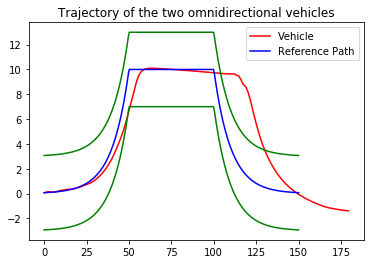

In [10]:
posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [21]:
N = len(x_path)
H = 10  # Number of time steps in trajectory.
n = 10
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")

    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - n - 1:
        n_ilqr =  n  
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    us_init = np.zeros((n_ilqr - 1, dynamics.action_size))
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [.5, .5], q2 = [1., 1.], \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            x_path_ = x_path[i: i + n]
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = [.5, .5], q2 = [1., 1.], \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, n)
            us_init = np.zeros((n - 1, dynamics.action_size))
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
    x0 = x0_[0][:]

>>>>>Step 0 at [0.0, 0.06737946999085467, 10, 0.006737845034422798]
iteration 0 accepted [0.01444852] [ 5.00781803  0.10171955 10.01701823  0.01223941] [-0.00079176  0.00793762]
Utilize NN output [[0.39677832 0.07452384]]
>>>>>Step 1 at [ 0.50046013  0.07075154 10.01885945  0.04393093]
iteration 0 accepted [0.03445143] [ 5.51629732  0.10412349 10.03372302  0.01194267] [-0.00158318  0.00996498]
Utilize NN output [[0.39360696 0.01542107]]
>>>>>Step 2 at [ 1.00138741  0.09277192 10.03758273  0.0516554 ]
iteration 0 accepted [0.05662032] [6.02594409e+00 1.07808227e-01 1.00503896e+01 9.46674158e-03] [-0.00237698  0.00776321]
Utilize NN output [[ 0.39187992 -0.02253345]]
>>>>>Step 3 at [ 1.50306273  0.11870923 10.05623172  0.04034824]
iteration 0 accepted [0.08011549] [6.53685608e+00 1.13025625e-01 1.00670263e+01 6.62673761e-03] [-0.00317177  0.00363523]
Utilize NN output [[ 0.39122853 -0.03837758]]
>>>>>Step 4 at [ 2.00593023  0.13901006 10.07485266  0.02106102]
iteration 0 accepted [0.1055

Utilize NN output [[0.43559507 0.00383071]]
>>>>>Step 38 at [19.68621905  0.46234723 10.74187316  0.03969565]
iteration 0 accepted [12.2784536] [25.03247438  0.74804682 10.67292379  0.05755852] [-0.03258187 -0.00412017]
Utilize NN output [[0.43771487 0.00471358]]
>>>>>Step 39 at [20.22340388  0.48368234 10.76246059  0.04222727]
iteration 0 accepted [13.27394488] [25.57797838  0.79213824 10.69100854  0.06148774] [-0.03347664 -0.00368556]
Utilize NN output [[0.43922922 0.01035522]]
>>>>>Step 40 at [20.76156301  0.50642084 10.78311085  0.04779945]
iteration 0 accepted [14.33063975] [26.12429481  0.83965687 10.70914797  0.06577078] [-0.03437517 -0.00302606]
iteration 60 accepted [14.3147675] [26.10591129  0.9558781  10.71424962  0.16599341] [-0.03695878  0.        ]
Utilize NN output [[0.44070926 0.01252689]]
>>>>>Step 41 at [21.30061994  0.53220711 10.80382246  0.05455304]
iteration 0 accepted [15.45056482] [26.67167968  0.88625591 10.72734072  0.06932845] [-0.0352773  -0.00301135]
iterat

Utilize NN output [[0.5019576 0.0208209]]
>>>>>Step 76 at [40.66530557  3.01105585 11.57533453  0.28148037]
iteration 0 accepted [112.72915705] [46.01921027  5.0057312  11.41353473  0.24212931] [-0.06978352  0.01464787]
Utilize NN output [[0.5024214  0.01952458]]
>>>>>Step 77 at [41.22185229  3.17198567 11.59853549  0.29277911]
iteration 0 accepted [120.0754354] [46.58876528  5.14531069 11.43432393  0.22272097] [-0.07087718  0.02363791]
Utilize NN output [[0.5029187  0.01986577]]
>>>>>Step 78 at [41.77765637  3.33952831 11.62175597  0.30429829]
iteration 0 accepted [129.94131044] [47.1737221   5.23644047 11.45495275  0.18891094] [-0.07198339  0.03608822]
Utilize NN output [[0.50162524 0.01535168]]
>>>>>Step 79 at [42.33260014  3.51380958 11.64492569  0.31321826]
iteration 0 accepted [144.15475781] [47.77164286  5.26844871 11.47537195  0.13780773] [-0.07309814  0.05320757]
Utilize NN output [[0.49977663 0.0129262 ]]
>>>>>Step 80 at [42.88706766  3.69339034 11.66802276  0.32074407]
itera

Utilize NN output [[ 0.3700653  -0.00794539]]
>>>>>Step 114 at [6.10437202e+01 1.01398294e+01 1.20513178e+01 5.08267136e-03]
iteration 0 accepted [282.0255166] [ 6.69407511e+01  9.48391046e+00  1.18388131e+01 -9.63805578e-03] [-0.09201615  0.00335661]
Utilize NN output [[ 0.36902386 -0.00590498]]
>>>>>Step 115 at [6.16467198e+01 1.01428942e+01 1.20689747e+01 1.52457065e-03]
iteration 0 accepted [292.07846954] [ 6.75497164e+01  9.47238163e+00  1.18546215e+01 -1.03509082e-02] [-0.092895    0.00278036]
Utilize NN output [[ 0.36799398 -0.00437885]]
>>>>>Step 116 at [ 6.22506081e+01  1.01438149e+01  1.20865865e+01 -1.11782261e-03]
iteration 0 accepted [302.45708842] [ 6.81603695e+01  9.46361255e+00  1.18703994e+01 -1.08067543e-02] [-0.09377503  0.00233127]
iteration 60 failed 285.2040735096502 [66.78420713  9.5373863  11.94713403  0.80226141] [-0.78034827 -0.40175071]
Utilize NN output [[ 0.36697143 -0.0032403 ]]
>>>>>Step 117 at [ 6.28553762e+01  1.01431389e+01  1.21041535e+01 -3.07602188e

Utilize NN output [[ 3.3614835e-01 -4.9432740e-05]]
>>>>>Step 146 at [ 8.07653777e+01  9.99687320e+00  1.25935474e+01 -9.31158405e-03]
iteration 0 accepted [788.417262] [ 8.69382446e+01  9.42086674e+00  1.23304697e+01 -6.18472765e-03] [-0.12030907 -0.00098973]
Utilize NN output [[ 3.3505026e-01 -4.1684136e-05]]
>>>>>Step 147 at [ 8.13954316e+01  9.99100623e+00  1.26096999e+01 -9.33783161e-03]
iteration 0 accepted [811.34061324] [ 8.75769595e+01  9.41997853e+00  1.23453211e+01 -6.03835631e-03] [-0.12119193 -0.00104006]
Utilize NN output [[ 3.3397591e-01 -1.5577301e-05]]
>>>>>Step 148 at [ 8.20262917e+01  9.98511519e+00  1.26258044e+01 -9.34765286e-03]
iteration 0 accepted [834.75921369] [ 8.82164532e+01  9.41906850e+00  1.23601395e+01 -5.89661431e-03] [-0.12207448 -0.00108872]
Utilize NN output [[ 3.3289769e-01 -1.3908371e-05]]
>>>>>Step 149 at [ 8.26579557e+01  9.97921044e+00  1.26418605e+01 -9.35643308e-03]
iteration 0 accepted [858.67874248] [ 8.88567185e+01  9.41810968e+00  1.237492

Utilize NN output [[ 2.9750964e-01 -4.6810135e-05]]
>>>>>Step 178 at [ 1.01313584e+02  9.76514912e+00  1.30839305e+01 -1.25885139e-02]
iteration 0 accepted [1309.52187592] [100.28630197   8.13531814  12.79219934  -3.45653485] [-0.1363865   1.06445472]
Utilize NN output [[ 2.9624423e-01 -4.6392903e-05]]
>>>>>Step 179 at [ 1.01968088e+02  9.75690944e+00  1.30983241e+01 -1.26188639e-02]
iteration 0 accepted [1380.49136492] [101.32141924   9.04935021  12.80585476  -3.97526137] [-0.13719934  1.21404396]
Utilize NN output [[ 2.9497772e-01 -4.4604763e-05]]
>>>>>Step 180 at [ 1.02623311e+02  9.74864084e+00  1.31126596e+01 -1.26480763e-02]
iteration 0 accepted [1517.59113266] [102.4172006    9.40764706  12.81930311  -4.29993814] [-0.13827429  1.30715461]
Utilize NN output [[ 2.937092e-01 -3.995560e-05]]
>>>>>Step 181 at [ 1.03279248e+02  9.74034405e+00  1.31269368e+01 -1.26742725e-02]
iteration 0 accepted [1703.86505726] [103.35196371   9.4976575   12.83265593  -4.488858  ] [-0.13925672  1.3617

Utilize NN output [[ 0.25889084 -0.09831299]]
>>>>>Step 215 at [ 1.23271184e+02  3.82925010e+00  1.31047772e+01 -2.84814378e-02]
iteration 0 accepted [2548.84265364] [128.43721      0.70861519  12.79766312  -0.21305019] [-0.15074632  0.03943976]
Utilize NN output [[ 0.2566344  -0.09748197]]
>>>>>Step 216 at [ 1.23926471e+02  3.81058154e+00  1.31173345e+01 -9.21538553e-02]
iteration 0 accepted [2508.16748257] [ 1.28493452e+02  6.34846833e-02  1.28102406e+01 -3.06058364e-01] [-0.15073386  0.05240069]
Utilize NN output [[ 0.25463238 -0.08162598]]
>>>>>Step 217 at [124.5798647    3.75019773  13.12979787  -0.14557104]
iteration 0 accepted [2477.39738883] [128.56495379  -0.47920967  12.82263211  -0.41398737] [-0.15074242  0.07447807]
Utilize NN output [[ 0.252839   -0.06174261]]
>>>>>Step 218 at [125.22971726   3.65492409  13.14217714  -0.18605301]
iteration 0 accepted [2463.28743579] [128.73469837  -0.89261465  12.83479439  -0.50955288] [-0.15087271  0.09647093]
Utilize NN output [[ 0.25116

Utilize NN output [[0.21678951 0.00434024]]
>>>>>Step 250 at [ 1.46238019e+02  1.47226865e-01  1.35097609e+01 -8.53155872e-02]
iteration 0 accepted [4820.7632544] [ 1.52639039e+02 -1.32255058e+00  1.31795456e+01 -5.91949826e-02] [-0.17814267 -0.00782362]
Utilize NN output [[0.21568324 0.00421102]]
>>>>>Step 251 at [ 1.46911315e+02  8.96444681e-02  1.35203809e+01 -8.24711084e-02]
iteration 0 accepted [4905.21507974] [ 1.53347993e+02 -1.29633350e+00  1.31896010e+01 -5.59884656e-02] [-0.17889884 -0.00797983]
Utilize NN output [[0.21457274 0.00408276]]
>>>>>Step 252 at [ 1.47585300e+02  3.39338440e-02  1.35309479e+01 -7.97111031e-02]
iteration 0 accepted [4990.13366883] [ 1.54055253e+02 -1.27010141e+00  1.31996109e+01 -5.30583729e-02] [-0.17965009 -0.00807518]
Utilize NN output [[0.21345799 0.00393911]]
>>>>>Step 253 at [ 1.48259961e+02 -1.99583337e-02  1.35414616e+01 -7.70461218e-02]
iteration 0 accepted [5075.50192849] [ 1.54760820e+02 -1.24417513e+00  1.32095749e+01 -5.03856795e-02] [-0

Utilize NN output [[0.1776079  0.00087962]]
>>>>>Step 285 at [ 1.70149950e+02 -1.13363149e+00  1.38494059e+01 -3.33748216e-02]
iteration 0 accepted [8129.56792192] [ 1.76944559e+02 -7.34829402e-01  1.35028373e+01 -2.22251076e-02] [-0.20236293 -0.00363943]
Utilize NN output [[0.17650636 0.00084052]]
>>>>>Step 286 at [ 1.70842253e+02 -1.15674556e+00  1.38581407e+01 -3.27927838e-02]
iteration 0 accepted [8237.89614598] [ 1.77636226e+02 -7.26917555e-01  1.35111803e+01 -2.19900733e-02] [-0.20300493 -0.00353527]
Utilize NN output [[0.17540681 0.00078485]]
>>>>>Step 287 at [ 1.71535004e+02 -1.17947095e+00  1.38668222e+01 -3.22489535e-02]
iteration 0 accepted [8347.13661562] [ 1.78328146e+02 -7.19363871e-01  1.35194731e+01 -2.17671094e-02] [-0.20364478 -0.00343586]
Utilize NN output [[0.17431006 0.00074647]]
>>>>>Step 288 at [ 1.72228200e+02 -1.20183356e+00  1.38754505e+01 -3.17313967e-02]
iteration 0 accepted [8457.29722661] [ 1.79020331e+02 -7.12162455e-01  1.35277158e+01 -2.15554562e-02] [-

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

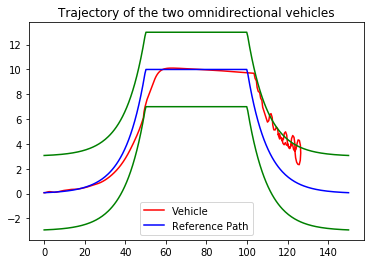

In [20]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

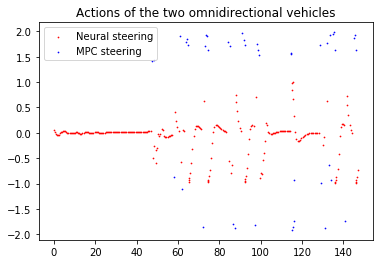

In [65]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
